# Initialization

## Imports

In [1]:
# import os
import pickle
import warnings
import seaborn
import pandas as pd
import autograd.numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.morphology import opening, closing, ball, dilation

from autograd import grad
from skimage import io
from skimage import data
from skimage import color
from skimage.feature import register_translation
from skimage.morphology import opening, ball
from skimage.feature.register_translation import _upsampled_dft
from scipy.ndimage import fourier_shift, zoom, gaussian_filter
from scipy.sparse import csr_matrix, hstack
from scipy.stats import pearsonr
from scipy.spatial.distance import cdist
from scipy.ndimage.measurements import center_of_mass
from sklearn.decomposition import NMF, non_negative_factorization

from tqdm.notebook import tqdm

import ipywidgets as widgets
from ipywidgets import interactive, IntSlider

## Pre-Processing

In [2]:
def high_pass(Y, pct = 10):
    Y_new = Y.copy()
    for idx in tqdm(range(Y.shape[3])):
        Ytemp = Y[:,:,:,idx]
        thresh = np.percentile(Ytemp[Ytemp > 0], pct)
        Ytemp[Ytemp < thresh] = thresh
        Y_new[:,:,:,idx] = Ytemp - thresh

    return Y_new

def percentile_normalize(Y, pct_low = 95, pct_high = 99):
    sf = []
    Y_new = Y.copy()
    Y_new = Y_new.astype('d')
    for idx in tqdm(range(Y.shape[3])):
        in_range = np.logical_and(Y[:,:,:,idx] > np.percentile(Y[:,:,:,idx], pct_low), Y[:,:,:,idx] < np.percentile(Y[:,:,:,idx], pct_high)) 
        if np.min(Y[in_range, idx]) <= 0:
            print('WARNING: Percentile values may be poorly scaled...')
        scale_fac = np.mean(Y[in_range, idx])
        sf.append(scale_fac)
        Y_new[:,:,:,idx] = Y[:,:,:,idx]/scale_fac
    
    Y_new = Y_new*np.median(sf)
        
    return Y_new

def background_opening(Y, size = 3):
    strel = ball(size)
    Y_new = Y.copy()
    for i in tqdm(range(Y.shape[3])):
        Y_new[:,:,:,i] = Y[:,:,:,i] - opening(Y[:,:,:,i], strel)
    
    return Y_new

## Visualization

In [3]:
%matplotlib inline

def imagesc(img, sz1 = 10, sz2 = 10):
    plt.figure(figsize=(sz1,sz2))
    plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, left=False, labelleft=False)
    max_val = np.percentile(img, 99.9) #make sure colors are scaled over whole image
    plt.imshow(img, vmin = 0, vmax = max_val)
    
def viewmask(img, sz1 = 10, sz2 = 15):
    plt.figure(figsize=(sz1,sz2))
    plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, left=False, labelleft=False)
    plt.imshow(np.sum(img, 2), vmin = 0)

def imagesc3D(vol):
    def f(idx):
        plt.figure(figsize=(10,10))
        plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, left=False, labelleft=False)
        max_val = np.percentile(vol, 99) #make sure colors are scaled over whole image
        plt.imshow(vol[:,:, idx], vmin = 0,vmax = max_val)
        plt.show()

    interactive_plot = interactive(f, idx=IntSlider(value=0, description='slice', max=vol.shape[-1]-1, min=0, continuous_update = False))
    output = interactive_plot.children[-1]
    output.layout.height = '650px'
    return interactive_plot

def imagesc4D(vol):
    def f(cidx, zidx):
        plt.figure(figsize=(10,10))
        plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, left=False, labelleft=False)
        max_val = np.percentile(vol, 99) #make sure colors are scaled over whole image
        plt.imshow(vol[:,:, zidx,cidx], vmin = 0, vmax = max_val)
        plt.show()

    interactive_plot = interactive(f, cidx=IntSlider(value=0, description='channel', max=vol.shape[-1]-1, min=0, continuous_update = False), zidx=IntSlider(value=0, description='slice', max=vol.shape[-2]-1, min=0, continuous_update = False))
    output = interactive_plot.children[-1]
    output.layout.height = '650px'
    return interactive_plot

In [4]:
def view_components(vol):
    def f(idx):
        plt.figure(figsize=(10,10))
        plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, left=False, labelleft=False)
        plt.imshow(np.sum(vol[:,:, :, idx], 2))
        plt.show()

    interactive_plot = interactive(f, idx=IntSlider(value=0, description='cell', max=vol.shape[-1]-1, min=0, continuous_update = False))
    output = interactive_plot.children[-1]
    output.layout.height = '650px'
    return interactive_plot


## Patching

In [5]:
def greedy_init(Y, n_components, sigma, verbose = True):
    devs = 4
    #save dimensions of Y
    d1, d2, d3, T = Y.shape

    #initialize objects
    dsigma = 2*np.array(sigma)+1
    W = np.zeros((d1, d2, d3, n_components))
    H = np.zeros((n_components,T))
    centers = np.zeros((n_components, 3))
    Y_init = Y.copy()
    Y_init = Y_init.astype('double')

    #gaussian blur image
    rho = np.array([gaussian_filter(Y_init[:,:,:, i], sigma, mode = 'constant', output = 'double', truncate = devs) for i in range(T)])
    rho = np.moveaxis(rho, 0, -1)

    #find sum image
    v = np.sum(rho, 3)

    for k in range(n_components):
        #find max location and boundaries
        ix, iy, iz = np.unravel_index(np.argmax(v), v.shape)
        xmax, xmin = min(v.shape[0]-1, ix + dsigma[0]), max(0, ix - dsigma[0])
        ymax, ymin = min(v.shape[1]-1, iy + dsigma[1]), max(0, iy - dsigma[1])
        zmax, zmin = min(v.shape[2]-1, iz + dsigma[2]), max(0, iz - dsigma[2])

        data = Y_init[xmin:xmax, ymin:ymax, zmin:zmax, :]
        dims = data.shape
        data = np.reshape(data, (dims[0]*dims[1]* dims[2], dims[3]))
        rA, C, niter = non_negative_factorization(data, n_components = 1, alpha = 0.2, max_iter = 100, tol = 1e-50)

        #save extracted components
        A = np.reshape(rA, (dims[0], dims[1],dims[2]))
        W[xmin:xmax, ymin:ymax, zmin:zmax,k] = A
        H[k, :] = C
        centers[k,:] = [ix, iy, iz]
        
        if k < (n_components-1): #if not last component
            #update Y_init
            removed_data = np.dot(rA, C)
            removed_data = np.reshape(removed_data, (dims[0], dims[1], dims[2], dims[3]))
            
            temp = Y_init[xmin:xmax, ymin:ymax, zmin:zmax, :] - removed_data
            temp[temp < 0] = 0 #remove negative values
            Y_init[xmin:xmax, ymin:ymax, zmin:zmax, :] = temp
            
            rho_xmax, rho_xmin = min(v.shape[0]-1, xmax+devs*sigma[0]), max(0, xmin-devs*sigma[0])
            rho_ymax, rho_ymin = min(v.shape[1]-1, ymax+devs*sigma[1]), max(0, ymin-devs*sigma[1])
            rho_zmax, rho_zmin = min(v.shape[2]-1, zmax+devs*sigma[2]), max(0, zmin-devs*sigma[2])
            
            inp_xmax, inp_xmin = min(v.shape[0]-1, xmax+2*devs*sigma[0]), max(0, xmin-2*devs*sigma[0])
            inp_ymax, inp_ymin = min(v.shape[1]-1, ymax+2*devs*sigma[1]), max(0, ymin-2*devs*sigma[1])
            inp_zmax, inp_zmin = min(v.shape[2]-1, zmax+2*devs*sigma[2]), max(0, zmin-2*devs*sigma[2])
            #update rho
            for i in range(T):
                rho[:,:,:,i] = gaussian_filter(Y_init[:,:,:, i], sigma, mode = 'constant', output = 'double', truncate = devs)

            #update sum image
            v = np.sum(rho, 3)
        if verbose:
            print('Found Component #' + str(k+1) + '...')
    return W, H, centers

In [6]:
def create_3D_patches(dims, patchsize, overlap):
    xdim, ydim, zdim = dims
    px, py, pz = patchsize
    ovlp_x, ovlp_y, ovlp_z = overlap
    
    itx, ity, itz = px - ovlp_x, py - ovlp_y, pz - ovlp_z
    
    xvals = [0]
    yvals = [0]
    zvals = [0]
    
    while xvals[-1]+px < xdim:
        xvals.append(xvals[-1] + itx)
        
    while yvals[-1]+py< ydim:
        yvals.append(yvals[-1] + ity)
        
    while zvals[-1]+pz < zdim:
        zvals.append(zvals[-1] + itz)
        
    n_patches = len(xvals) * len(yvals) * len(zvals)
    patches = np.zeros((2,3, n_patches))
    
    i = 0
    for xmin in xvals:
        for ymin in yvals:
            for zmin in zvals:
                xmax, ymax, zmax = min(xmin+px, xdim),min(ymin+py, ydim),min(zmin+pz, zdim)
                patches[:,:, i] = np.array([[xmin, ymin, zmin], [xmax, ymax, zmax]])
                i += 1
    
    return patches.astype('int')

In [7]:
def process_patch(Y, n_components, sigma, patch_list):
    W_init, H_init, centers = greedy_init(Y, n_components, sigmas)
    
    W_init, H_init, pl = merge_components(W_init, H_init, patch_list)
    n_components = W_init.shape[-1]
    
    d1,d2,d3,T = Y.shape
    dim = d1*d2*d3

    Y = np.reshape(Y, (dim, T))
    W_init = np.reshape(W_init, (dim, n_components))
    
    A, C, niter = non_negative_factorization(Y, W = W_init, H = H_init, n_components = n_components, 
                update_H = False, verbose = False, alpha = 0.5, max_iter = 200, tol = 1e-4, init = 'custom', l1_ratio = 1)
    A = np.reshape(A, (d1,d2,d3,n_components))
        
    return A,C, pl

In [8]:
def embed_patch_results(A, full_dims, patch_min_coords, patch_max_coords):
    T = A.shape[-1]
    xmin, ymin, zmin = patch_min_coords
    xmax, ymax, zmax = patch_max_coords
    
    full = np.zeros([full_dims[0], full_dims[1], full_dims[2], T])
    full[xmin:xmax, ymin:ymax, zmin:zmax, :] = A
    
    return full

## Post-Processing

In [9]:
def remove_empty_components(A, C, patch_list):
    Aempty = np.sum(A, (0,1,2)) == 0
    Cempty = np.sum(C, 1) == 0
    remove = np.where(np.logical_or(Aempty, Cempty))[0]
    
    A = np.delete(A, remove, -1)
    C = np.delete(C, remove, 0)
    patch_list = np.delete(patch_list, remove, 0)
        
    return A, C, patch_list

In [10]:
def connected_components(adjacency, min_size = 0):
    viewed = set()
    components = []
    for seed in range(adjacency.shape[0]):
        if seed not in viewed:
            component = [seed]
            for node in component:
                viewed.add(node)
                connected = np.where(adjacency[seed, :] > 0)[0]
                
                for n in connected: 
                    if n not in viewed:
                        component.append(n)
                        viewed.add(n)
            
            components.append(component)
    
    components = [component for component in components if len(component) >= min_size]
    return components

In [11]:
def patch_mismatch(patch_list):
    mat = np.zeros((patch_list.shape[0], patch_list.shape[0]))
    for i in range(patch_list.shape[0]):
        mat[i, :] = patch_list != patch_list[i]
        
    return mat

In [12]:
def merge_components(A, C, patch_list, spatial_thresh = 0.05, crosspatch_spatial_thresh = 0.05, temporal_thresh = 0.85):
    spatial_correlation = create_spatial_correlation(A)
    temporal_correlation = create_temporal_correlation(C)
    patch_mis = patch_mismatch(patch_list)
    
    spatial_overlap = (spatial_correlation > spatial_thresh)
    temporal_overlap = (temporal_correlation > temporal_thresh)
    
    to_merge = np.logical_and(spatial_overlap, temporal_overlap)
    conn_comp = connected_components(to_merge, min_size = 2)
    
    Anew = A.copy()
    Cnew = C.copy()
    for comp in tqdm(conn_comp):
        merge_idx = comp[0]
        
        inpA = A[:,:,:,comp]
        inpC = C[comp,:]
        clique_patch_list = patch_list[comp]
        
        mergeA, mergeC = merge_component_clique(inpA, inpC, clique_patch_list)
        
        Anew[:,:,:,comp] = 0
        Cnew[comp,:]
        
        Anew[:,:,:,merge_idx] = mergeA
        Cnew[comp,:] = mergeC
    
        
    Anew, Cnew, patch_list = remove_empty_components(Anew, Cnew, patch_list)
    
    return Anew, Cnew, patch_list

In [13]:
def merge_component_clique(As, Cs, patch_list):
    Ys = []
    for idx in np.unique(patch_list):
        tempAs = As[:,:,:,patch_list == idx]
        tempCs = Cs[patch_list == idx, :]
        tempYs = [np.matmul(tempAs[:, :, :, [i]], tempCs[[i], :]) for i in range(tempAs.shape[-1])]
        tempY = np.sum(tempYs, 0)
        Ys.append(tempY)
    
    Y = Ys.pop()
    Ypos = (np.sum(Y, -1, keepdims = True) > 0).astype('int')

    while len(Ys) > 0:
        current = Ys.pop()
        Y = np.add(Y, current)
        Ypos = np.add(Ypos, (np.sum(current, -1, keepdims = True) > 0).astype('int'))
    
    Ypos[Ypos == 0] = 1
    Y = Y/Ypos
        
    d1,d2,d3, T = Y.shape
    Y = np.reshape(Y, (d1*d2*d3, T))
    W_init = np.reshape(np.mean(As, 3), (d1*d2*d3, 1))
    H_init = np.mean(Cs, 0, keepdims = True)
    
    A, C, niter = non_negative_factorization(Y, W = W_init, H = H_init, n_components = 1,
                    verbose = False, alpha = 0.5, max_iter = 100, tol = 1e-30, init = 'custom')
    
    A = np.reshape(A, ((d1,d2,d3)))
    return A, C

In [14]:
def create_spatial_correlation(A, blur = False, sigma = [0.5,0.5,0.5]):
    n_cells = A.shape[-1]
    if blur:
        A = A.copy()
        for i in tqdm(range(n_cells)):
            A[:,:,:,i] = gaussian_filter(A[:,:,:,i], sigma, mode = 'constant', output = 'double')
    
    A = np.reshape(A, (-1, n_cells))

    cellsum = np.sum(A, 0, keepdims = True)
    A = A / cellsum 
    
    spatial_overlap = np.zeros((n_cells, n_cells))
    
    for i in tqdm(range(n_cells-1)):
        i_pos = A[:, i] > 0
        tempA = A[i_pos, :]
        subtract_vec = tempA[:, [i]]
        tempA = tempA[:, i+1:]
        tempA = tempA - subtract_vec
        tempA[tempA > 0] = 0
        overlap = np.sum(tempA, 0) + 1
        spatial_overlap[i, i+1:] = overlap
        spatial_overlap[i+1:, i] = overlap
            
    return spatial_overlap

def create_temporal_correlation(C):
    return np.abs(np.corrcoef(C)) - np.eye(C.shape[0])

## Basecalling

In [15]:
def basecall_round(Y, thresh_c, thresh_d, it):
    dim,T = Y.shape
    if not T == it:
        raise Exception('Wrong round dimension...')
        
    Y = Y.copy().astype('double')
    new = np.zeros((dim,T+1)).astype('int')
    new[:,0] = (Y[:,0] - thresh_c*Y[:,1]) > 0
    new[:,1] = (Y[:,1] - thresh_c*Y[:,0]) > 0
    new[:,2] = (Y[:,2] - thresh_d*np.max(Y[:,0:2], 1)) > 0
    
    new[:, 0] = new[:, 0] - new[:, 2]
    new[:, 1] = new[:, 1] - new[:, 2]
    
    new[new < 0] = 0
    
    new[:,3] = np.sum(new, 1) == 0
    return new

def matrix_basecall(Y, thresh_c = 1.5, thresh_d = 1.5, it = 3):
    dim,T = Y.shape
    basecalls = np.zeros((dim, int(T*(it+1)/it)), dtype = int)
    for i in tqdm(range(0, Y.shape[-1], it)):
        rd = Y[:,i:i+it]
        b_idx = int(i*(it+1)/it)
        basecalls[:, b_idx:b_idx+it+1] = basecall_round(rd, thresh_c = thresh_c, thresh_d = thresh_d, it = it)
    
    return basecalls

In [16]:
def get_A_pixels(Y, Acomp, percentile = 95):
    pos = Acomp[Acomp > 0]
    vals = np.where(Acomp > np.percentile(pos, percentile))
    
    return Y[vals[0], vals[1], vals[2], :]

In [17]:
def calc_sy(flatY):
    dim, T = flatY.shape
    n = T
    sy = flatY.sum(axis=1, keepdims=True)
    sty = np.sqrt(np.sum((flatY - sy/T)**2, 1, keepdims = True) / n)
    
    return sy, sty

def barcode_correlation(X, flatY, sy = None, sty = None):
    dim, T = flatY.shape
    n = T
    if sy is None or sty is None:
        sy = flatY.sum(axis=1, keepdims=True)
        sty = np.sqrt(np.sum((flatY - sy/T)**2, 1, keepdims = True) / n)
    
    stx = np.std(X)
    sx = np.sum(X)
    
    corr = (n*np.sum(flatY*X, 1, keepdims = True) - sx*sy) / (n**2 * stx * sty)

    corr[np.isnan(corr)] = 0
    corr[np.isinf(corr)] = 0
    
    return corr, sy, sty

def barcode_match(barcode, barcode_img, num_bases):
    matches = np.dot(barcode_img, barcode.T) == num_bases
    return np.squeeze(matches)

In [18]:
def norm_by_round(vec, bases = 3):
    vec = vec.copy()
    if(len(vec.shape) == 1):
        vec = np.reshape(vec, (1, -1))
    for i in range(0, vec.shape[-1], bases):
        vec[:, i:i+bases] = vec[:, i:i+bases] / np.max(vec[:, i:i+bases], 1, keepdims = True)
    return np.squeeze(vec)

In [19]:
def duplicate_row(row):
    chans = row.shape[0]
    val = np.zeros((4, 4*chans))
    for i in range(val.shape[0]):
        val[i, i*chans:(i+1)*chans] = row
    return val

def reshape_data_for_optimization(array):
    n_pix, n_col = array.shape
    array = np.reshape(array, (n_pix, 5, 3))
    
    array_scaler = np.max(array, -1, keepdims = True)
    array_scaler[array_scaler == 0] = 1
    
    array = array / array_scaler
    
    dup_array = np.zeros((n_pix, 5, 4, 12))
    for pix in range(n_pix):
        for r_idx in range(array.shape[1]):
            dup_array[pix, r_idx,:, :] = duplicate_row(array[pix, r_idx, :])
            
    return dup_array

def softmax_by_pixel(inp, beta_s = 250):
    ex = np.exp(beta_s*inp.astype('float128'))
    
    bc = ex / np.sum(ex, 2, keepdims = True)
    
    n_pix = bc.shape[0]
    return np.reshape(bc, (n_pix, -1)).astype('float64')

In [20]:
def center_of_mass_norm(mask, order):
    xi, yi, zi = np.where(mask)
    center = np.array(center_of_mass(mask))
    def loss(center):
        xdist = np.sum(np.power(np.abs(xi - center[0]), order))
        ydist = np.sum(np.power(np.abs(yi - center[1]), order))
        zdist = np.sum(np.power(np.abs(zi - center[2]), order))
        return xdist + ydist + zdist
    
    gradient = grad(loss)
    
    #print("Initial distance:", loss(center))
    for i in range(1000):
        #if i % 100 == 0:
            #print("Current distance:", loss(center))
        
        g = gradient(center) 
        center -= g / (np.linalg.norm(g, 2))
        
    #print("Trained distance:", loss(center))
    return center
    

# NMF Processing

## Load Raw Data

In [ ]:
num_channels = 3
bases_sequenced = [1, 2, 3, 4, 6]

filepath = '/mp/nas2/DG/iarpa_virtual_tiles/3_1/4_registration/'
file_strs = ['ch00', 'ch01SHIFT', 'ch02SHIFT']
filenames = []
for ridx in bases_sequenced:
    for fs in file_strs:
        filenames.append(filepath+'richieseq_round00'+str(ridx)+'_'+fs+'_affine.tif')

Y = np.array([zoom(io.imread(filenames[j]), (0.25, 0.25, 0.25), order = 1)  for j in tqdm(range(len(bases_sequenced)*num_channels))])
Y = np.moveaxis(Y, 1, -1) 
Y = np.moveaxis(Y, 0, -1)

rawY = Y.copy()

In [ ]:
d1,d2,d3,T = Y.shape
dim = d1*d2*d3

Yhp = high_pass(rawY)
Y = percentile_normalize(Yhp)
flatY = np.reshape(Y, (dim, T))

## Process by Patch

In [ ]:
num_cells = 15
sigmas = [12,12,8]

patches = create_3D_patches([d1,d2,d3], [150, 150, 100], [30, 30, 30])
num_patches = patches.shape[-1]

A = np.zeros([d1,d2,d3, num_cells*num_patches])
C = np.zeros([num_cells*num_patches, T])
patch_list = np.zeros([num_cells*num_patches])

with warnings.catch_warnings():
    # ignore all caught warnings
    warnings.filterwarnings("ignore")
    
    for i in tqdm(range(num_patches)):
        idx = i*num_cells
        patch_coords = patches[:,:,i]
        x1,y1,z1,x2,y2,z2 = np.ravel(patch_coords)
        Ypatch = Y[x1:x2, y1:y2, z1:z2, :]
        pl = np.array([i]*num_cells)
        Apatch, Cpatch, pl = process_patch(Ypatch, num_cells, sigmas, pl)
        
        merged_num = Cpatch.shape[0]
        print('Reshaping patch results...')
        patch_list[idx:idx+merged_num] = pl
        C[idx:idx+merged_num] = Cpatch
        A[:,:,:,idx:idx+merged_num] = embed_patch_results(Apatch, [d1,d2,d3], [x1,y1,z1], [x2, y2, z2])
        
A, C, patch_list = remove_empty_components(A, C, patch_list)

In [ ]:
A, C, patch_list = merge_components(A, C, patch_list)

In [ ]:
#do we need to prefilter components, maybe by dilation factor/center of mass of thresholded nmf?
#combine all components, merge duplicates? 

In [ ]:
#

# Barcode Analysis

## Load All Images

In [22]:
def load_fov(filepath, ext = '_affine', raw = False):
    num_channels = 3
    bases_sequenced = [1, 2, 3, 4, 6]
    
    if raw:
        file_strs = ['ch00', 'ch01', 'ch02']
    else:
        file_strs = ['ch00', 'ch01SHIFT', 'ch02SHIFT']
    filenames = []
    for ridx in bases_sequenced:
        for fs in file_strs:
            filenames.append(filepath+'richieseq_round00'+str(ridx)+'_'+fs+ext+'.tif')

    Y = np.array([zoom(io.imread(filenames[j]), (0.25, 0.25, 0.25), order = 1)  for j in tqdm(range(len(bases_sequenced)*num_channels))])
    Y = np.moveaxis(Y, 1, -1)
    Y = np.moveaxis(Y, 0, -1)
    
    return Y

fovs = ['0_0', '0_1', '1_0', '1_1', '2_0', '2_1', '3_0', '3_1', '4_0', '4_1', '5_0', '5_1', '6_0', '6_1']

Ys = {}

Ys['0_0'] = load_fov('/mp/nas2/DG/iarpa_virtual_tiles/0_0/2_color-correction/', ext = '')
Ys['0_1'] = load_fov('/mp/nas2/DG/iarpa_virtual_tiles/0_1/2_color-correction/', ext = '')
Ys['1_0'] = load_fov('/mp/nas2/DG/iarpa_virtual_tiles/1_0/4_registration/')
Ys['1_1'] = load_fov('/mp/nas2/DG/iarpa_virtual_tiles/1_1/2_color-correction/', ext = '')
Ys['2_0'] = load_fov('/mp/nas2/DG/iarpa_virtual_tiles/2_0/4_registration/')
Ys['2_1'] = load_fov('/mp/nas2/DG/iarpa_virtual_tiles/2_1/4_registration/')
Ys['3_0'] = load_fov('/mp/nas2/DG/iarpa_virtual_tiles/3_0/4_registration/')
Ys['3_1'] = load_fov('/mp/nas2/DG/iarpa_virtual_tiles/3_1/4_registration/')
Ys['4_0'] = load_fov('/mp/nas2/DG/iarpa_virtual_tiles/4_0/4_registration/')
Ys['4_1'] = load_fov('/mp/nas2/DG/iarpa_virtual_tiles/4_1/4_registration/')
Ys['5_0'] = load_fov('/mp/nas2/DG/iarpa_virtual_tiles/5_0/4_registration/')
Ys['5_1'] = load_fov('/mp/nas2/DG/iarpa_virtual_tiles/5_1/4_registration/')
Ys['6_0'] = load_fov('/mp/nas2/DG/iarpa_virtual_tiles/6_0/4_registration/')
Ys['6_1'] = load_fov('/mp/nas2/DG/iarpa_virtual_tiles/6_1/4_registration/')

full_stitch = np.concatenate([np.concatenate([Ys['0_0'], Ys['1_0'], Ys['2_0'], Ys['3_0'], Ys['4_0'], Ys['5_0'], Ys['6_0']], 0), np.concatenate([Ys['0_1'], Ys['1_1'], Ys['2_1'], Ys['3_1'], Ys['4_1'], Ys['5_1'], Ys['6_1']], 0)], 1)

full_stitch = high_pass(full_stitch)
full_stitch = percentile_normalize(full_stitch)

for fov in fovs:
    try:
        temp = high_pass(Ys[fov])
        temp = percentile_normalize(temp)
        Ys[fov] = temp
    except:
        print('High pass/normalization failed for FOV ' + fov)

df1,df2,df3,fT = full_stitch.shape
fdim = df1*df2*df3

flat_full_stitch = np.reshape(full_stitch, (fdim, fT))


High pass/normalization failed for FOV 0_1



High pass/normalization failed for FOV 6_0



High pass/normalization failed for FOV 6_1


In [88]:
As = {}
Cs = {}

for fov in tqdm(fovs):
    try:
        As[fov] = pickle.load(open(fov+"_A.p", "rb" ))
        Cs[fov] = pickle.load(open(fov+"_C.p", "rb" ))
    except:
        print('No components loaded for ' + fov)
        

No components loaded for 0_1
No components loaded for 1_1
No components loaded for 6_0
No components loaded for 6_1



In [95]:
fov_list = []
for fov in fovs:
    if fov in As:
        fov_list = fov_list + [fov] * As[fov].shape[-1]
        
fov_list = np.array(fov_list)

padding = {}
full_padding = {}
ffv1, ffv2, ffv3 = 1870, 1946, 400
fv1, fv2, fv3 = 468, 486, 100
for fov in fovs:
    full_padding[fov] = np.array((int(fov[0])*ffv1, int(fov[2])*ffv2, 0))
    padding[fov] = np.array((int(fov[0])*fv1, int(fov[2])*fv2, 0))

In [81]:
nmf_distances = []
nmf_coms = []
nmf_df = []

for fov in tqdm(fovs):
    if fov in As:
        A = As[fov]
        for cidx in tqdm(range(A.shape[-1])):
            comp = A[:,:,:,cidx]
            high = comp > np.percentile(comp, 99.99)
            comr = center_of_mass_norm(high, 0.5)
            x,y,z = comr
            xpos, ypos, zpos = np.where(high)

            distance = []
            for idx in range(xpos.shape[-1]):
                dist= (xpos[idx]-x)**2 + (ypos[idx]-y)**2 + (zpos[idx]-z)**2
                distance.append(dist ** 0.5)
            nmf_distances.append(distance)

            df = np.sum(dilation(high, ball(1))) / np.sum(high)
            nmf_df.append(df)

            com = comr + padding[fov]
            nmf_coms.append(com)
            
nmf_median_distances = np.array([np.median(distances) for distances in nmf_distances])

nmf_coms = np.array(nmf_coms)
nmf_df = np.array(nmf_df)

/home/axue/miniconda3/envs/seq/lib/python3.8/site-packages/autograd/numpy/numpy_vjps.py:59: RuntimeWarning: divide by zero encountered in power
  lambda ans, x, y : unbroadcast_f(x, lambda g: g * y * x ** anp.where(y, y - 1, 1.)),
/home/axue/miniconda3/envs/seq/lib/python3.8/site-packages/autograd/numpy/numpy_vjps.py:71: RuntimeWarning: invalid value encountered in multiply
  lambda ans, x : lambda g: g * replace_zero(anp.conj(x), 0.) / replace_zero(ans, 1.))


In [91]:
prefilter = np.logical_and(nmf_median_distances < 50, nmf_df < 5)

<ipython-input-91-b8b3b6fa1a3e>:1: RuntimeWarning: invalid value encountered in less
  prefilter = np.logical_and(nmf_median_distances < 50, nmf_df < 5)


In [94]:
pm.shape

(596, 596)

In [96]:
fullC = np.concatenate([Cs[fov] for fov in fovs if fov in Cs], 0)
tc = create_temporal_correlation(fullC)
pm = patch_mismatch(fov_list)
comd = cdist(nmf_coms, nmf_coms)

In [97]:
merge_across_patches = connected_components(np.logical_and(np.logical_and(comd < 90, pm), tc > 0.85), 2)

remove_indices = []
for cc in tqdm(merge_across_patches):
    cc_sizes = [np.sum(As[get_fov_index(fov_list, elm)[0]][:,:,:,get_fov_index(fov_list, elm)[1]]) for elm in cc]
    [remove_indices.append(index) for index in cc if index != cc[np.argmax(cc_sizes)]]
    
prefilter[remove_indices] = False

prefilter = np.where(prefilter)[0]

<ipython-input-97-55253d412b9d>:1: RuntimeWarning: invalid value encountered in less
  merge_across_patches = connected_components(np.logical_and(np.logical_and(comd < 90, pm), tc > 0.85), 2)


In [87]:
keep_dict = get_fov_index_dict(fov_list,prefilter)
fov_list = fov_list[prefilter]

for fov in fovs:
    if fov in As:
        As[fov] = As[fov][:,:,:, keep_dict[fov]]
        Cs[fov] = Cs[fov][keep_dict[fov], :]

KeyboardInterrupt: 

In [85]:
def get_fov_index(fov_list, idx):
    fov_label = fov_list[idx]
    start_idx = np.where(fov_list == fov_label)[0][0]
    new_idx = idx - start_idx
    return fov_label, new_idx

def get_fov_index_dict(fov_list, idx_list):
    return_dict = {}
    for idx in idx_list:
        fov_label, new_idx = get_fov_index(fov_list, idx)
        if fov_label in return_dict:
            return_dict[fov_label].append(new_idx)
        else:
            return_dict[fov_label] = [new_idx]
    
    return return_dict

In [325]:
#make input data for training
num_pixels = 1000
inputs = []
cross_comp_vals = []

for fov in fovs:
    if fov in As:
        A = As[fov]
        Y = Ys[fov]
        C = Cs[fov]
        
        selected_components = range(A.shape[-1])
        for fidx in tqdm(selected_components):
            input_vals = []
            mask = A[:,:,:, fidx] > np.percentile(A[:,:,:, fidx], 99.99)
            masked = Y[mask, :]

            input_vals.append(reshape_data_for_optimization(masked[np.random.choice(masked.shape[0], size=num_pixels, replace = False), :]))    
            inputs.append(input_vals)

            cross_comp_vals.append(masked[np.random.choice(masked.shape[0], size=num_pixels, replace = False), :])


cross_comp_vals = np.concatenate(cross_comp_vals, 0)

idx = 0
for fov in fovs:
    if fov in As:
        A = As[fov]
        Y = Ys[fov]
        C = Cs[fov]
        selected_components = range(A.shape[-1])
        
        for fidx in tqdm(selected_components):
            inputs[idx].append(reshape_data_for_optimization(cross_comp_vals[np.random.choice(cross_comp_vals.shape[0], size=num_pixels, replace = False), :]))
            inputs[idx].append(reshape_data_for_optimization(C[[fidx], :]))
            idx+=1

In [332]:
weights = np.array([[1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0]]).astype('d')
matrix_gradient = grad(basecalling_loss)
learning_rates = [0.01, 0.001, 0.0001]
training_steps = [500, 500, 500]
print("Initial loss:", basecalling_loss(weights))
for train_idx in range(len(learning_rates)):
    for i in tqdm(range(training_steps[train_idx])):
        if i % 10 == 0:
            print("Current loss:", basecalling_loss(weights))
        weights -= matrix_gradient(weights) * learning_rates[train_idx]

print("Trained loss:", basecalling_loss(weights))

Initial loss: 8.522170937175297


Current loss: 8.522170937175297
Current loss: 2.7997774957012953
Current loss: 2.7776894066682765
Current loss: 2.758026535462781
Current loss: 2.739238573726101
Current loss: 2.7215074862661353
Current loss: 2.704826877473797
Current loss: 2.688989622417308
Current loss: 2.673917326982906
Current loss: 2.6644719520610685
Current loss: 2.6490747475164906
Current loss: 2.6355120237912764
Current loss: 2.622719284111408
Current loss: 2.610459778147777
Current loss: 2.598625857005801
Current loss: 2.5870546856178356
Current loss: 2.5755079251034507
Current loss: 2.563894225364197
Current loss: 2.552718711262135
Current loss: 2.5424163473199677
Current loss: 2.5325399538561397
Current loss: 2.5231516275312327
Current loss: 2.5172584329845913
Current loss: 2.513222586433723
Current loss: 2.502602429066288
Current loss: 2.497713330486314
Current loss: 2.4902563306221053
Current loss: 2.4818159286631327
Current loss: 2.4741786905193104
Current loss: 2.4650044751601836
Current loss: 2.45529112

Current loss: 2.3679608445568117
Current loss: 2.3525622514774036
Current loss: 2.3515700759751605
Current loss: 2.3510813700117827
Current loss: 2.350646590221187
Current loss: 2.3502252580815814
Current loss: 2.349806835144144
Current loss: 2.349387947844261
Current loss: 2.3489674553317976
Current loss: 2.348544889888356
Current loss: 2.3481199563282966
Current loss: 2.347692352535708
Current loss: 2.347261678562711
Current loss: 2.346827361877793
Current loss: 2.3463885724612283
Current loss: 2.345944111040012
Current loss: 2.3454922500084416
Current loss: 2.345030494757455
Current loss: 2.344555211847452
Current loss: 2.344061034555688
Current loss: 2.3435398974738506
Current loss: 2.342979457181779
Current loss: 2.3423604846993626
Current loss: 2.3416523109982808
Current loss: 2.3408031850492574
Current loss: 2.339714629942582
Current loss: 2.3381959674018384
Current loss: 2.336133498641753
Current loss: 2.3339683310275126
Current loss: 2.3321032403811888
Current loss: 2.33058145

Current loss: 2.32071266876076
Current loss: 2.320680748426688
Current loss: 2.3206488437452366
Current loss: 2.320616954464105
Current loss: 2.3205850803351273
Current loss: 2.320553221114115
Current loss: 2.3205213765606687
Current loss: 2.320489546438018
Current loss: 2.3204577305128655
Current loss: 2.320425928555204
Current loss: 2.3203941403382022
Current loss: 2.3203623656380277
Current loss: 2.3203306042337073
Current loss: 2.3202988559069864
Current loss: 2.3202671204422036
Current loss: 2.320235397626135
Current loss: 2.3202036872478717
Current loss: 2.320171989098709
Current loss: 2.3201403029719923
Current loss: 2.320108628663031
Current loss: 2.3200769659689415
Current loss: 2.320045314688571
Current loss: 2.3200136746223485
Current loss: 2.319982045572207
Current loss: 2.319950427341458
Current loss: 2.3199188197346787
Current loss: 2.3198872225576443
Current loss: 2.3198556356171736
Current loss: 2.3198240587210903
Current loss: 2.3197924916780726
Current loss: 2.3197609

In [38]:
def basecall_with_weights(Y, rweights):
    d1, d2, d3, T = Y.shape
    barcodeY = np.reshape(Y, (d1, d2, d3, 5, 3))
    barcodeY = np.matmul(barcodeY, rweights.T)
    barcodeY = (barcodeY / np.max(barcodeY, -1, keepdims = True) == 1).astype('int')
    barcodeY = np.reshape(barcodeY, (d1,d2,d3, -1))
    return barcodeY

In [335]:
rweights = np.reshape(weights, (4,3))

d1, d2, d3, T = full_stitch.shape
barcodeY = np.reshape(flat_full_stitch, (d1, d2, d3, 5, 3))
barcodeY = np.matmul(barcodeY, rweights.T)
barcodeY = (barcodeY / np.max(barcodeY, -1, keepdims = True) == 1).astype('int')
barcodeY = np.reshape(barcodeY, (d1,d2,d3, -1))

<ipython-input-335-9315a08f5d6b>:6: RuntimeWarning: invalid value encountered in true_divide
  barcodeY = (barcodeY / np.max(barcodeY, -1, keepdims = True) == 1).astype('int')


<ipython-input-335-9315a08f5d6b>:16: RuntimeWarning: invalid value encountered in true_divide
  barcodeC = (barcodeC / np.max(barcodeC, -1, keepdims = True) == 1).astype('int')


In [626]:
fullC = []
full_barcodeC = []
barcodeCs = {}
for fov in tqdm(fovs):
    if fov in Cs:
        C = Cs[fov]
        b1, bT = C.shape
        barcodeC = np.reshape(C, (b1, 5, 3))
        barcodeC = np.matmul(barcodeC, rweights.T)
        barcodeC = (barcodeC / np.max(barcodeC, -1, keepdims = True) == 1).astype('int')
        barcodeC = np.reshape(barcodeC, (b1,-1))
        barcodeCs[fov] = barcodeC
        fullC.append(C)
        full_barcodeC.append(barcodeC)
        
fullC = np.concatenate(fullC, 0)
full_barcodeC = np.concatenate(full_barcodeC, 0)

<ipython-input-626-0343300a69f6>:10: RuntimeWarning: invalid value encountered in true_divide
  barcodeC = (barcodeC / np.max(barcodeC, -1, keepdims = True) == 1).astype('int')


In [623]:
un, inv, cts = np.unique(full_barcodeC, axis = 0, return_counts = True, return_inverse = True)

In [637]:
y_vals = []
y_size = []
y_dilation_factor = []
y_distances = []

for fov in tqdm(fovs):
    if fov in As:
        Y = Ys[fov]
        A = As[fov]
        C = Cs[fov]
        barcodeC = barcodeCs[fov]
        
        dy1, dy2, dy3, T = Y.shape
        flatY = np.reshape(Y, (dy1*dy2*dy3, T))
        barcodeYs = basecall_with_weights(Y, rweights)
        
        sy, sty = calc_sy(flatY)
        
        for idx in tqdm(range(A.shape[-1])):
            bm = barcode_match(barcodeC[idx, :], barcodeYs, 5)
            corr, sy, sty = barcode_correlation(C[idx,:], flatY, sy, sty)
            corr = np.reshape(corr, (dy1,dy2,dy3))
            merged = np.logical_and(bm, corr > 0.75)
            sens = (np.sum(A[merged,idx]) / np.sum(A[:,:,:,idx]))
            spec = (np.sum(merged)/merged.size)
            y_vals.append(sens/spec)
            y_size.append(np.sum(merged))
            y_dilation_factor.append(np.sum(dilation(merged, ball(1))) / np.sum(merged))

            x,y,z = center_of_mass_norm(merged, 0.5)
            xpos, ypos, zpos = np.where(merged > 0)

            distance = []
            for idx in range(xpos.shape[-1]):
                dist= (xpos[idx]-x)**2 + (ypos[idx]-y)**2 + (zpos[idx]-z)**2
                distance.append(dist ** 0.5)
            y_distances.append(distance)
            
y_vals = np.array(y_vals)
y_size = np.array(y_size)
y_dilation_factor = np.array(y_dilation_factor)
y_median_distances = np.array([np.median(distance) for distance in y_distances])

<ipython-input-347-8fa05f66b3ae>:5: RuntimeWarning: invalid value encountered in true_divide
  barcodeY = (barcodeY / np.max(barcodeY, -1, keepdims = True) == 1).astype('int')


<ipython-input-627-e073f87313be>:19: RuntimeWarning: invalid value encountered in true_divide
  corr = (n*np.sum(flatY*X, 1, keepdims = True) - sx*sy) / (n**2 * stx * sty)
<ipython-input-637-3cba69ae5ed7>:26: RuntimeWarning: invalid value encountered in double_scalars
  y_vals.append(sens/spec)
<ipython-input-637-3cba69ae5ed7>:28: RuntimeWarning: invalid value encountered in long_scalars
  y_dilation_factor.append(np.sum(dilation(merged, ball(1))) / np.sum(merged))
<ipython-input-22-fda6aed31a9b>:18: RuntimeWarning: invalid value encountered in true_divide
  center -= g / (np.linalg.norm(g, 2))


In [675]:
size_filter = np.logical_and(y_size > 1000, y_size < 100000)
dilation_filter = y_dilation_factor < 5
enrichment_filter = y_vals > 50
distance_filter = y_median_distances < 100

filtered_idx = np.where(np.logical_and(np.logical_and(size_filter, dilation_filter), np.logical_and(enrichment_filter, distance_filter)))[0]

print(filtered_idx)

[  4   5  35  40  44  48  54  56  57  62  67  78  79  80  88  91  93  99
 100 101 109 118 120 126 164 178 193 204 205 206 215 219 249 250 251 255
 266 268 270 271 277 282 283 287 293 294 295 296 301 306 307 323 324 325
 328 335 338 341 348 373 375 382 388 389 391 393 400 401 407 411 416 419
 426 430 435 464 466 475 476 477 498 499 502 505 509 512 513 527 533 548
 555 578 579 580 583 585 586 587 589 590 594]


<ipython-input-675-0faa22c79448>:2: RuntimeWarning: invalid value encountered in less
  dilation_filter = y_dilation_factor < 5
<ipython-input-675-0faa22c79448>:3: RuntimeWarning: invalid value encountered in greater
  enrichment_filter = y_vals > 50
<ipython-input-675-0faa22c79448>:4: RuntimeWarning: invalid value encountered in less
  distance_filter = y_median_distances < 100


In [ ]:
ds_factor = 2

ds_full_stitch = zoom(full_stitch, (1/ds_factor, 1/ds_factor, 1/ds_factor, 1), order = 1)
ds1, ds2, ds3, T = ds_full_stitch.shape
ds_flat_full_stitch = np.reshape(ds_full_stitch, (ds1*ds2*ds3, T))
barcodeYds = basecall_with_weights(ds_full_stitch, rweights)

sy, sty = calc_sy(ds_flat_full_stitch)

In [ ]:
barcode_duplicate_thresh = 5

labels = np.zeros(ds_full_stitch.shape[0:3])
dsfv1, dsfv2, dsfv3 = fv1//ds_factor, fv2//ds_factor, fv3//ds_factor
ds_padding = {}
for fov in padding:
    ds_padding[fov] = padding[fov] // ds_factor

already_processed = set()
d1,d2,d3,T = ds_full_stitch.shape

vals = np.zeros(fullC.shape[0])
size = np.zeros(fullC.shape[0])
dilation_factor = np.zeros(fullC.shape[0])
distances = [[] for comp in range(fullC.shape[0])]
inpatch = np.zeros(fullC.shape[0])

for component_idx in tqdm(filtered_idx):
    if component_idx not in already_processed:
        matching_idx = np.where(inv == inv[component_idx])[0]
        if len(matching_idx) <= barcode_duplicate_thresh:
            d1,d2,d3,T = ds_full_stitch.shape
            bm = barcode_match(full_barcodeC[component_idx, :], barcodeYds, 5)

            corrs = []
            for match_idx in matching_idx:
                corr, sy, sty = barcode_correlation(fullC[match_idx,:], ds_flat_full_stitch, sy, sty)
                corr = np.reshape(corr, (d1,d2,d3))
                corrs.append(corr)
            
            corrs = np.stack(corrs, -1)
            for c_idx in range(len(matching_idx)):
                match_idx = matching_idx[c_idx]
                corr_mask = np.logical_and(corrs[:,:,:,c_idx] > 0.75, corrs[:,:,:,c_idx] == np.max(corrs, -1))
                merged = np.logical_and(bm, corr_mask)

                fov, fov_index = get_fov_index(fov_list, match_idx)
                p1, p2, p3 = ds_padding[fov].astype('int')
                A_ds = zoom(As[fov][:,:,:,fov_index], (1/ds_factor, 1/ds_factor, 1/ds_factor), order = 1)

                merged_single_fov = merged[p1:p1+A_ds.shape[0], p2:p2+A_ds.shape[1], p3:p3+A_ds.shape[2]]
                
                sens = (np.sum(A_ds[merged_single_fov]) / np.sum(A_ds))
                spec = (np.sum(merged_single_fov)/merged_single_fov.size)
                vals[match_idx] = (sens/spec)
                size[match_idx] = (np.sum(merged))
                inpatch[match_idx] = np.sum(merged_single_fov) / np.sum(merged)
                dilation_factor[match_idx] = (np.sum(dilation(merged, ball(1))) / np.sum(merged))

                x,y,z = center_of_mass_norm(merged, 0.5)
                xpos, ypos, zpos = np.where(merged > 0)
                
                if match_idx in filtered_idx:
                    labels[merged] = match_idx
                
                distance = []
                for idx in range(xpos.shape[-1]):
                    dist= (xpos[idx]-x)**2 + (ypos[idx]-y)**2 + (zpos[idx]-z)**2
                    distance.append(dist ** 0.5)
                distances[match_idx] = (distance)
                
                already_processed.add(match_idx)
                
median_distances = np.array([np.median(distance) for distance in distances])

In [745]:
inpatch_threshold = 0.4
final_idx = filtered_idx[inpatch[filtered_idx] > inpatch_threshold]

## Final Image Output

In [753]:
good_cvec = []
good_barcode = []

d1,d2,d3,T = full_stitch.shape
full_stitch_labels = np.zeros((d1,d2,d3))
sy, sty = calc_sy(flat_full_stitch)
fv1, fv2, fv3 = 468, 486, 100

already_processed = set()

for component_idx in tqdm(final_idx):
    if component_idx not in already_processed:
        matching_idx = np.where(inv == inv[component_idx])[0]
        bm = barcode_match(full_barcodeC[component_idx, :], barcodeY, 5)

        corrs = []
        for match_idx in matching_idx:
            corr, sy, sty = barcode_correlation(fullC[match_idx,:], flat_full_stitch, sy, sty)
            corr = np.reshape(corr, (d1,d2,d3))
            corrs.append(corr)

        corrs = np.stack(corrs, -1)
        for c_idx in range(len(matching_idx)):
            match_idx = matching_idx[c_idx]
            corr_mask = np.logical_and(corrs[:,:,:,c_idx] > 0.75, corrs[:,:,:,c_idx] == np.max(corrs, -1))
            merged = np.logical_and(bm, corr_mask)

            if match_idx in final_idx:
                full_stitch_labels[merged] = match_idx
                good_cvec.append(fullC[idx, :])
                good_barcode.append(full_barcodeC[idx,:])

            already_processed.add(match_idx)
            
good_cvec = np.array(good_cvec)
good_barcode = np.array(good_barcode)

<ipython-input-627-e073f87313be>:19: RuntimeWarning: invalid value encountered in true_divide
  corr = (n*np.sum(flatY*X, 1, keepdims = True) - sx*sy) / (n**2 * stx * sty)


In [754]:
pickle.dump(full_stitch_labels, open("full_stitch_label.p", "wb" ))

In [310]:
upsample_labels = zoom(full_stitch_labels, (4,4,4), order = 0).astype('uint16')

In [311]:
f1,f2,f3 = 13090, 3892, 400
resized_labels = np.zeros((f1+50, f2+50, f3+50), dtype = 'uint16')
l1,l2,l3 = upsample_labels.shape
resized_labels[:l1, :l2, :l3] = upsample_labels

In [312]:
ffv1, ffv2, ffv3 = 1870, 1946, 400
horizontal_patches = 2
vertical_patches = 7

imagestack = []

for h in tqdm(range(horizontal_patches)):
    column = []
    for v in tqdm(range(vertical_patches)):
        column.append(resized_labels[v*ffv1:(v+1)*ffv1, h*ffv2:(h+1)*ffv2,:ffv3])
    imagestack.append(np.concatenate(column, 0))
final_labels = np.concatenate(imagestack, 1)

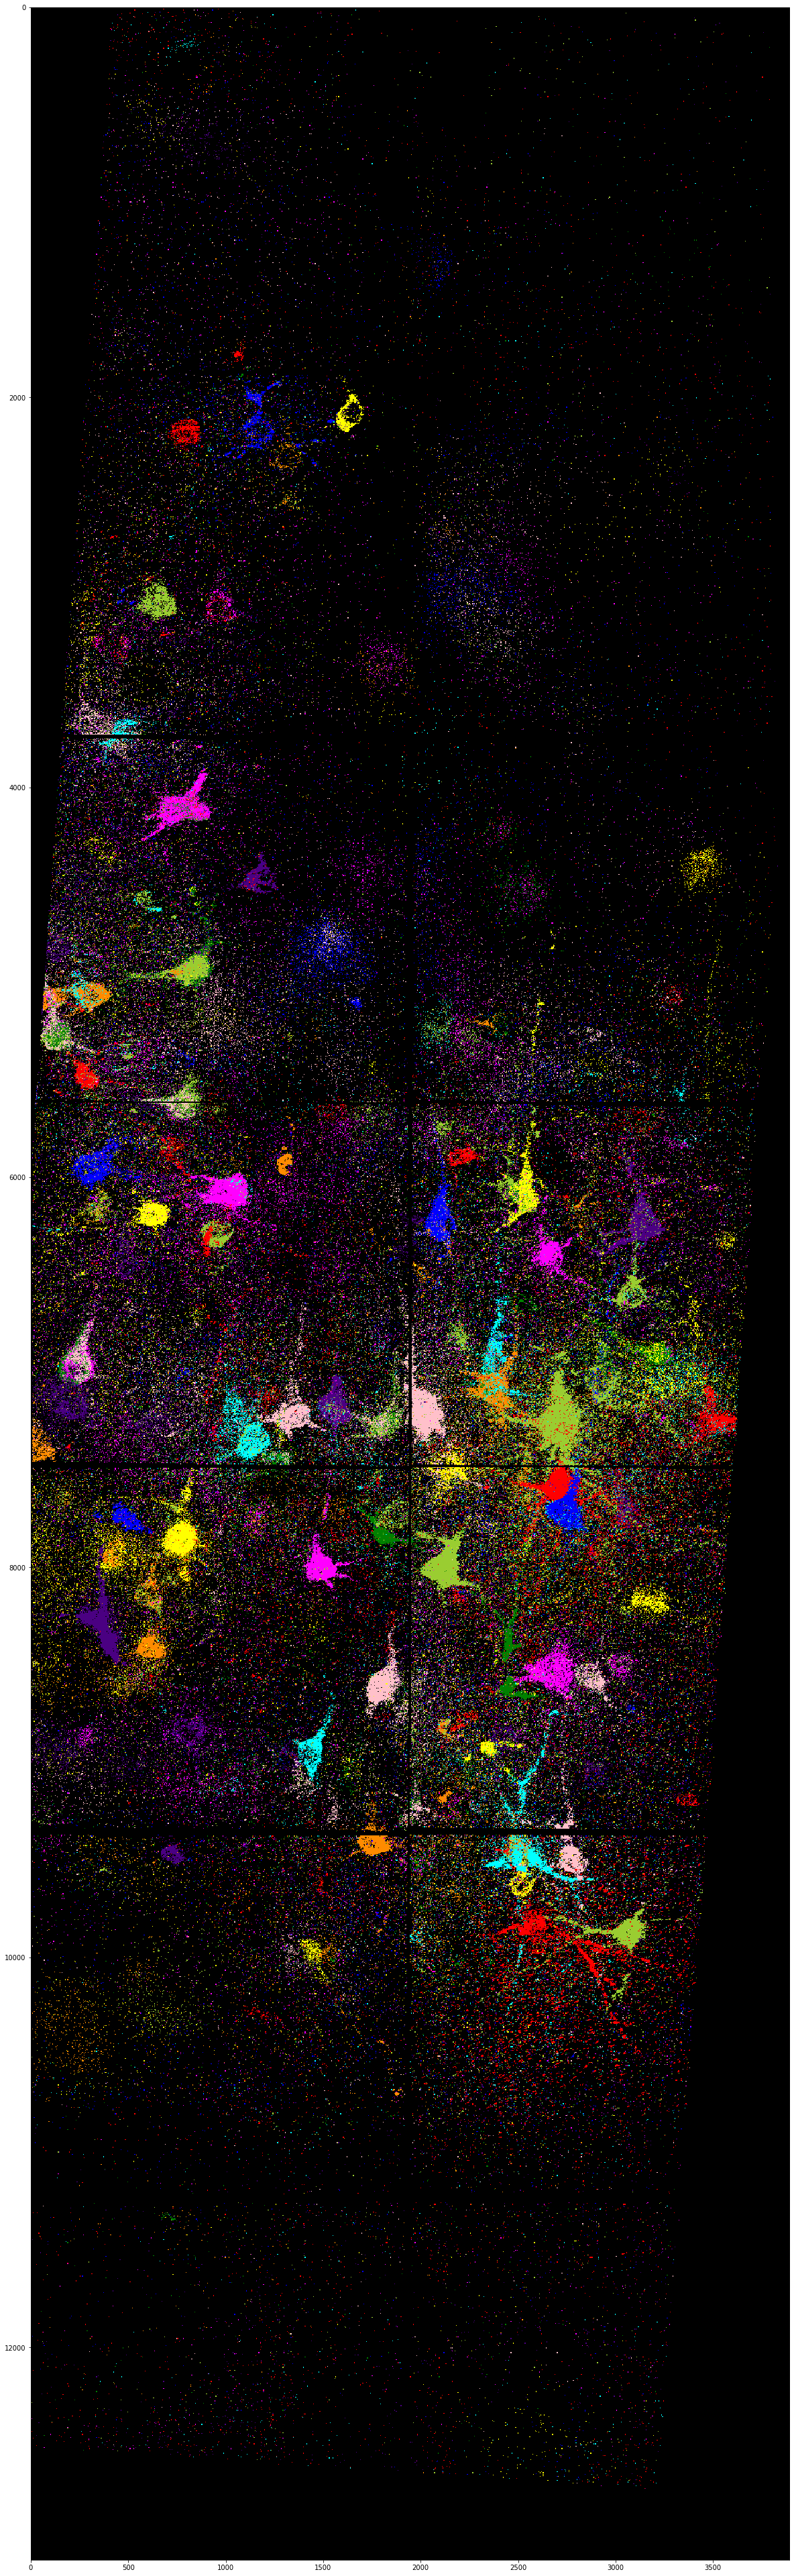

In [832]:
labels2 = np.max(final_labels, 2)
col_labels = color.label2rgb(labels2, bg_label = 0)
plt.figure(figsize=(25,70))
plt.imshow(col_labels)

In [834]:
io.imsave('/mp/nas2/axue/fullstitch_components.tif', final_labels)
np.savetxt('/mp/nas2/axue/fullstitch_barcode.csv', good_barcode, delimiter=",")
np.savetxt('/mp/nas2/axue/fullstitch_Cvec.csv', good_cvec, delimiter=",")

<ipython-input-834-40c7619cfb65>:1: UserWarning: /mp/nas2/axue/fullstitch_components.tif is a low contrast image
  io.imsave('/mp/nas2/axue/fullstitch_components.tif', final_labels)


In [852]:
final_idx

array([ 35,  40,  44,  79,  91,  93,  99, 100, 101, 109, 118, 205, 206,
       215, 255, 270, 277, 282, 283, 287, 293, 294, 296, 324, 325, 328,
       335, 338, 341, 348, 375, 382, 388, 393, 401, 407, 411, 430, 435,
       464, 475, 476, 509, 512, 513, 533, 548, 583, 586, 589, 594])

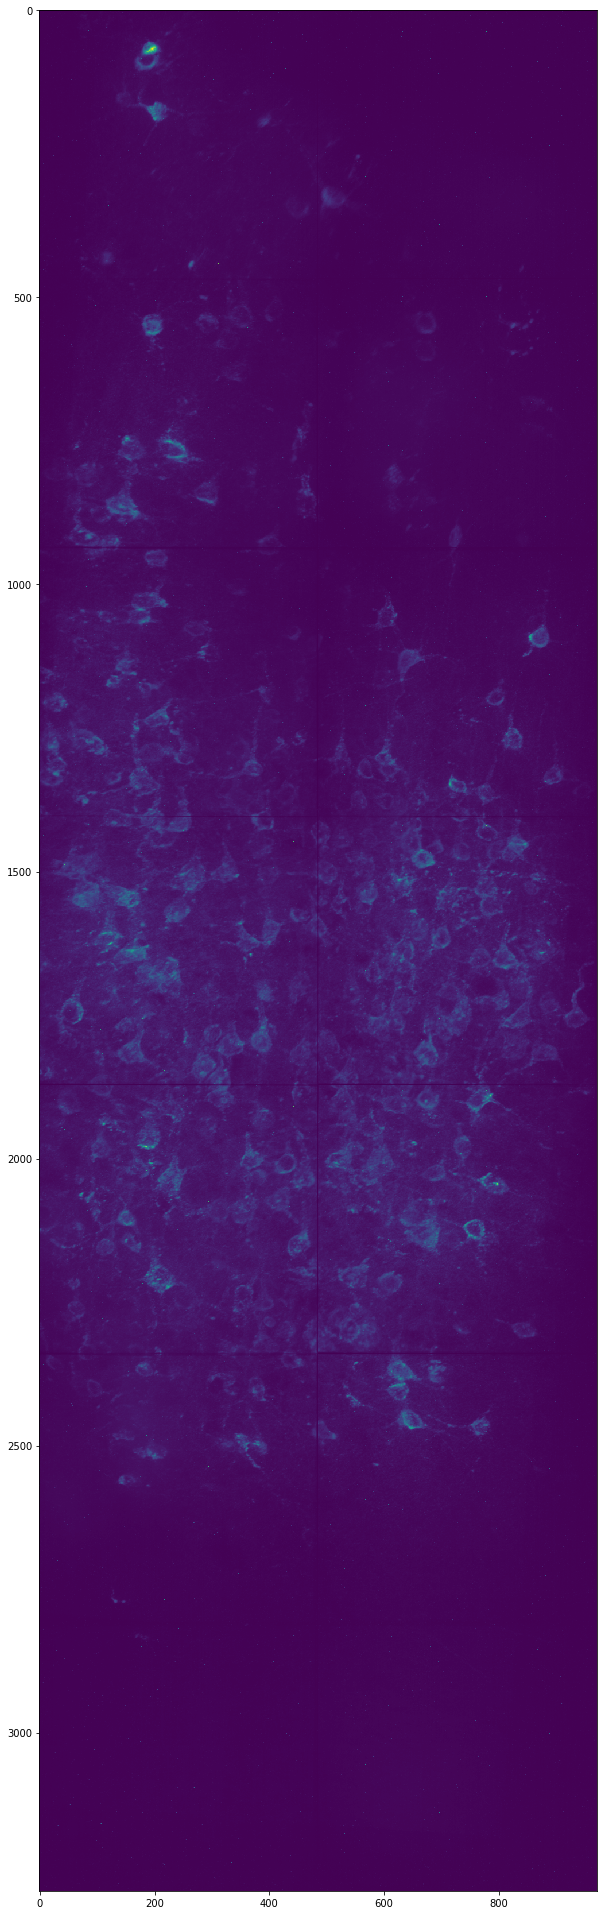

In [859]:
plt.figure(figsize = (10, 35))
plt.imshow(np.sum(full_stitch, (2,3)))

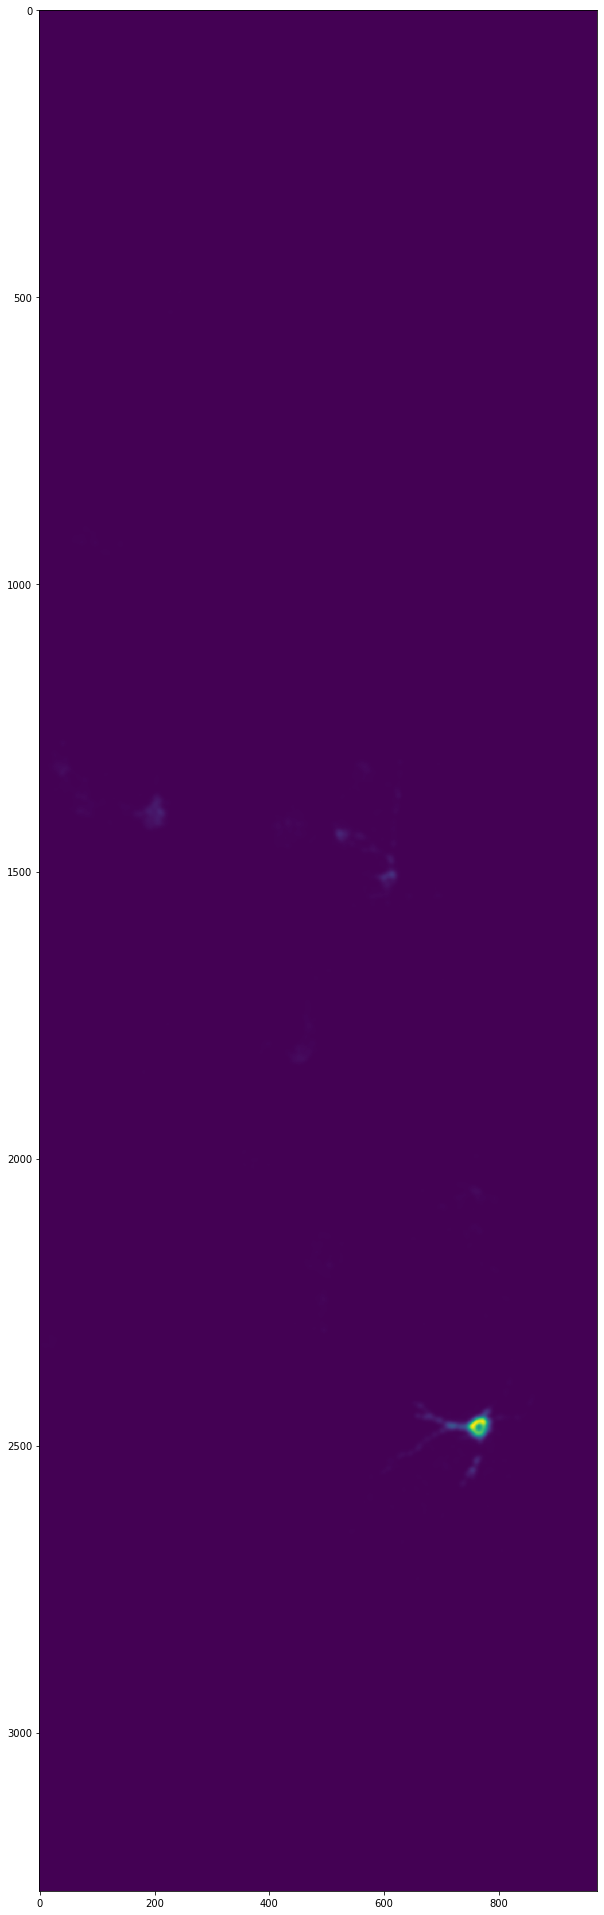

In [856]:
plt.figure(figsize=(10,35))
plt.imshow(np.sum(gaussian_filter(full_stitch_labels == 589, [4, 4, 1], mode = 'constant', output = 'double'), (2)))

In [ ]:
idx_colors = color.label2rgb(final_idx)

labels2 = np.max(full_stitch_labels, 2)
col_labels = color.label2rgb(labels2, bg_label = 0)
match = np.max(full_stitch_labels == idx, 2)
sub_labels = col_labels
sub_labels[~match, :] = 0
sub_labels[match, :] = idx_colors[np.where(final_idx == idx)[0][0]]
plt.figure(figsize=(25,70))
plt.imshow(sub_labels)
plt.savefig('fullstitch/'+str(idx)+'_fullstitch_components.pdf')

<ipython-input-817-c519f573581e>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(25,70))
<ipython-input-817-c519f573581e>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(25,70))
<ipython-input-817-c519f573581e>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(

<ipython-input-817-c519f573581e>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(25,70))
<ipython-input-817-c519f573581e>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(25,70))
<ipython-input-817-c519f573581e>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(

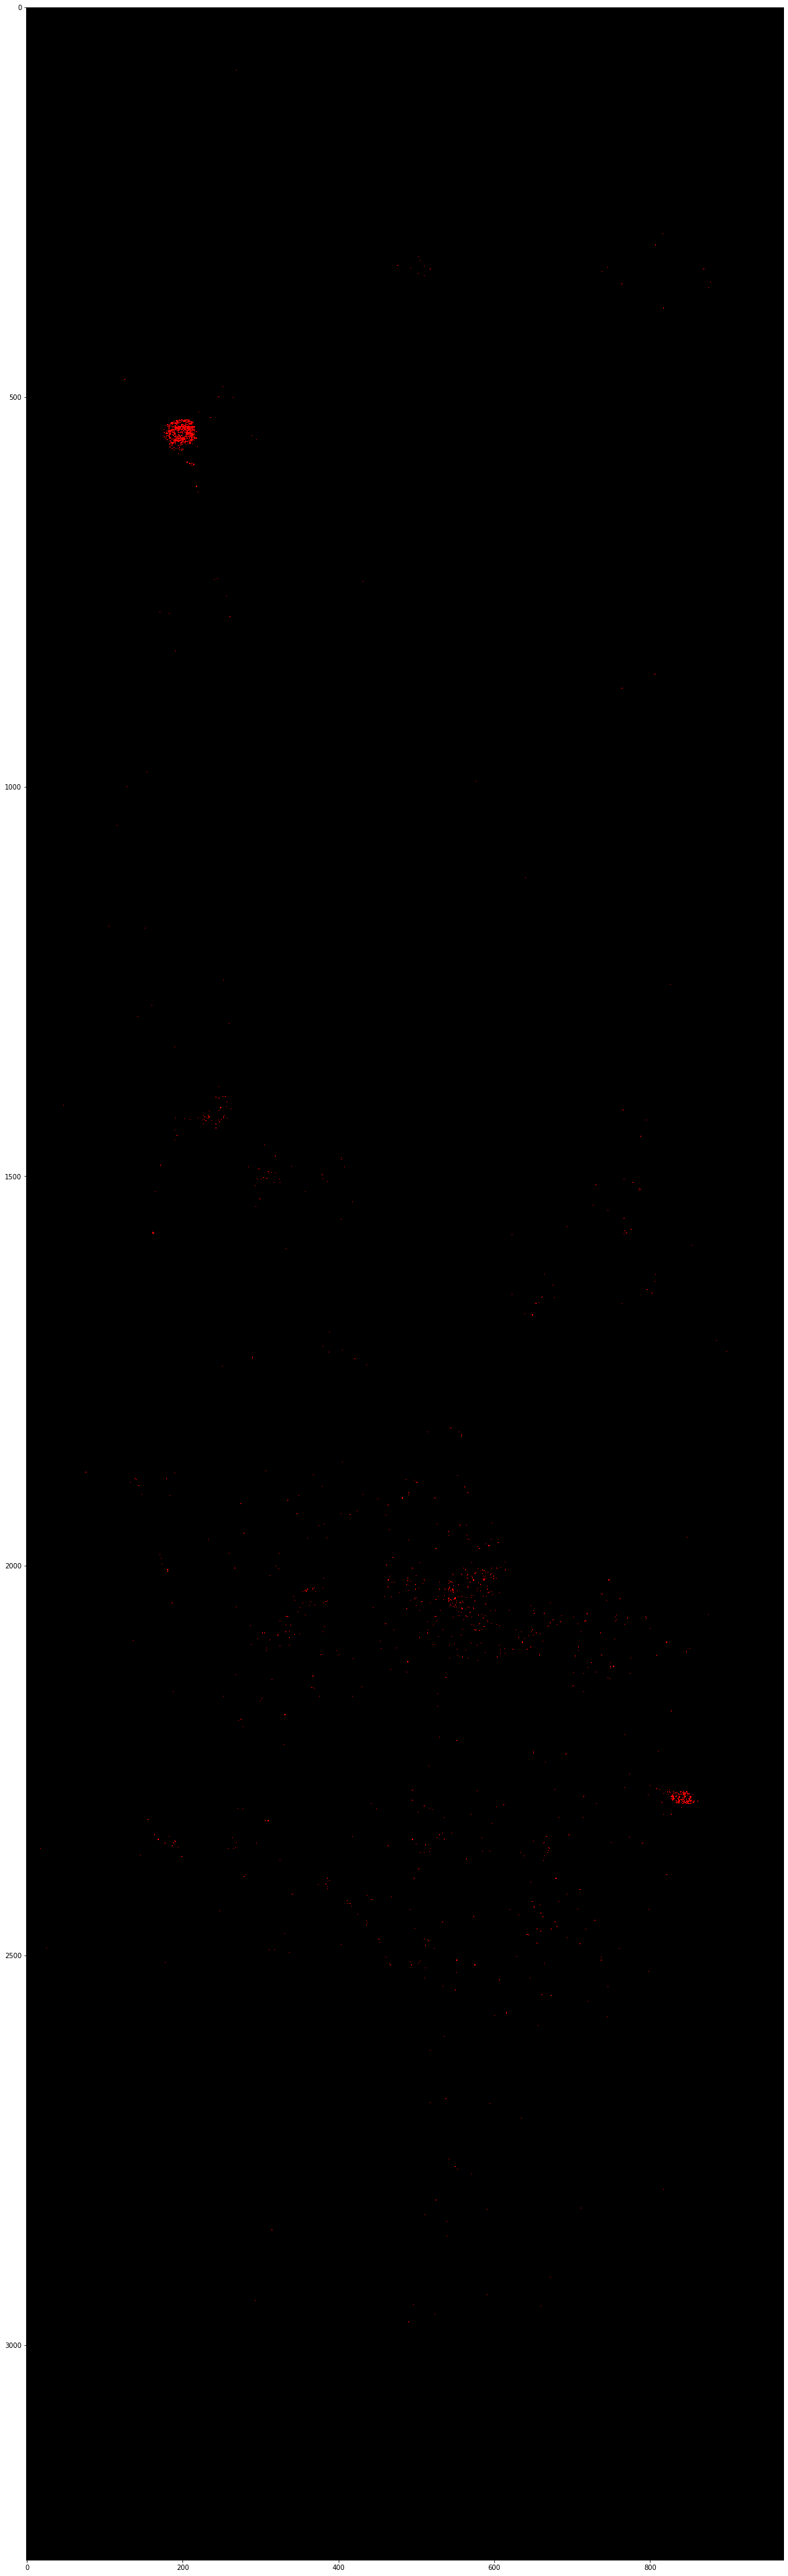

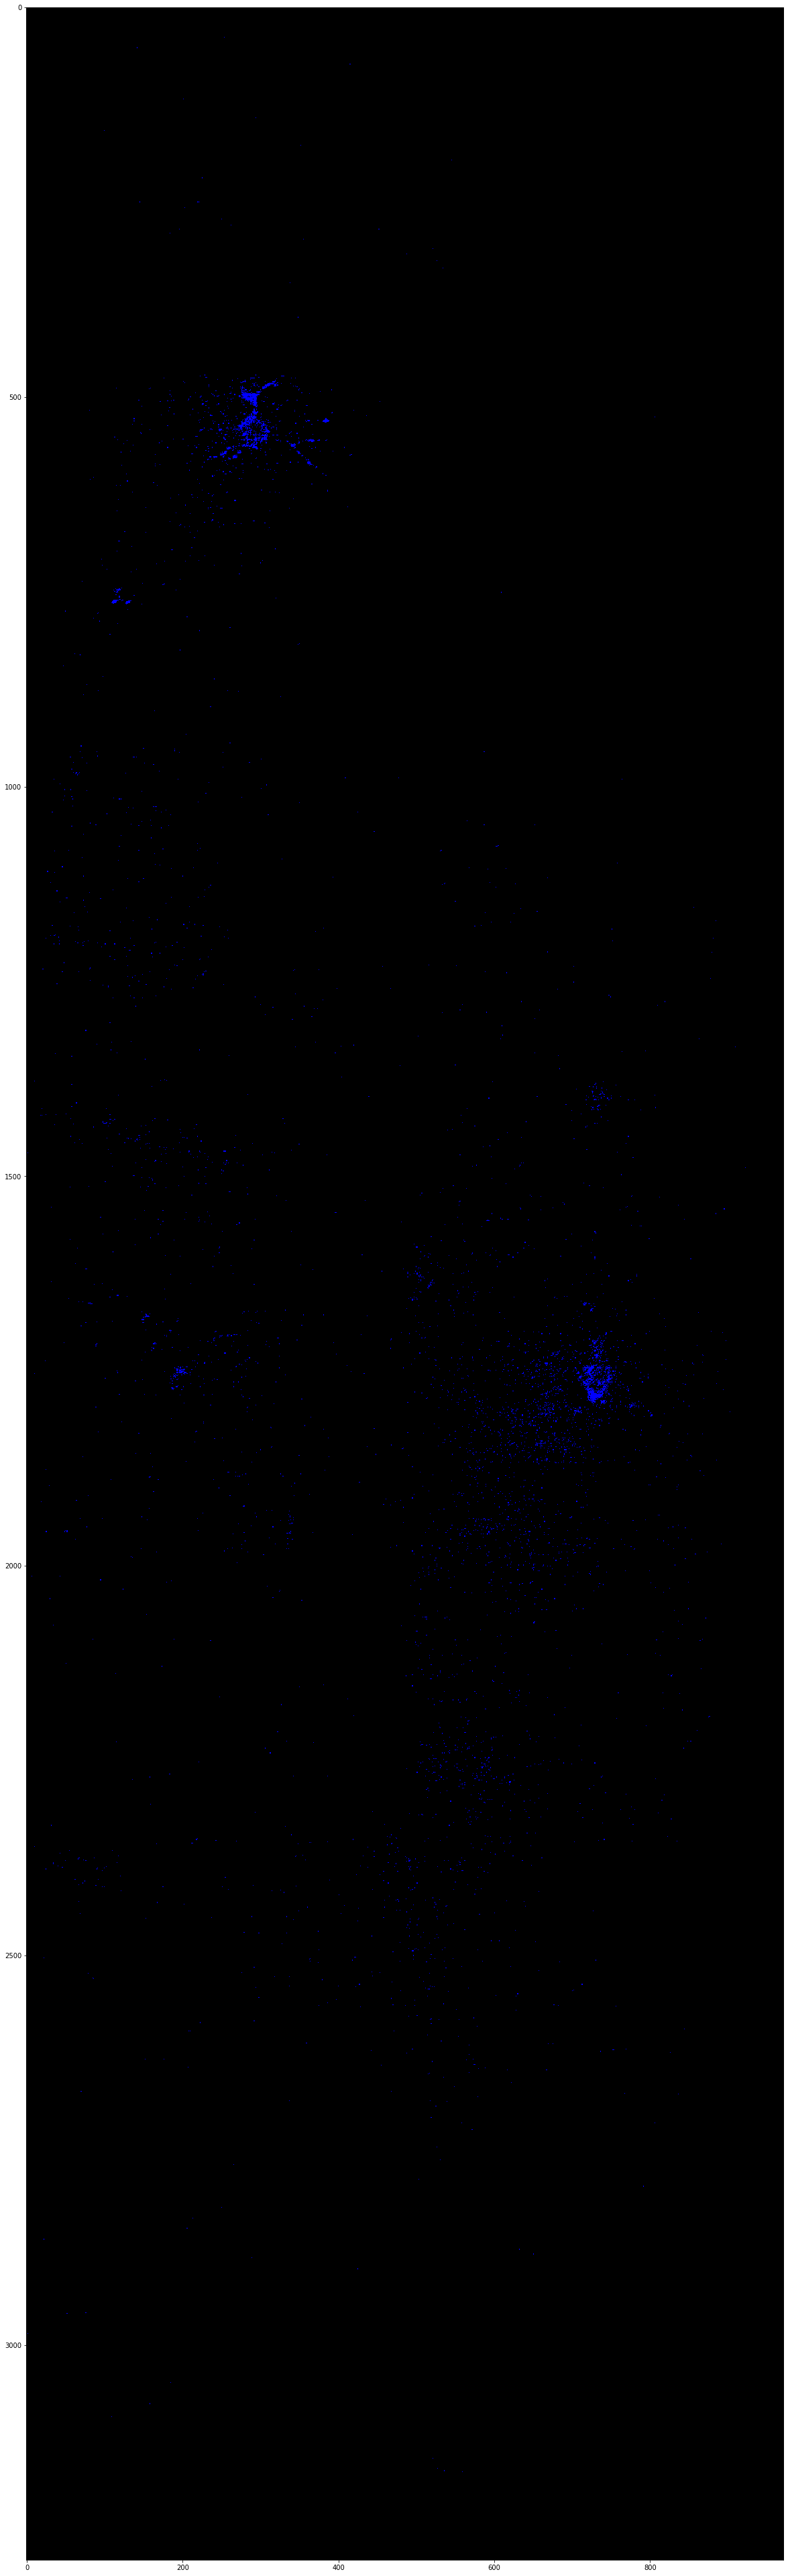

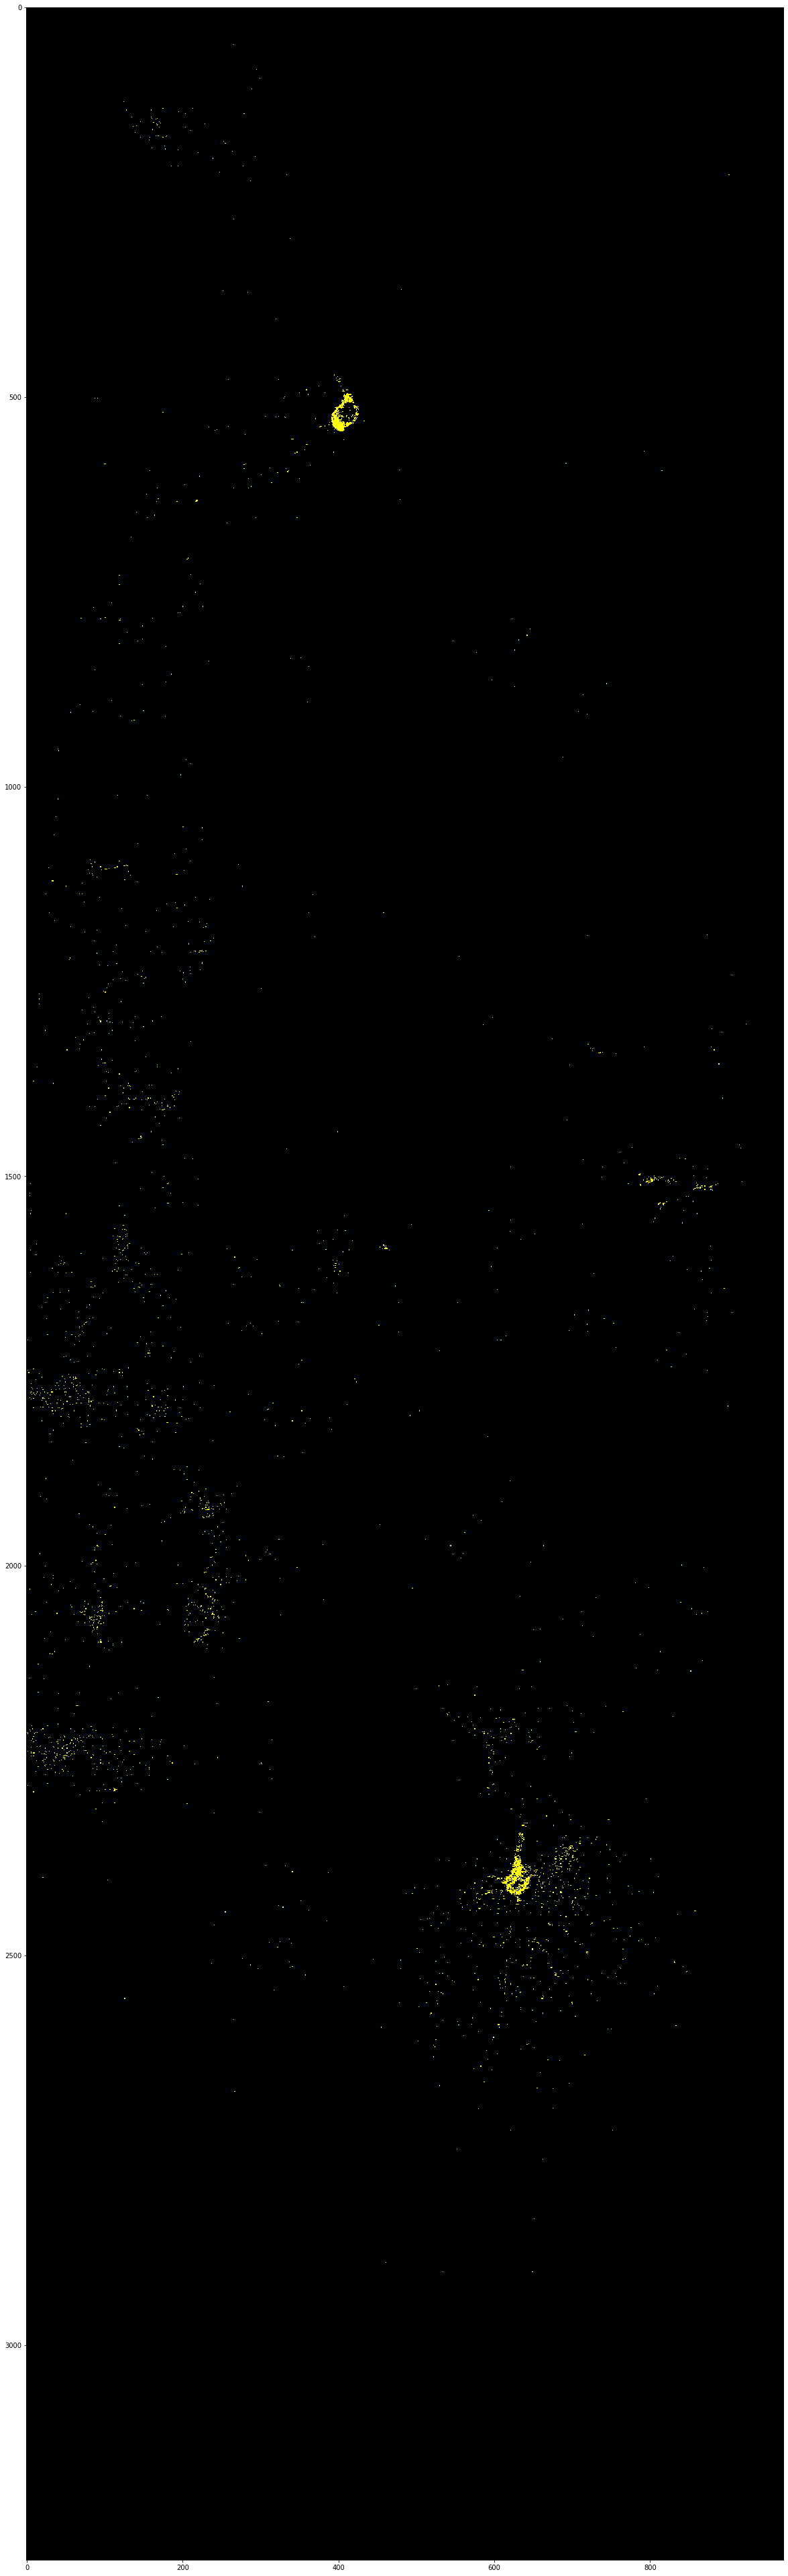

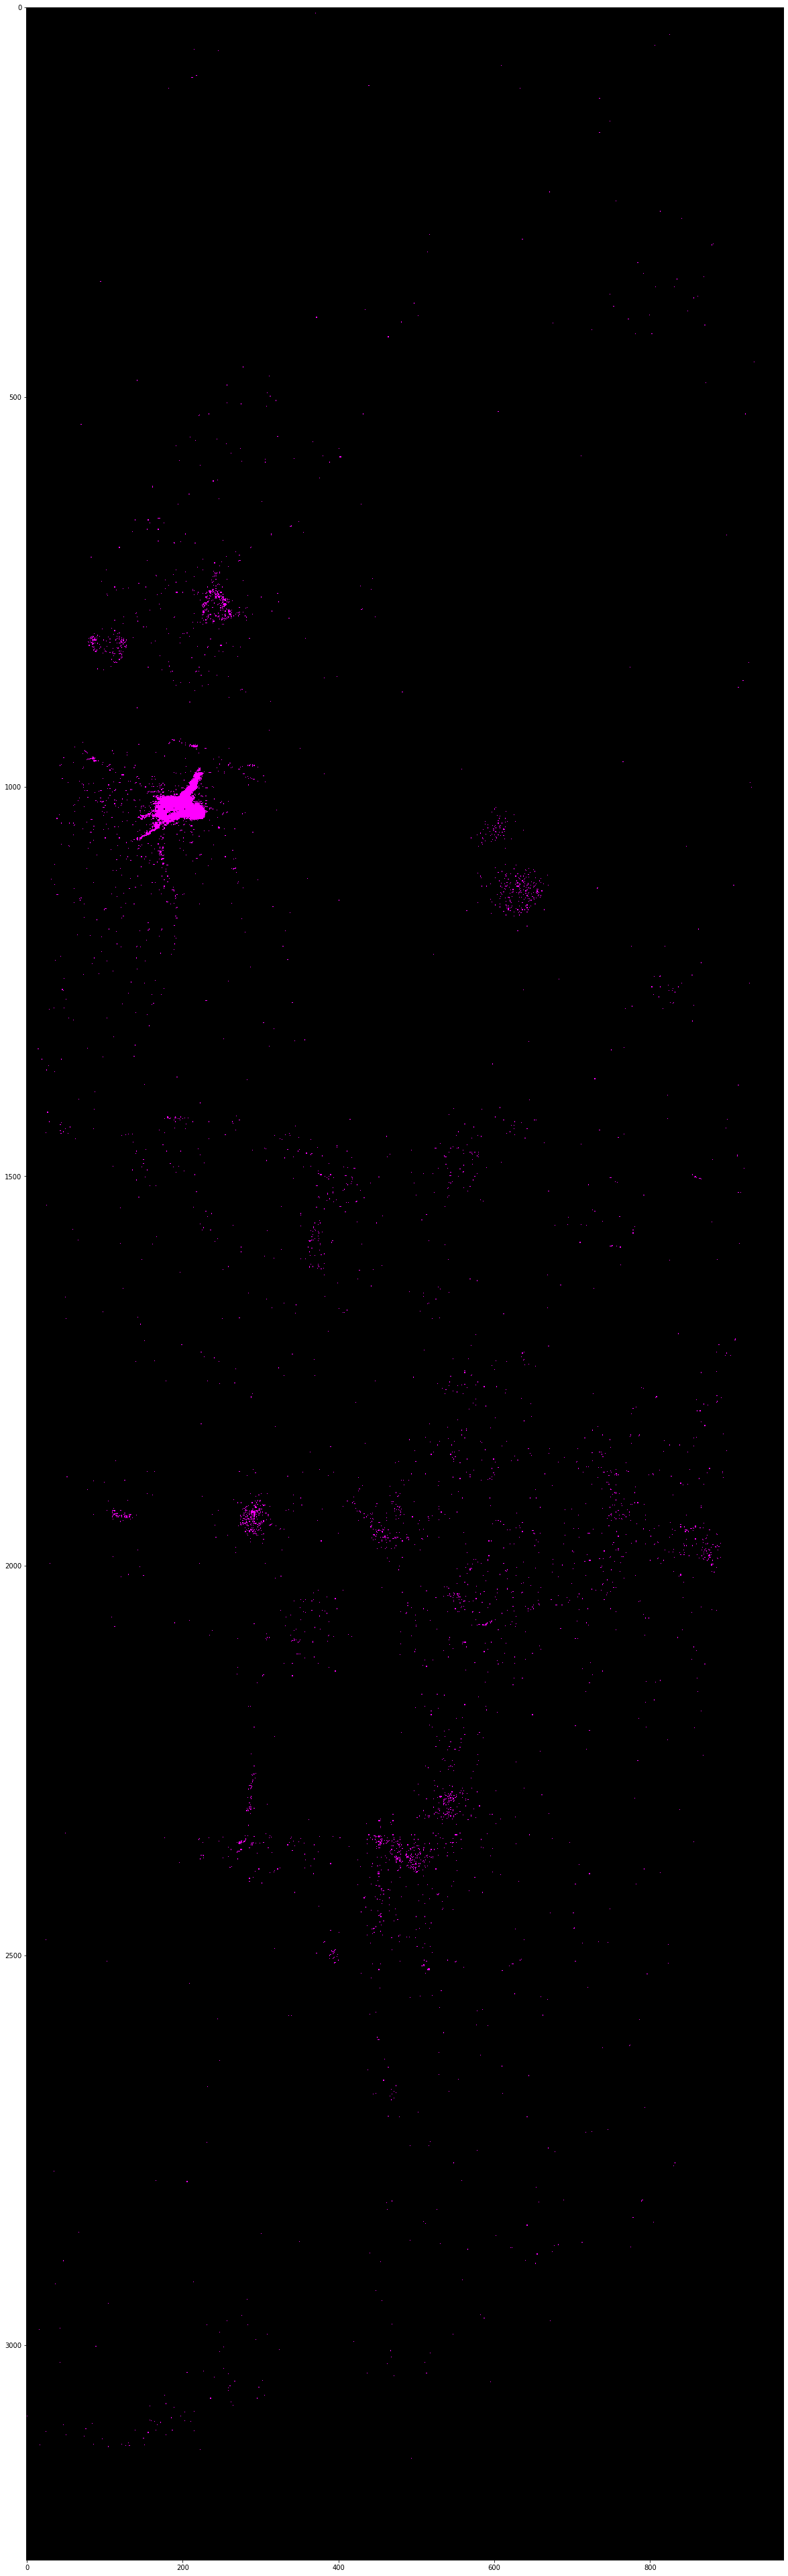

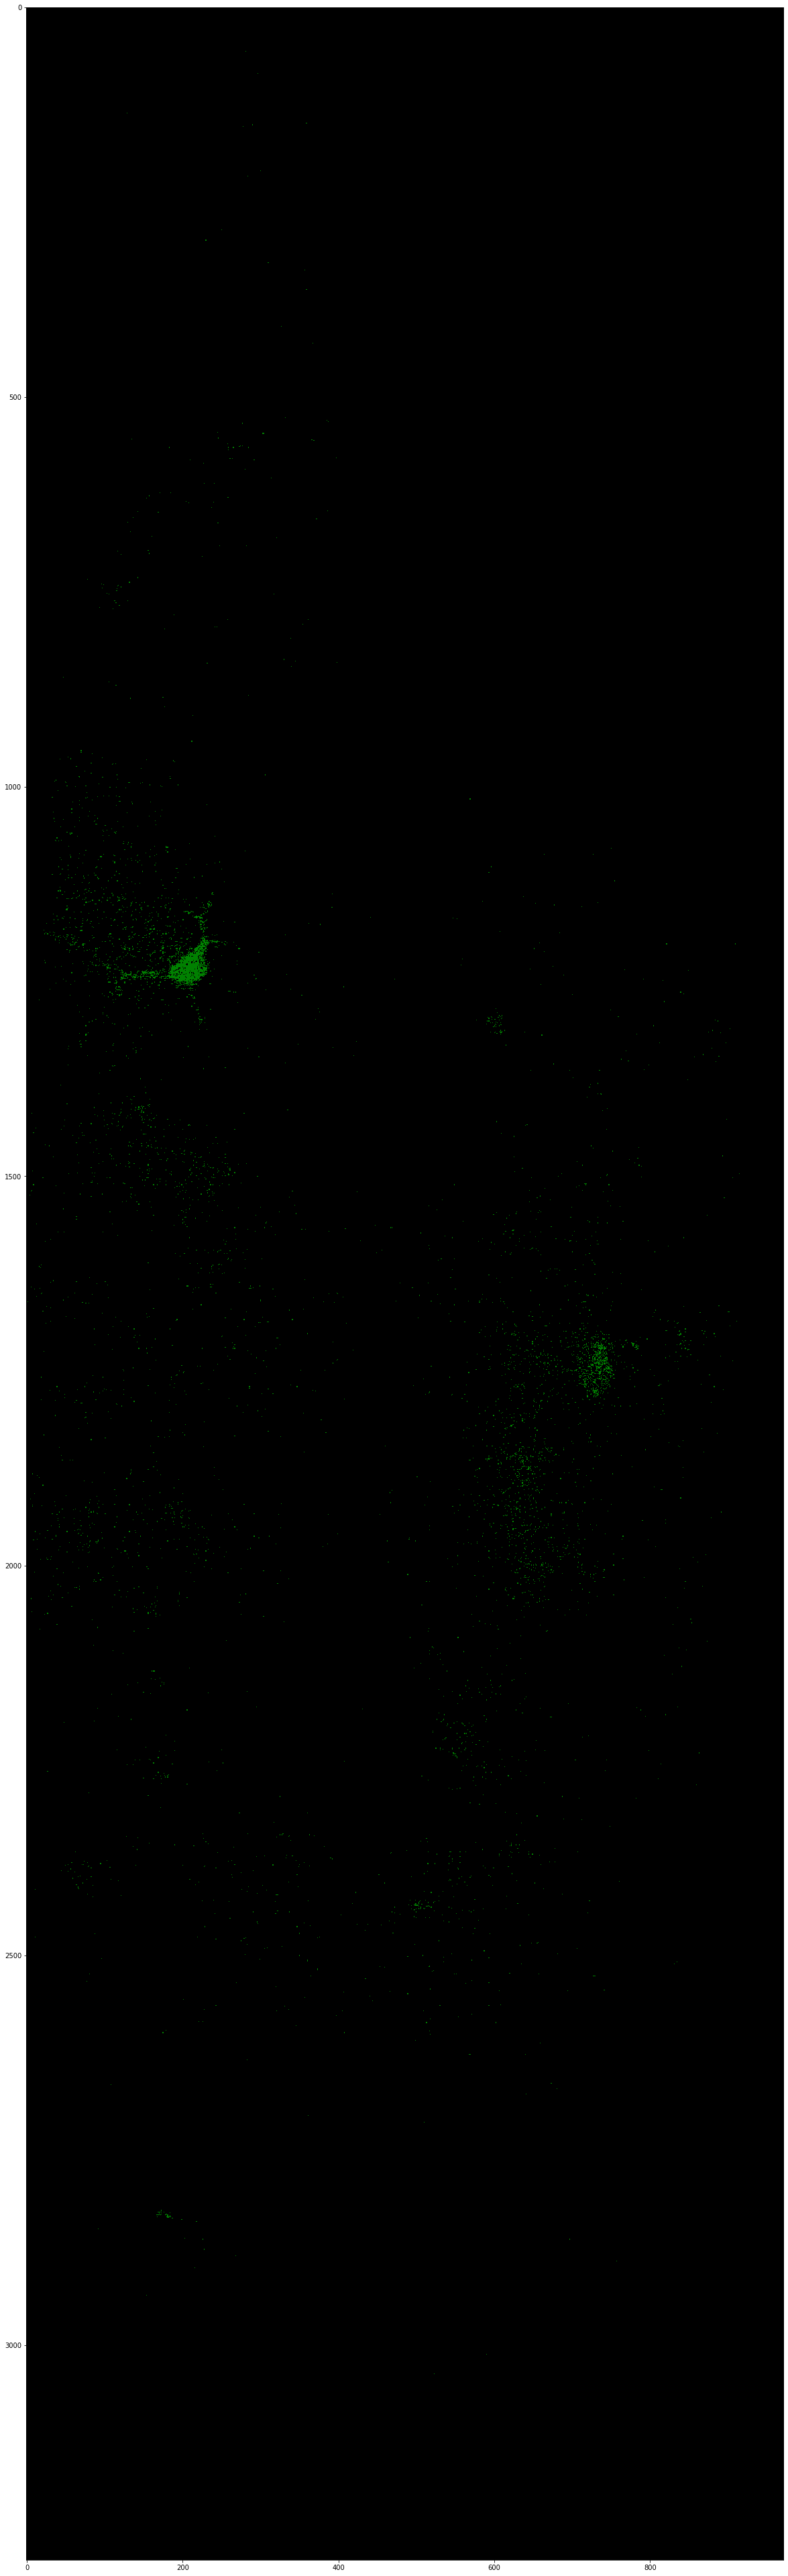

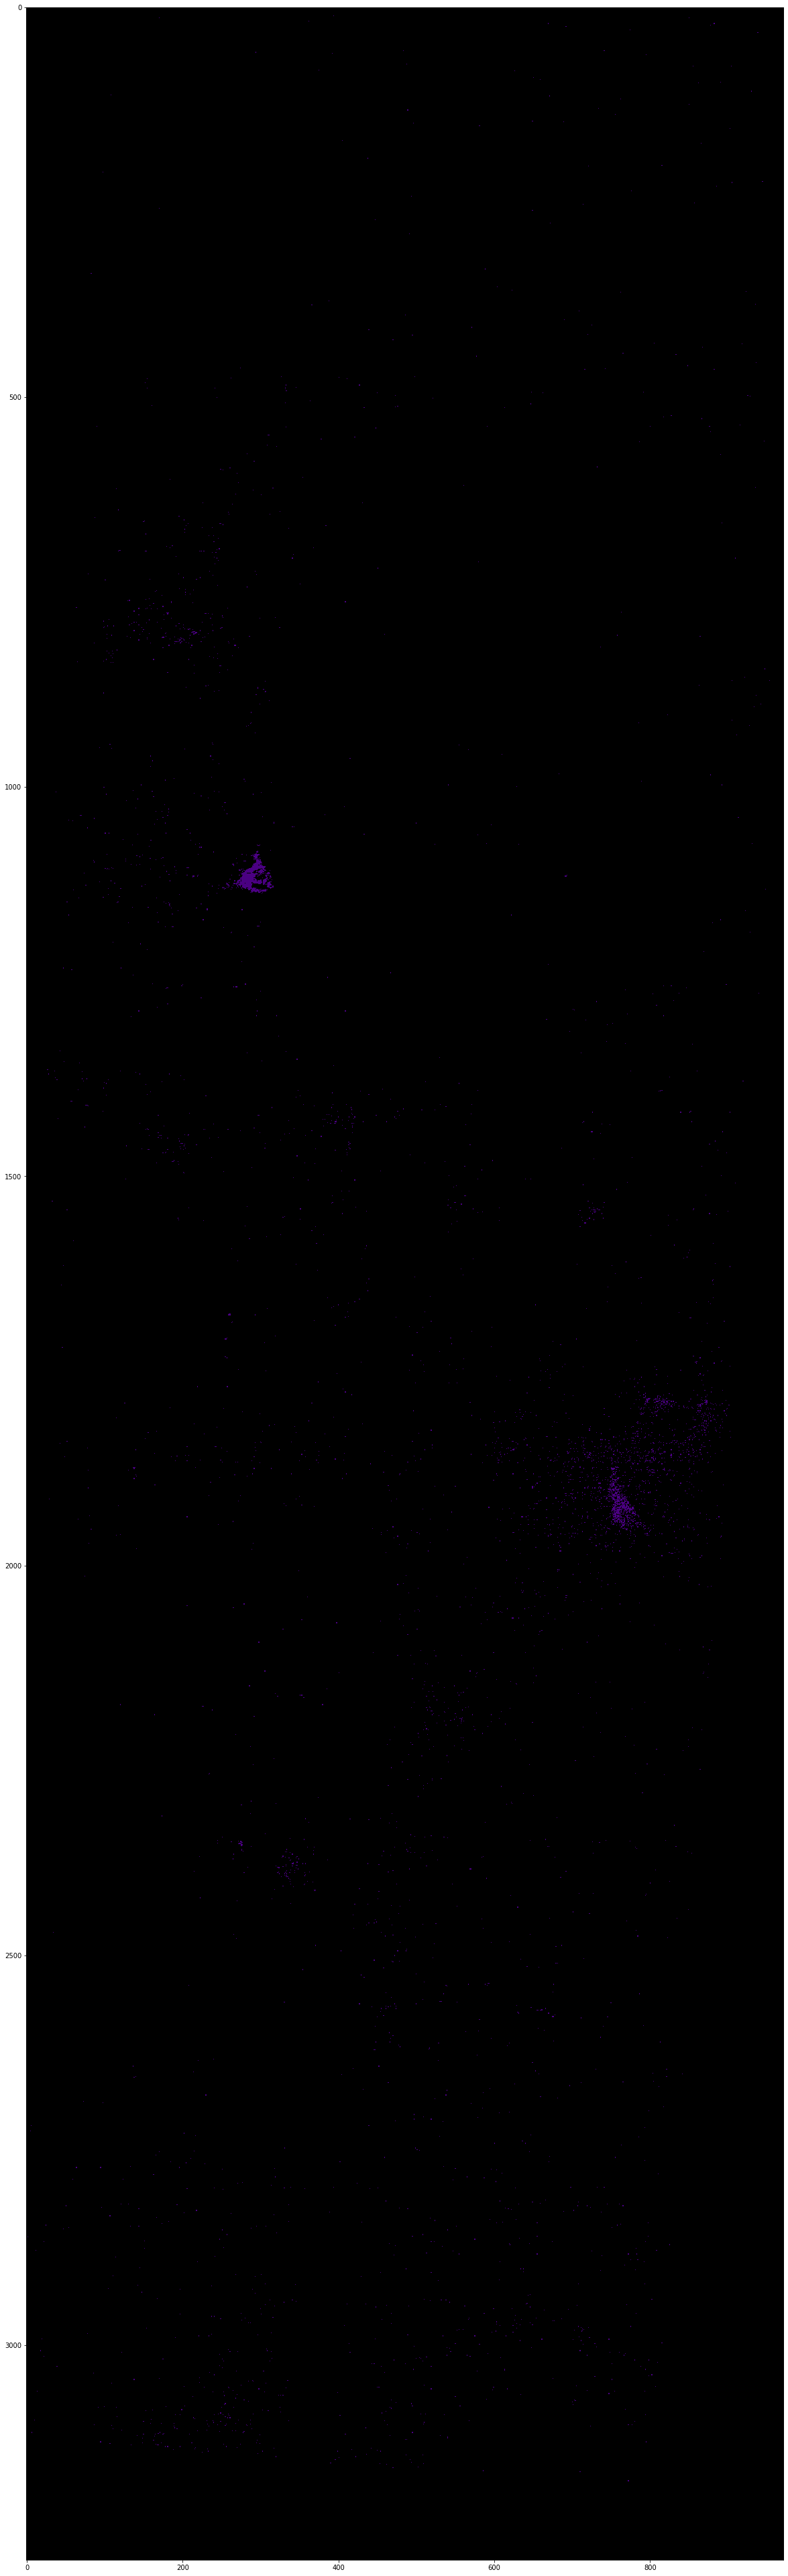

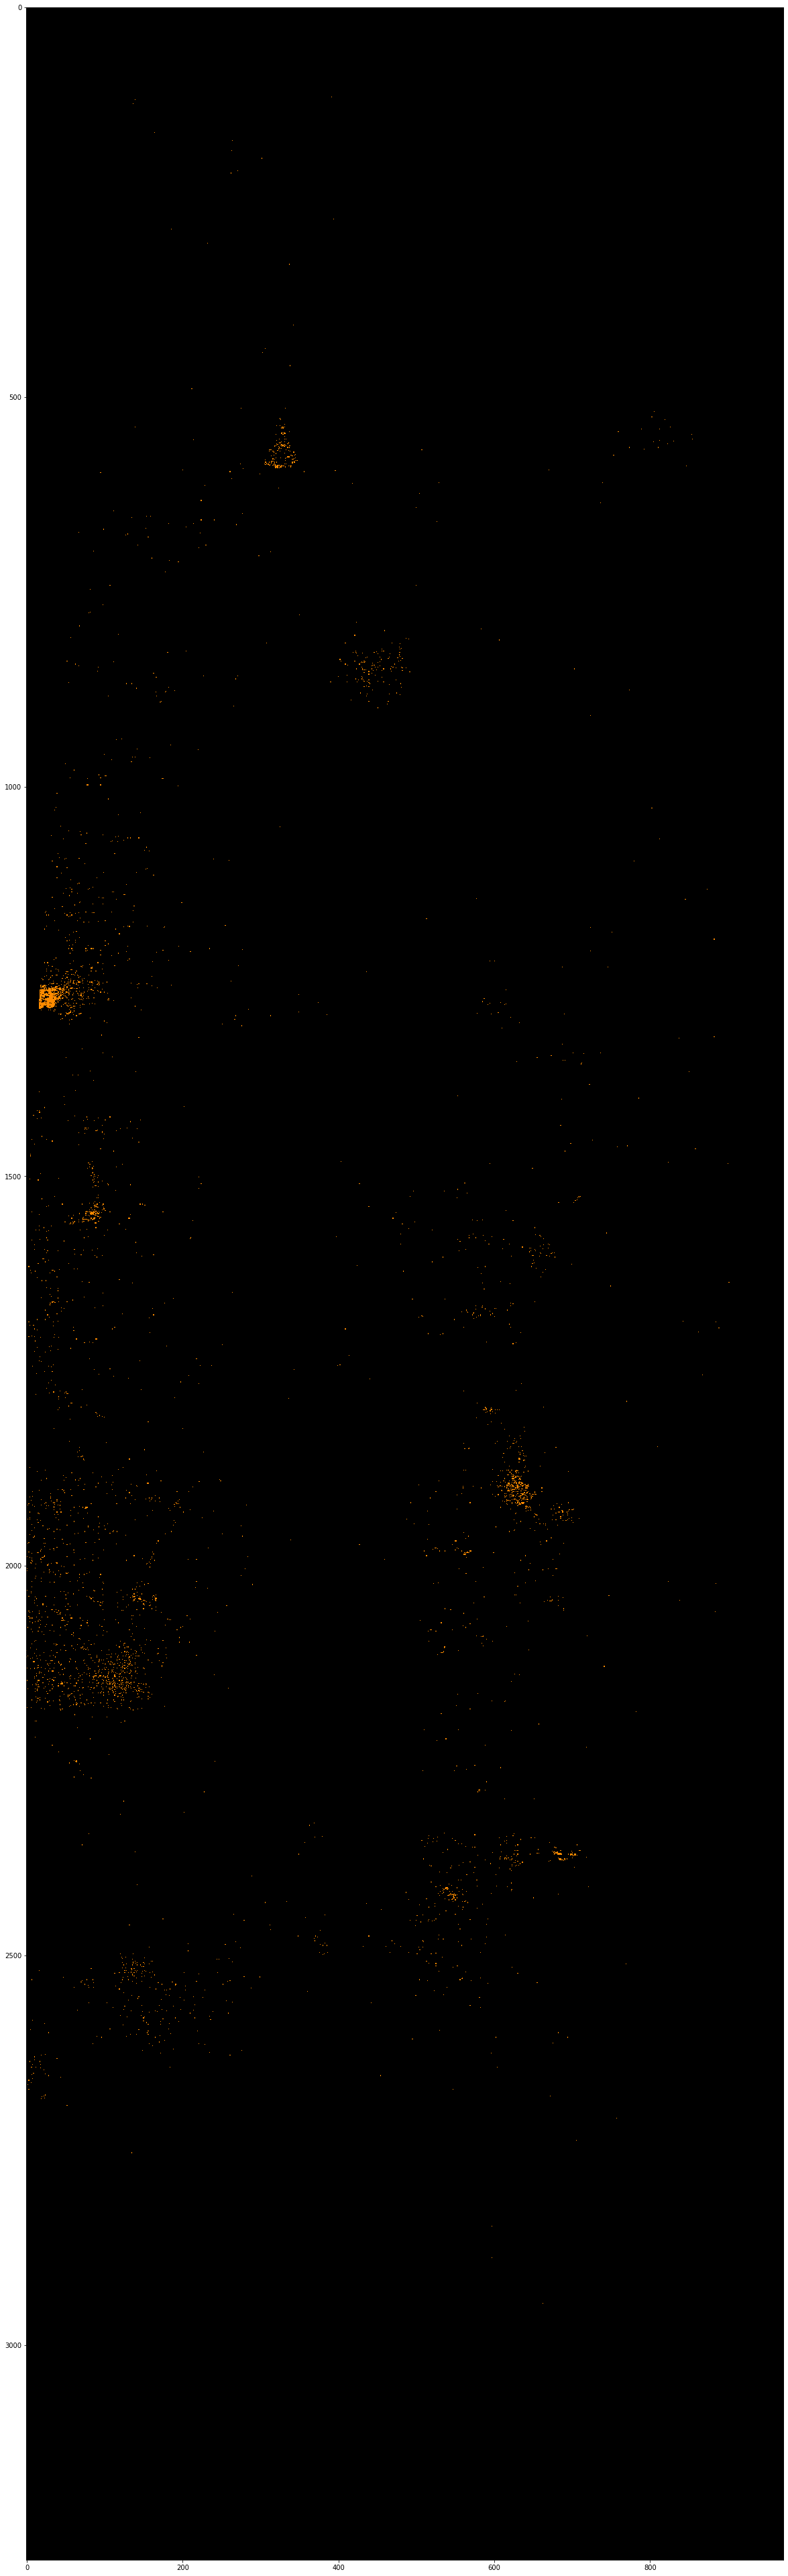

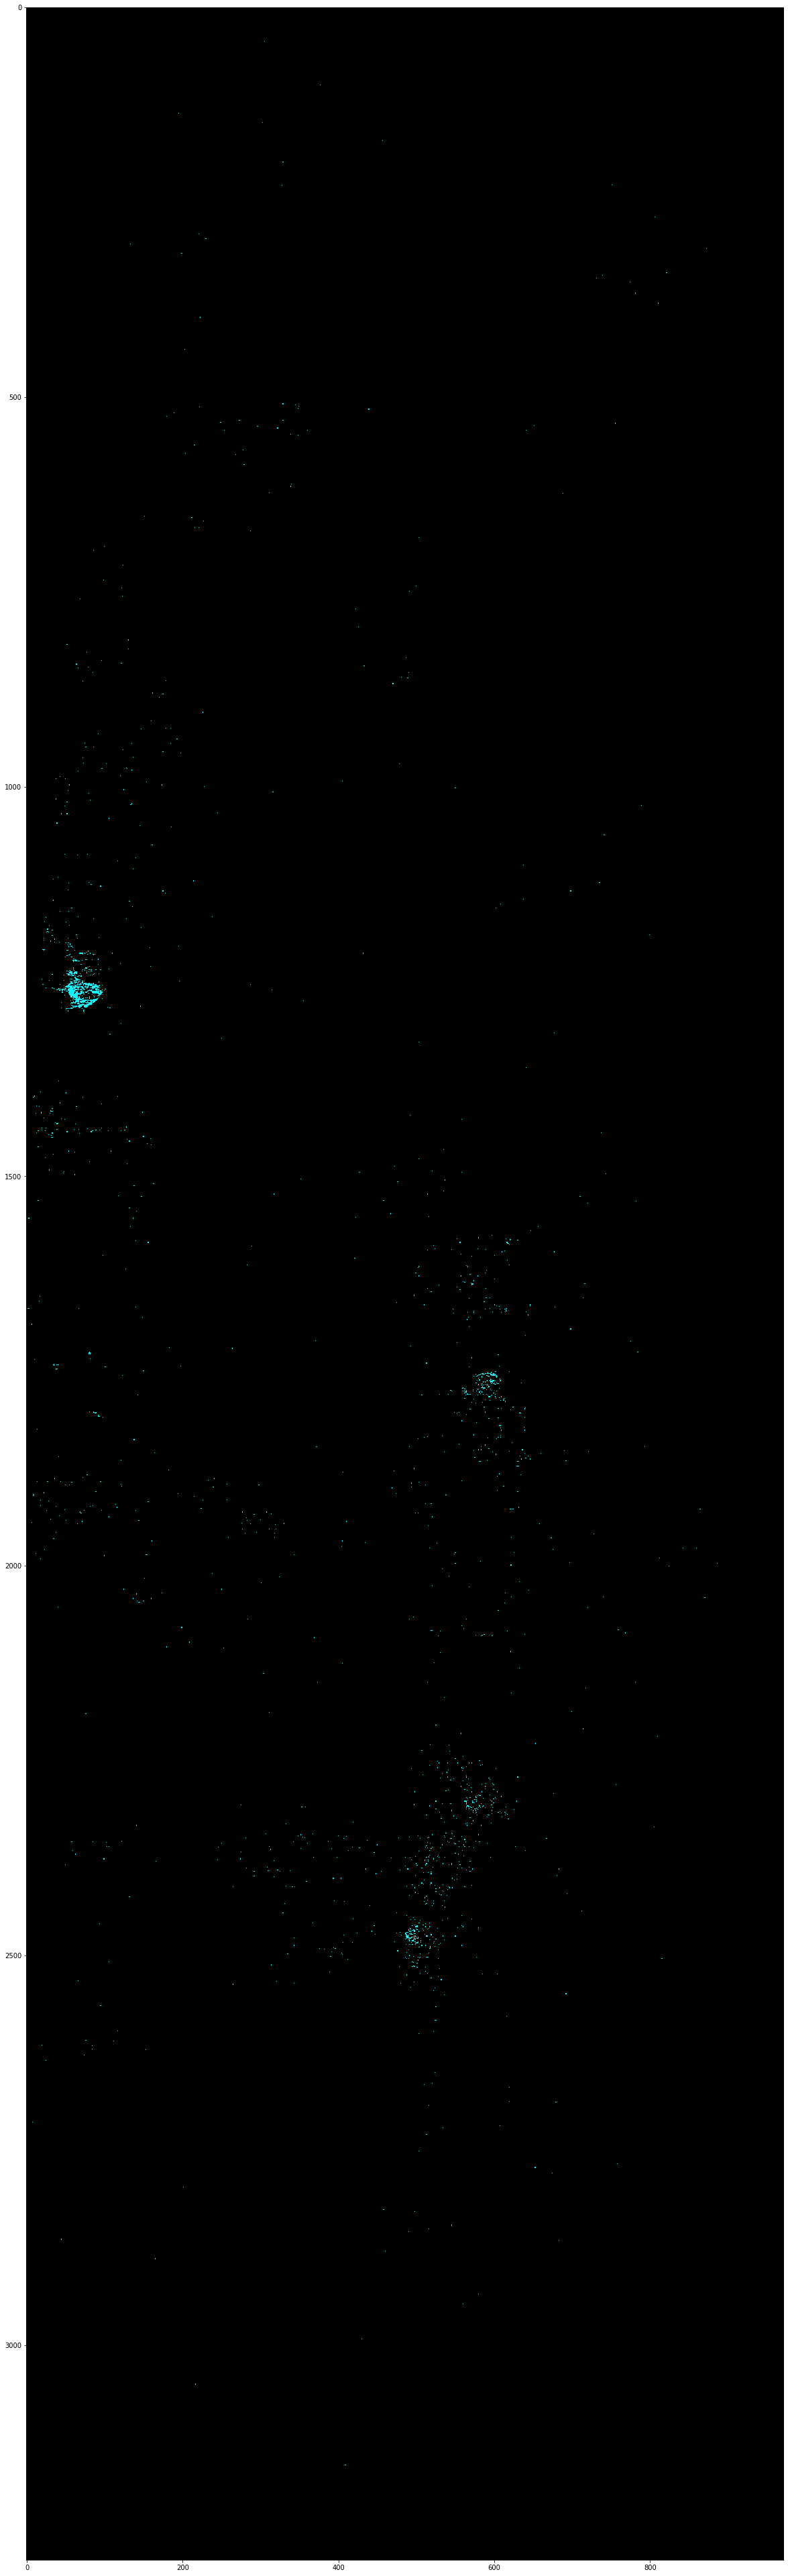

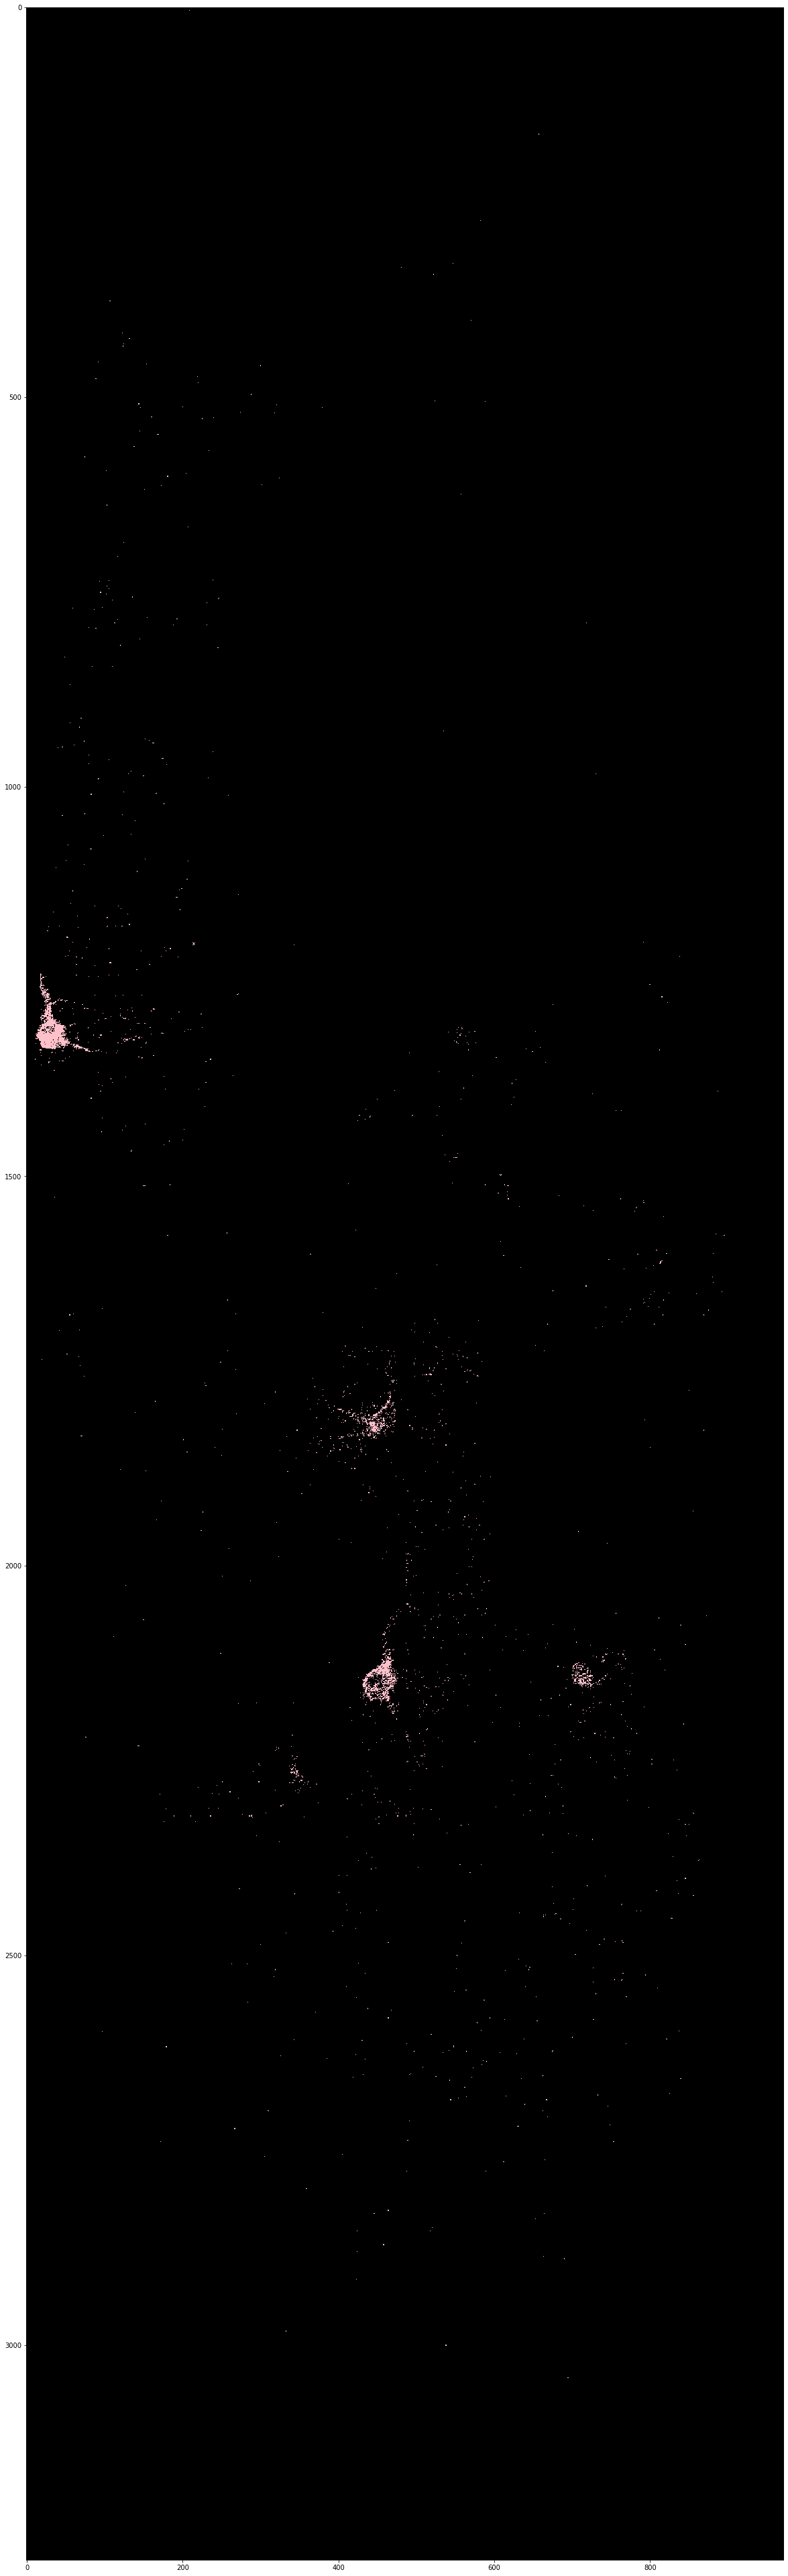

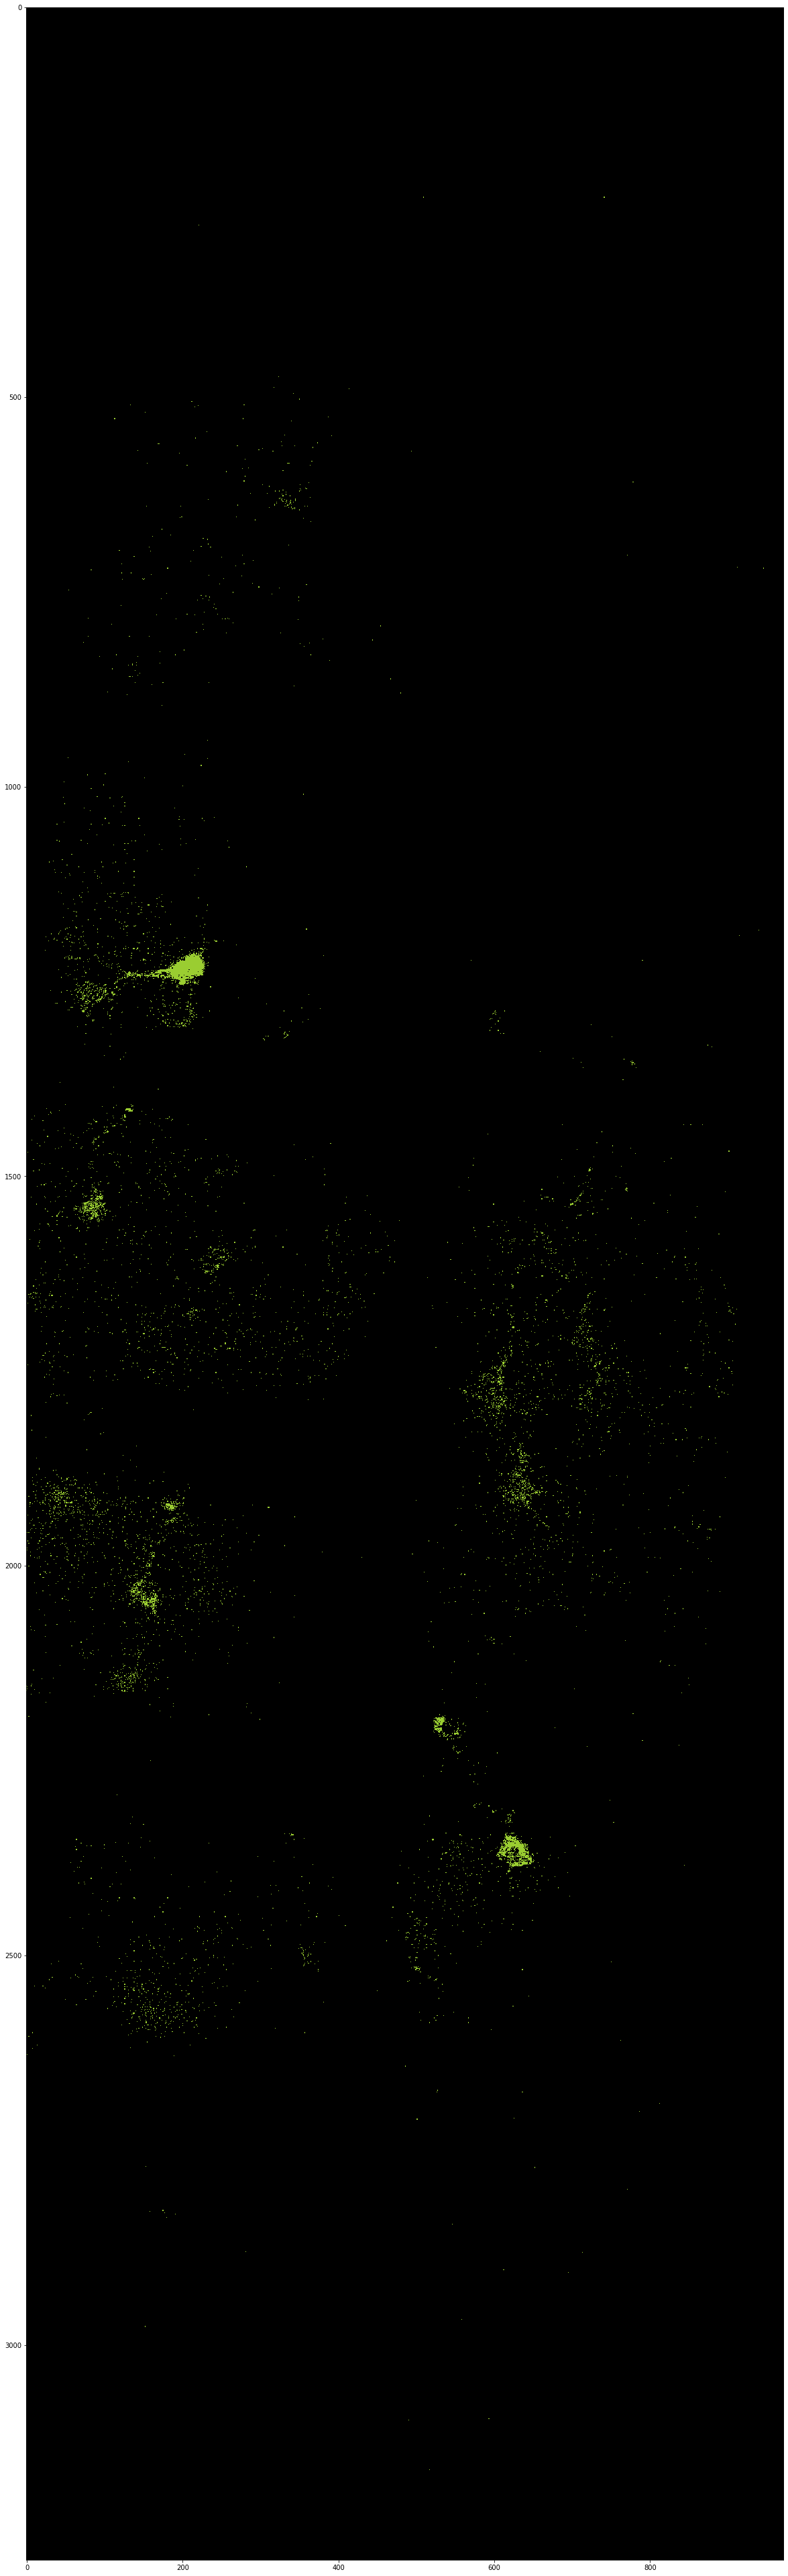

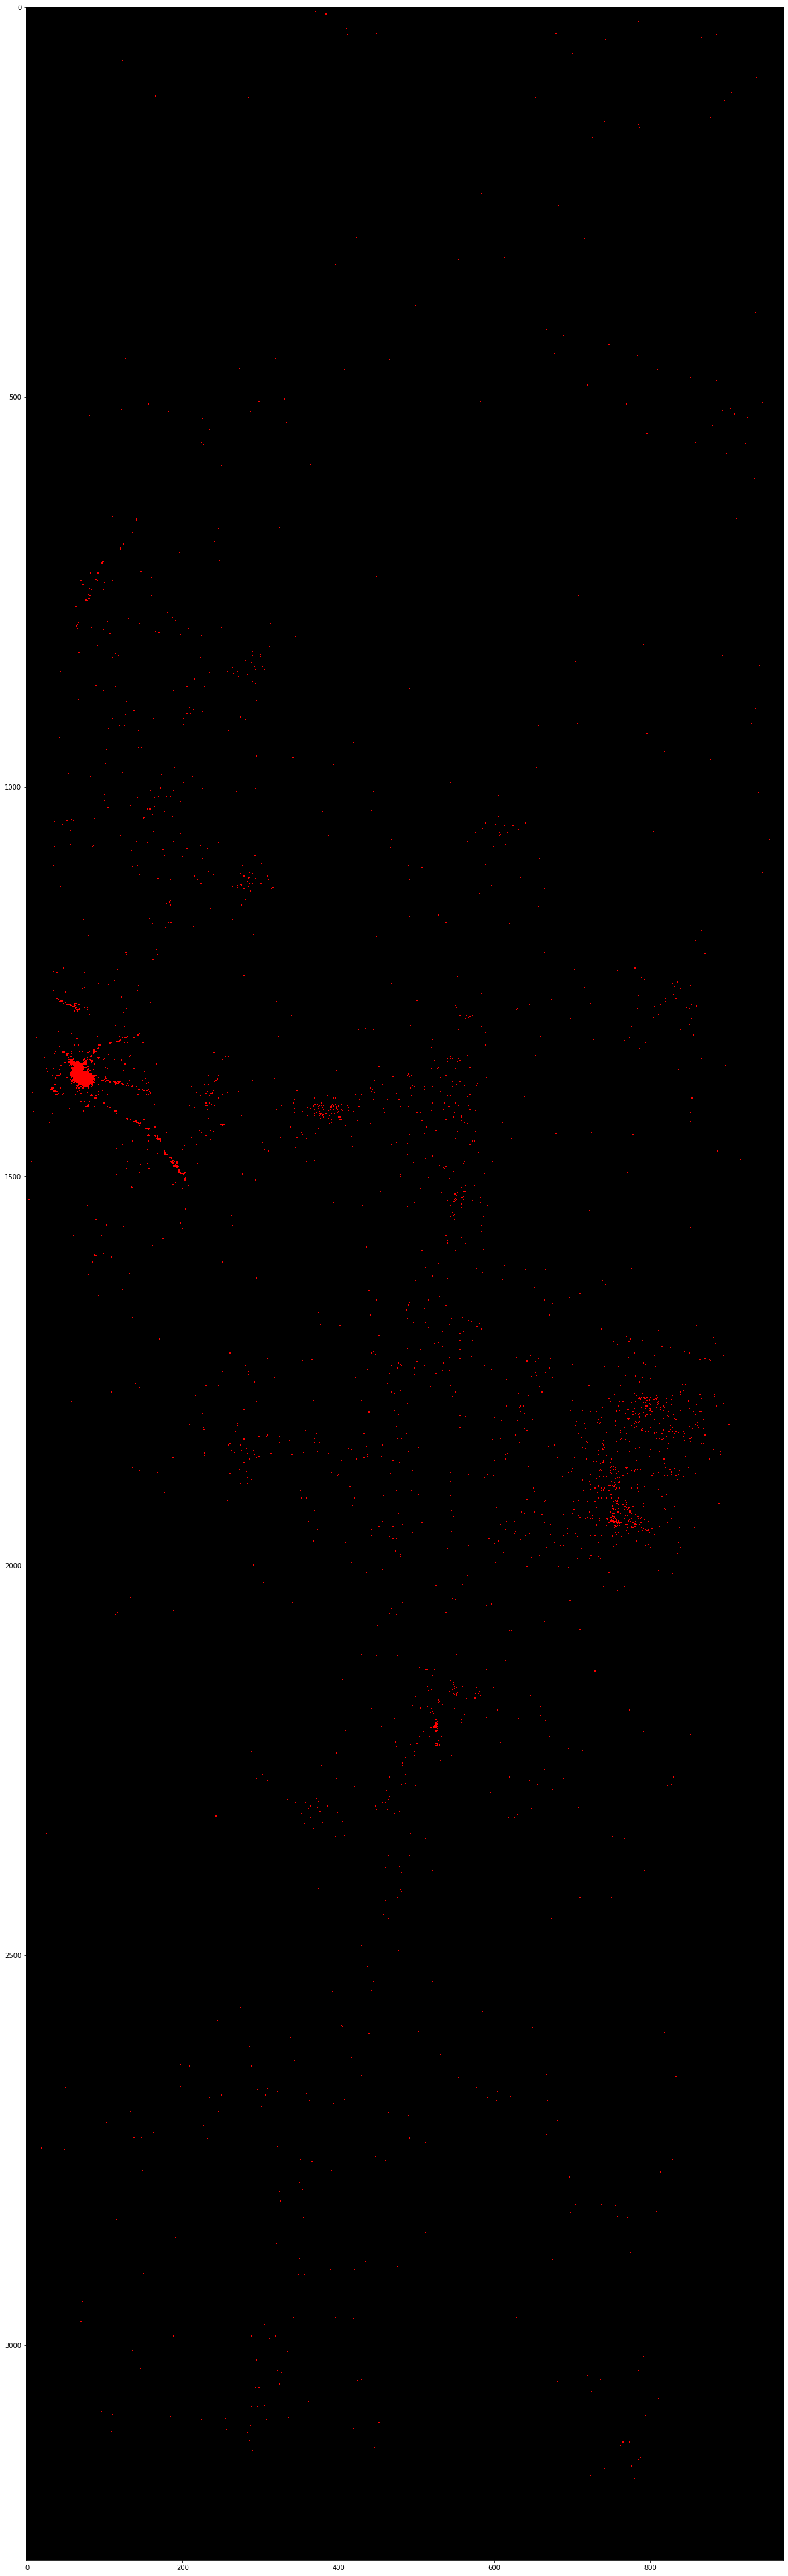

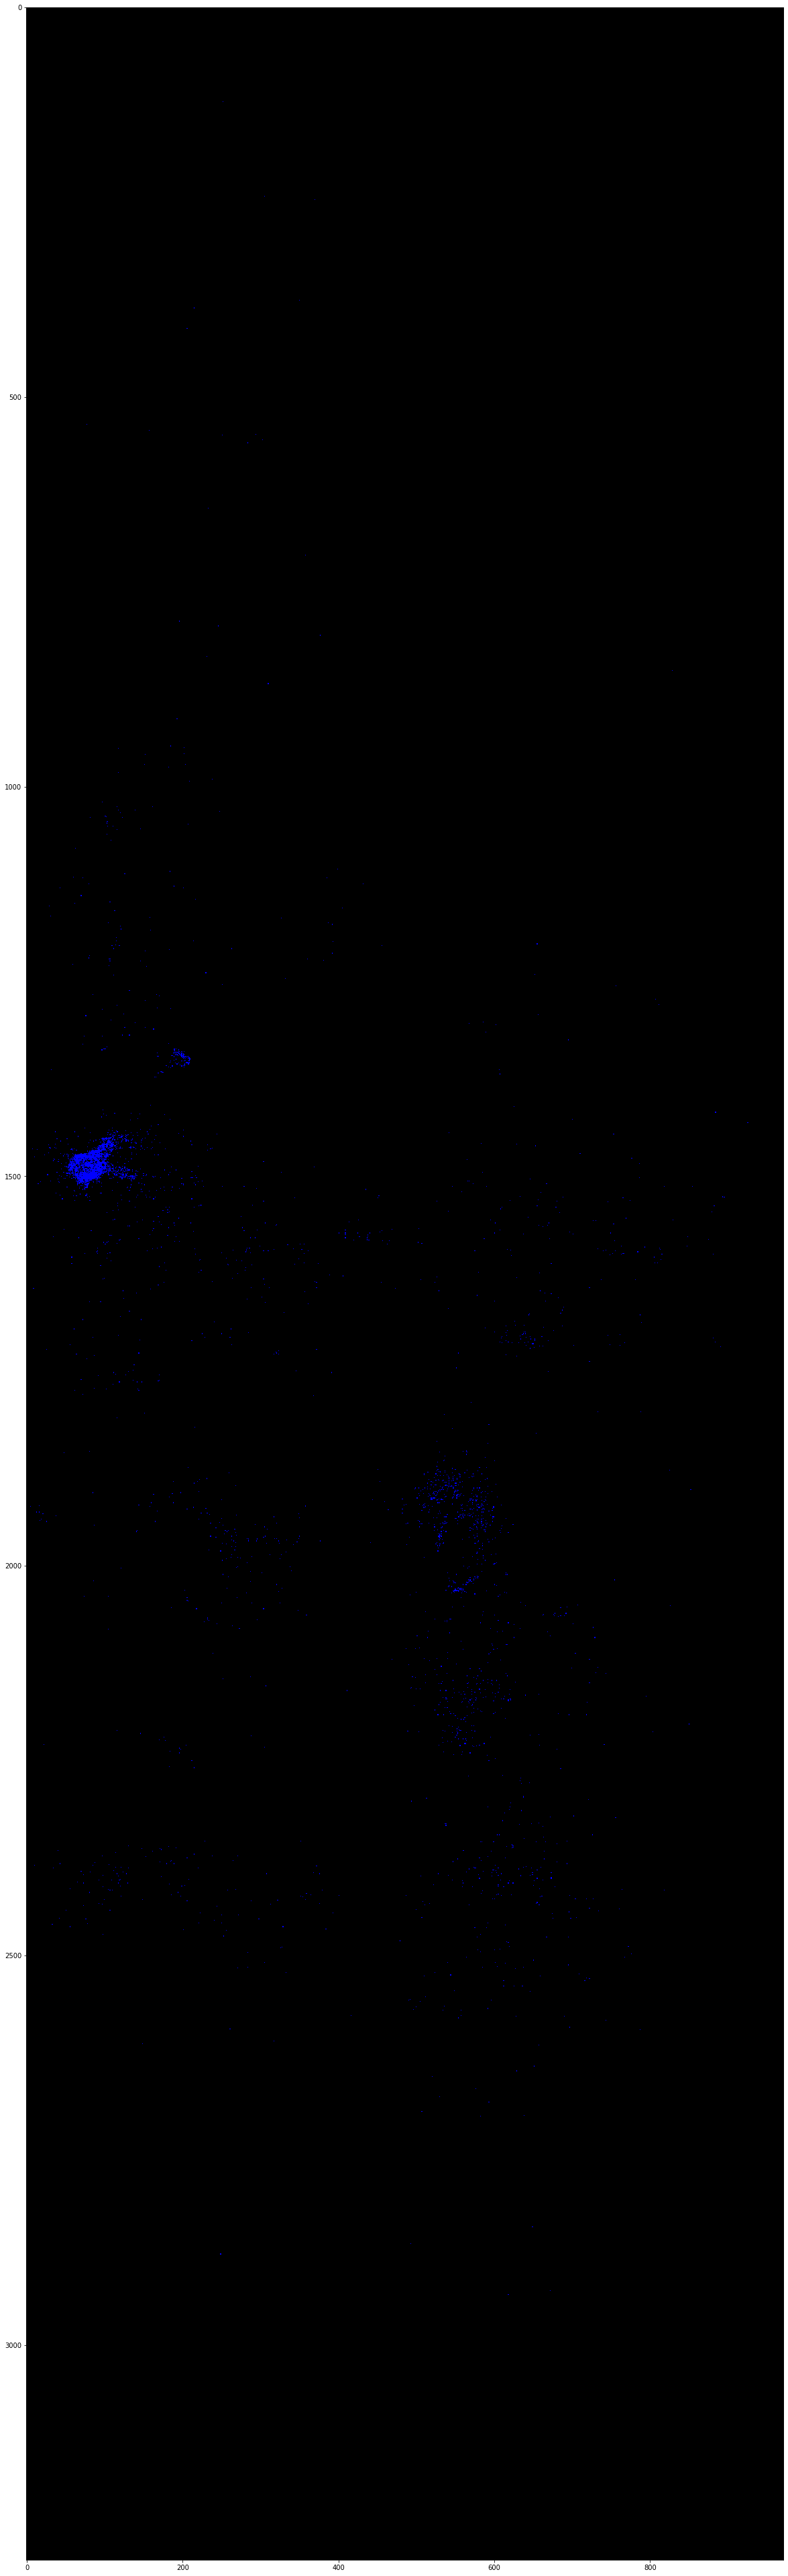

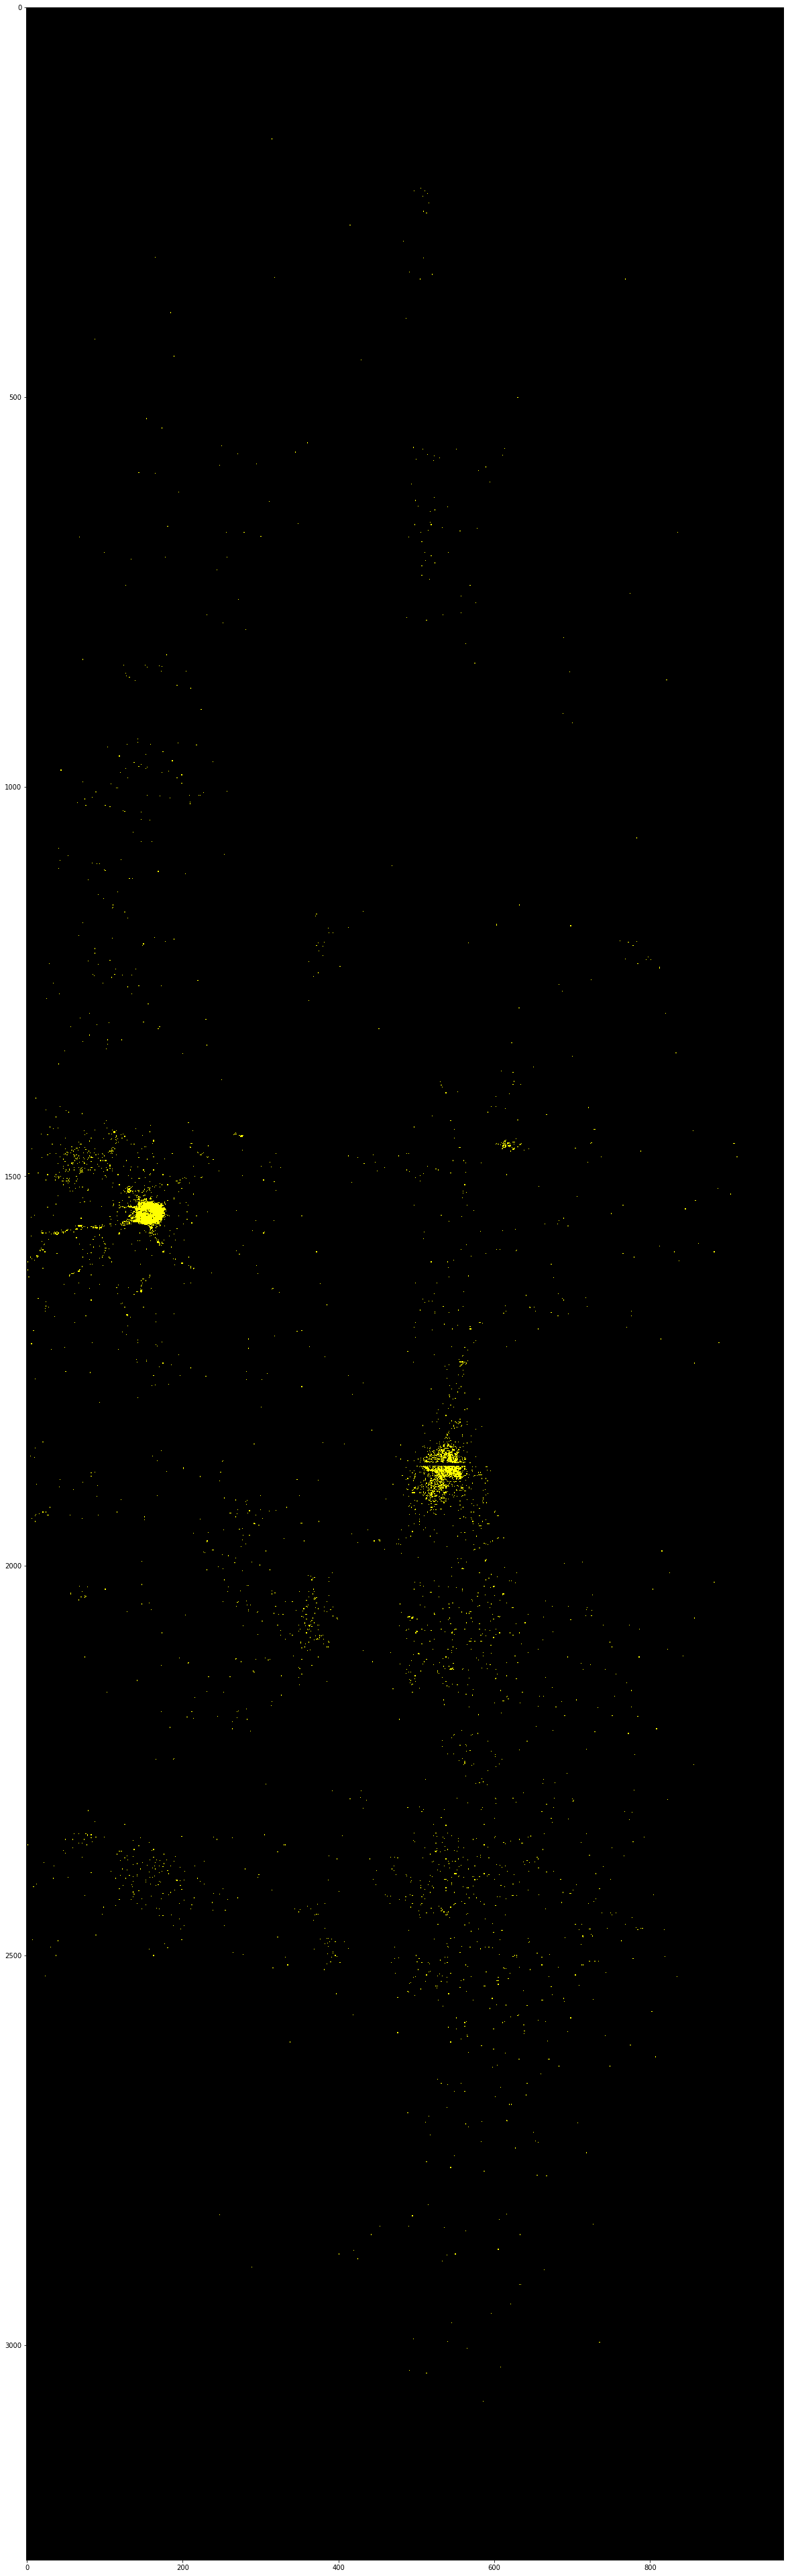

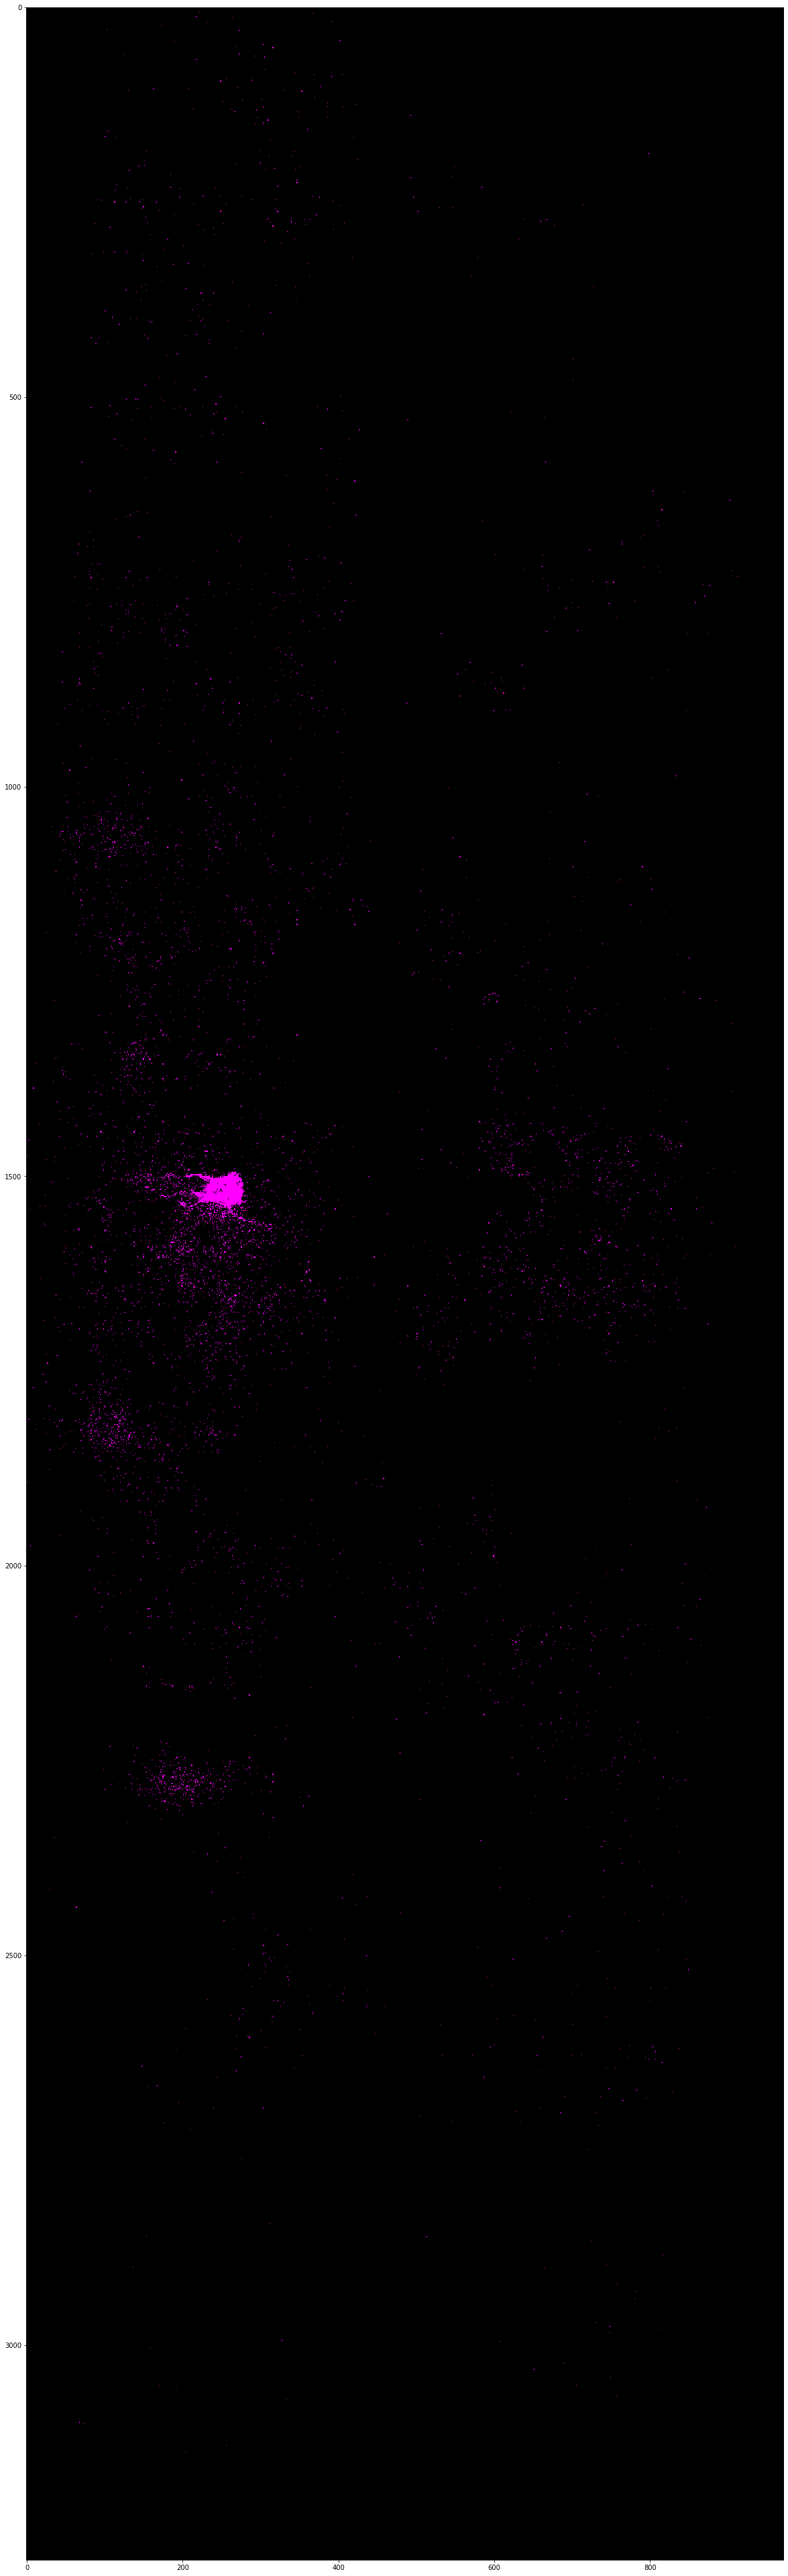

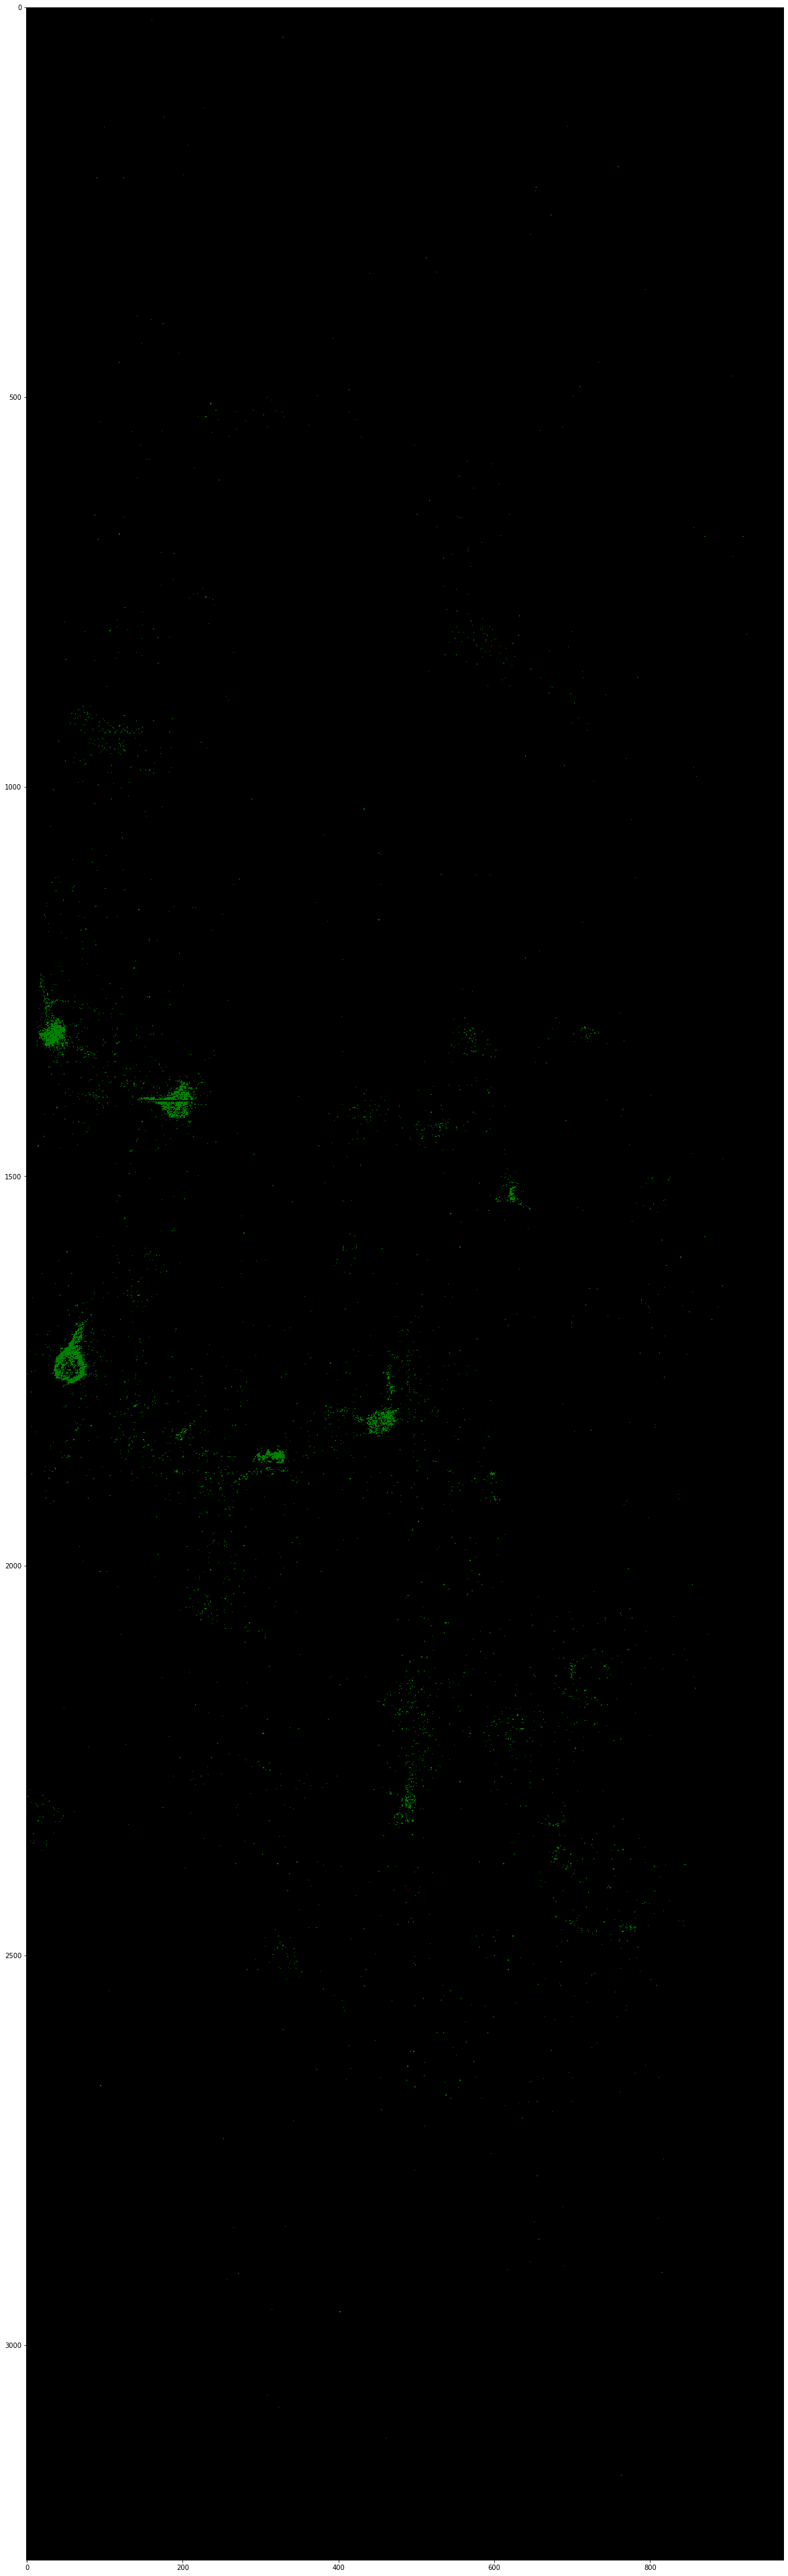

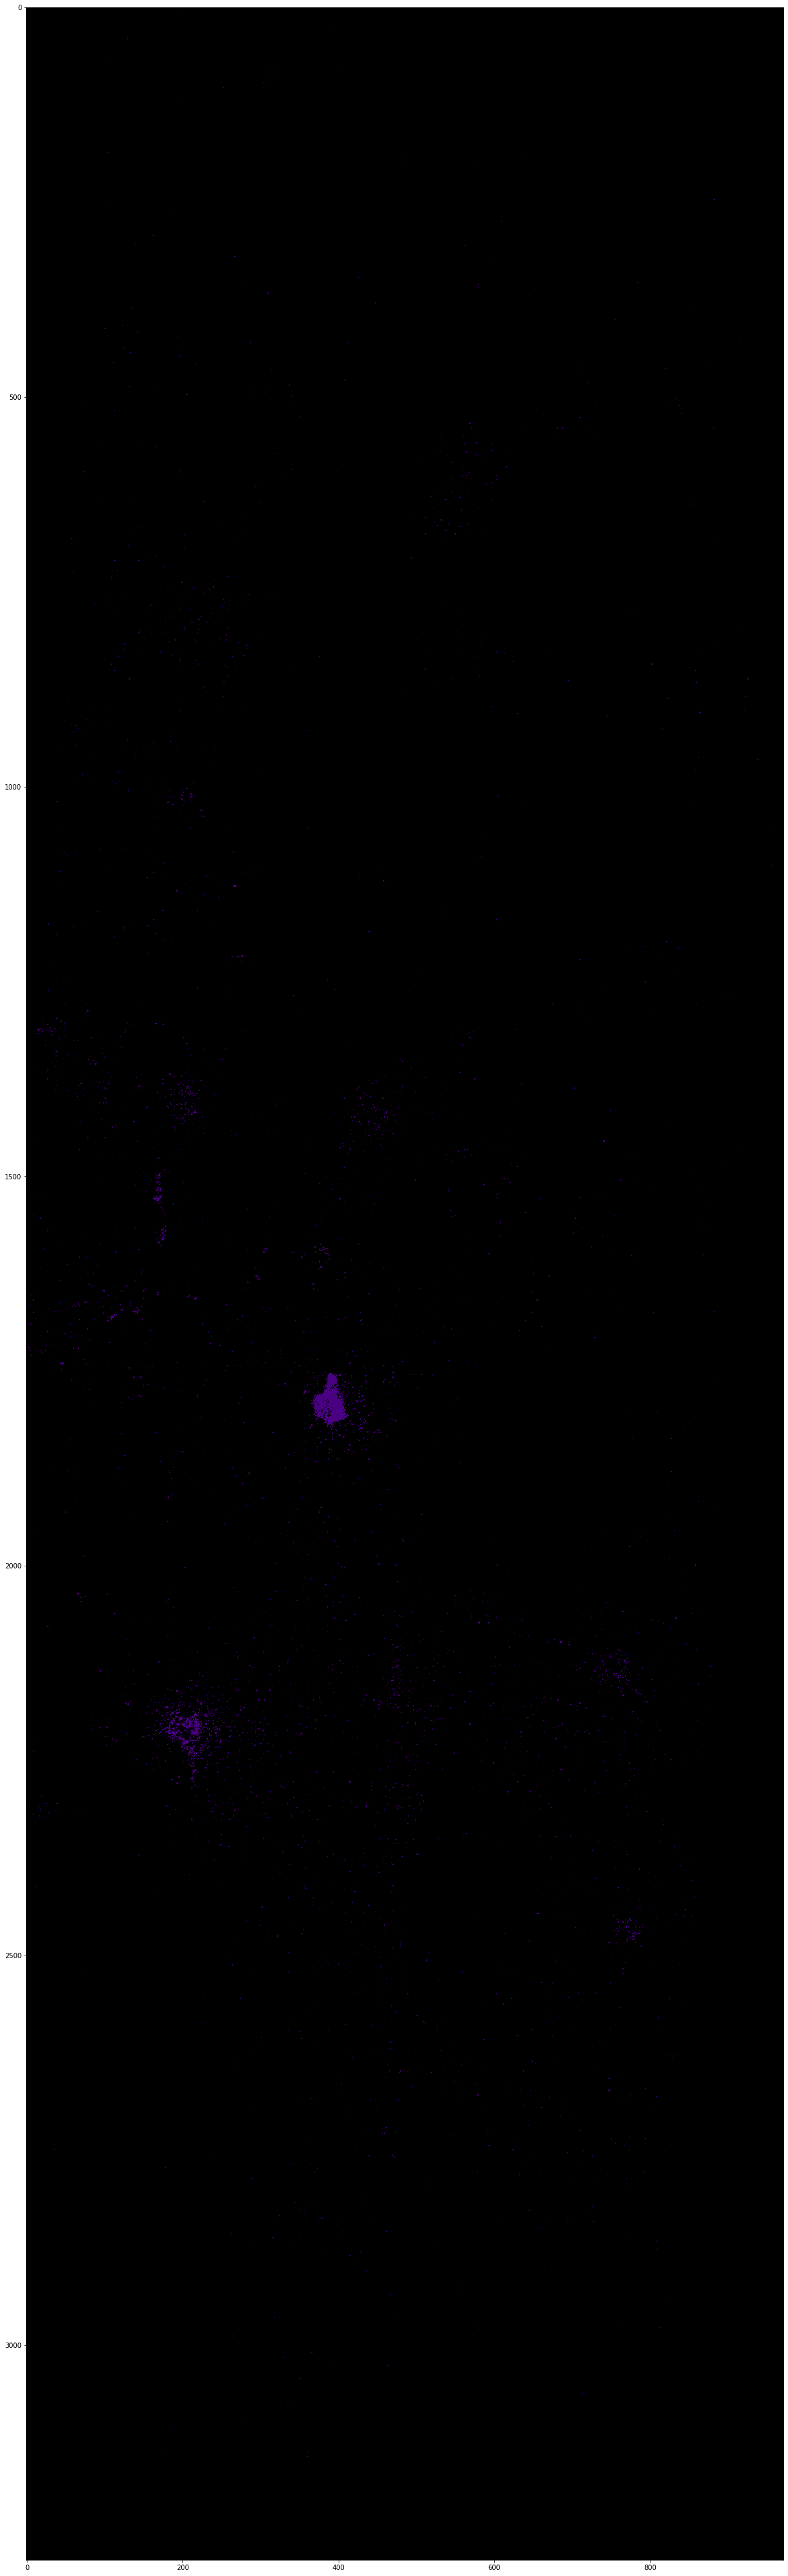

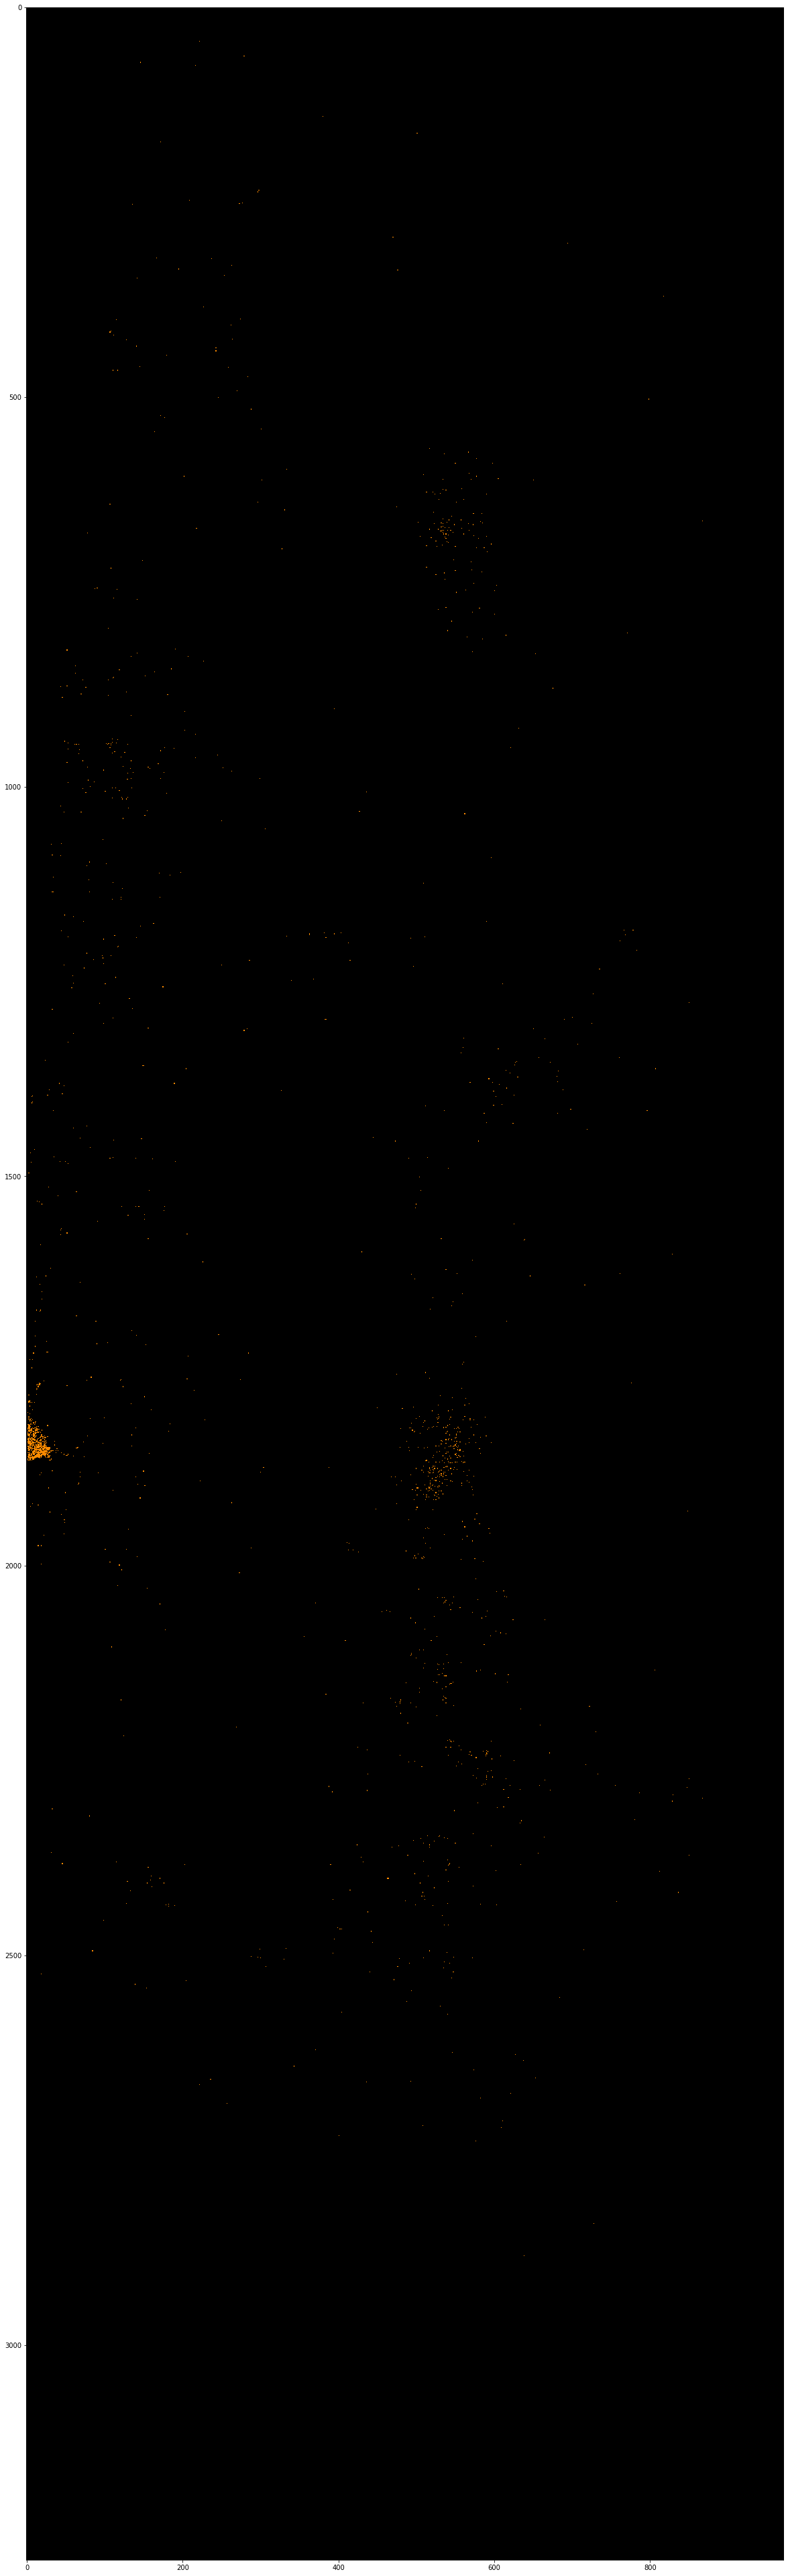

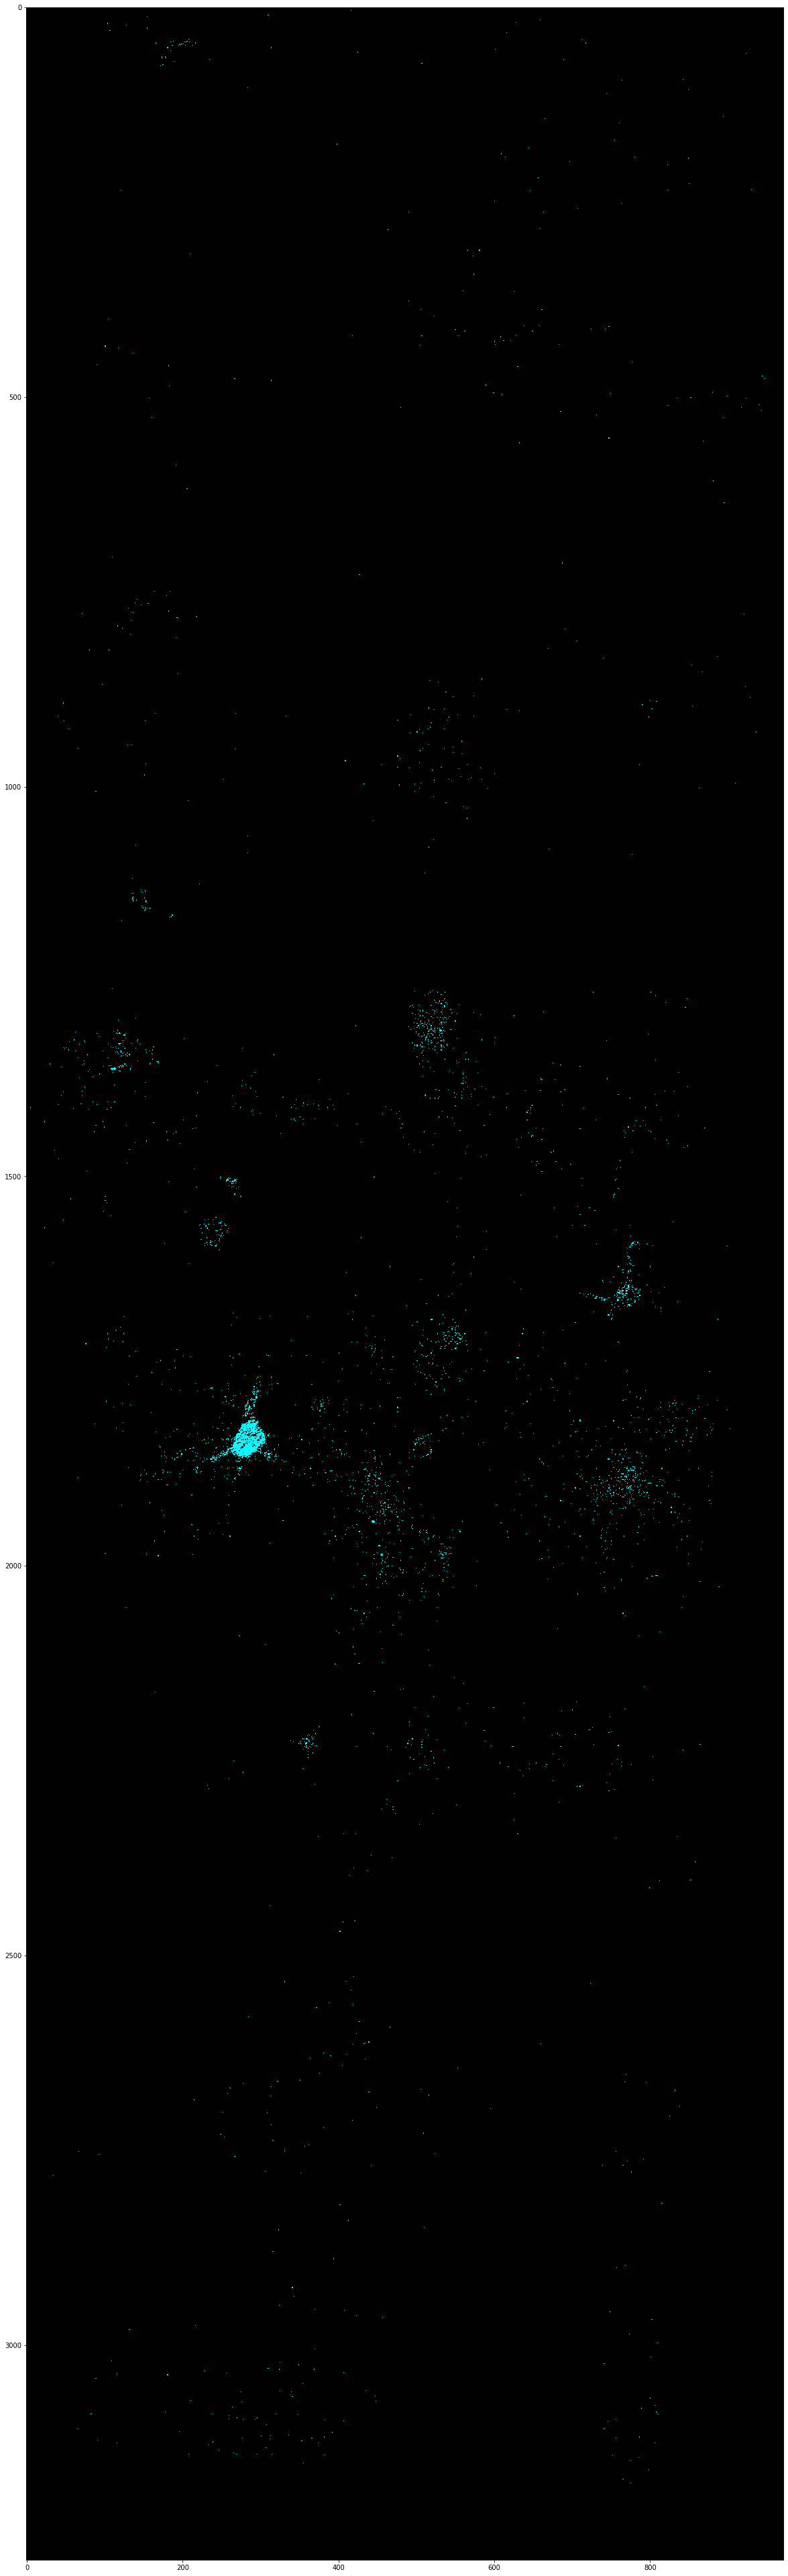

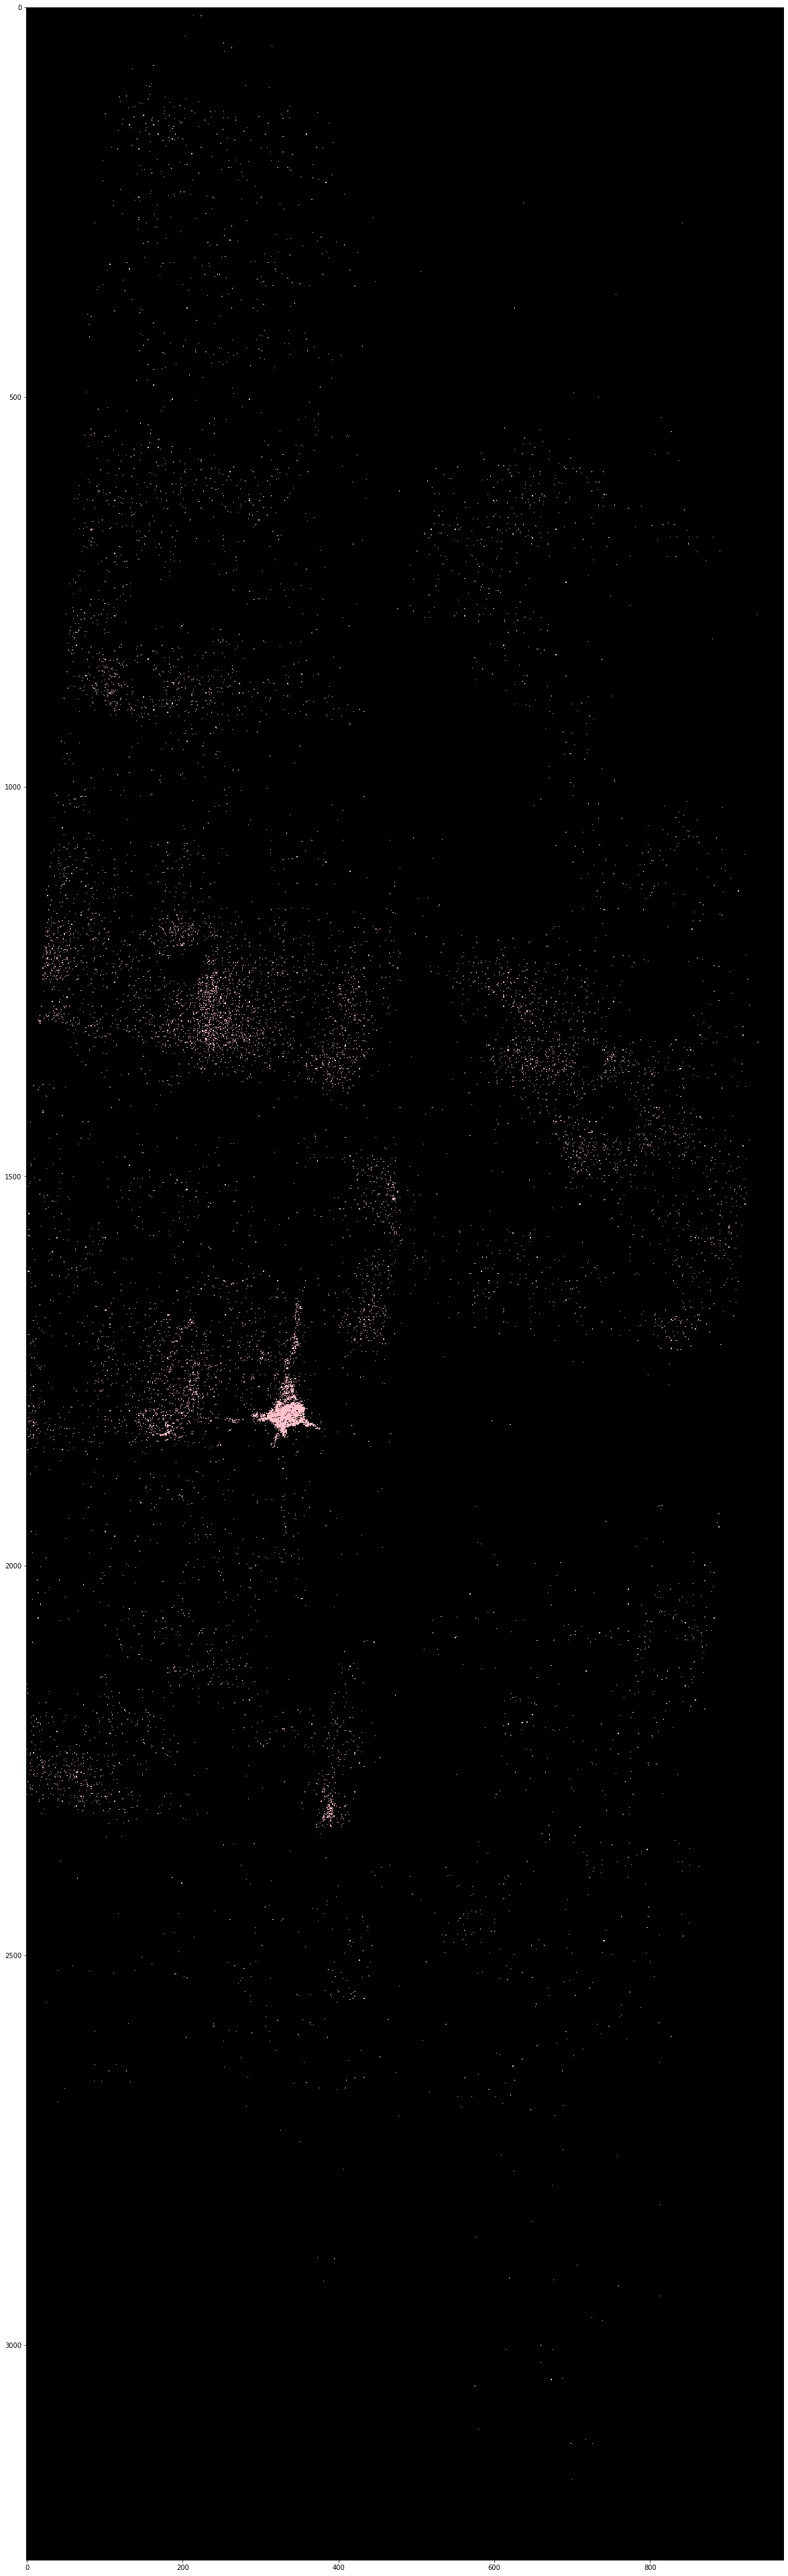

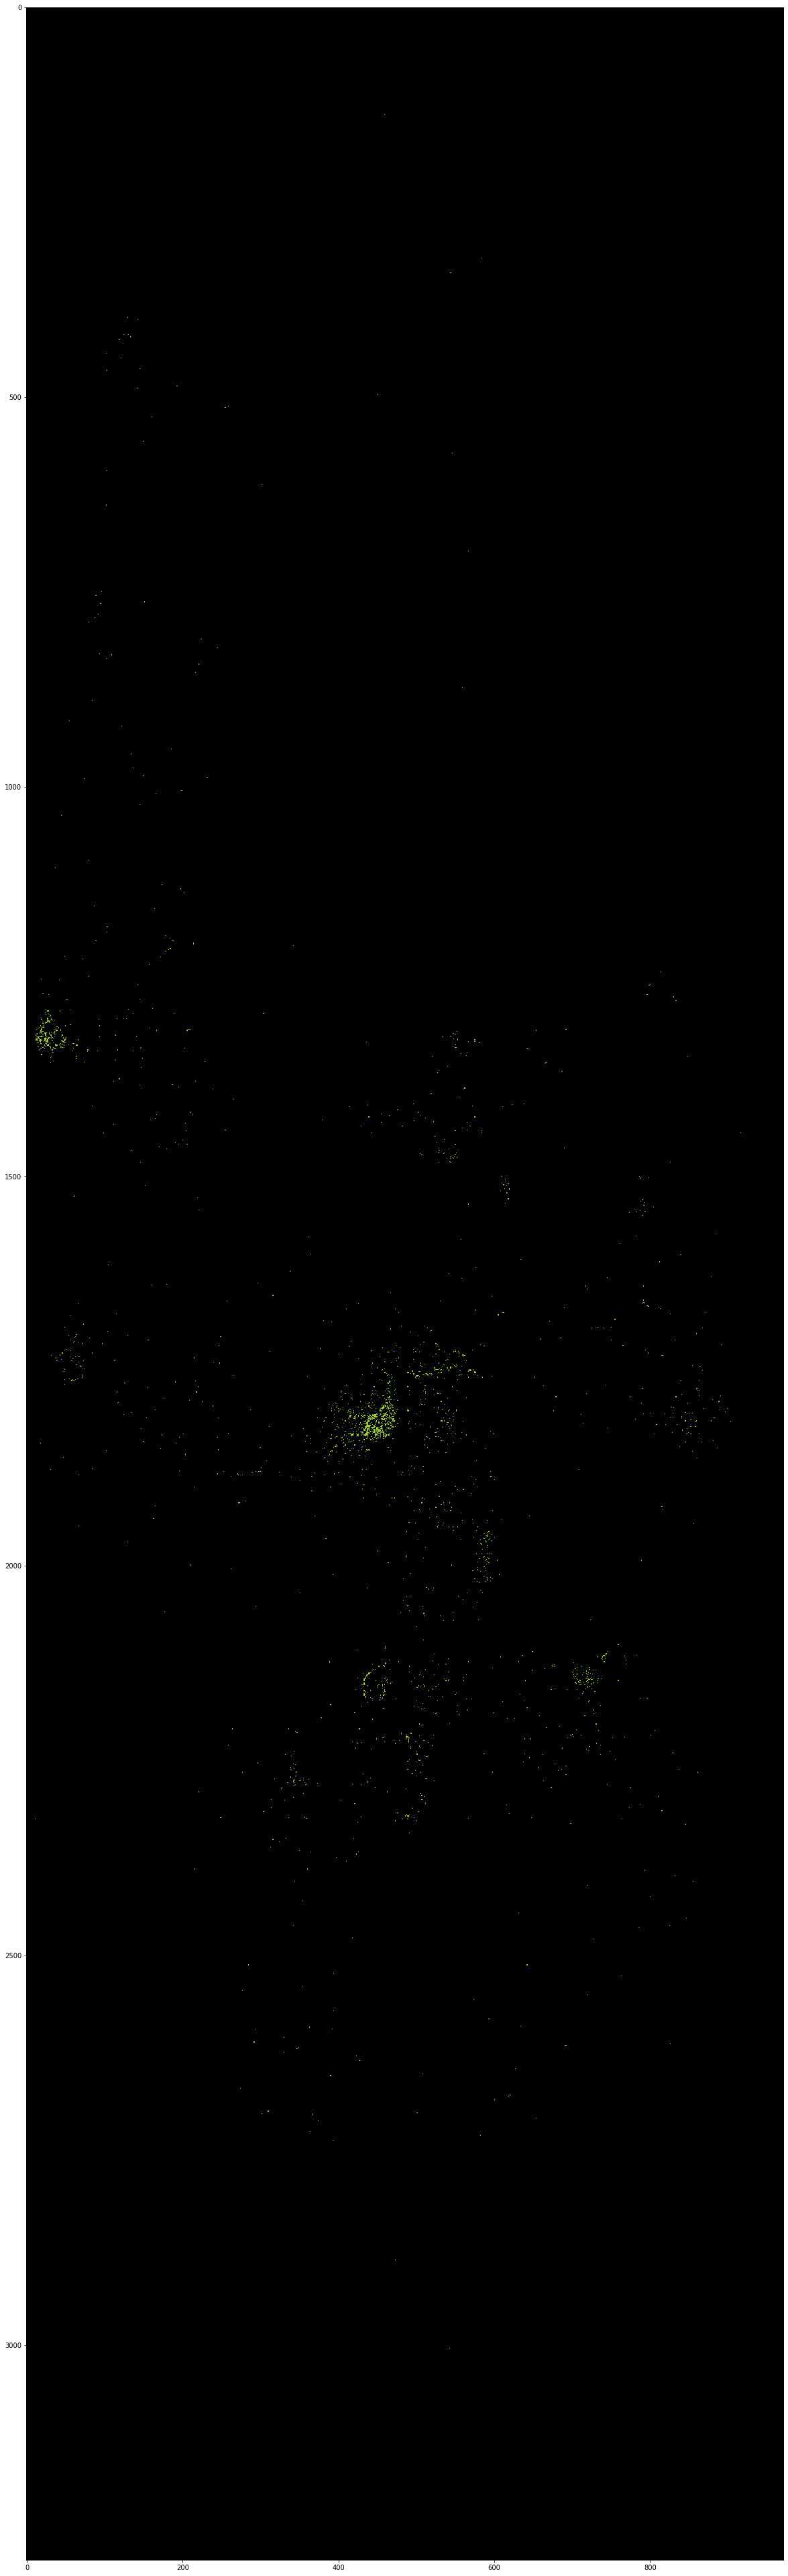

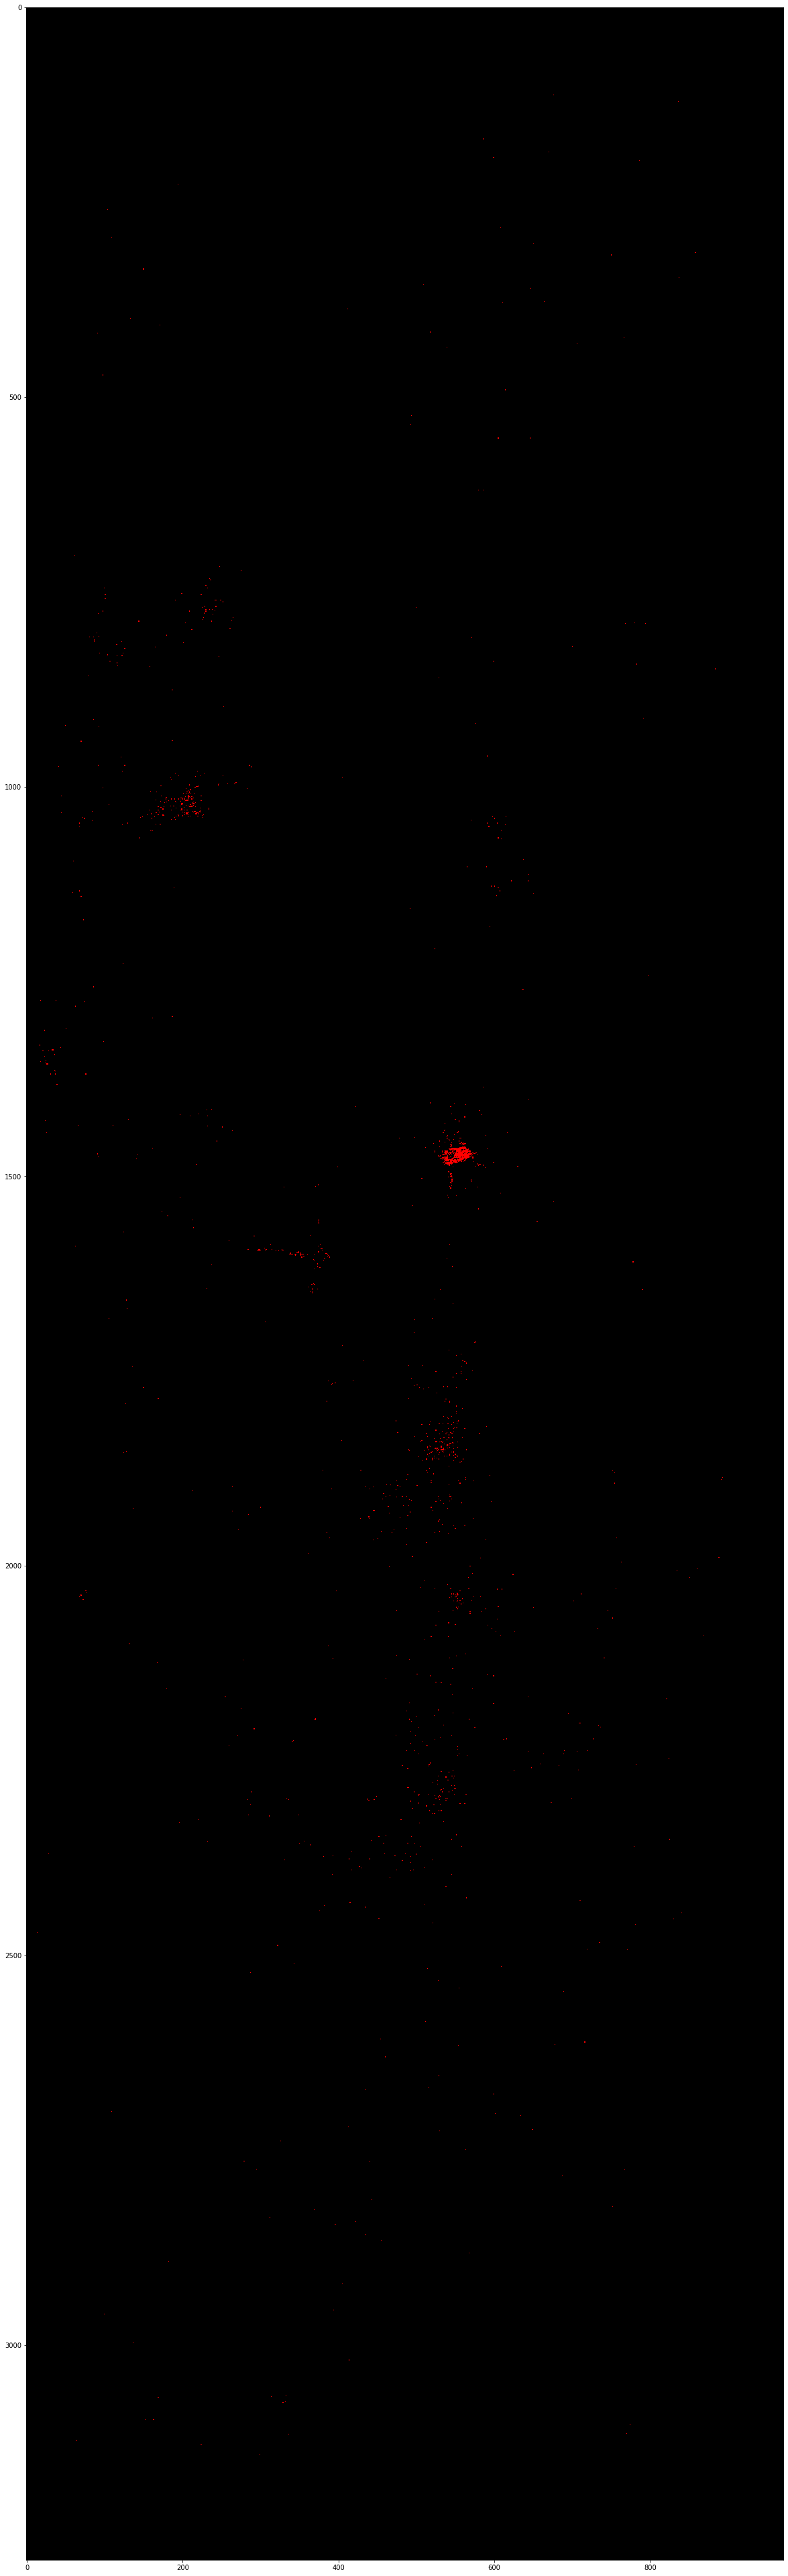

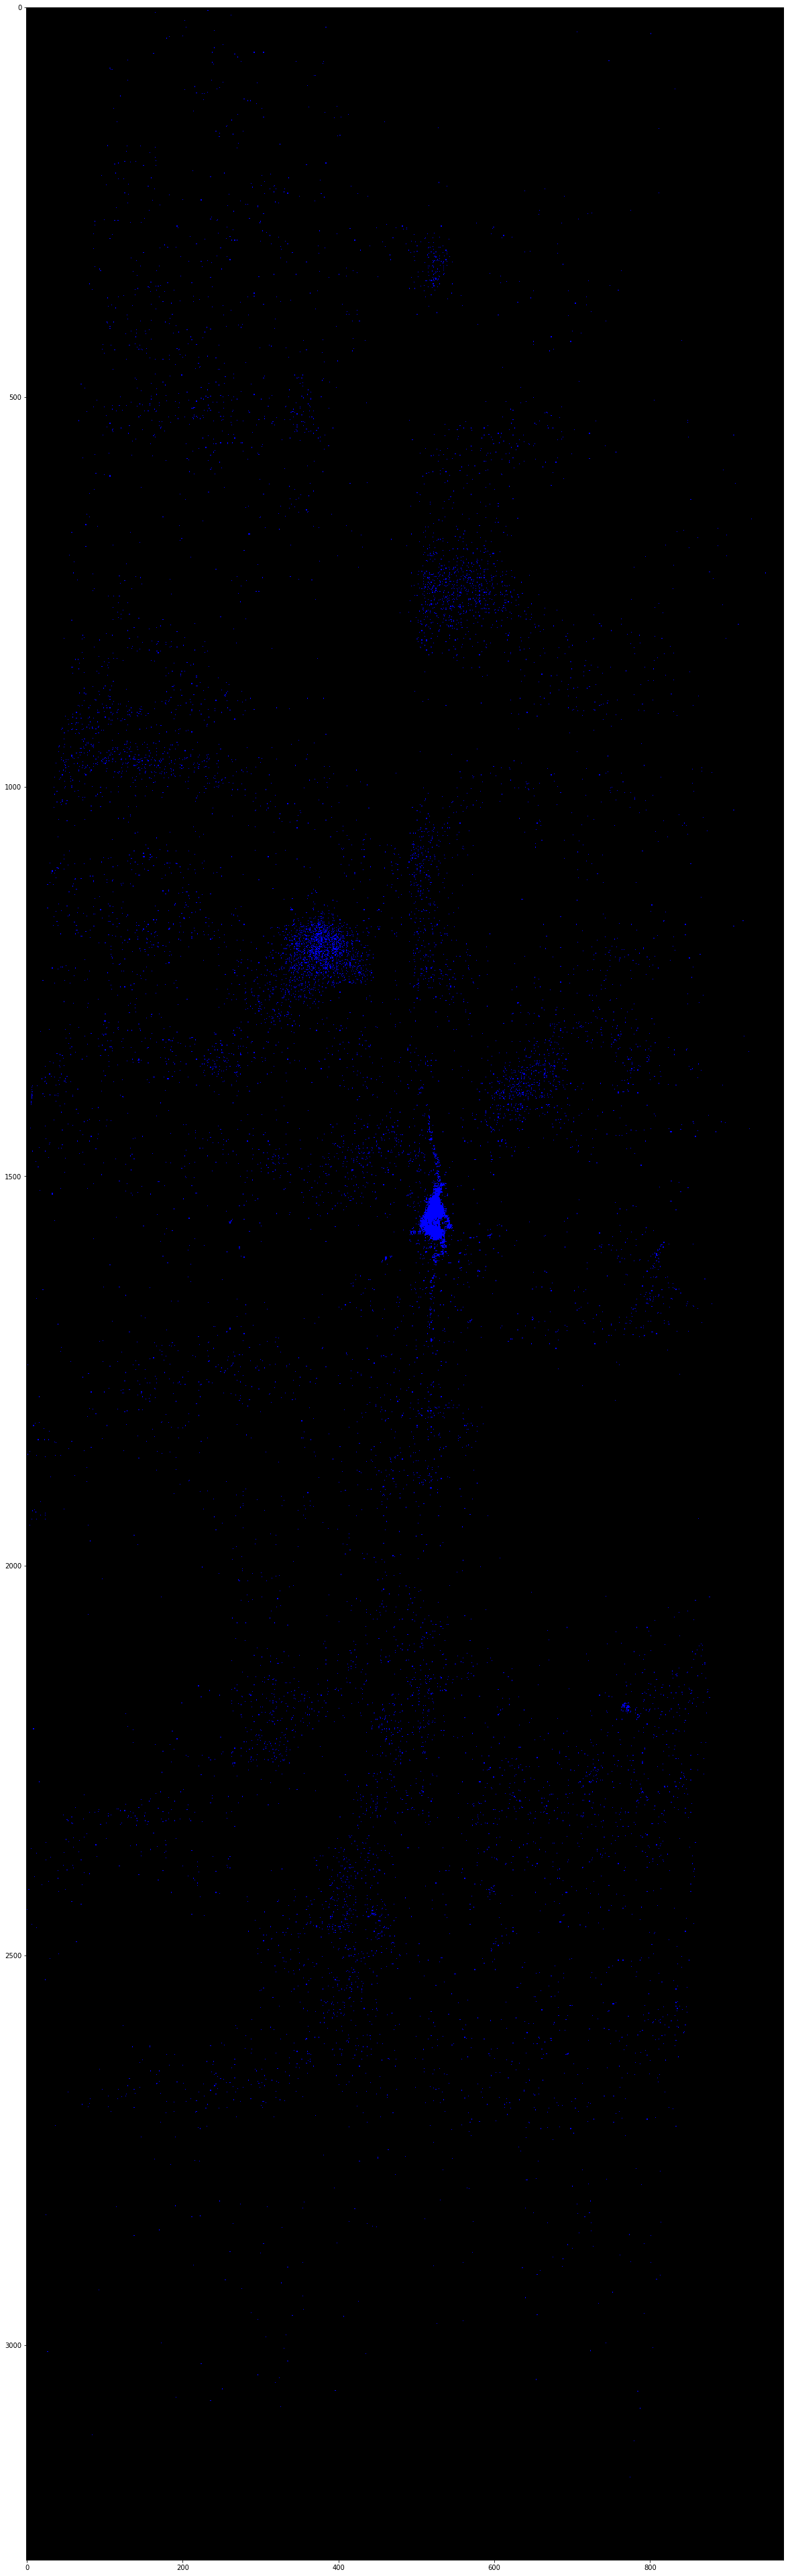

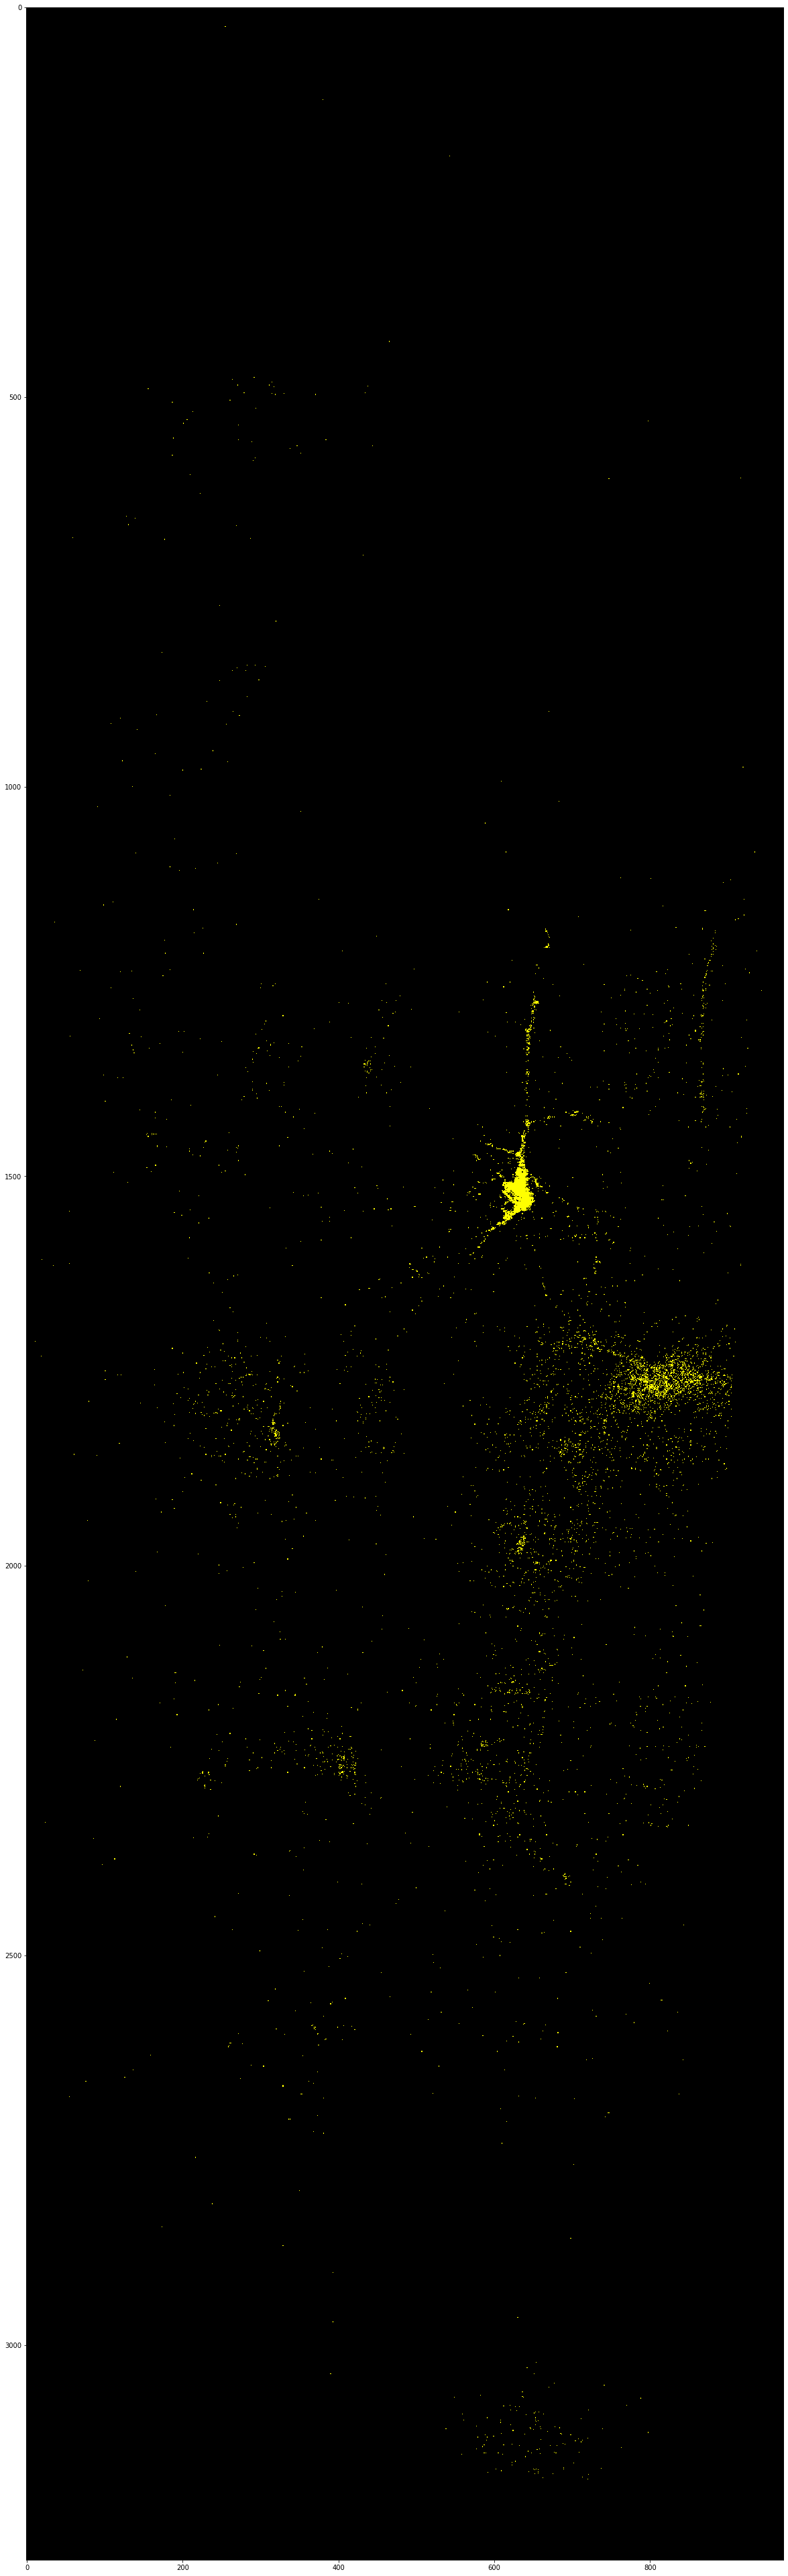

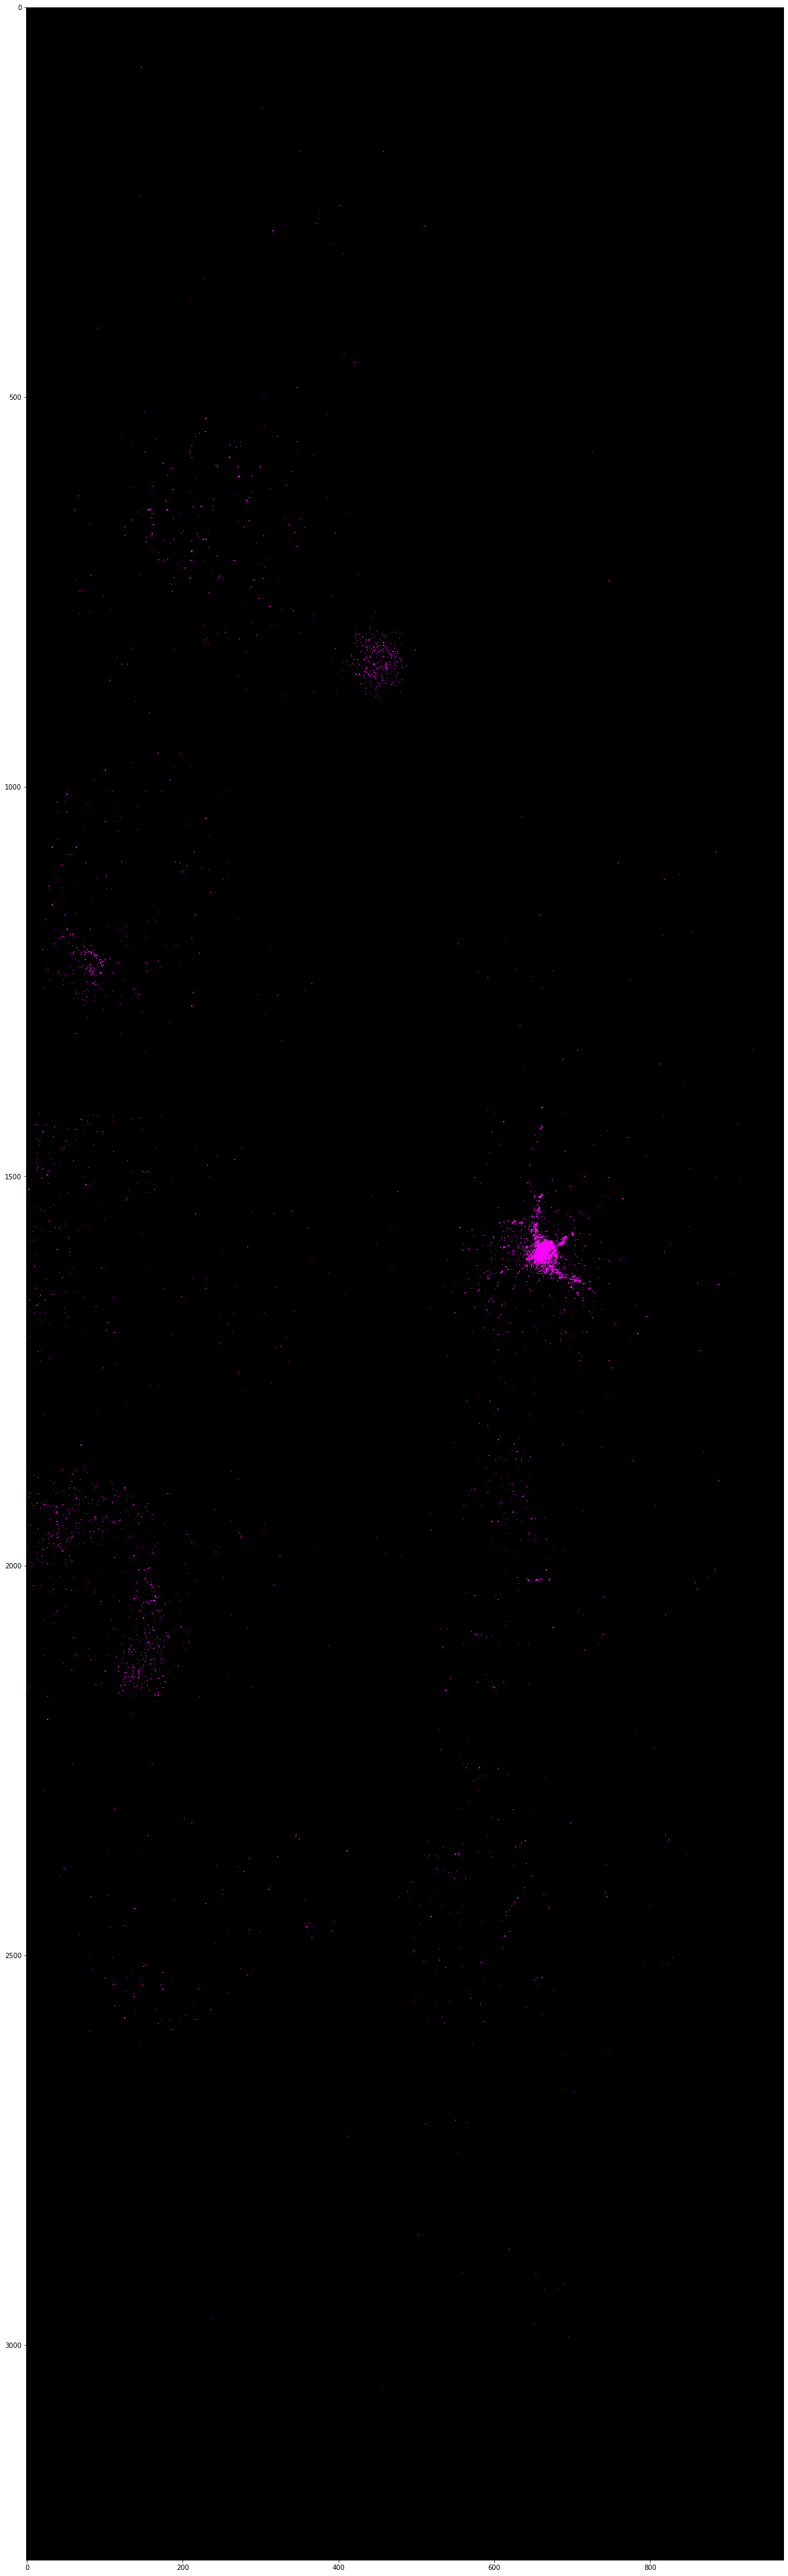

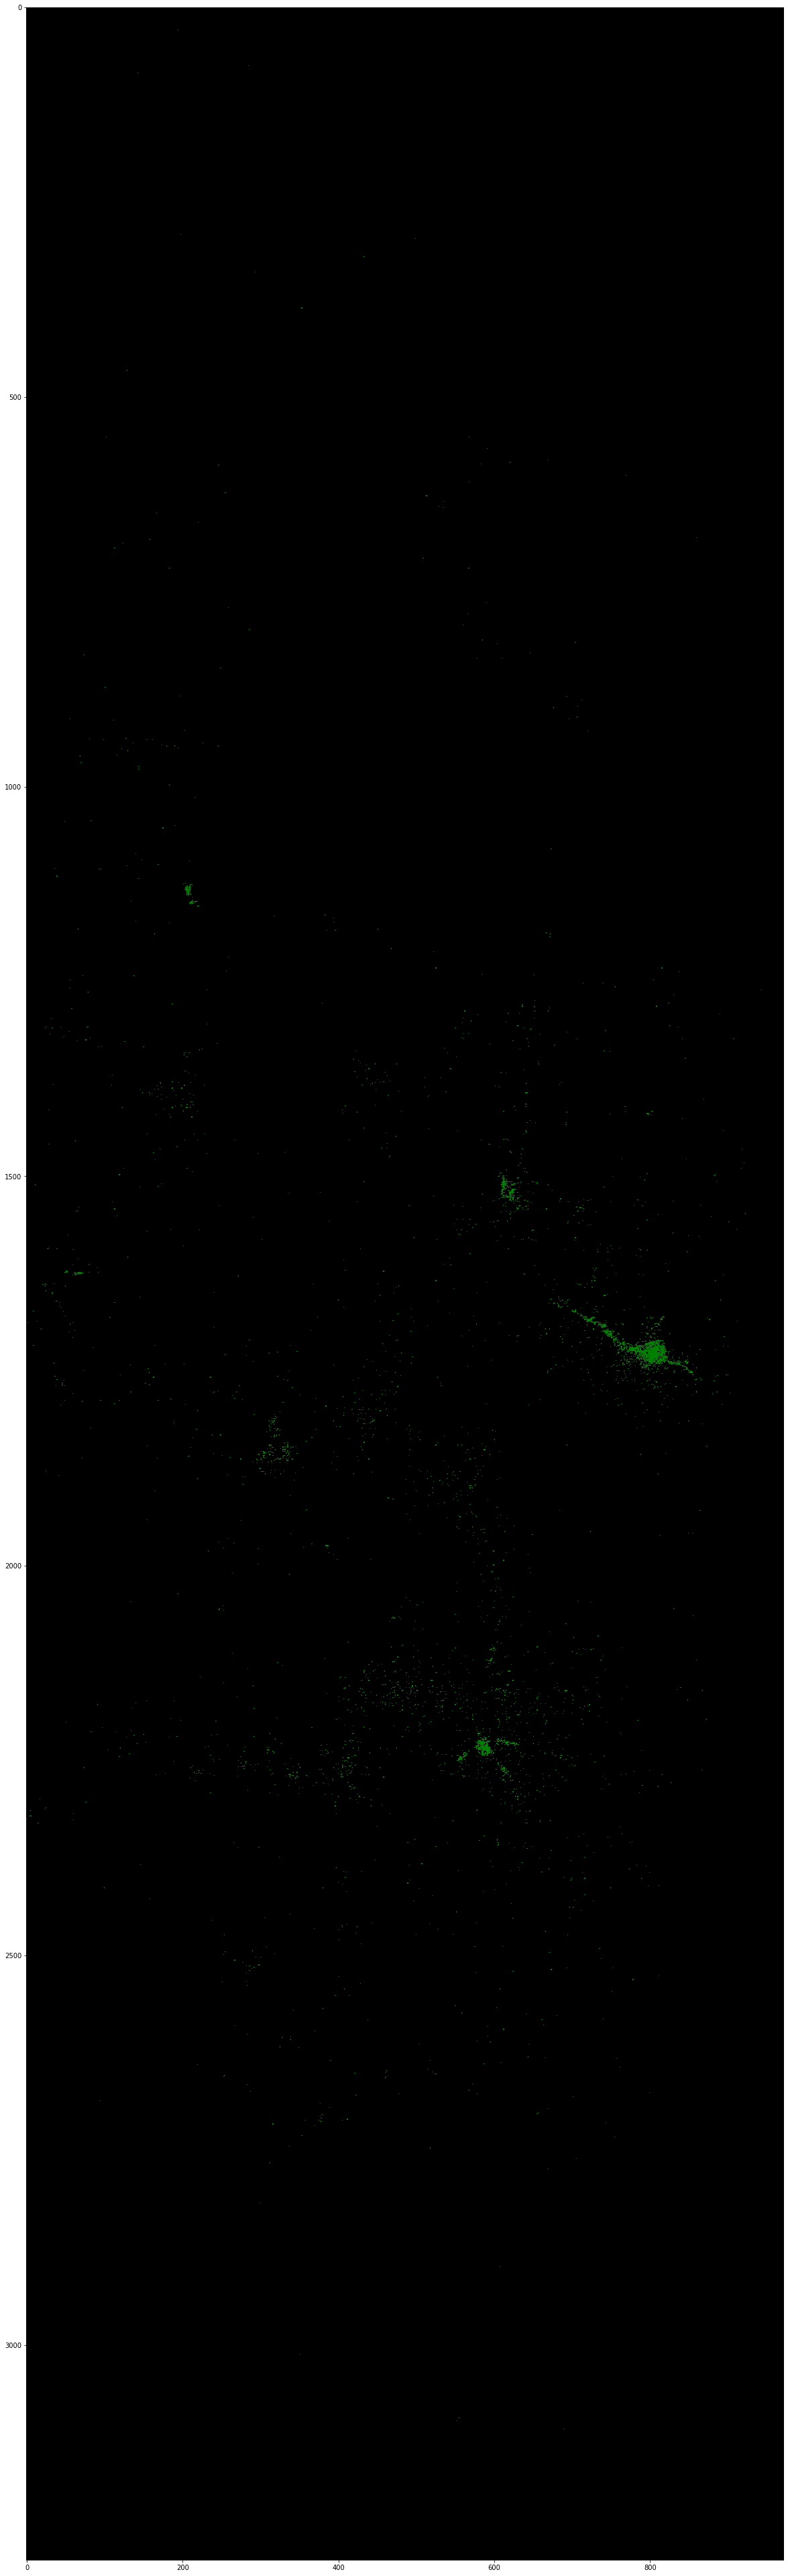

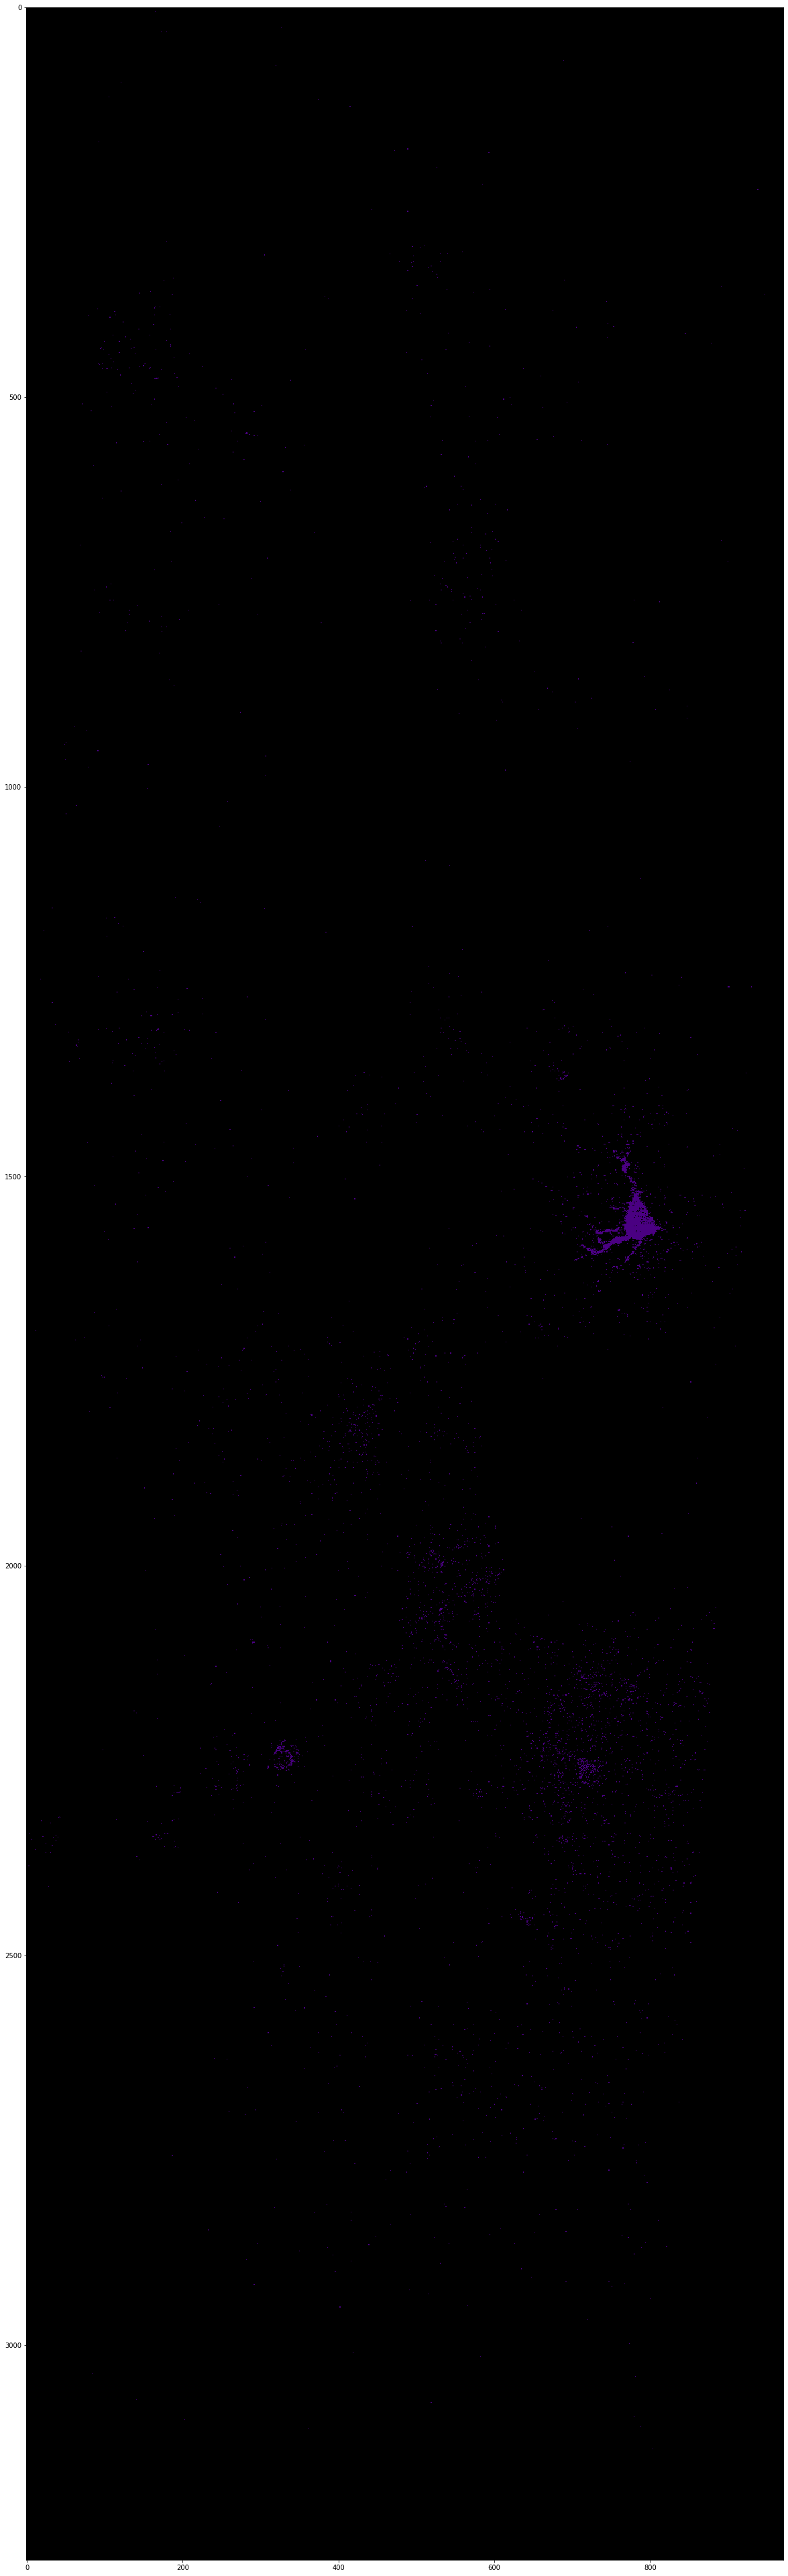

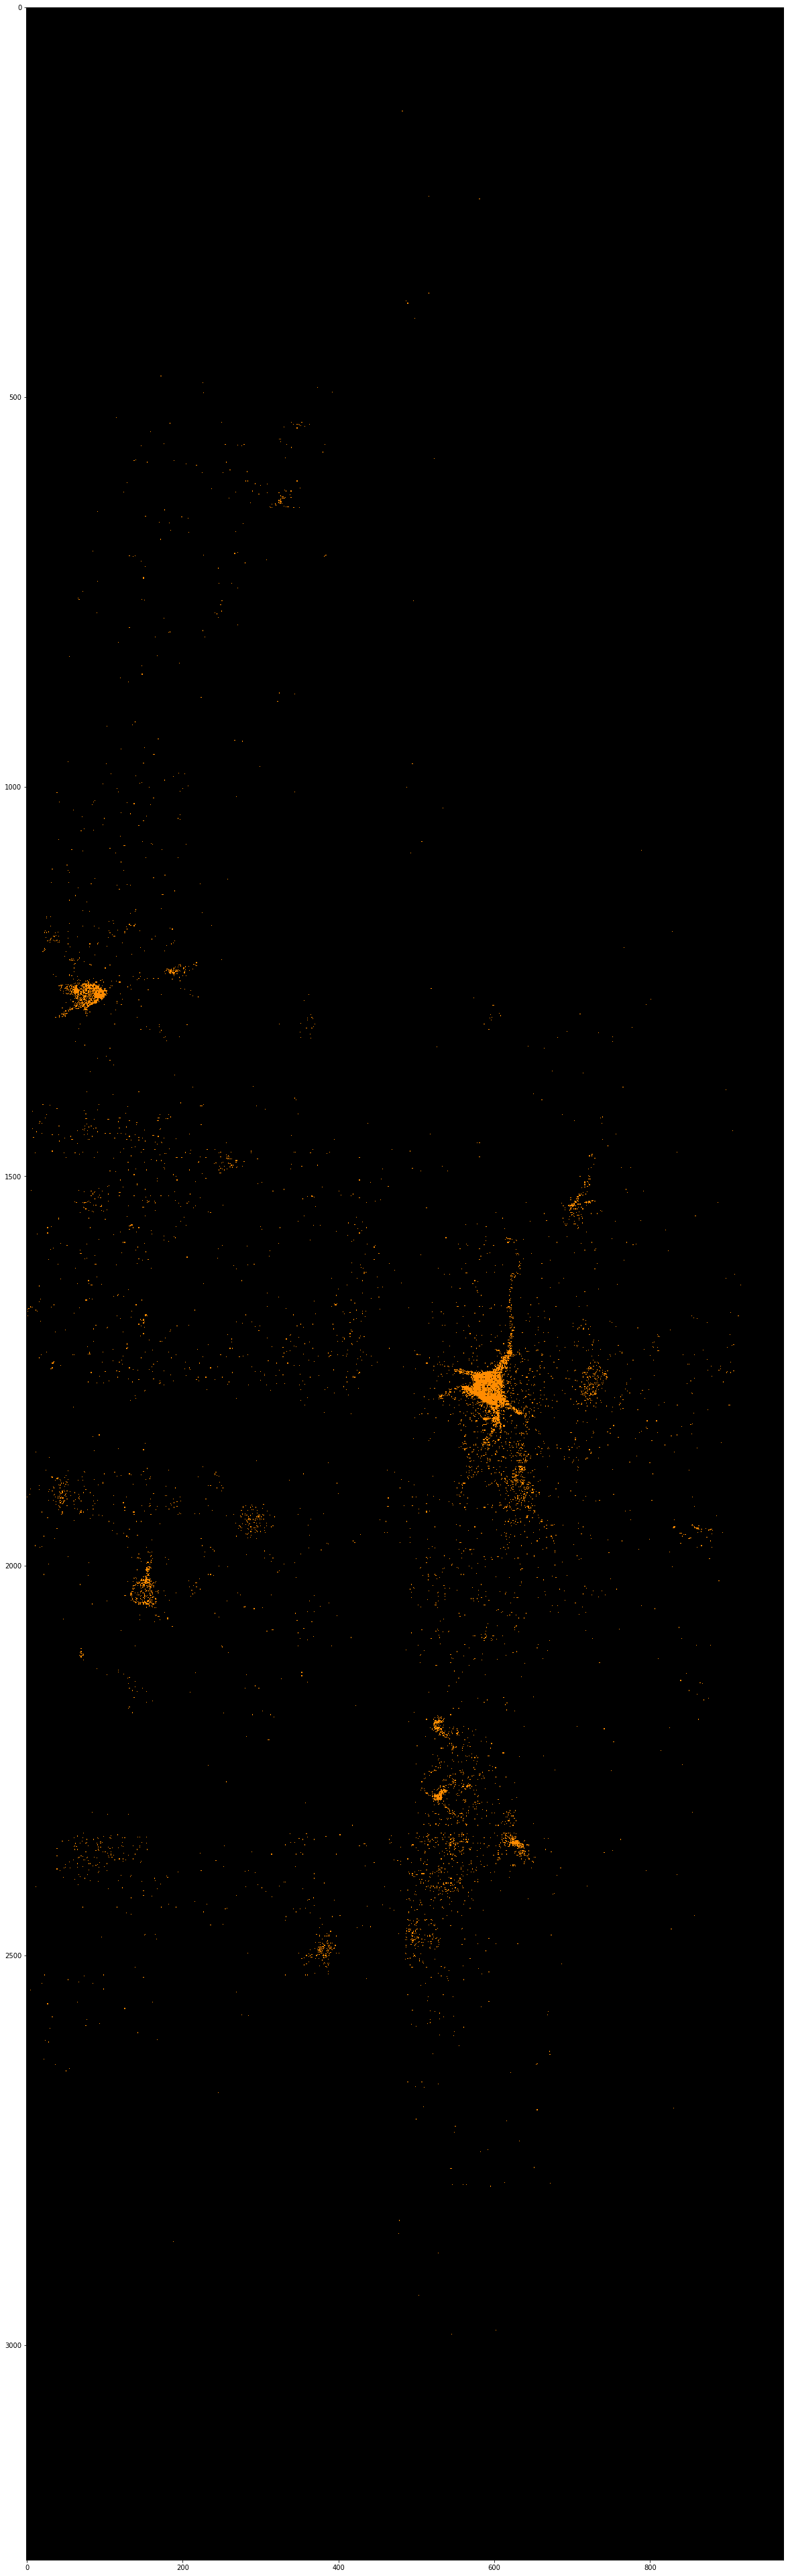

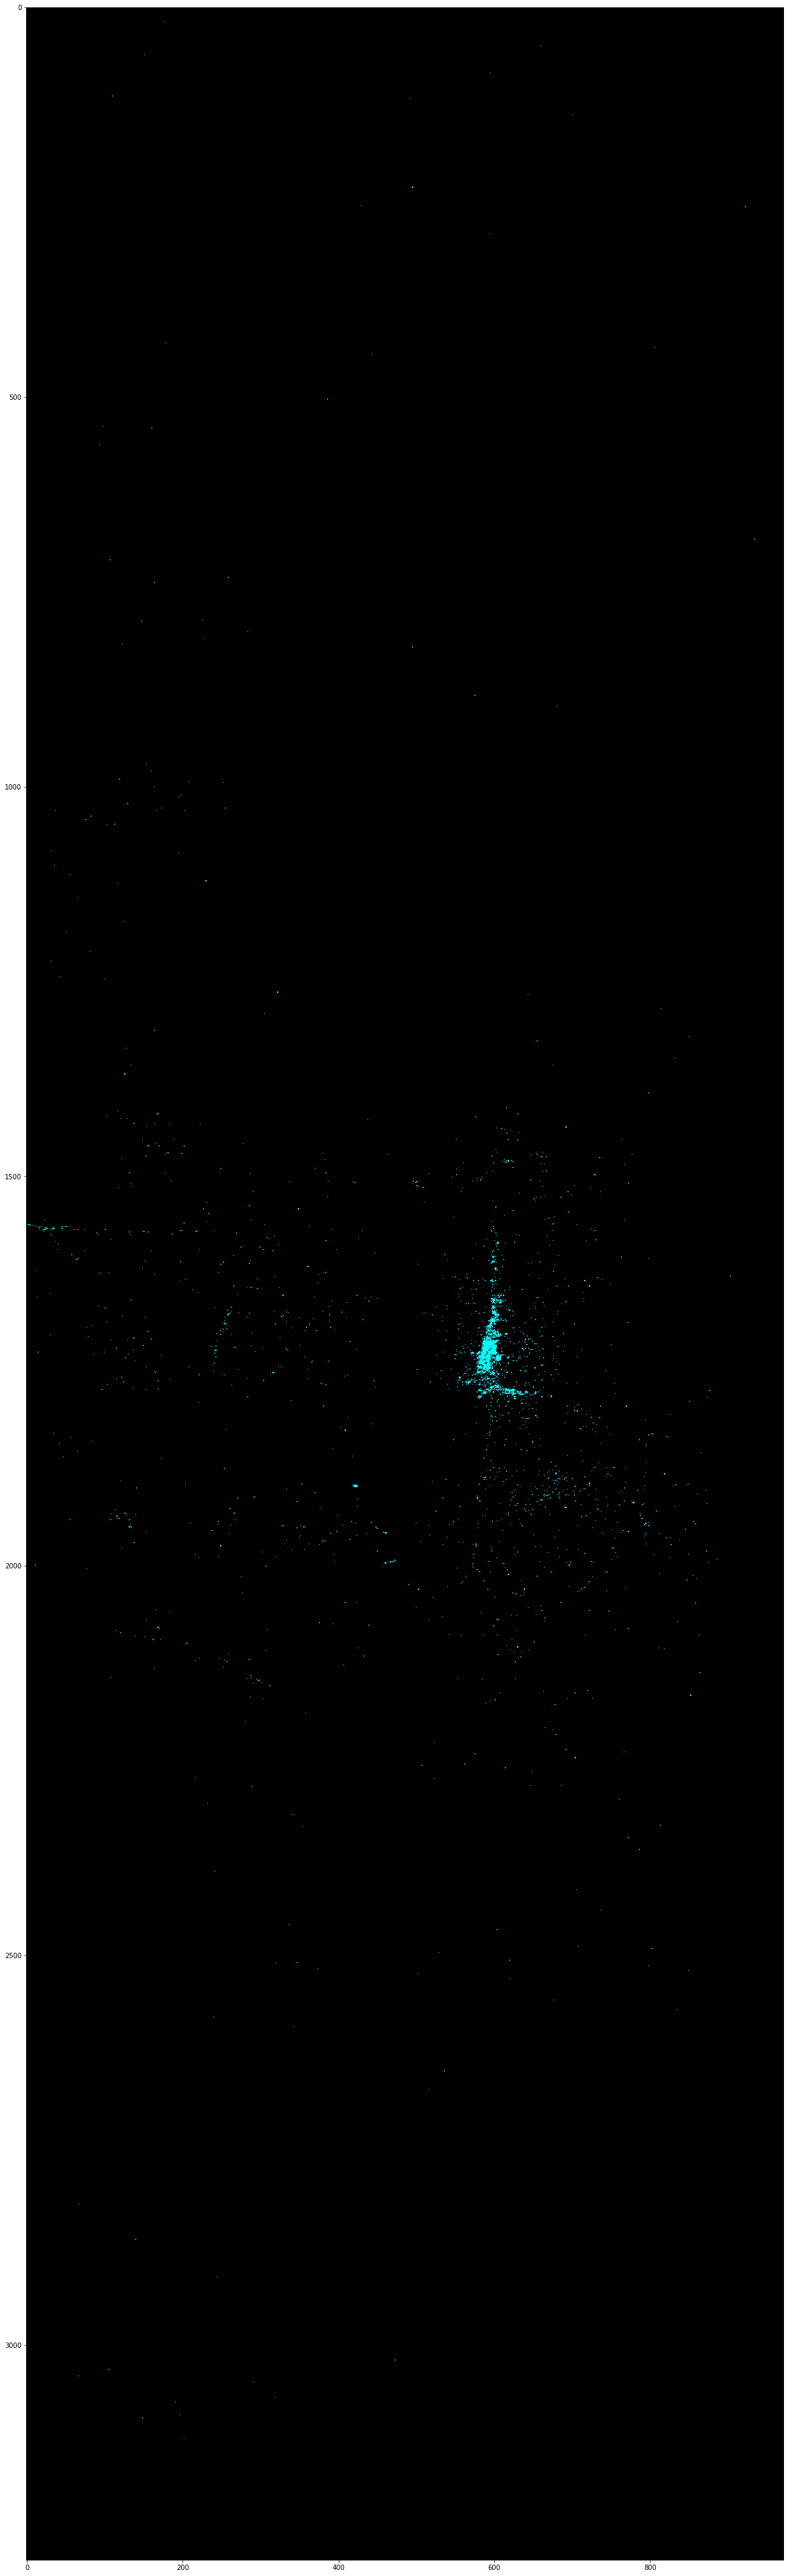

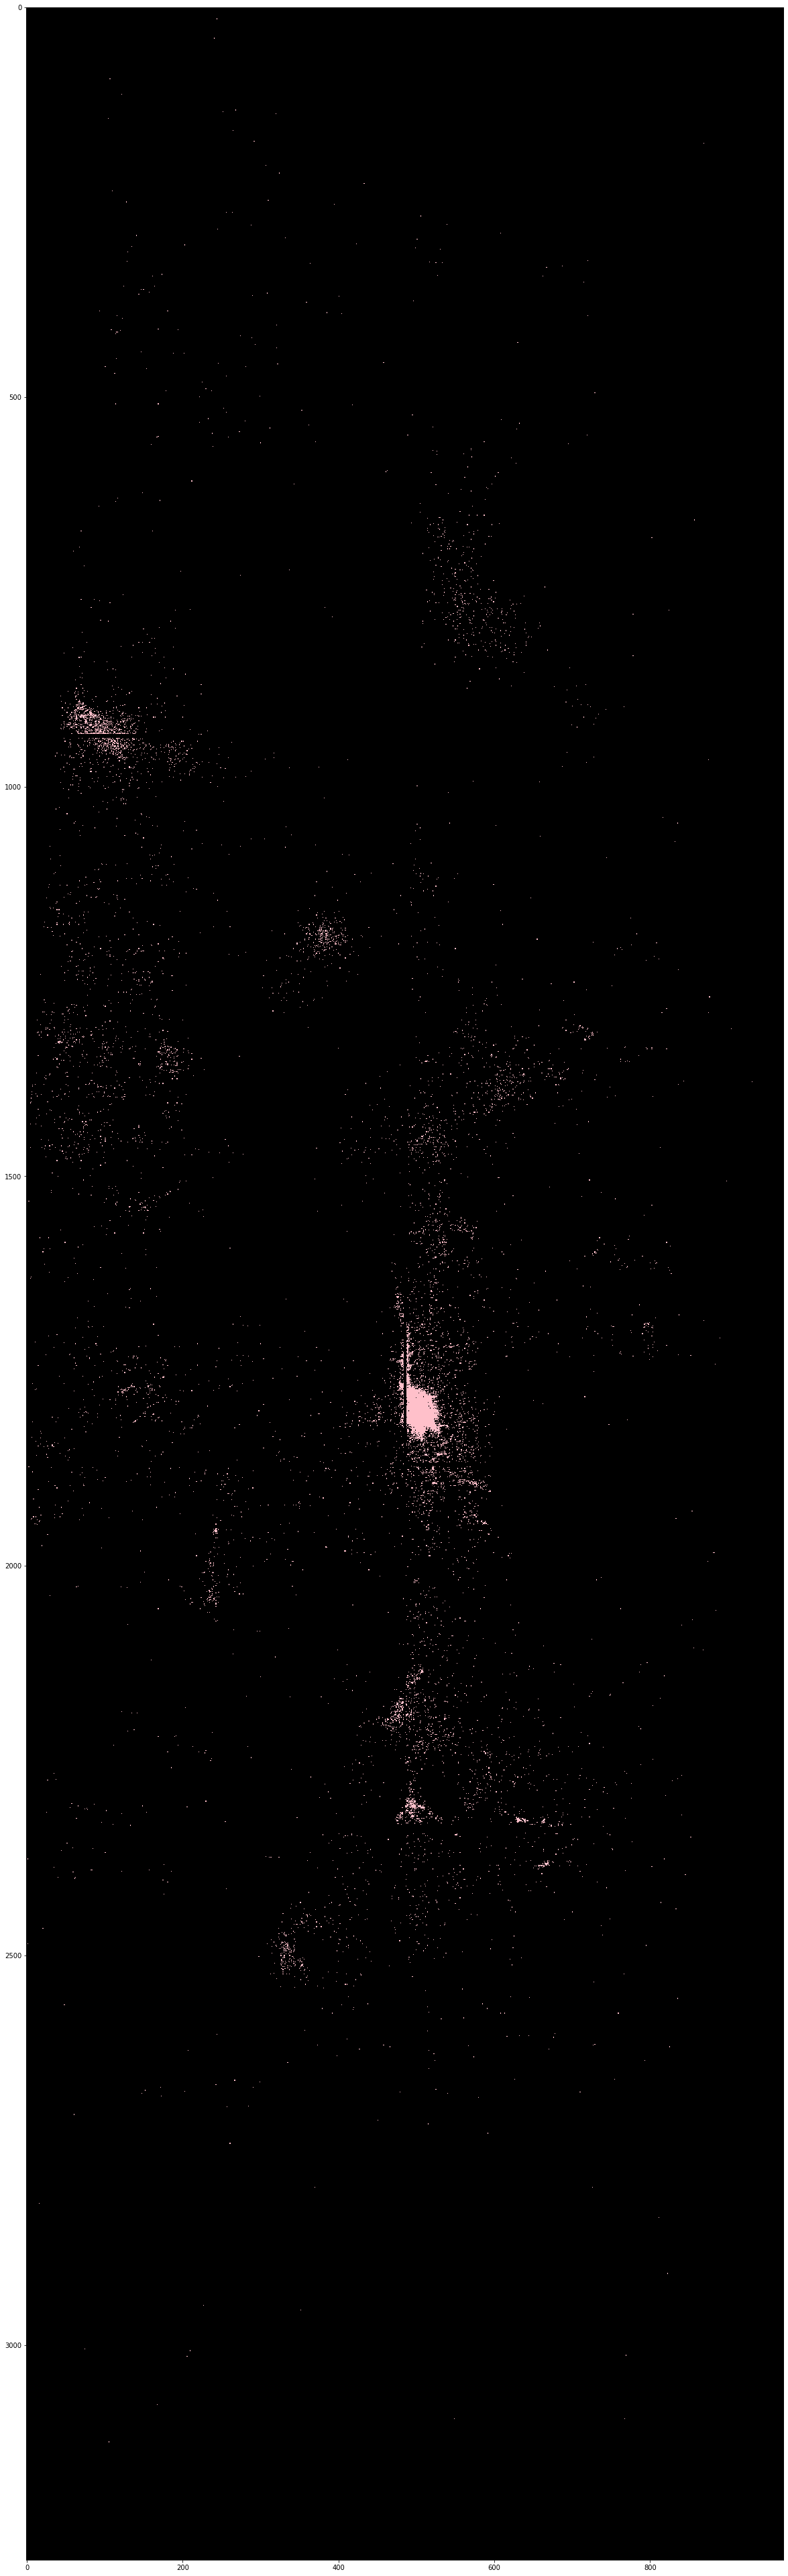

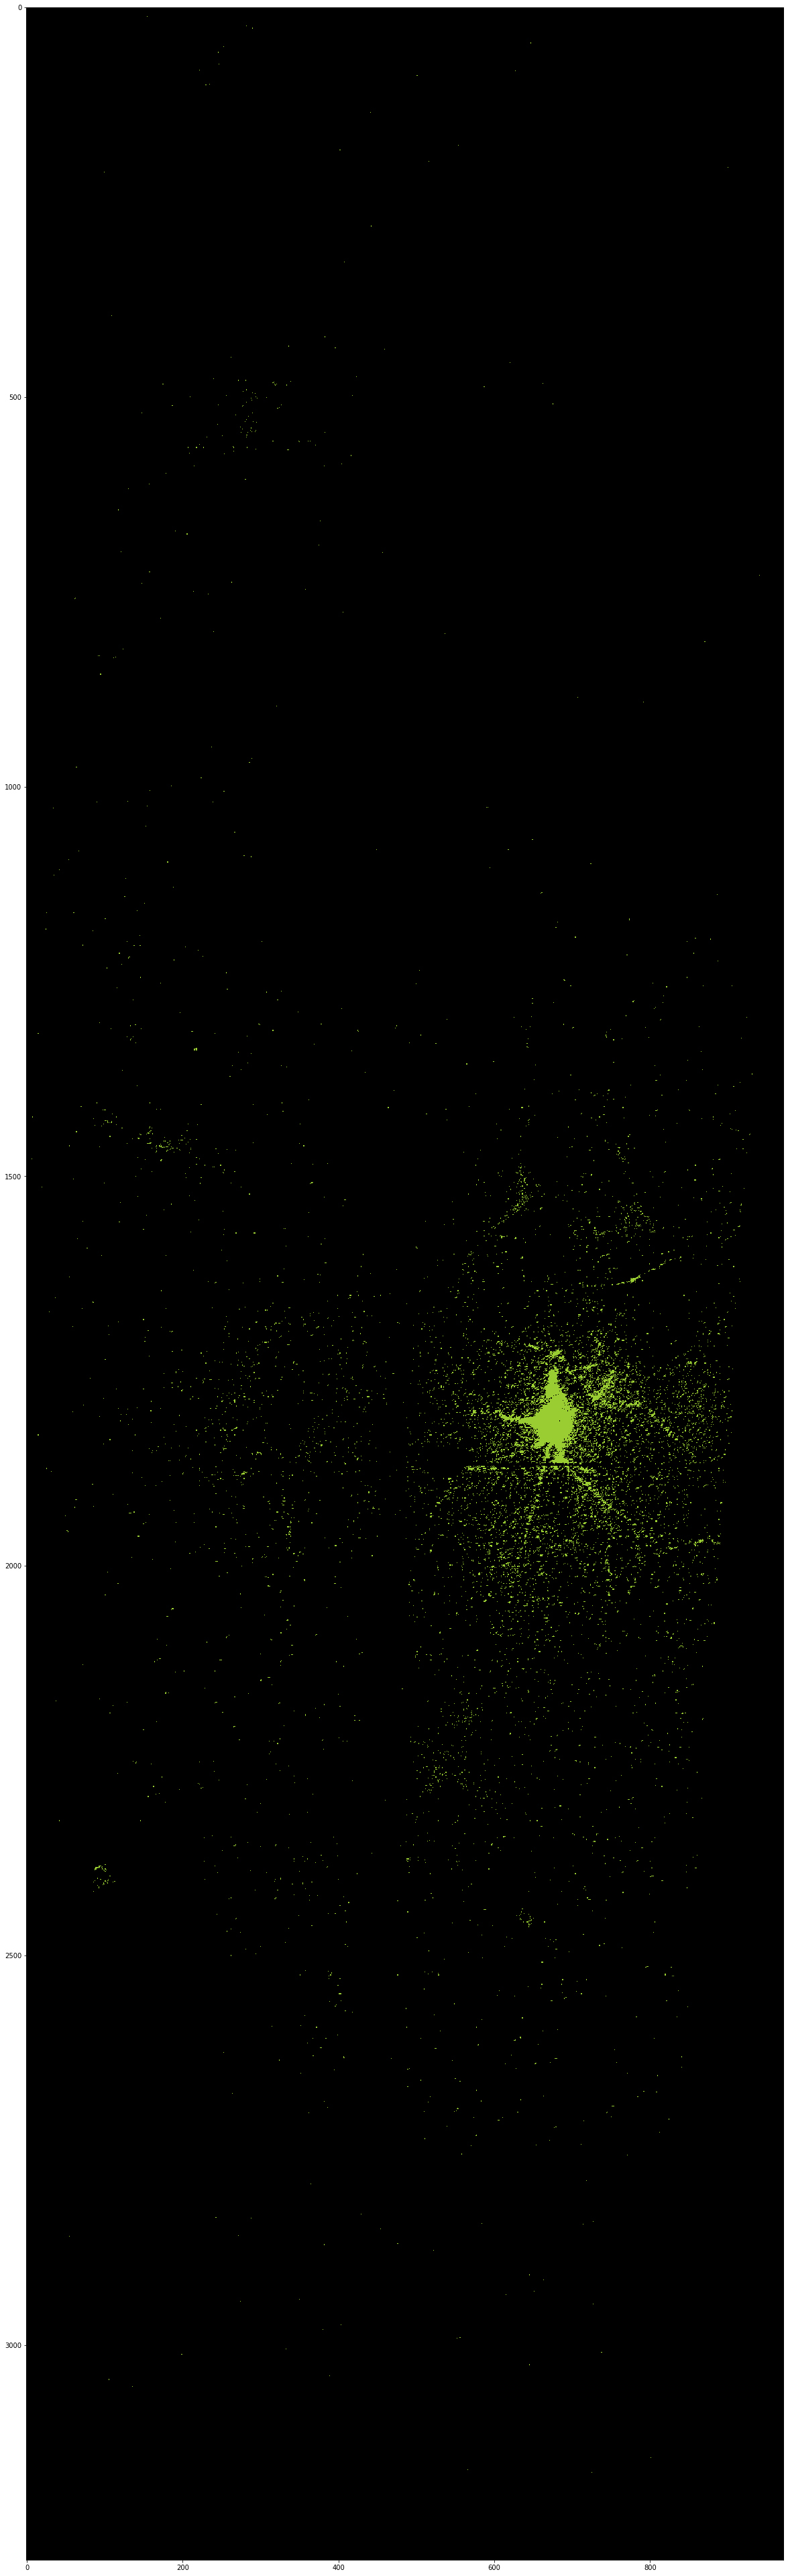

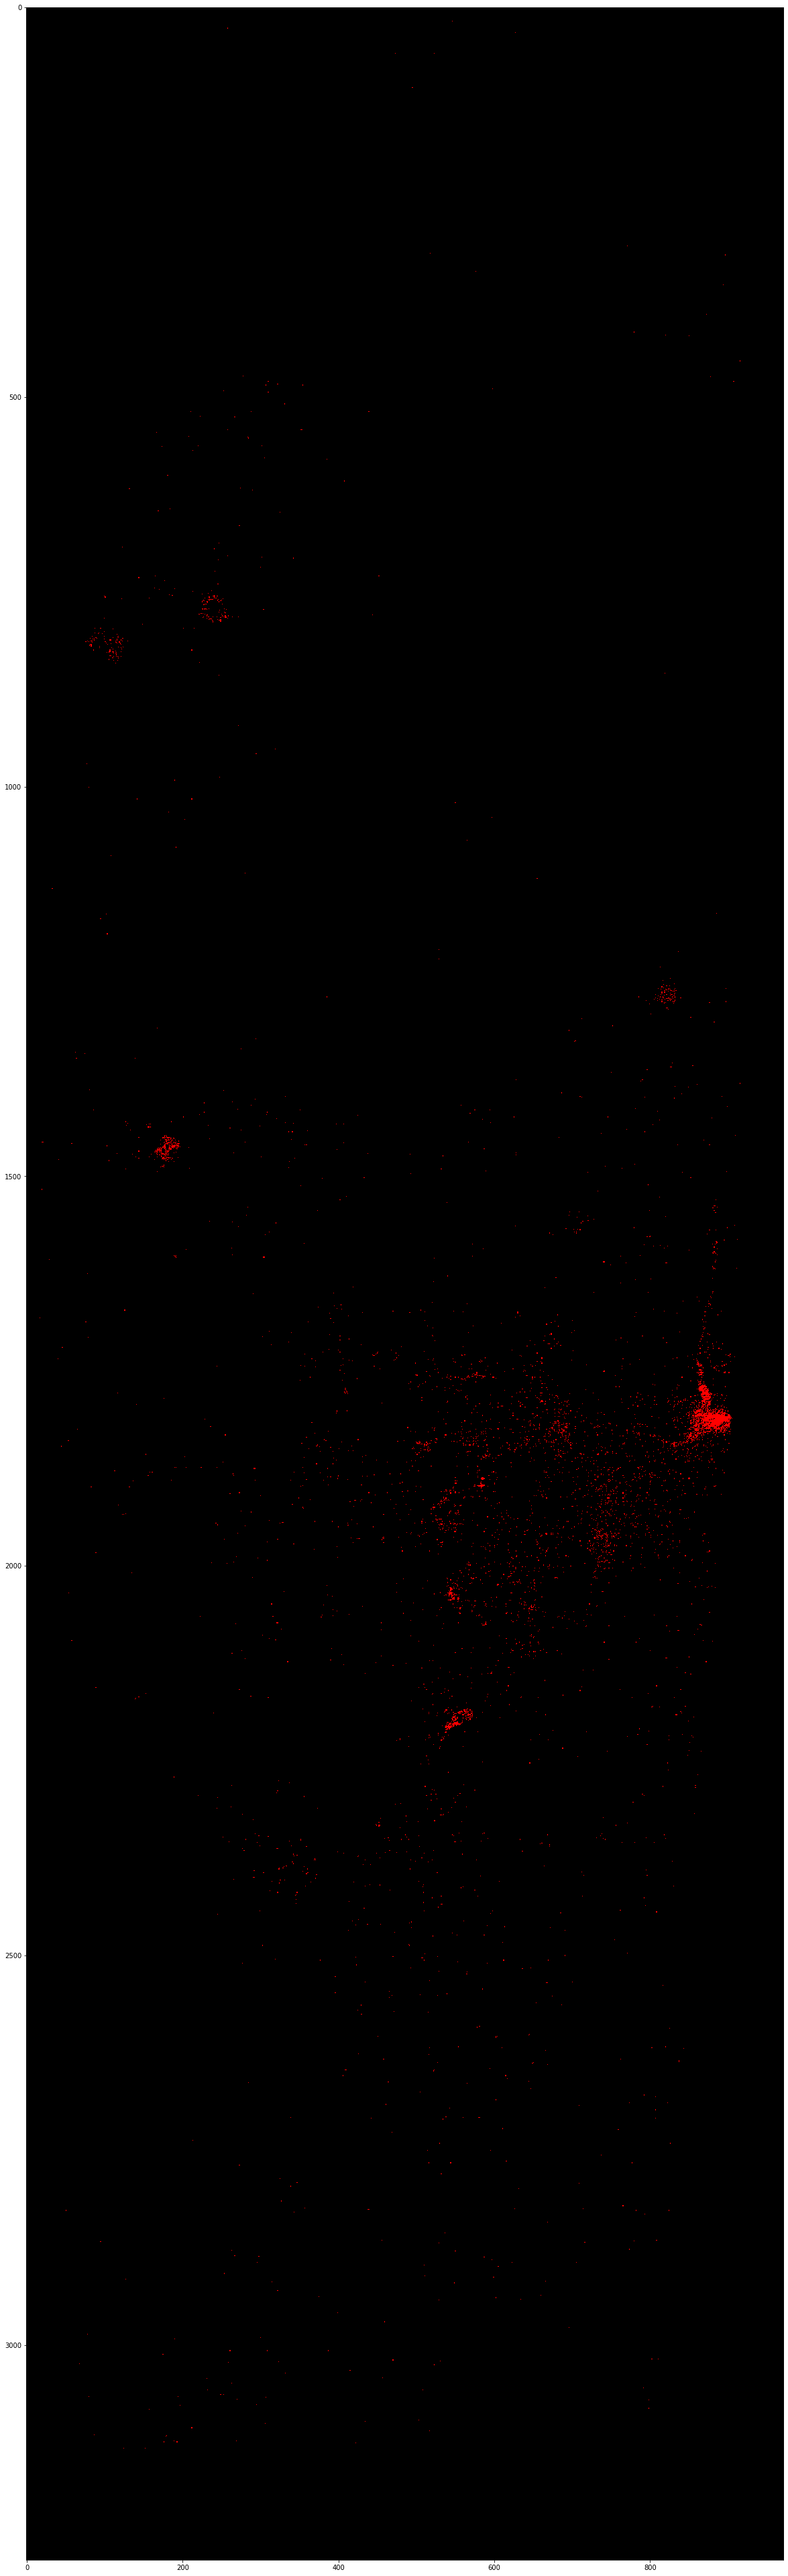

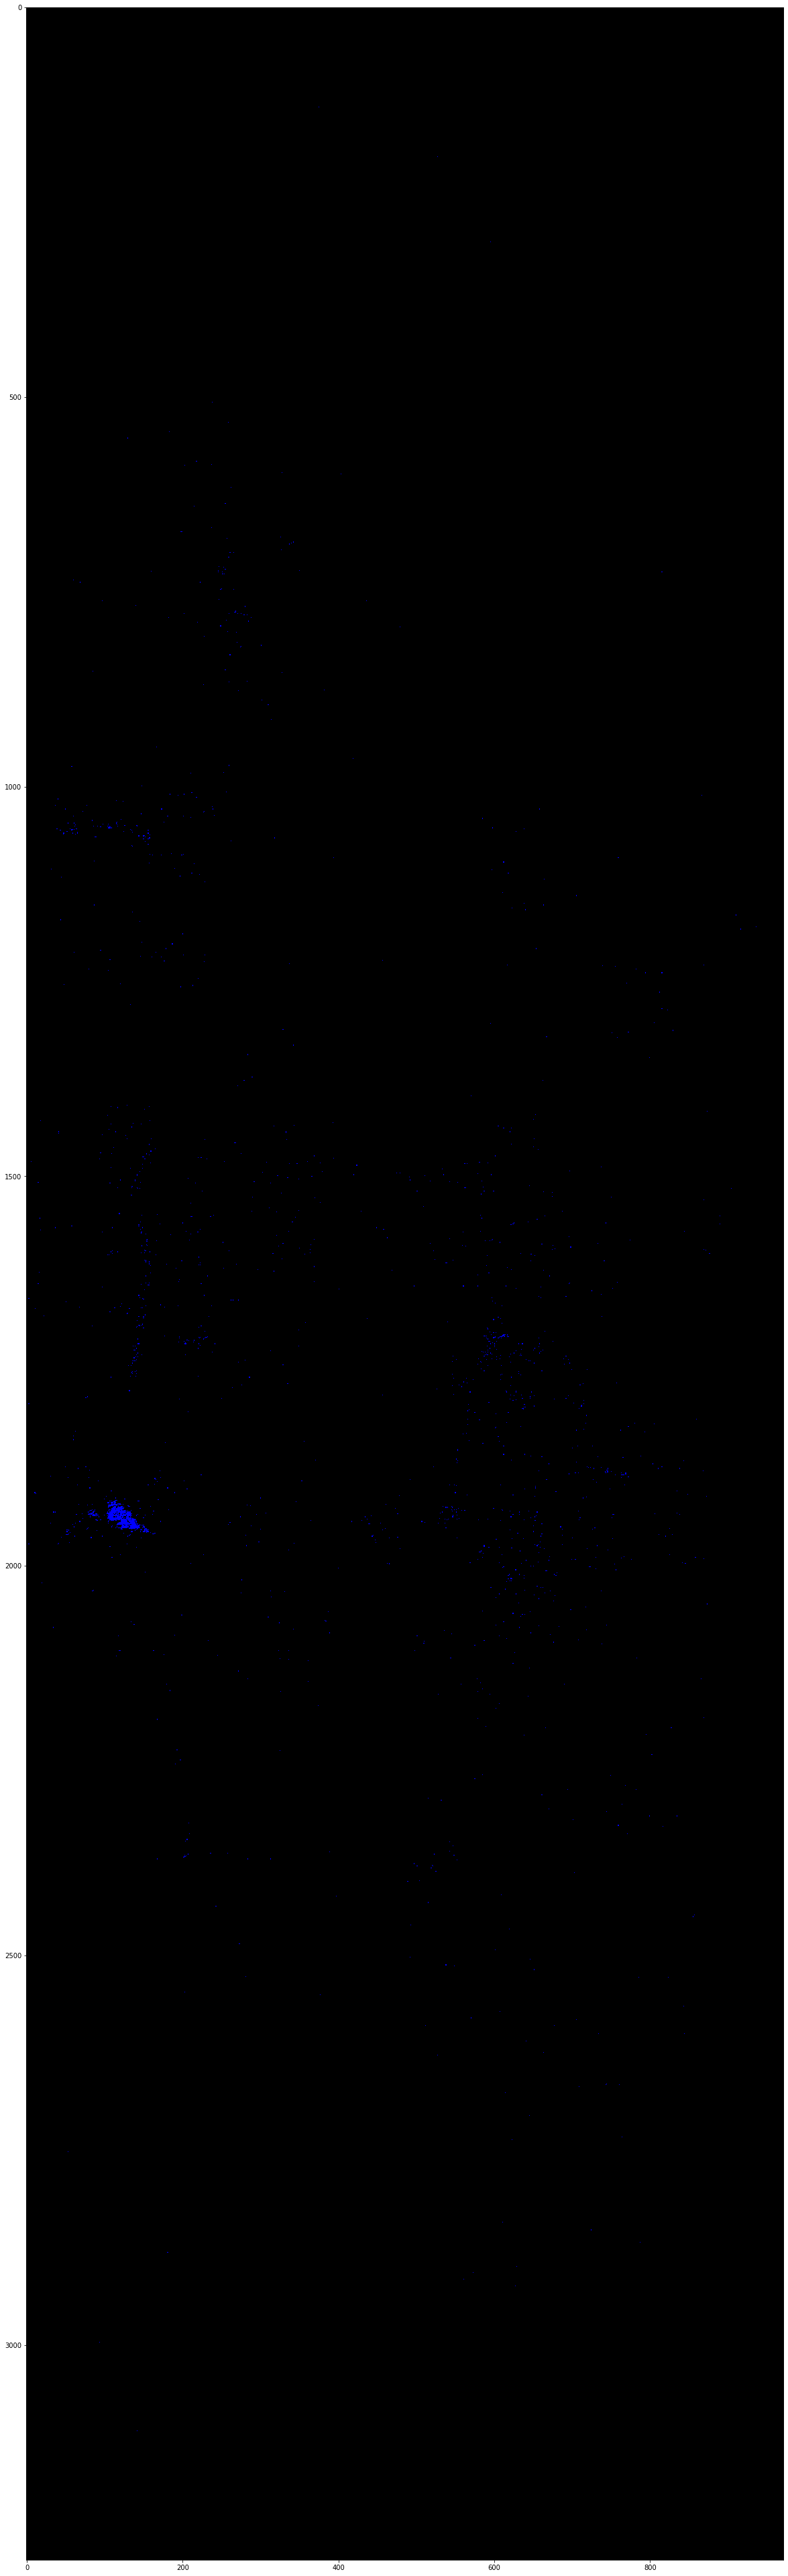

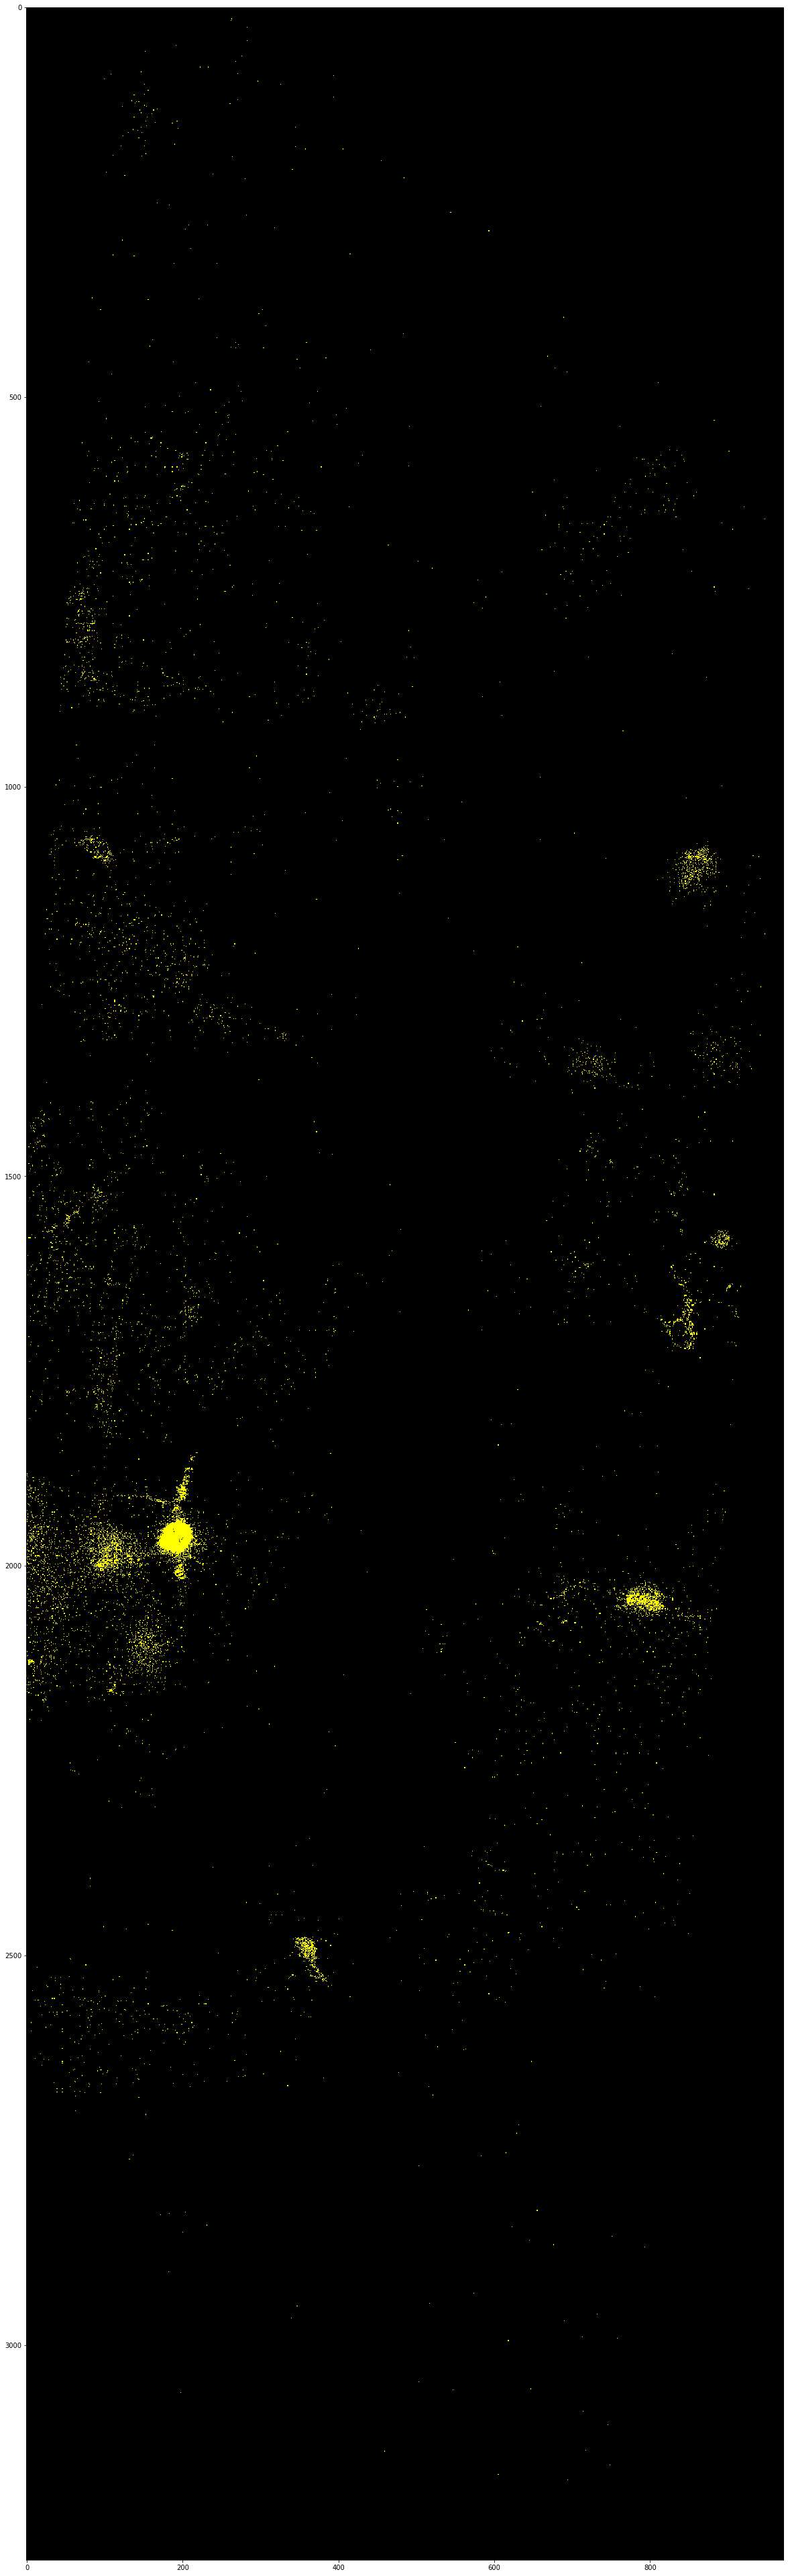

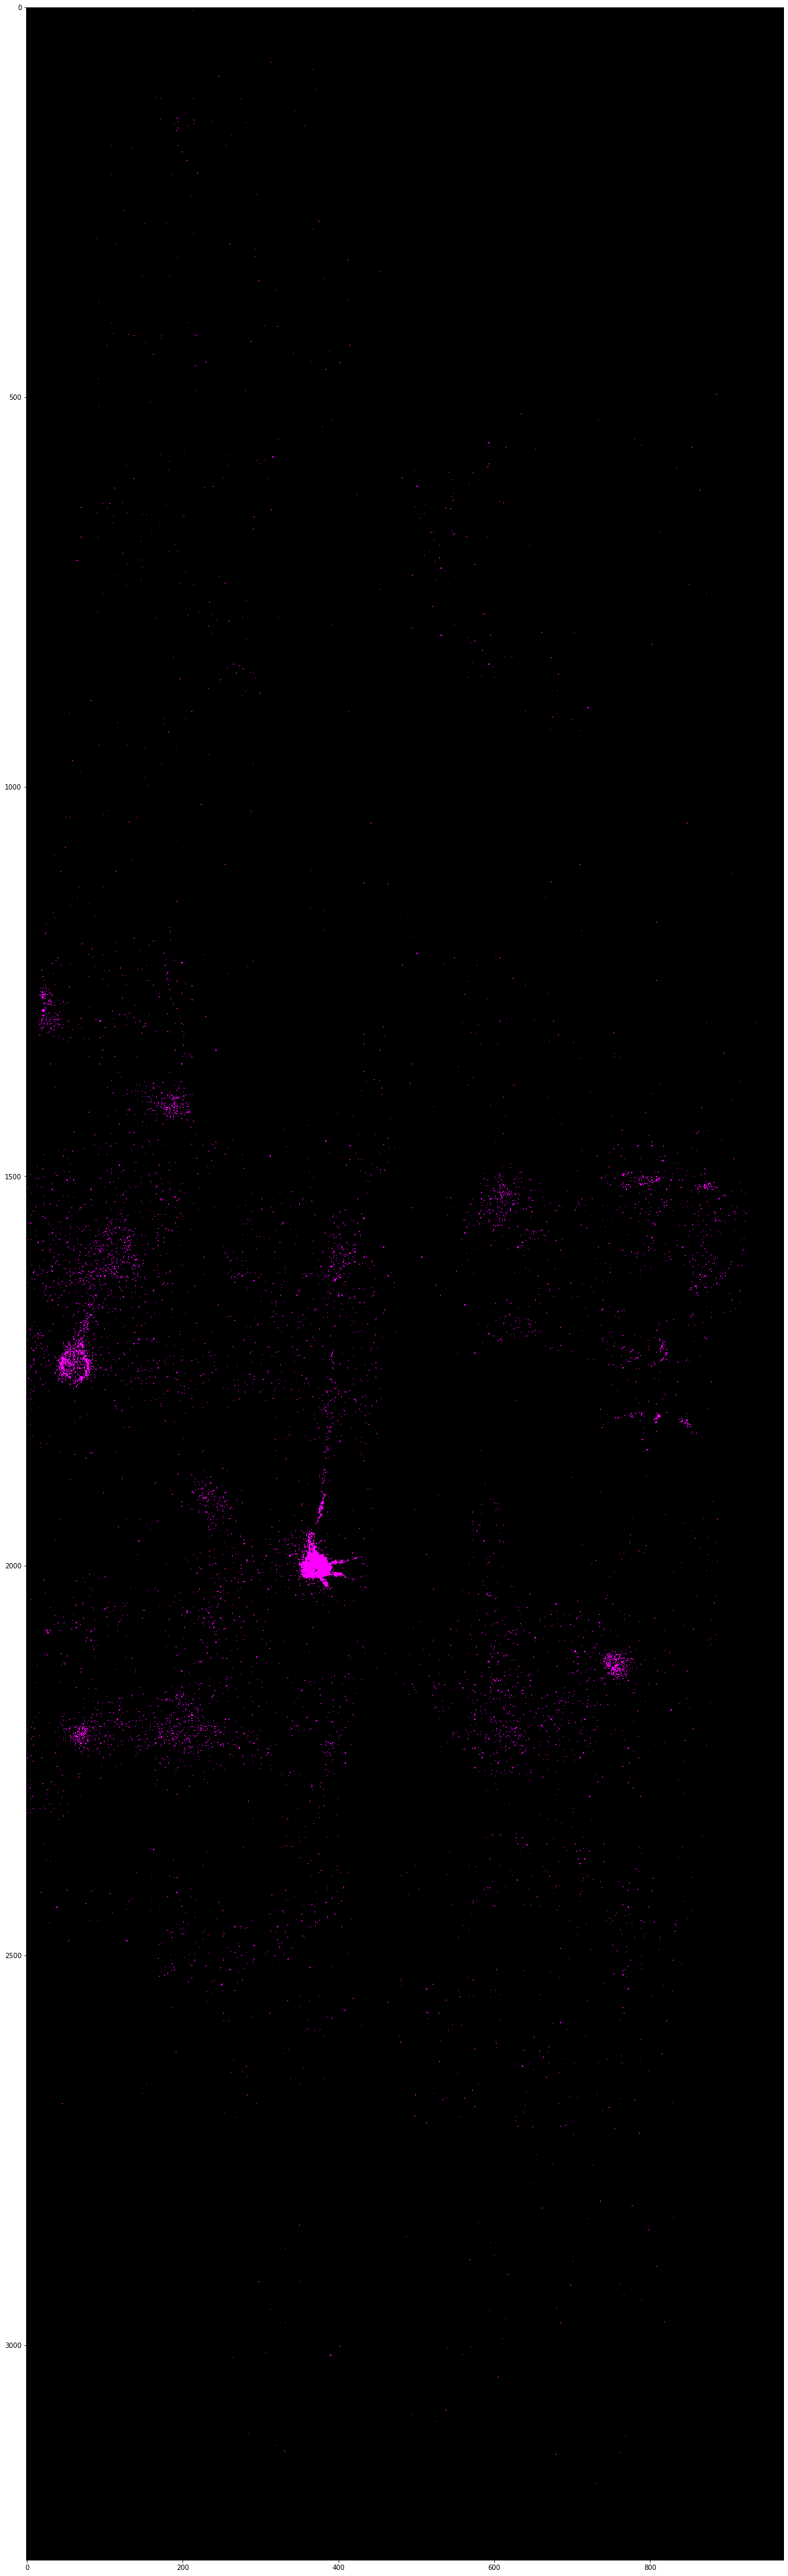

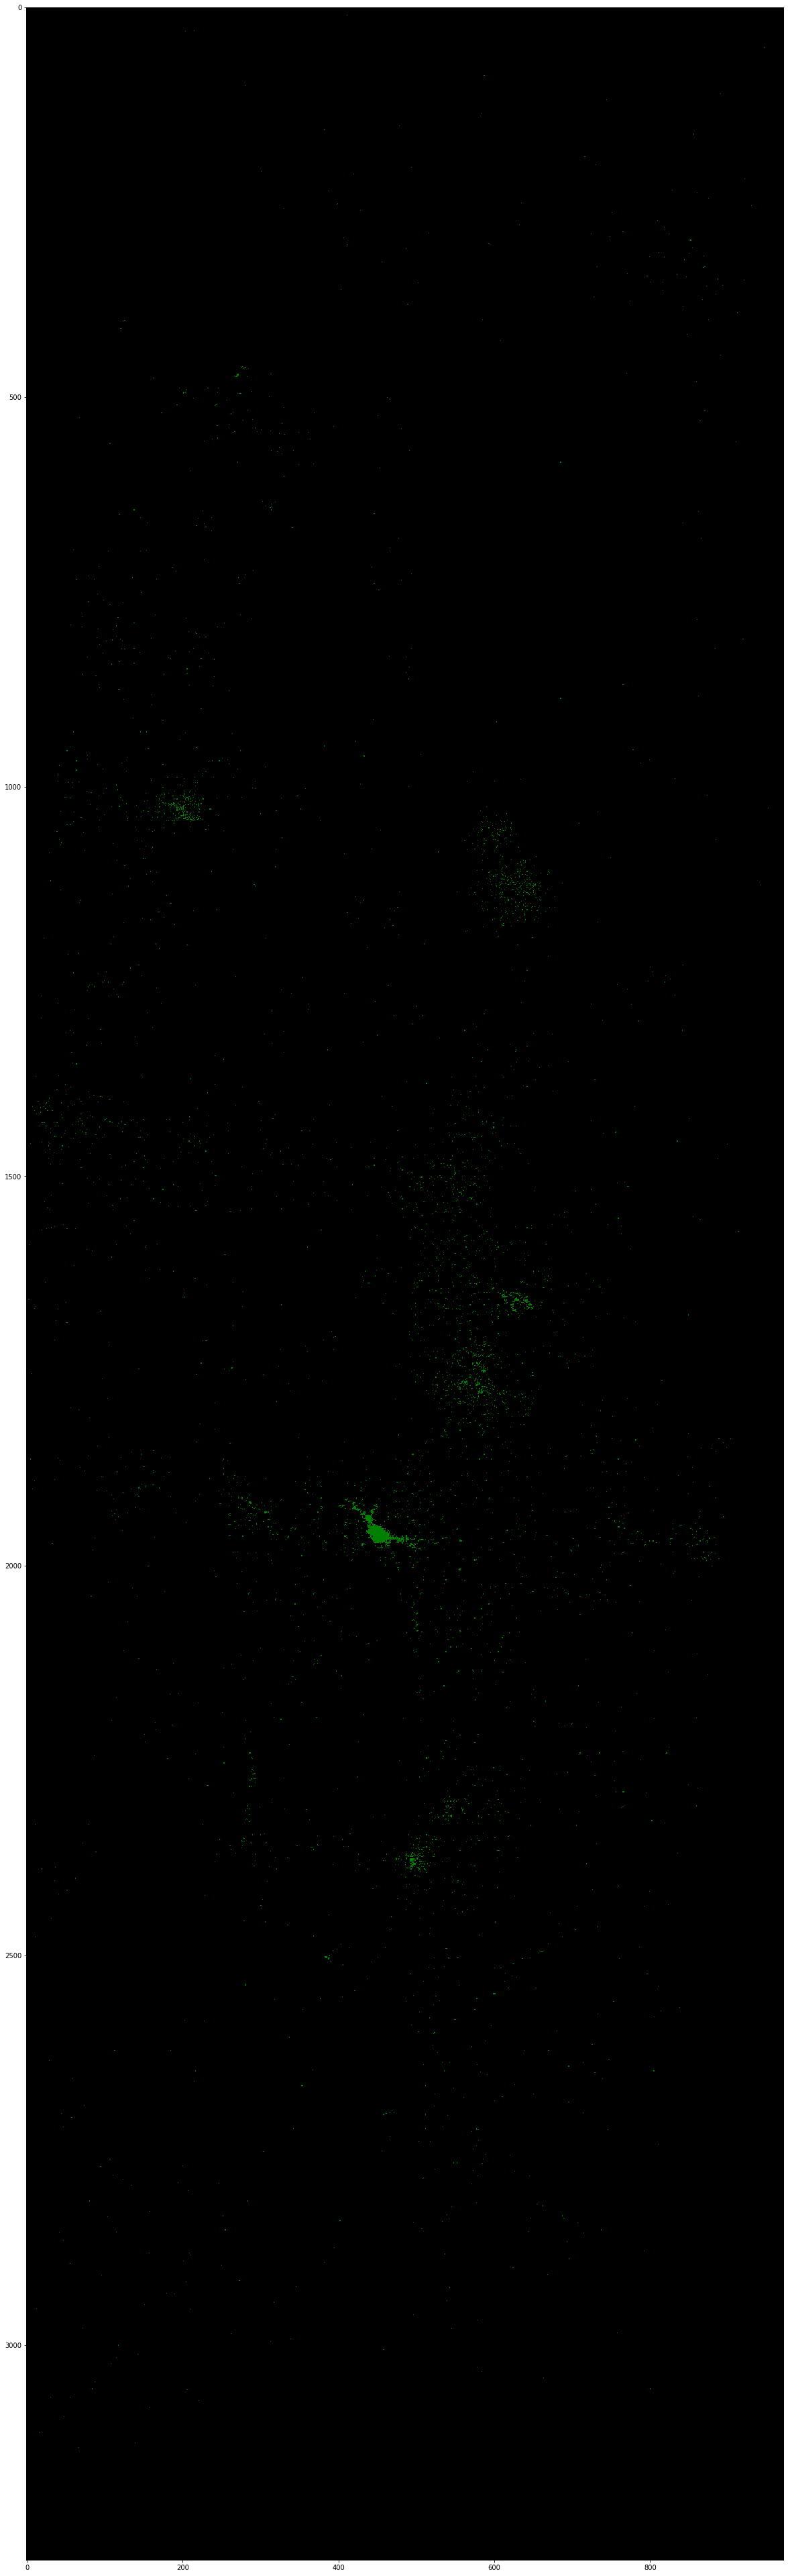

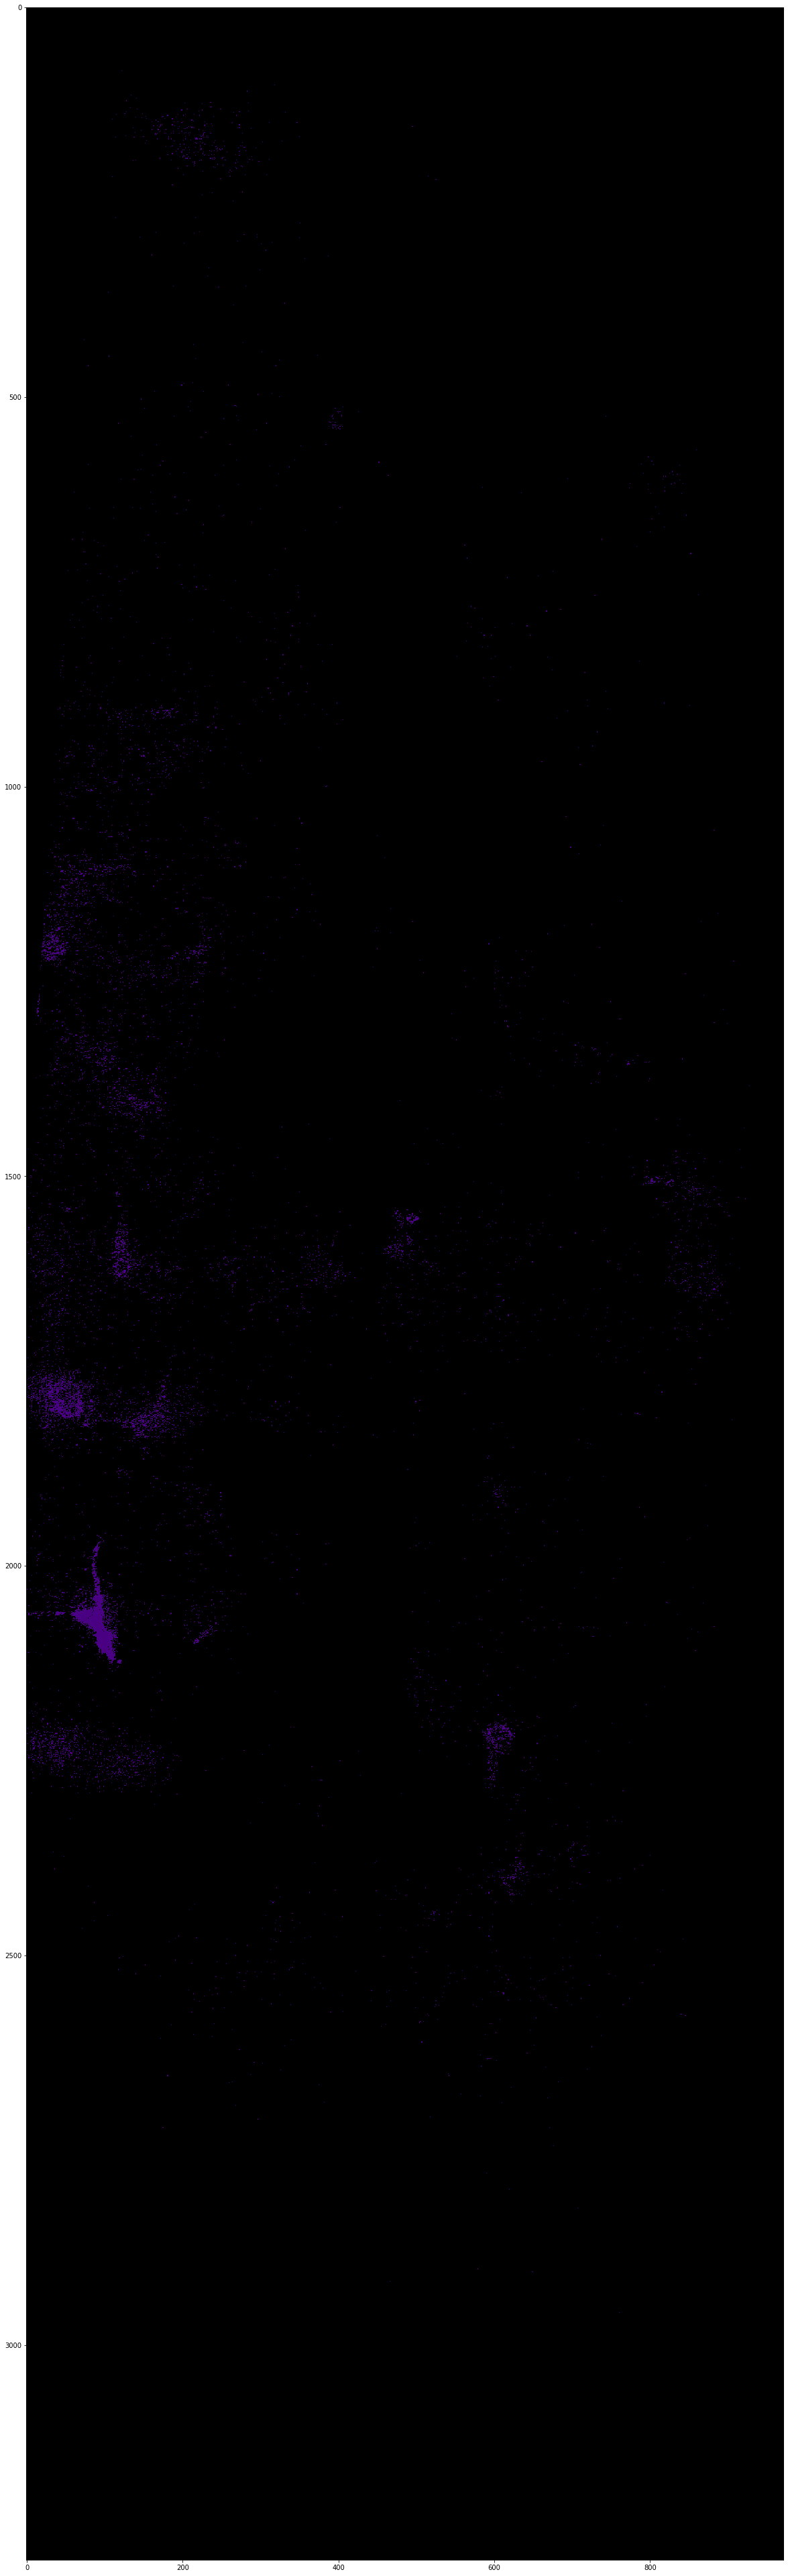

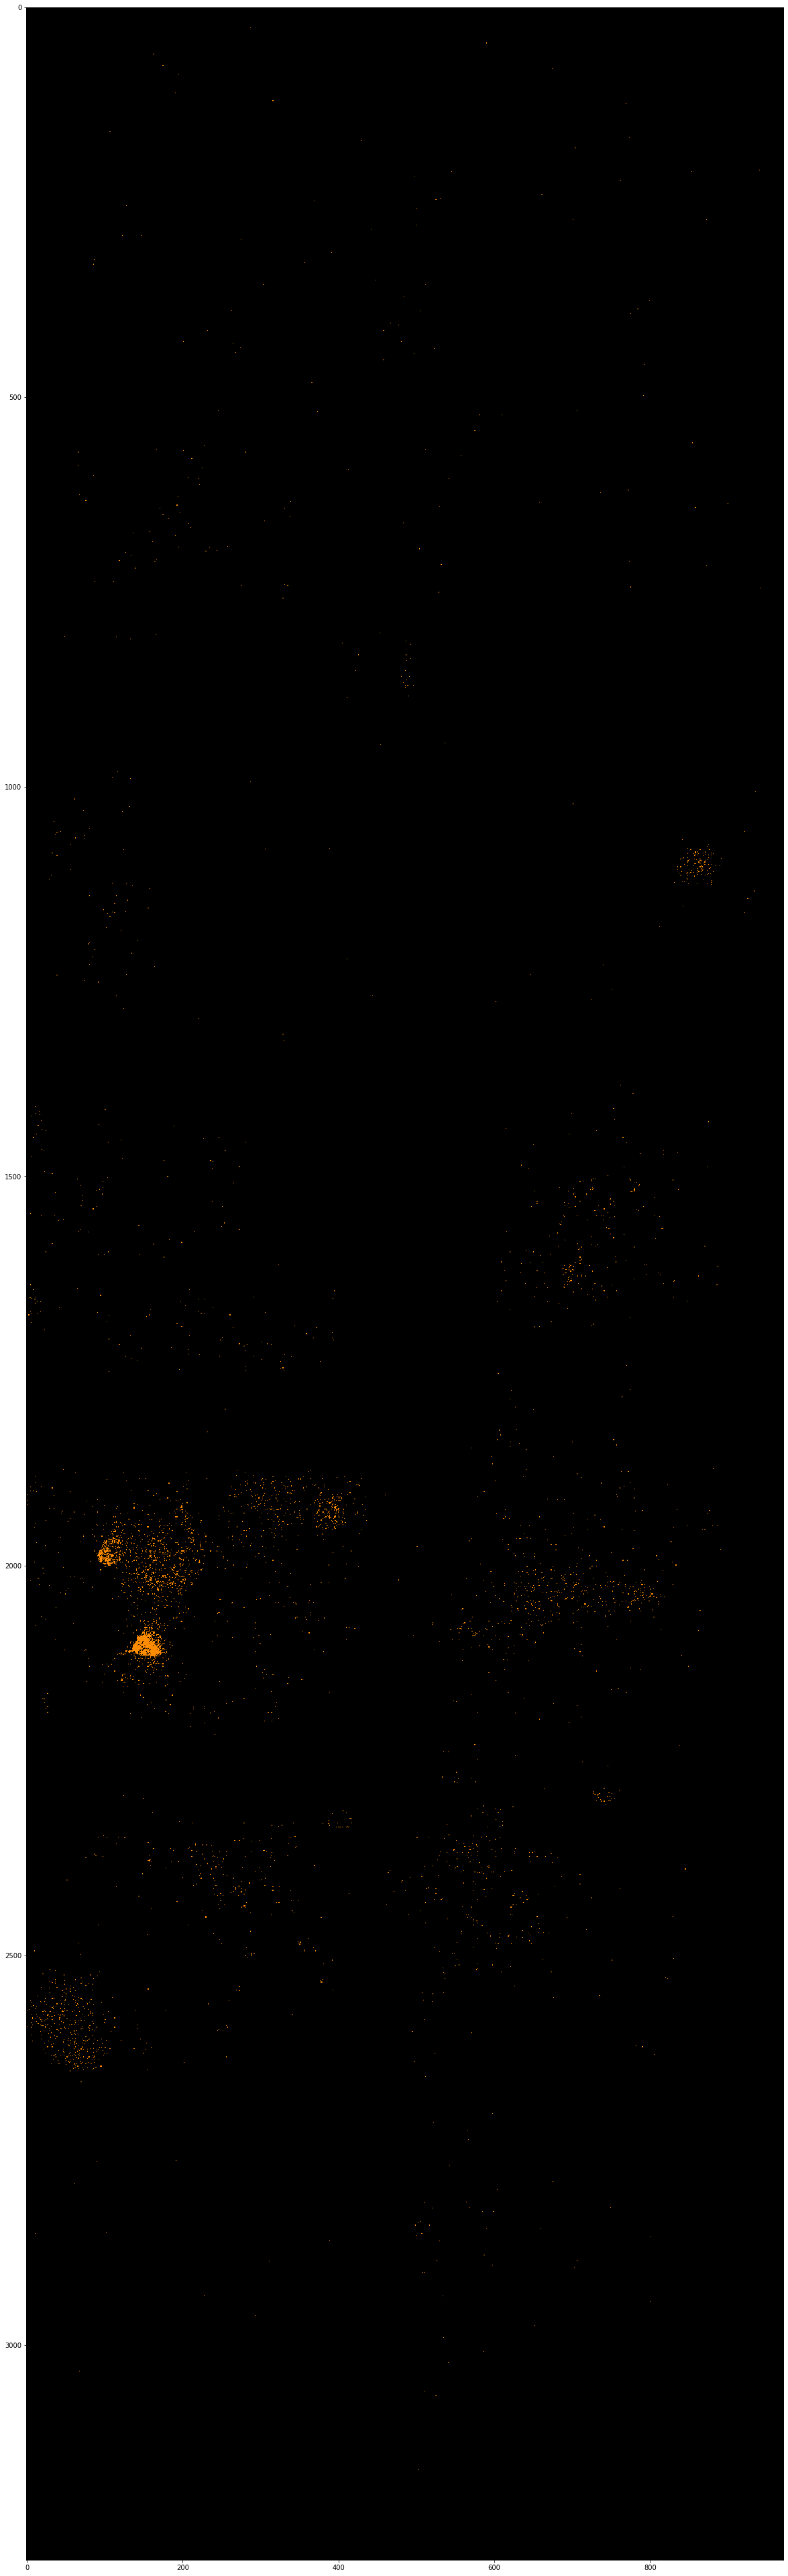

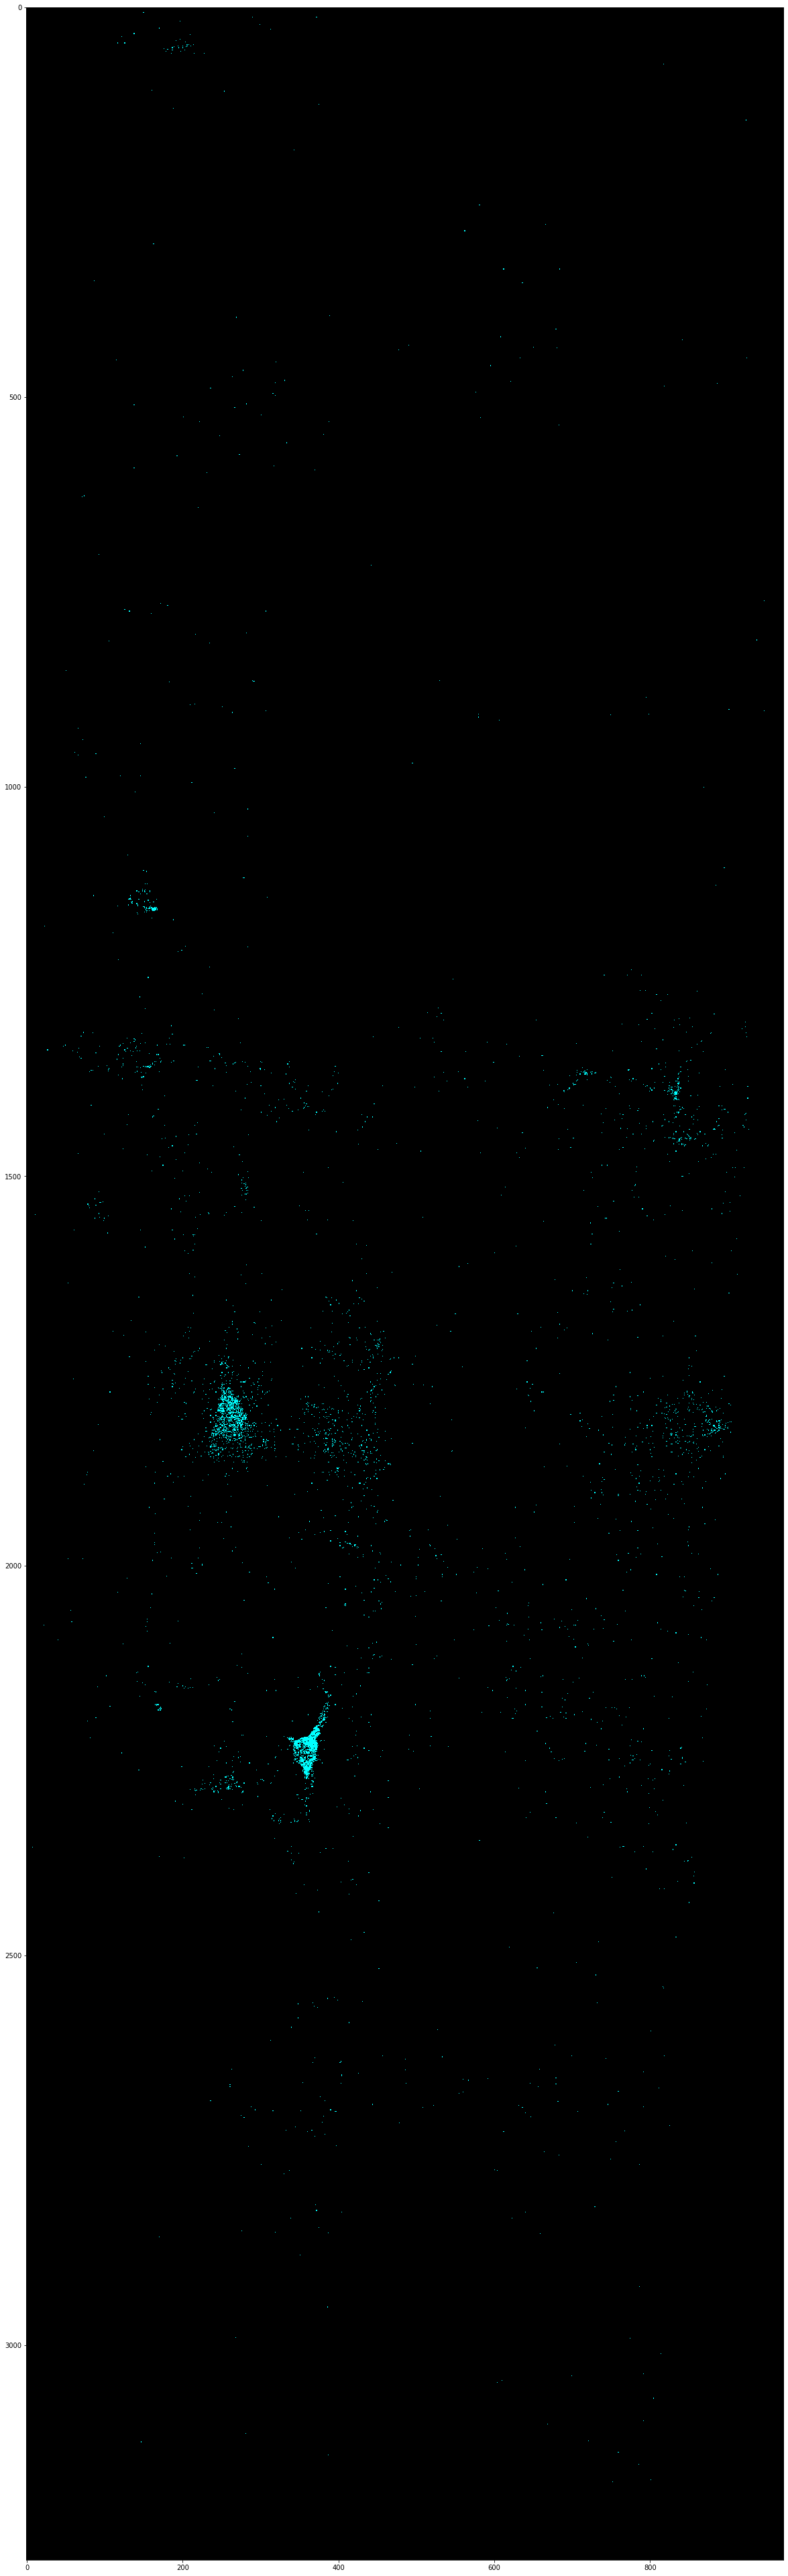

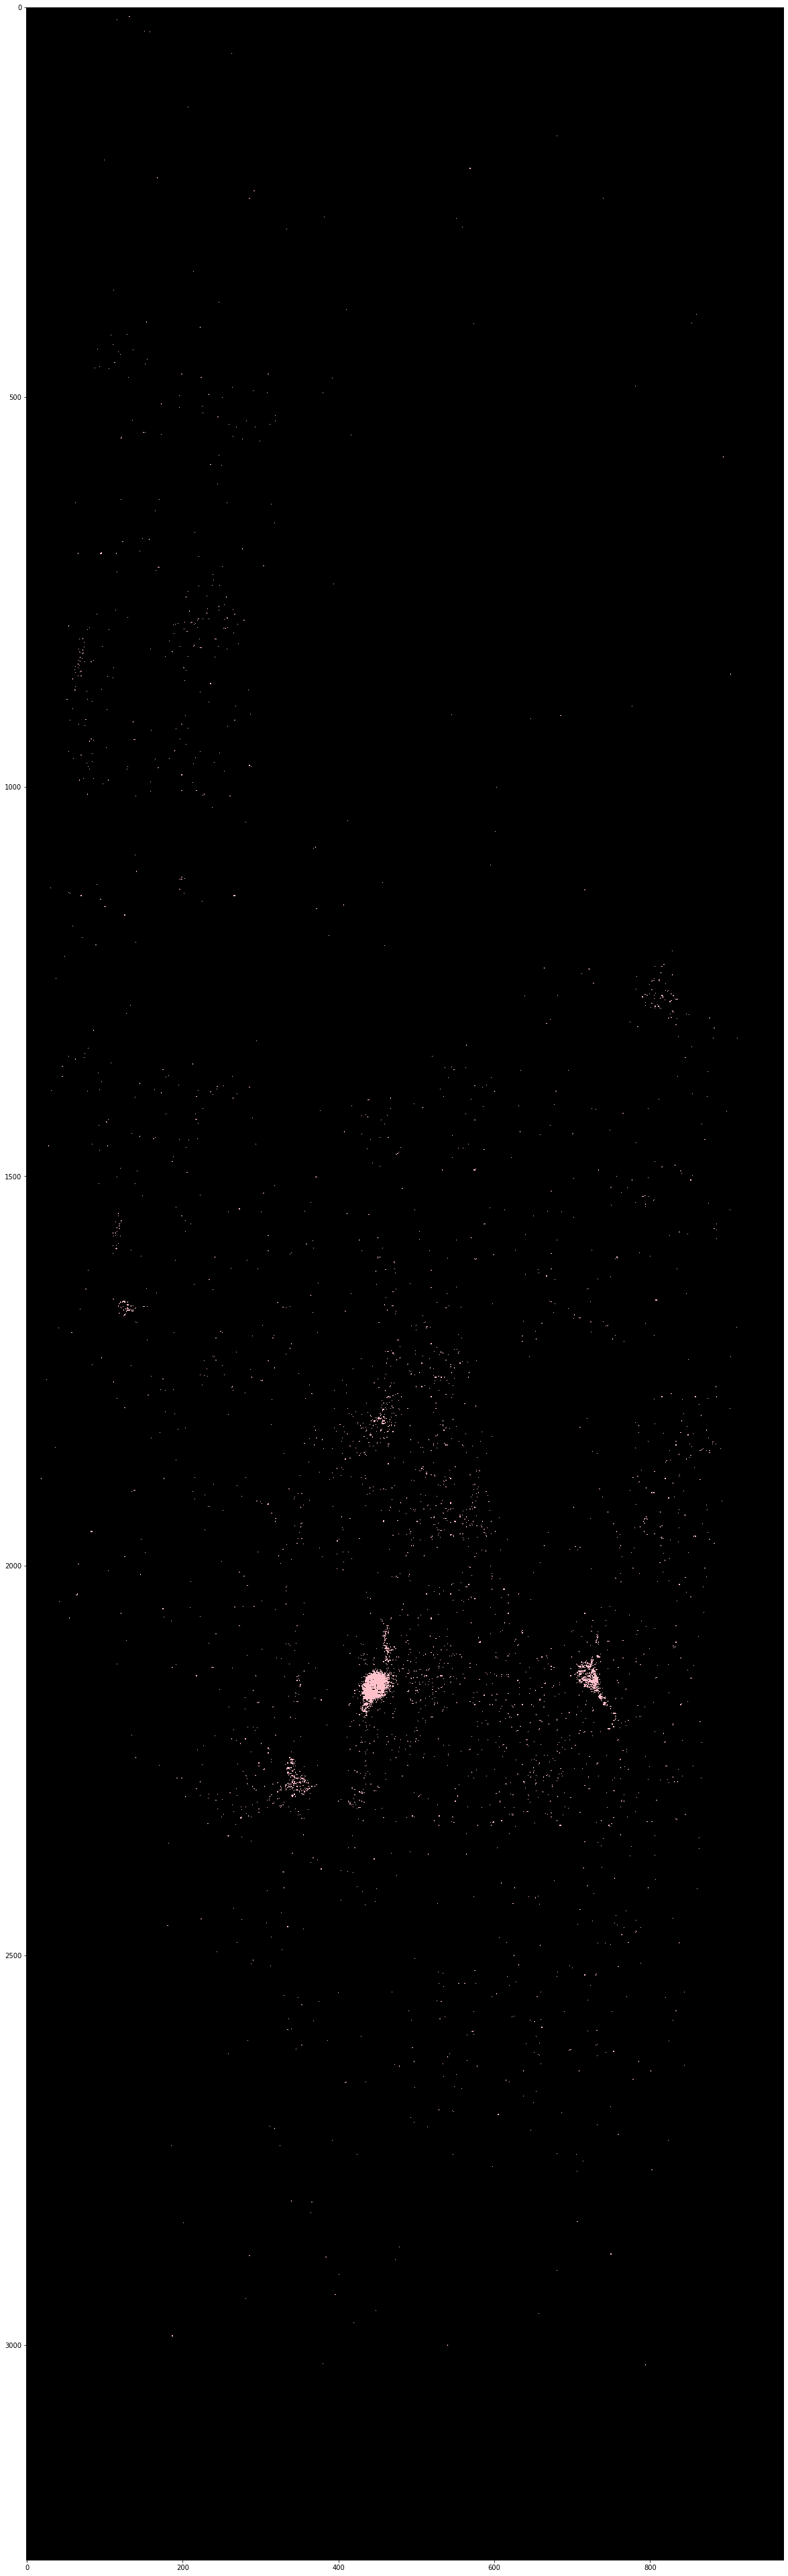

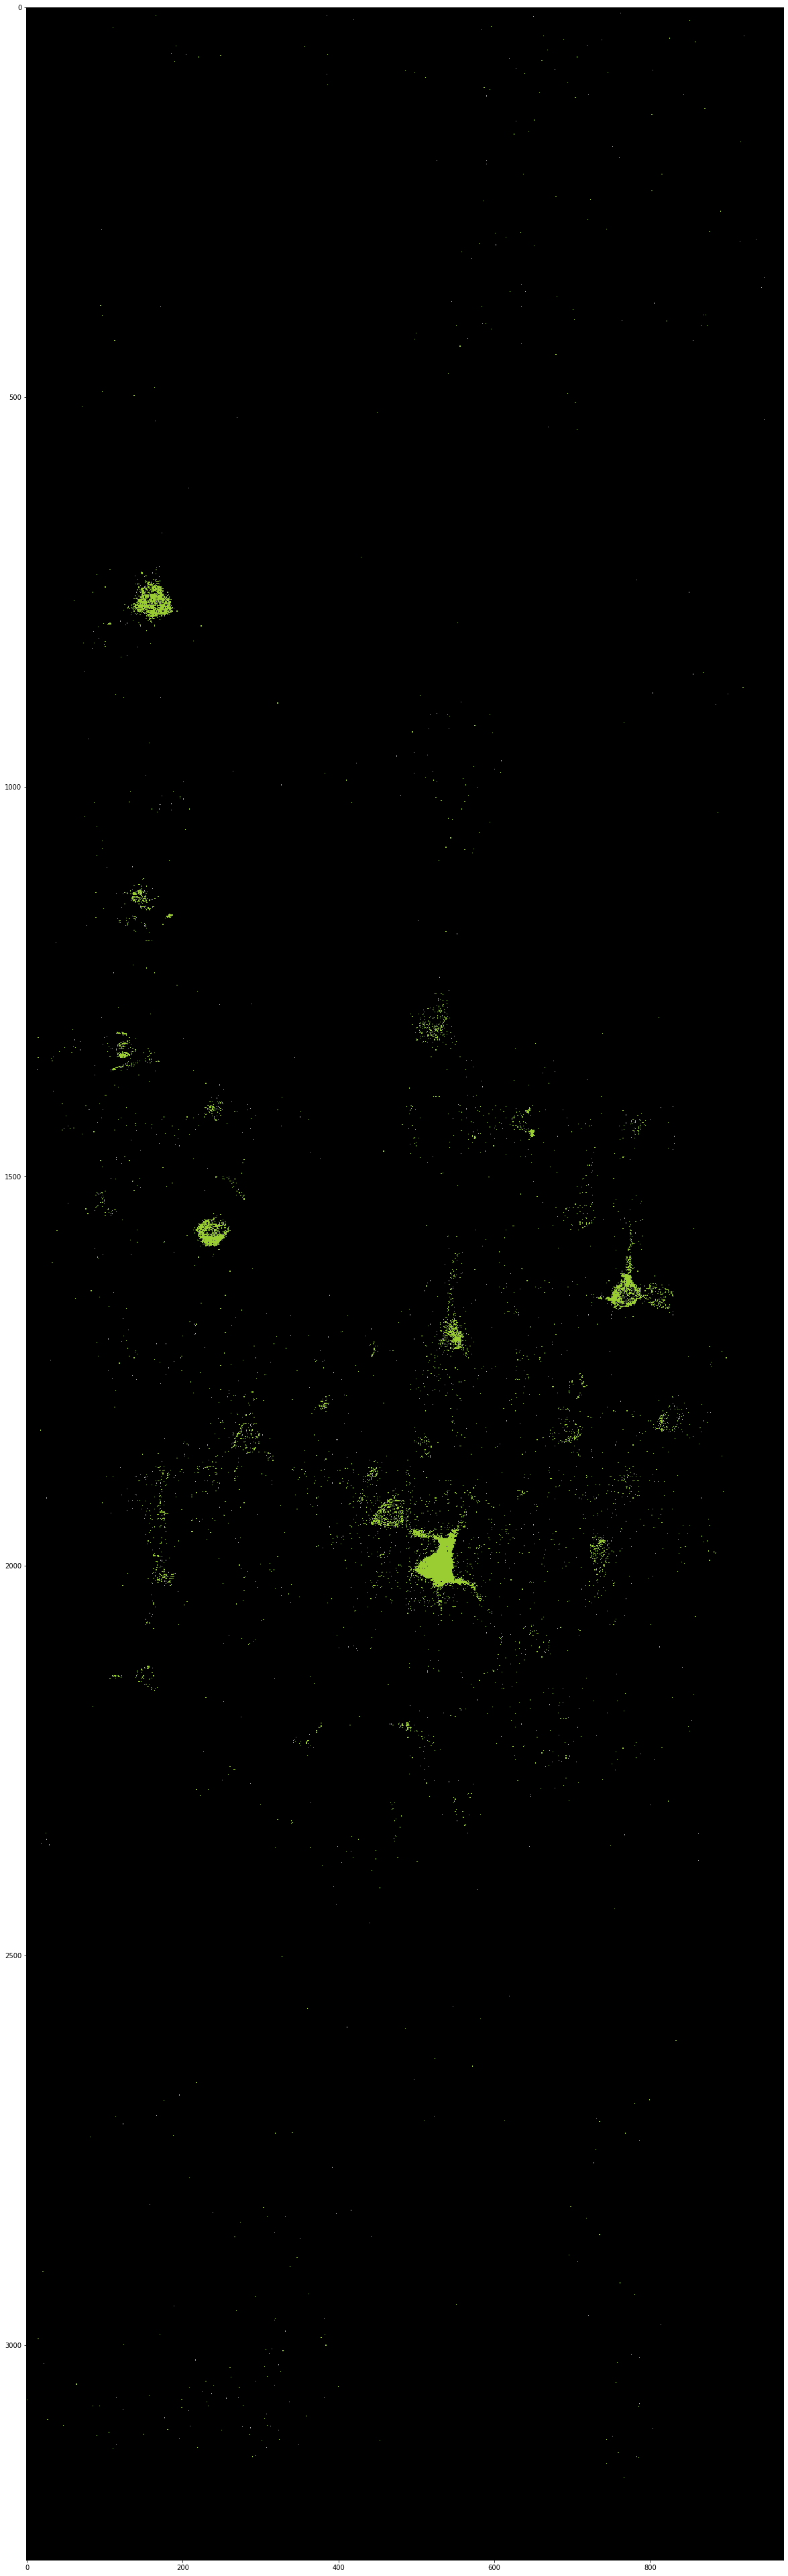

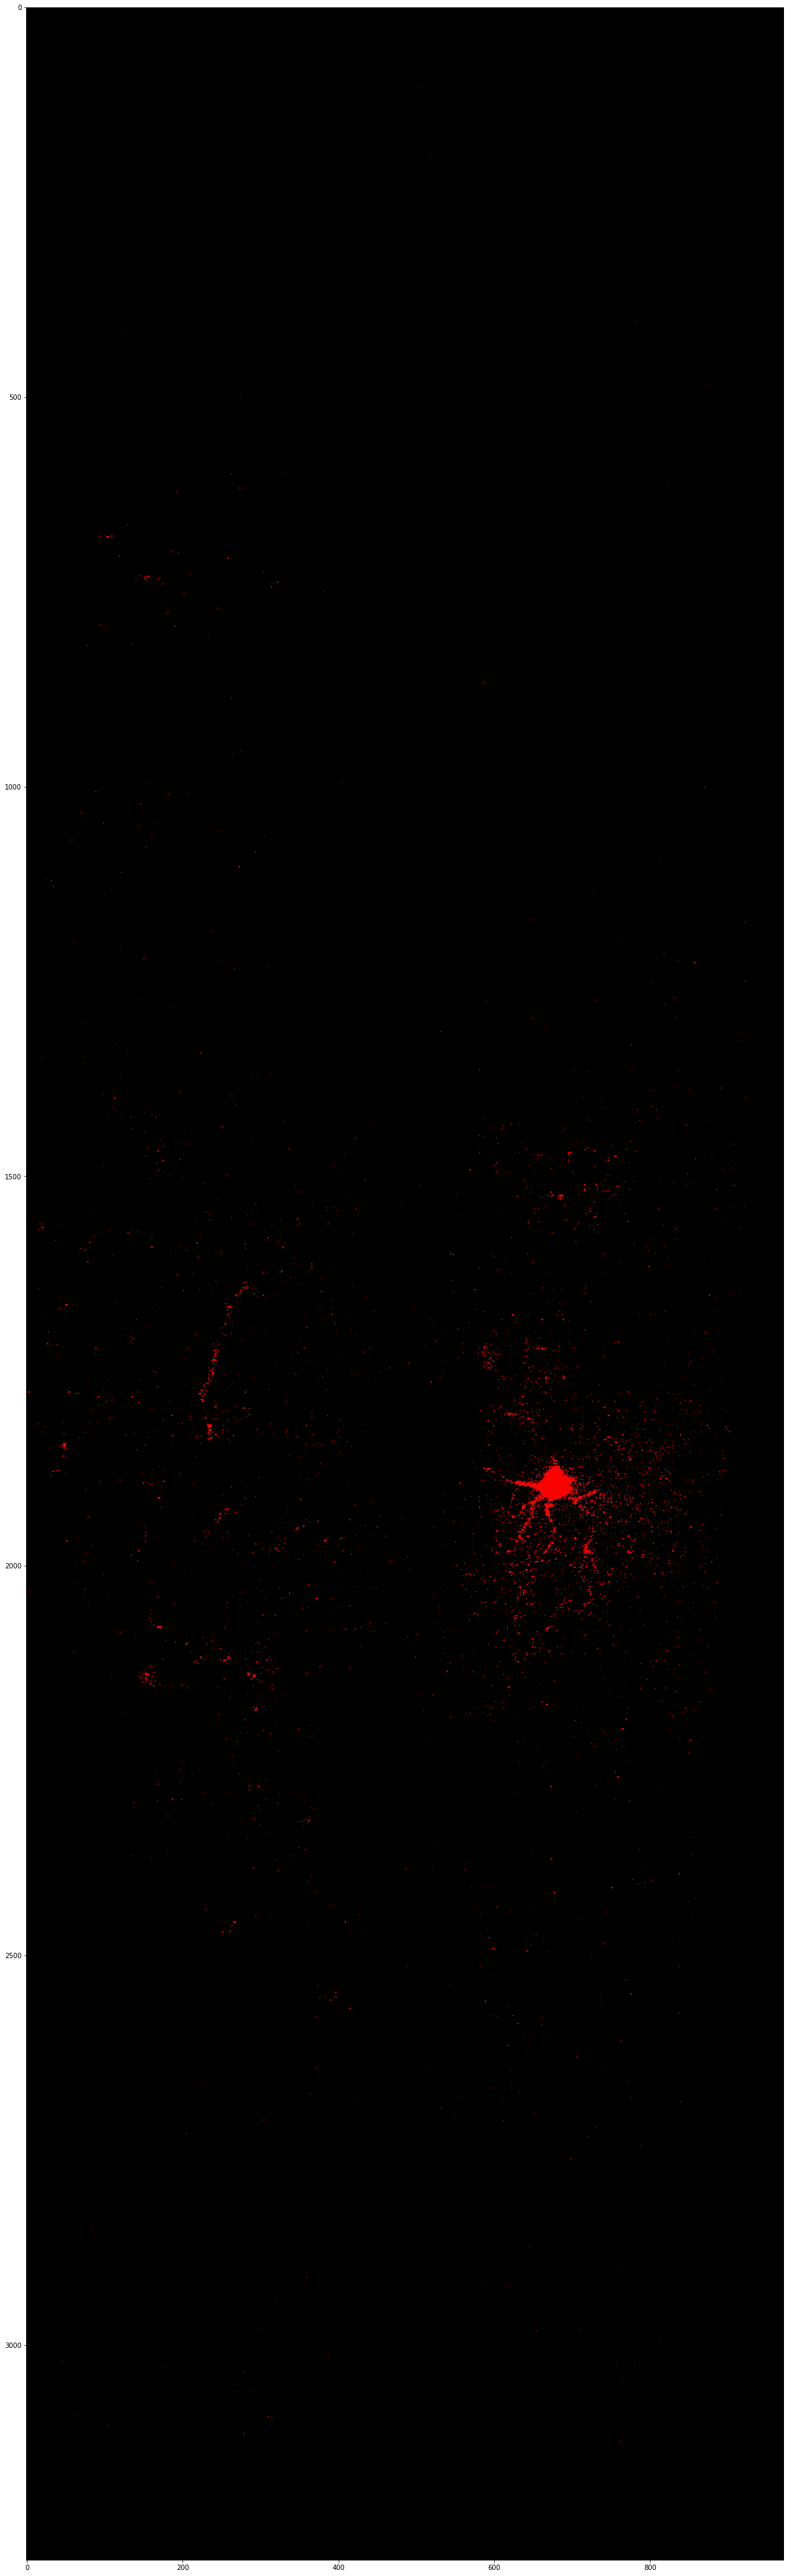

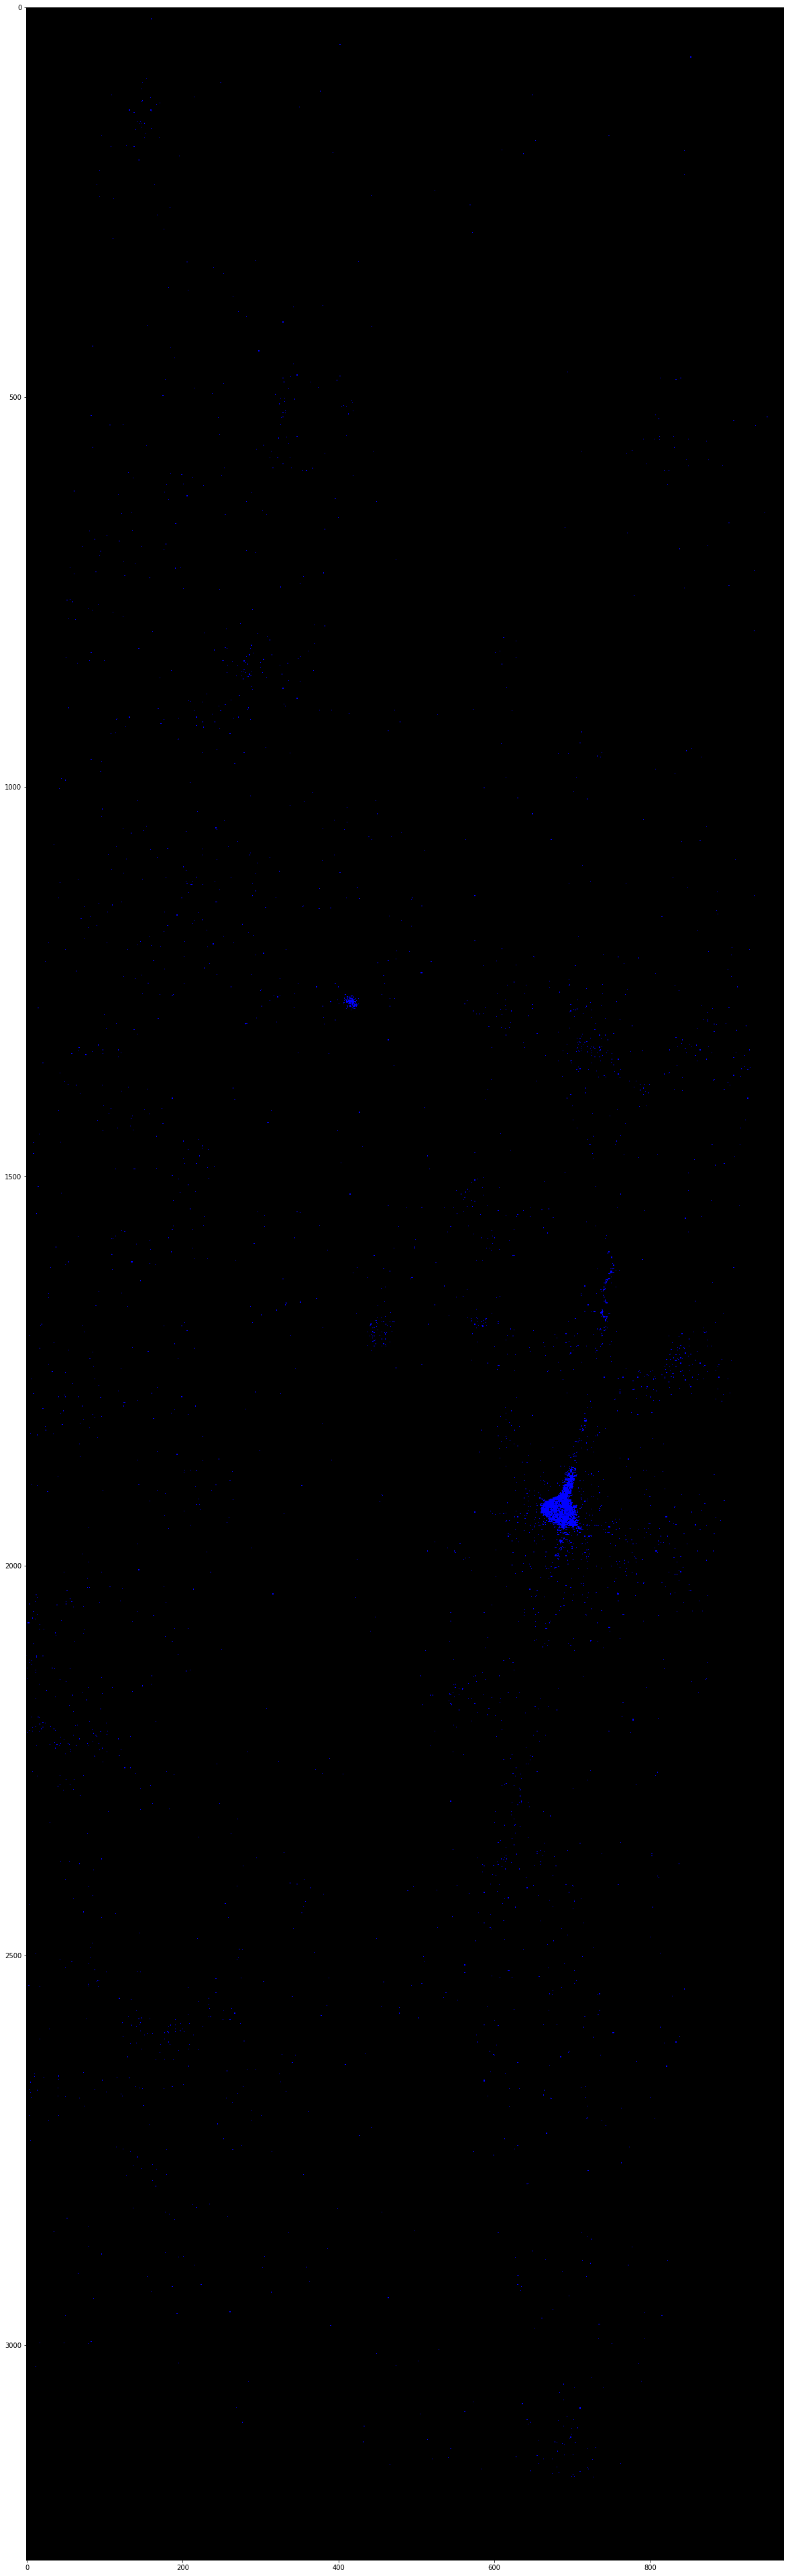

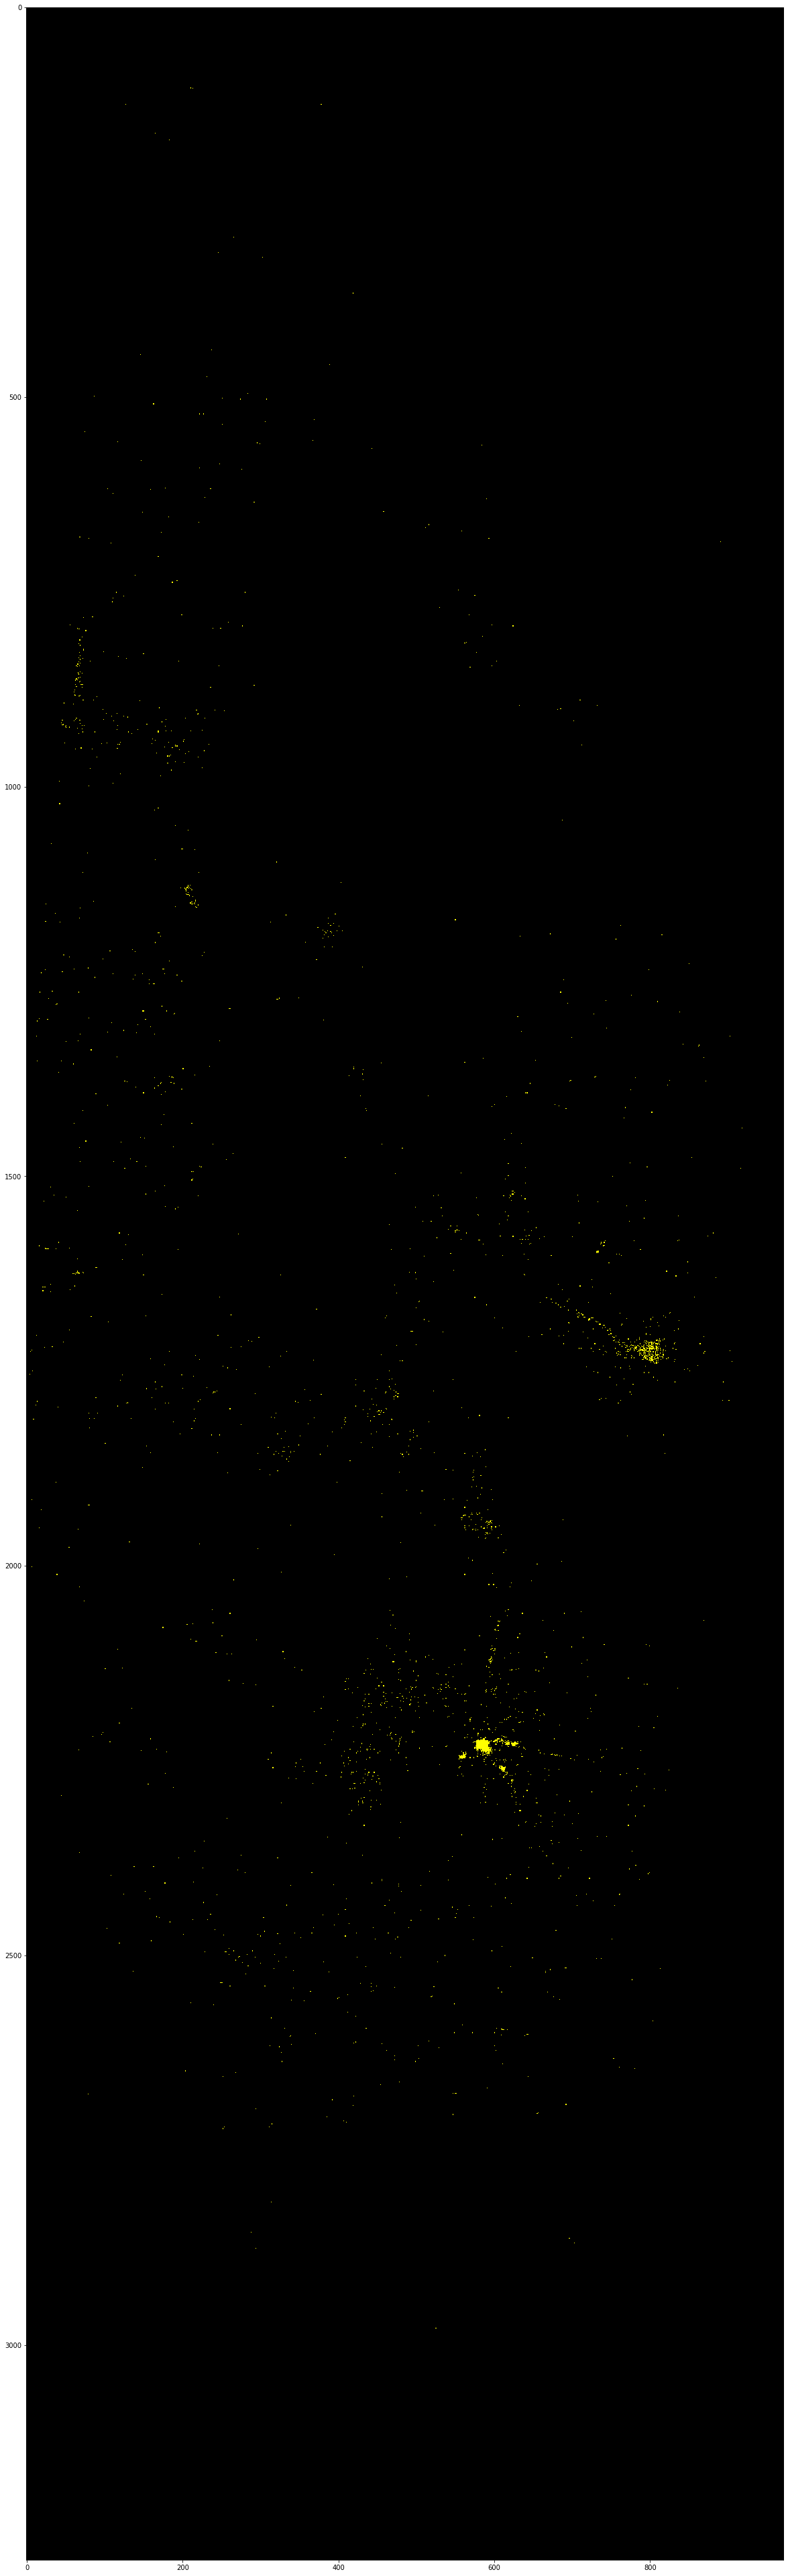

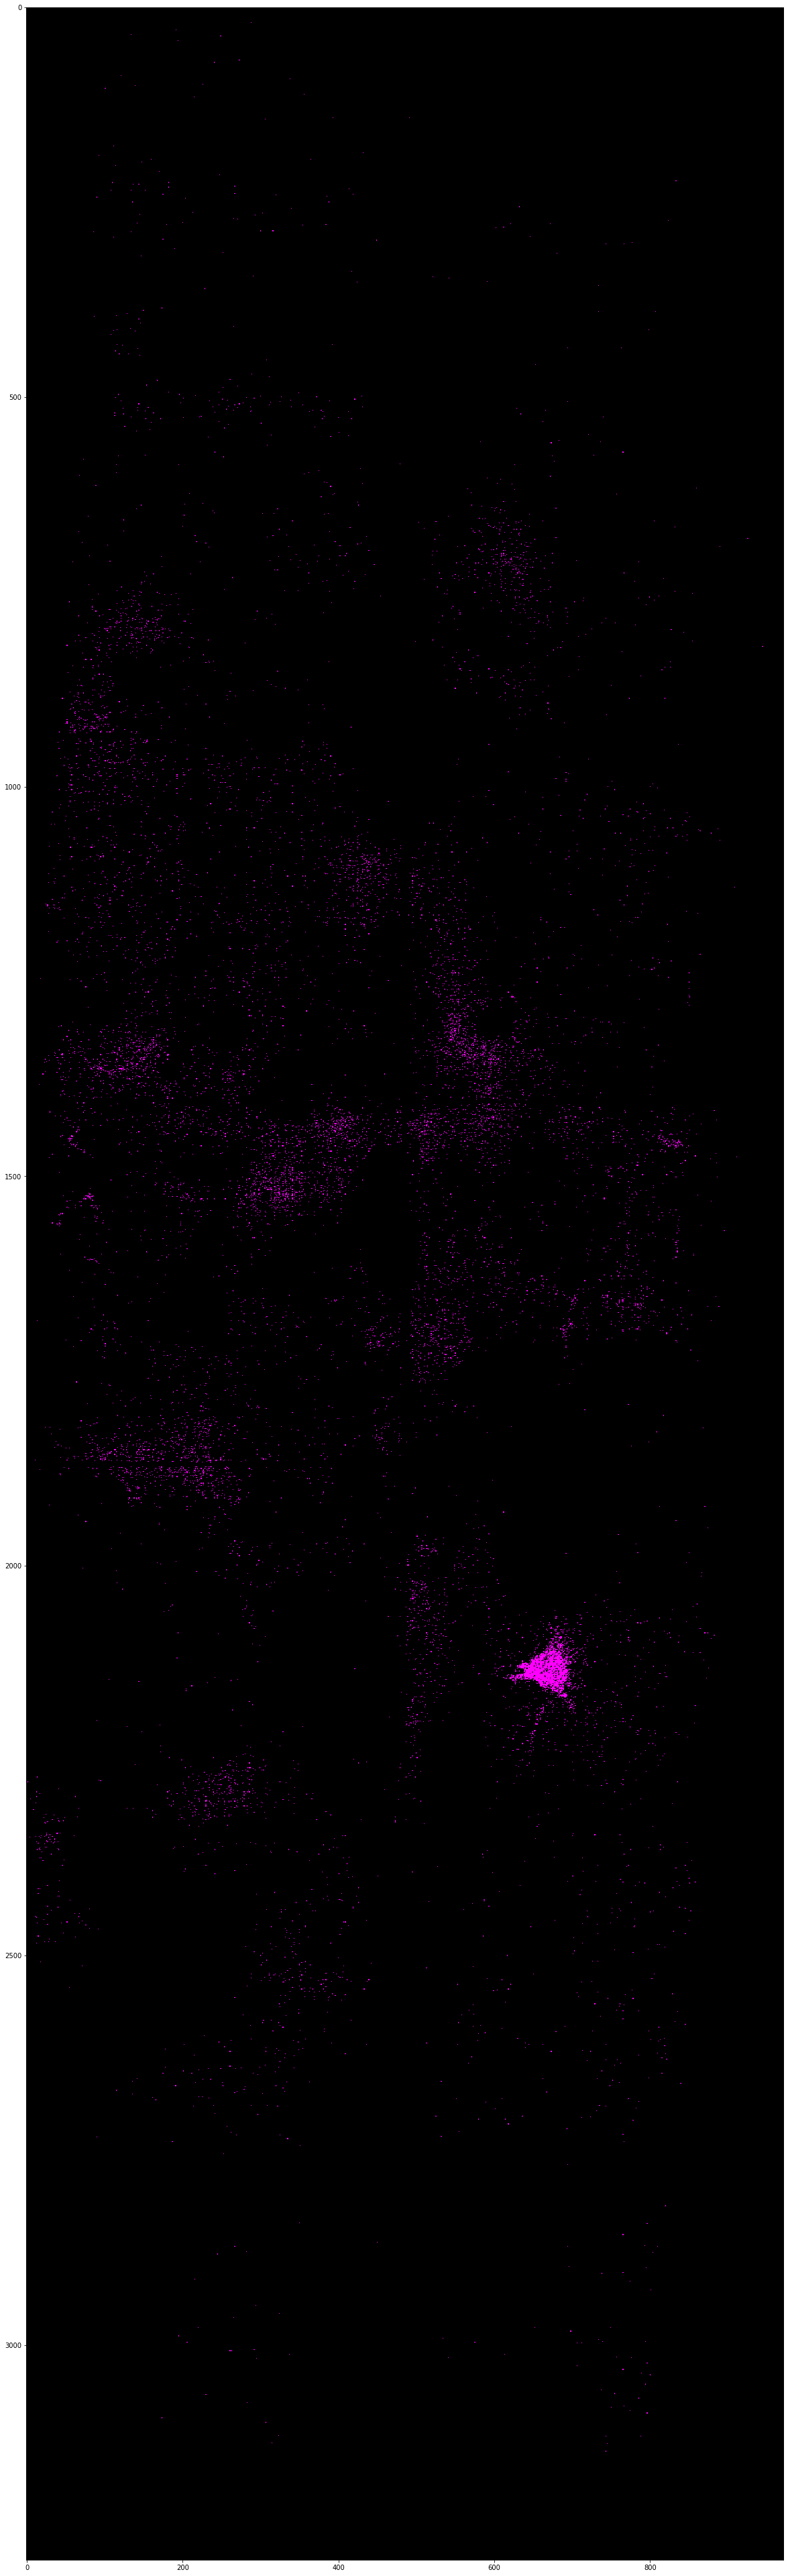

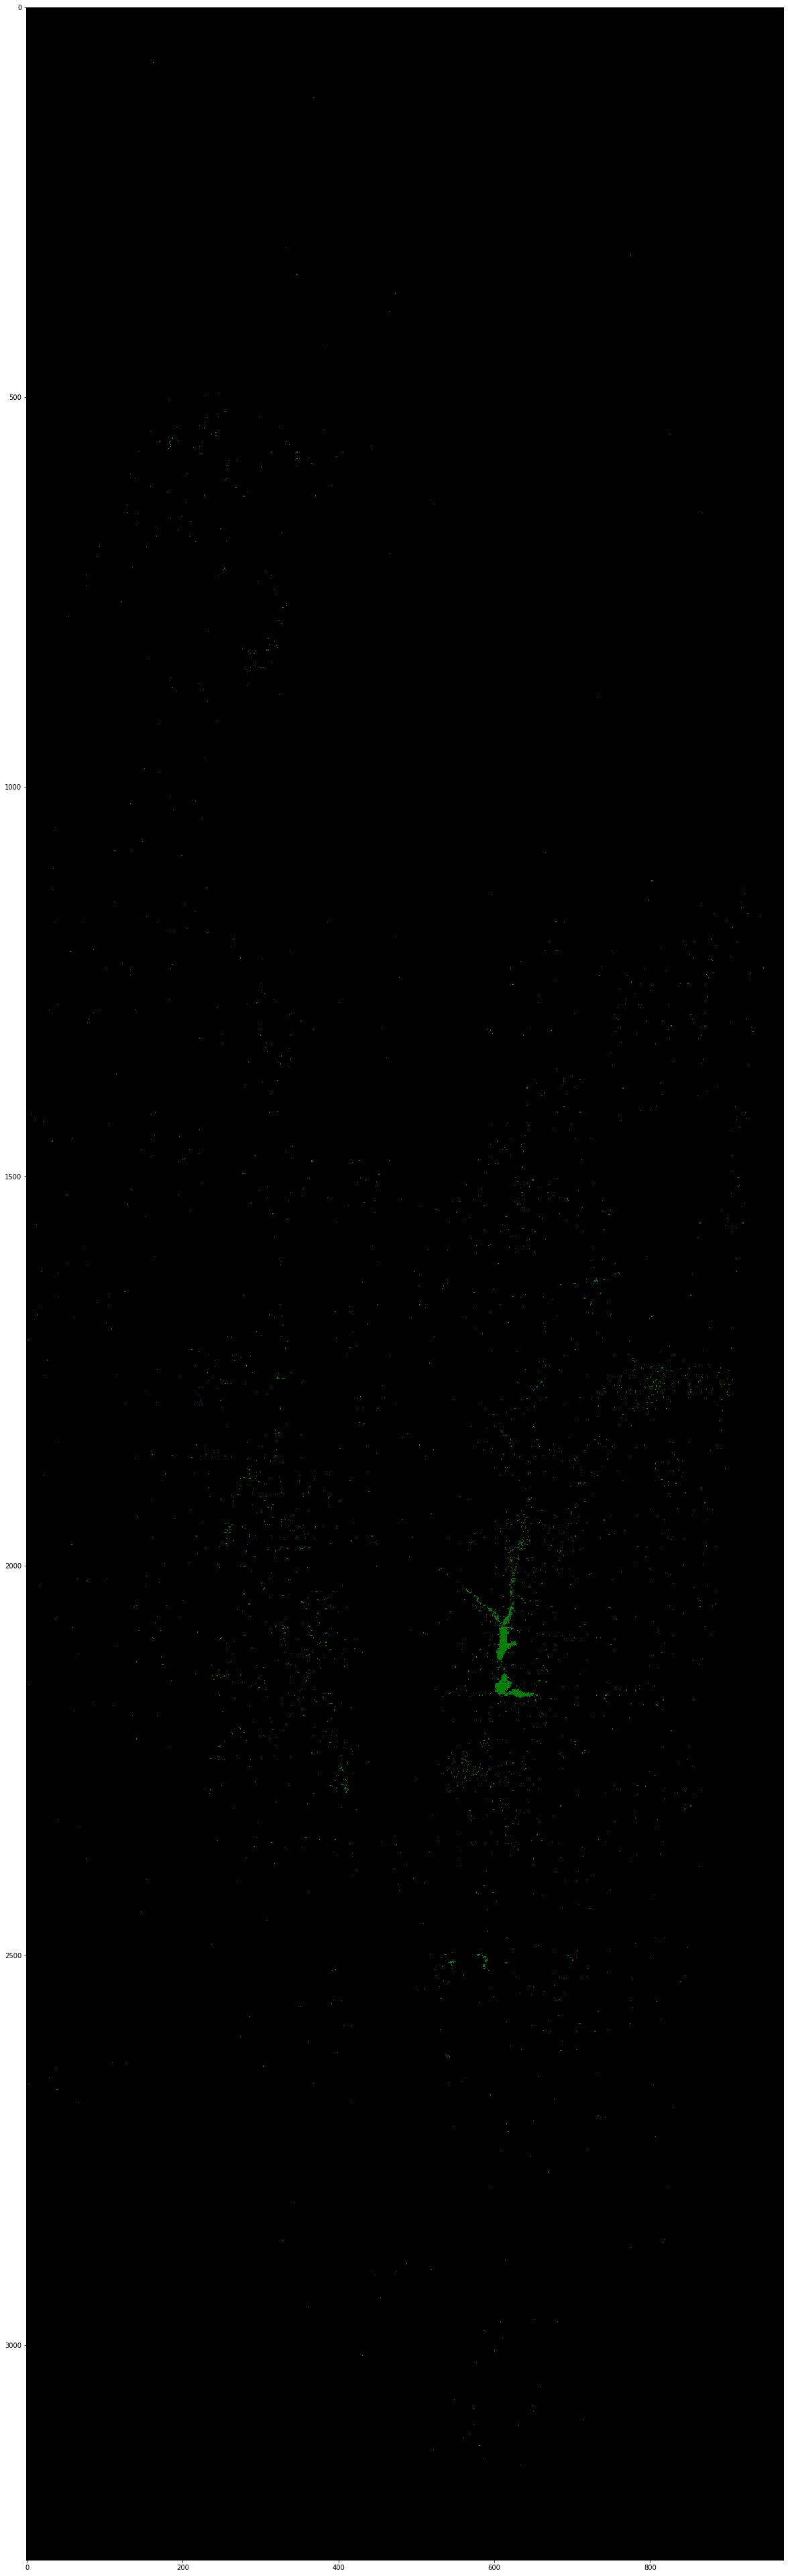

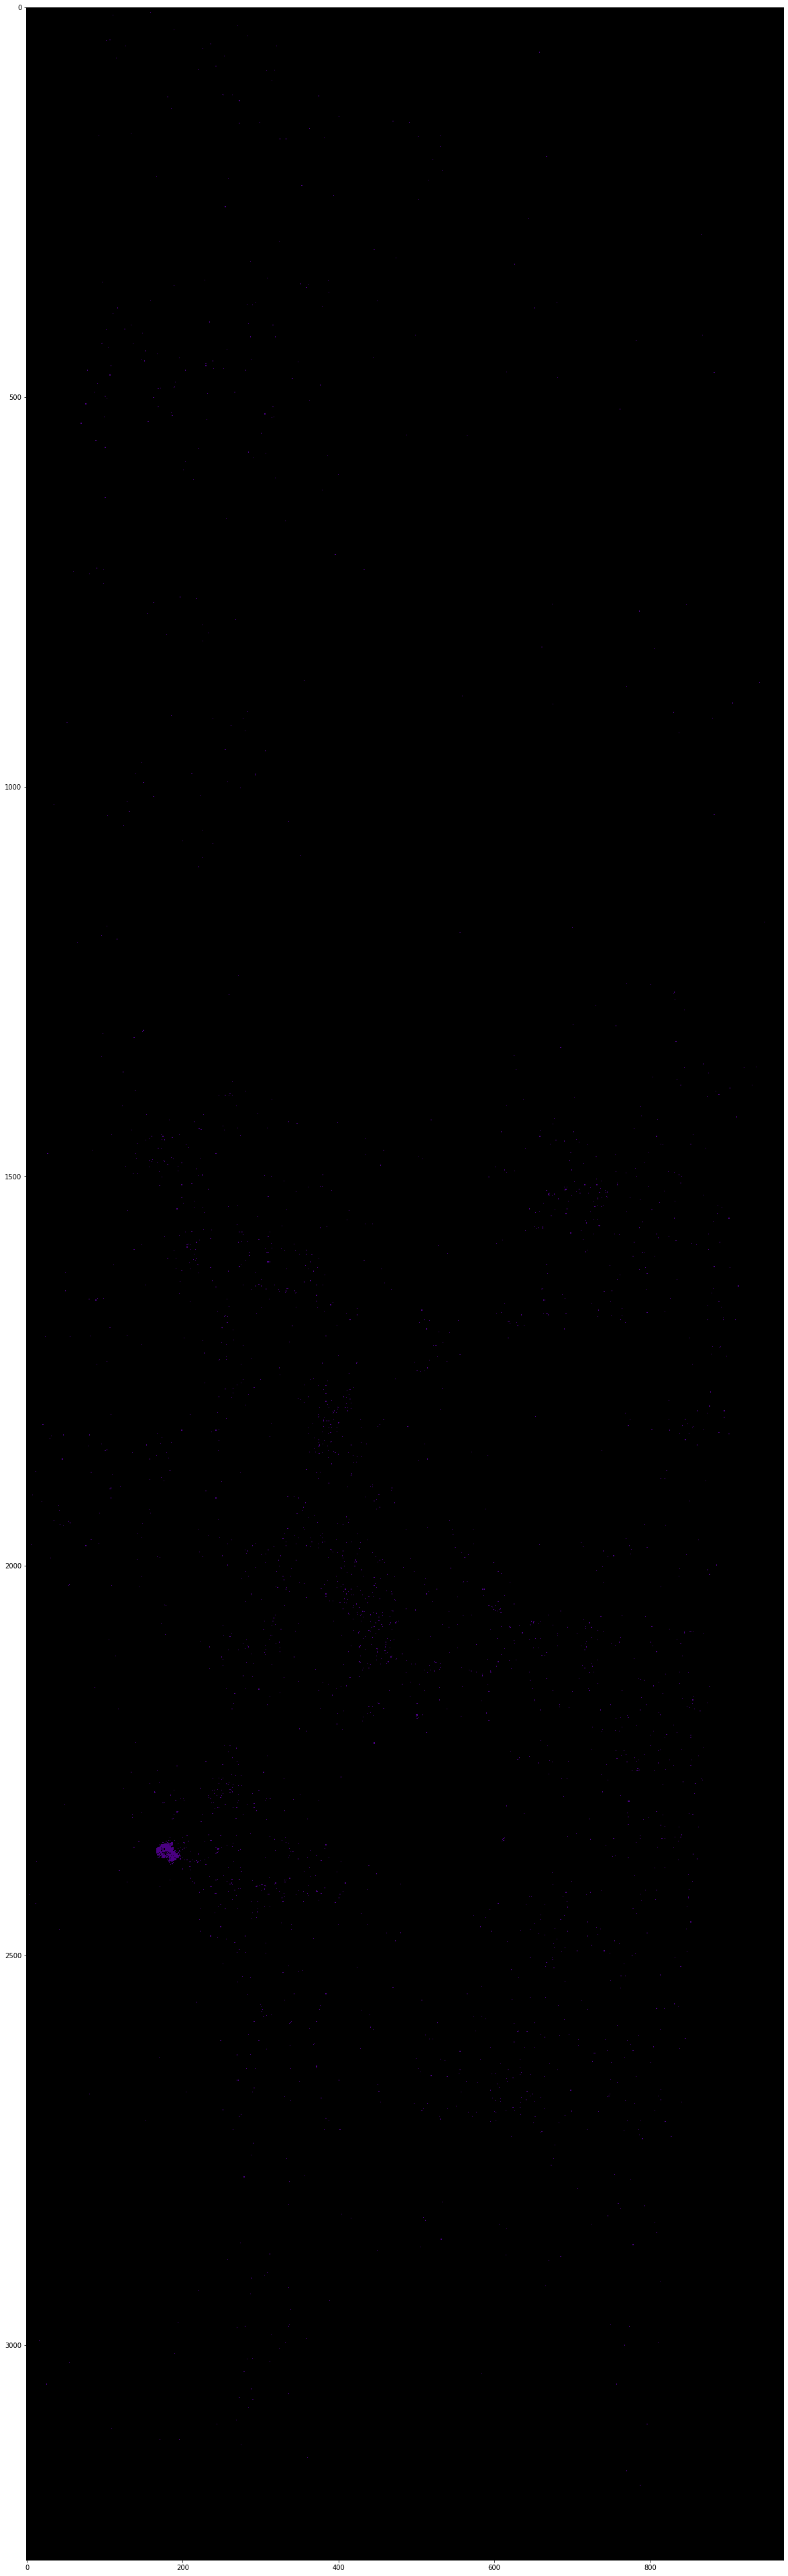

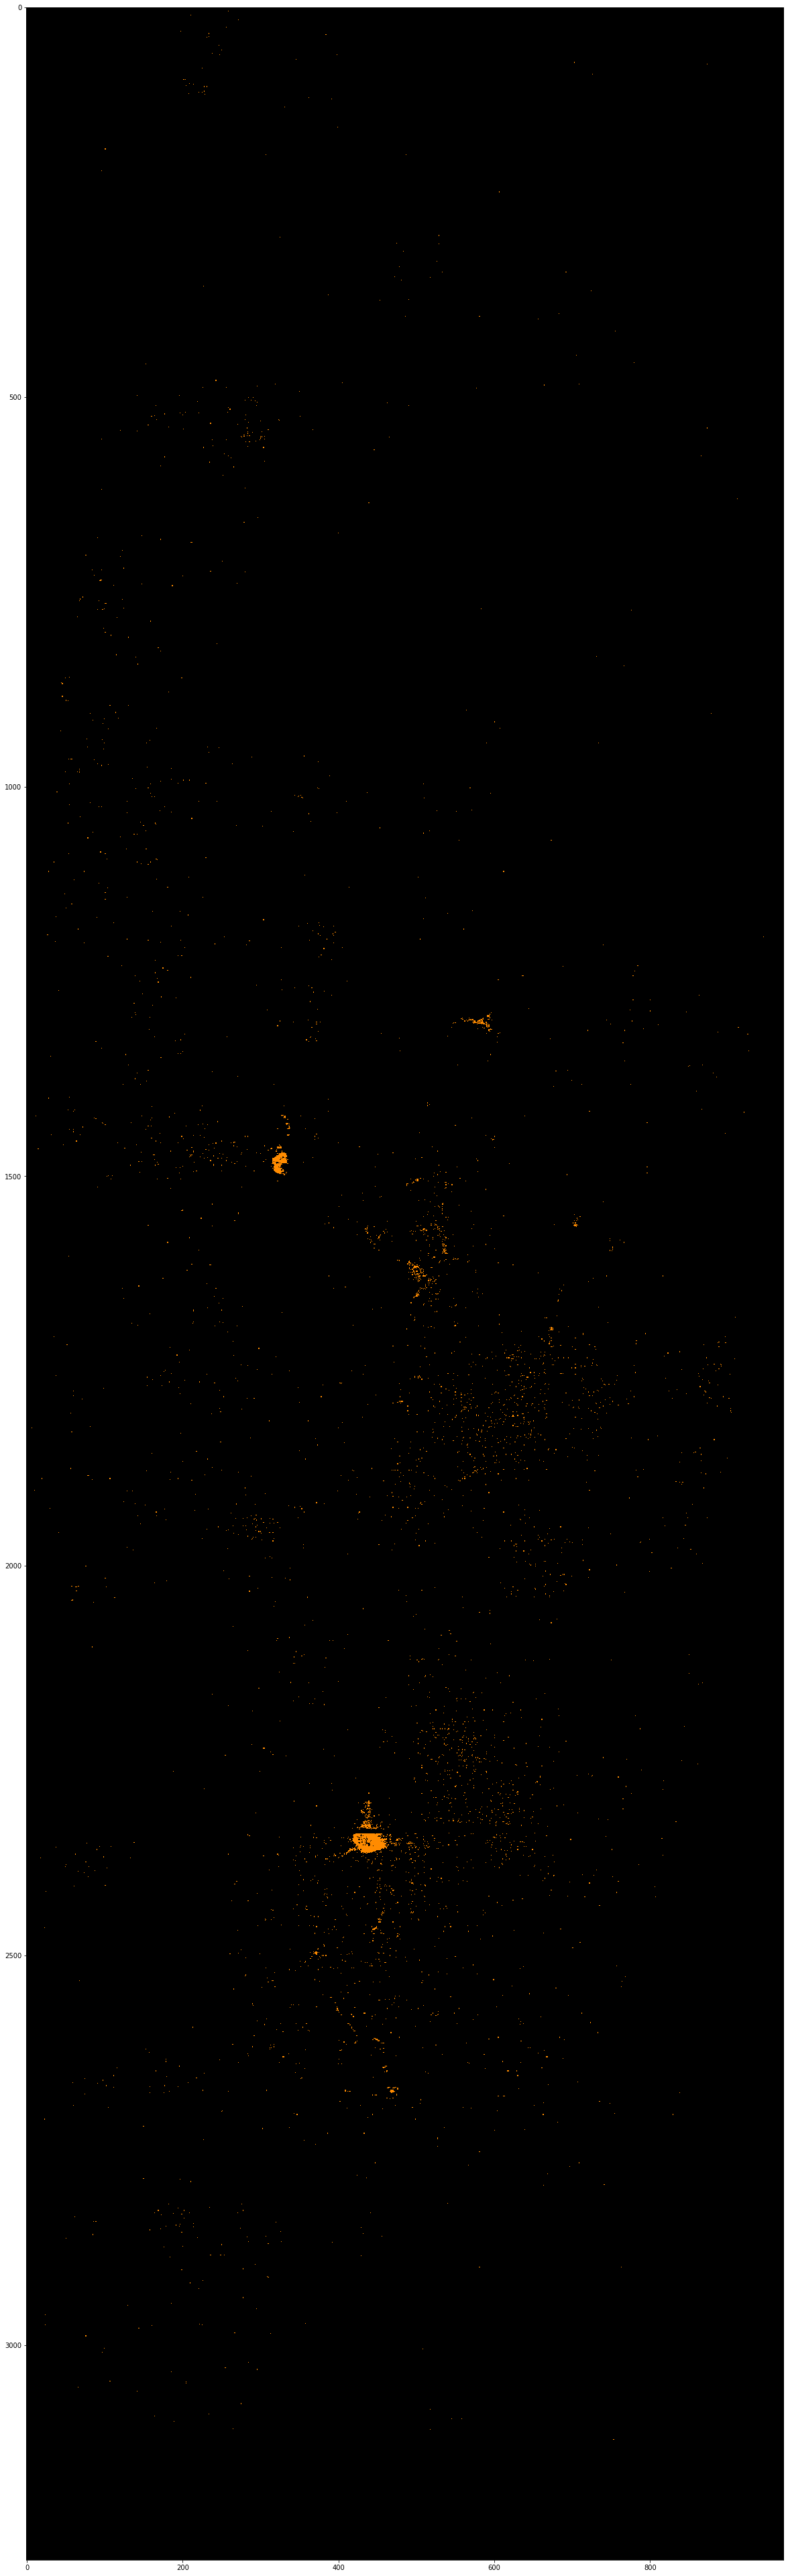

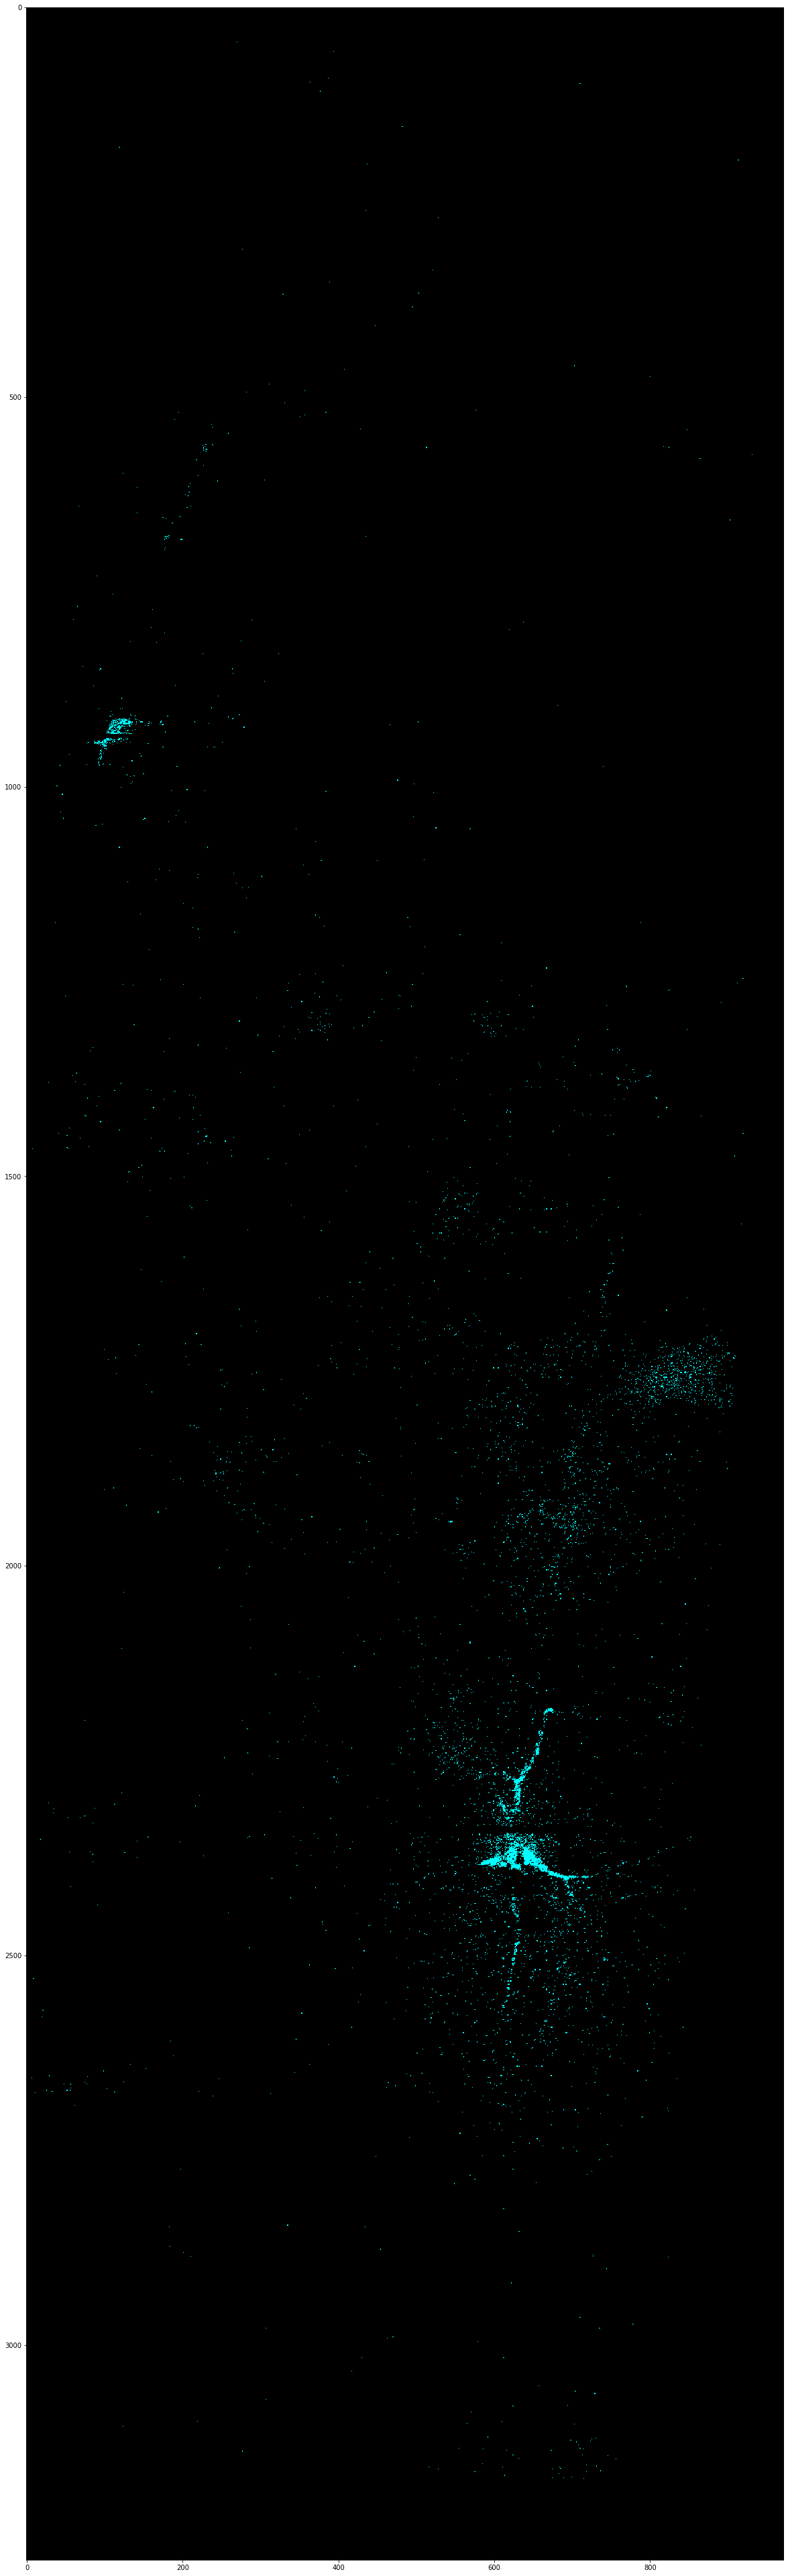

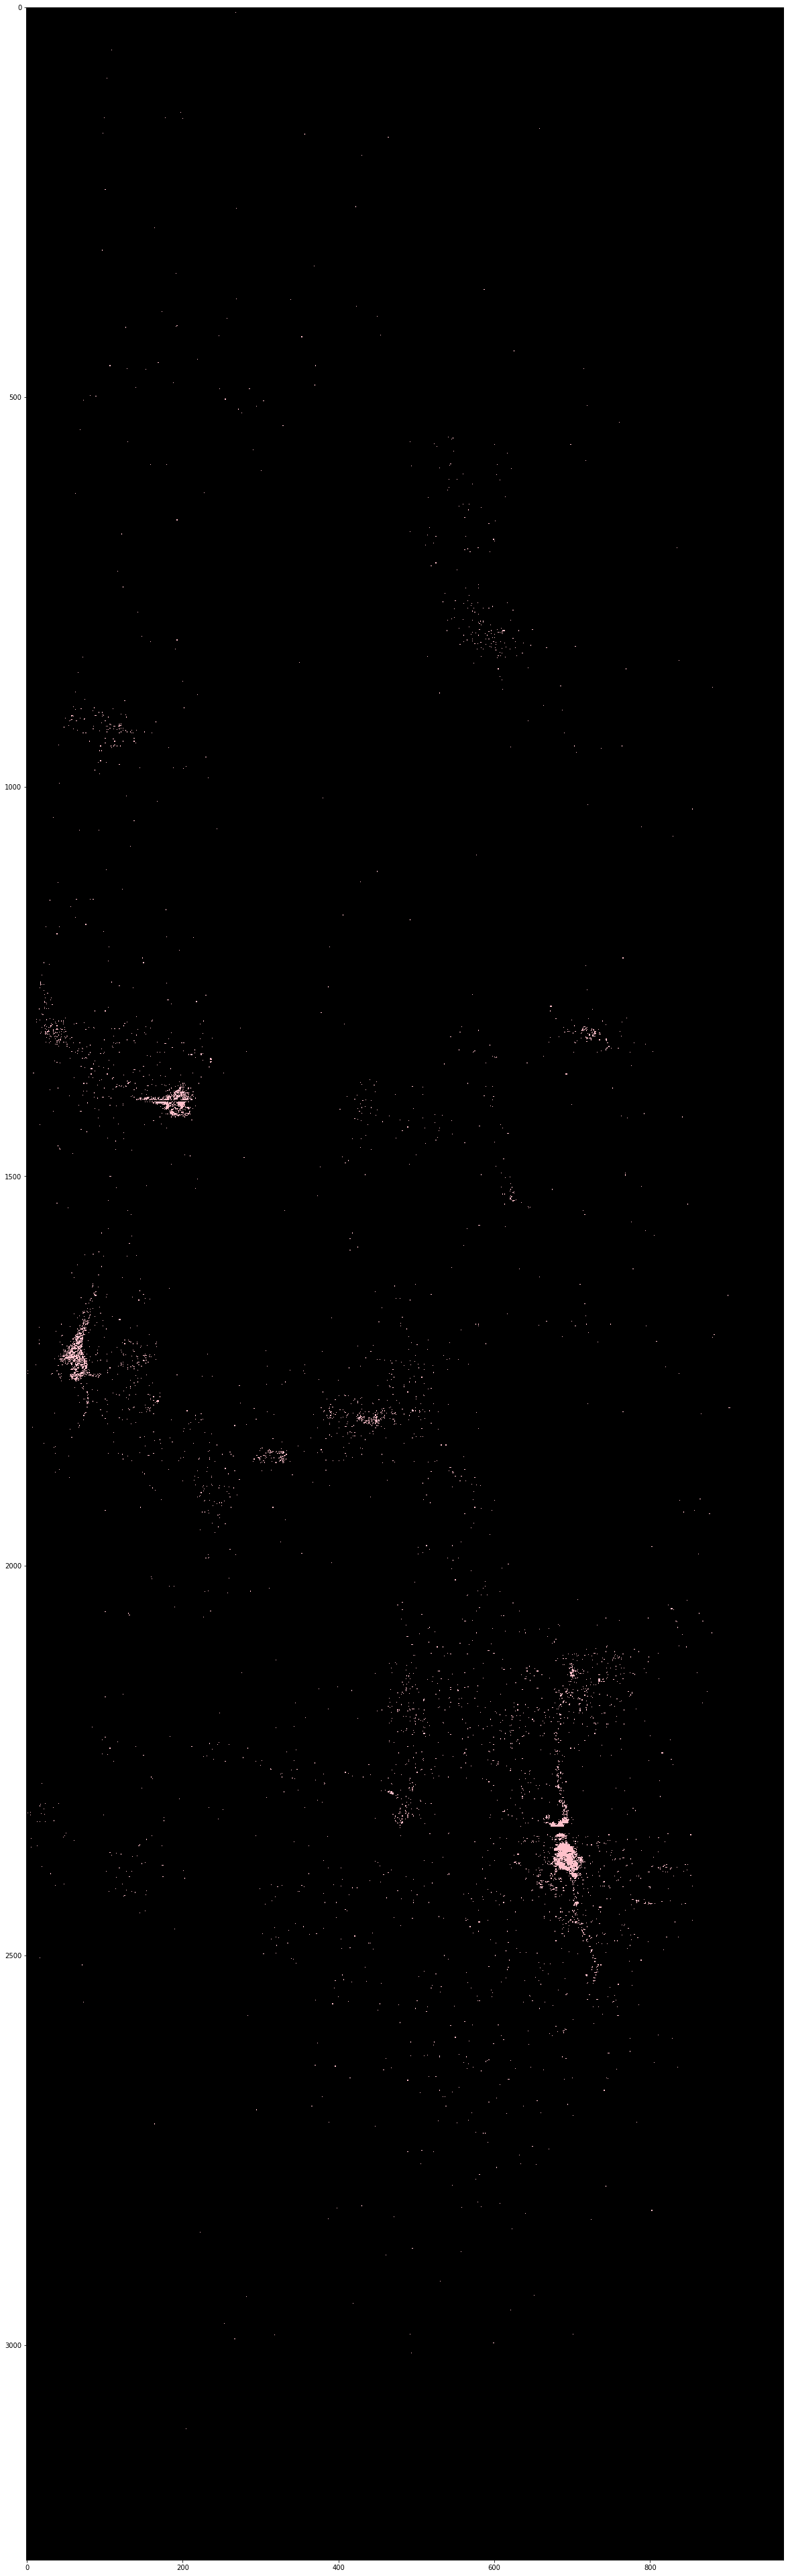

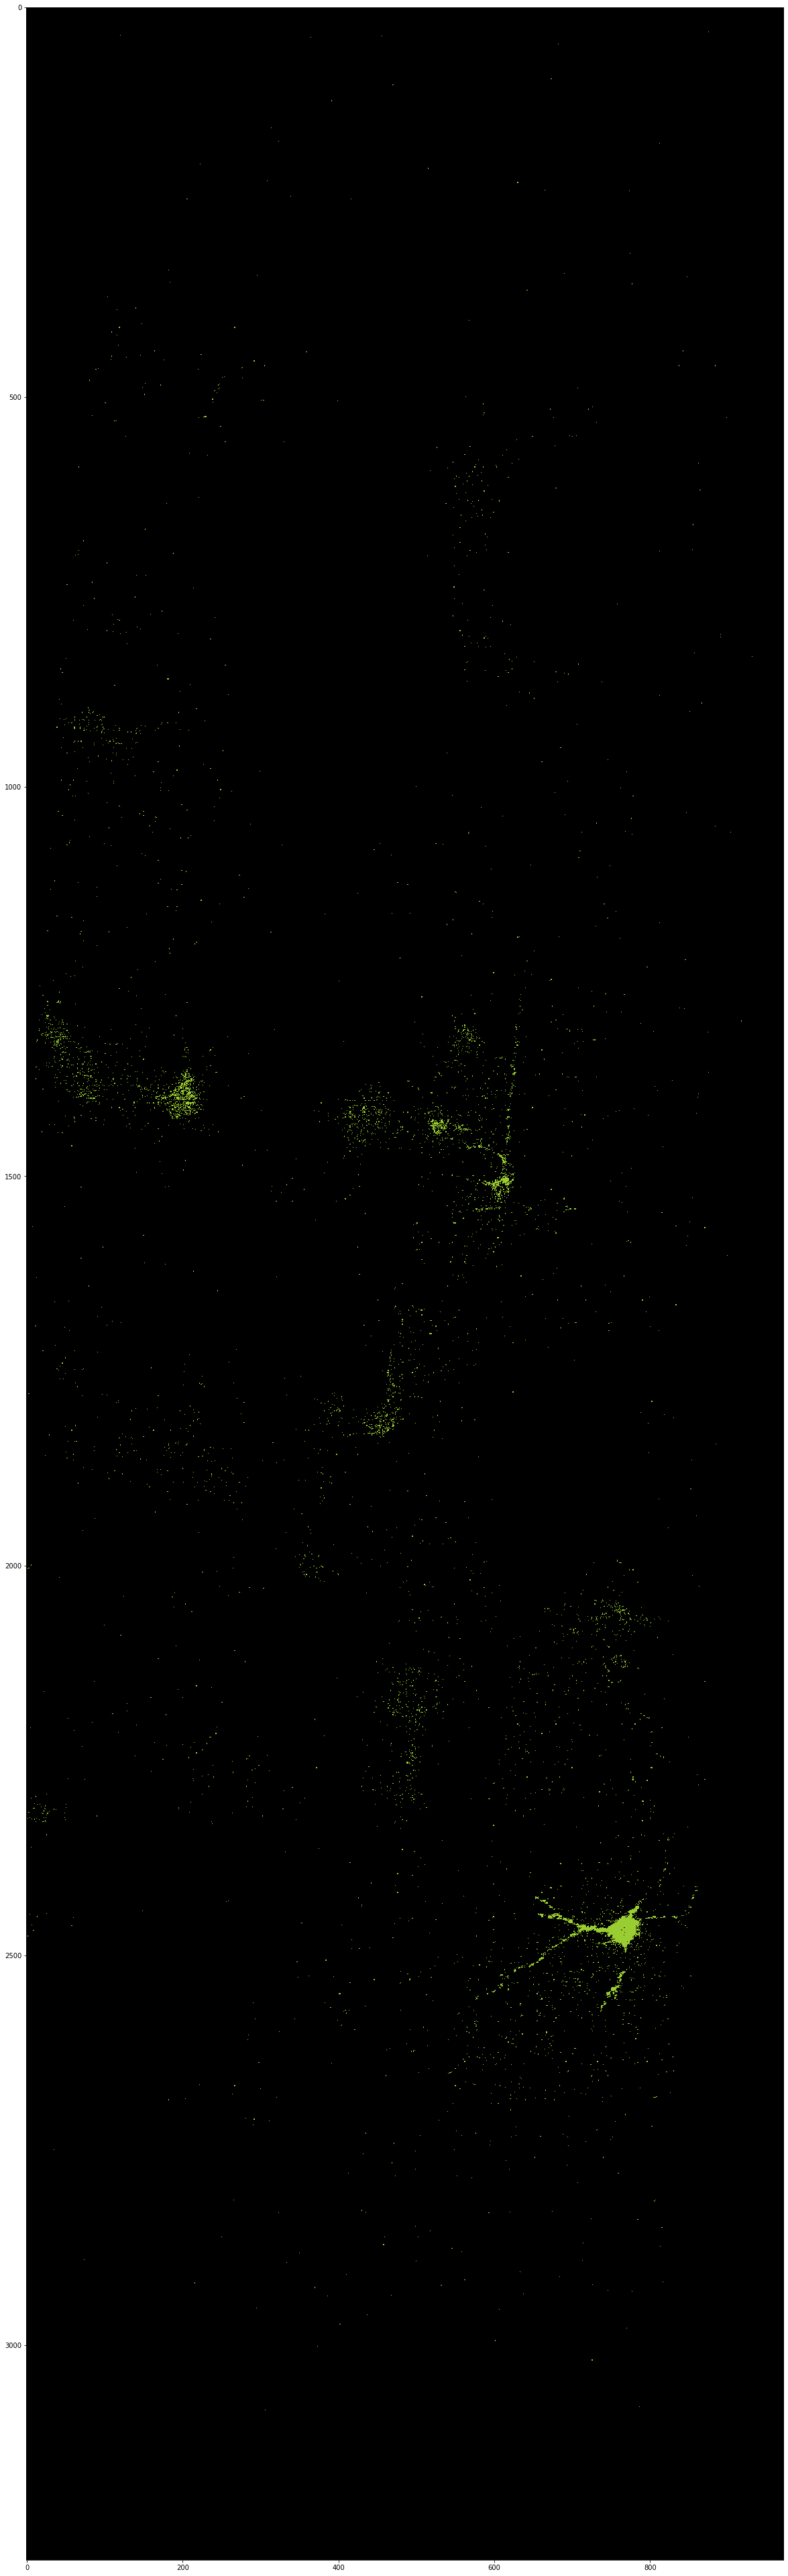

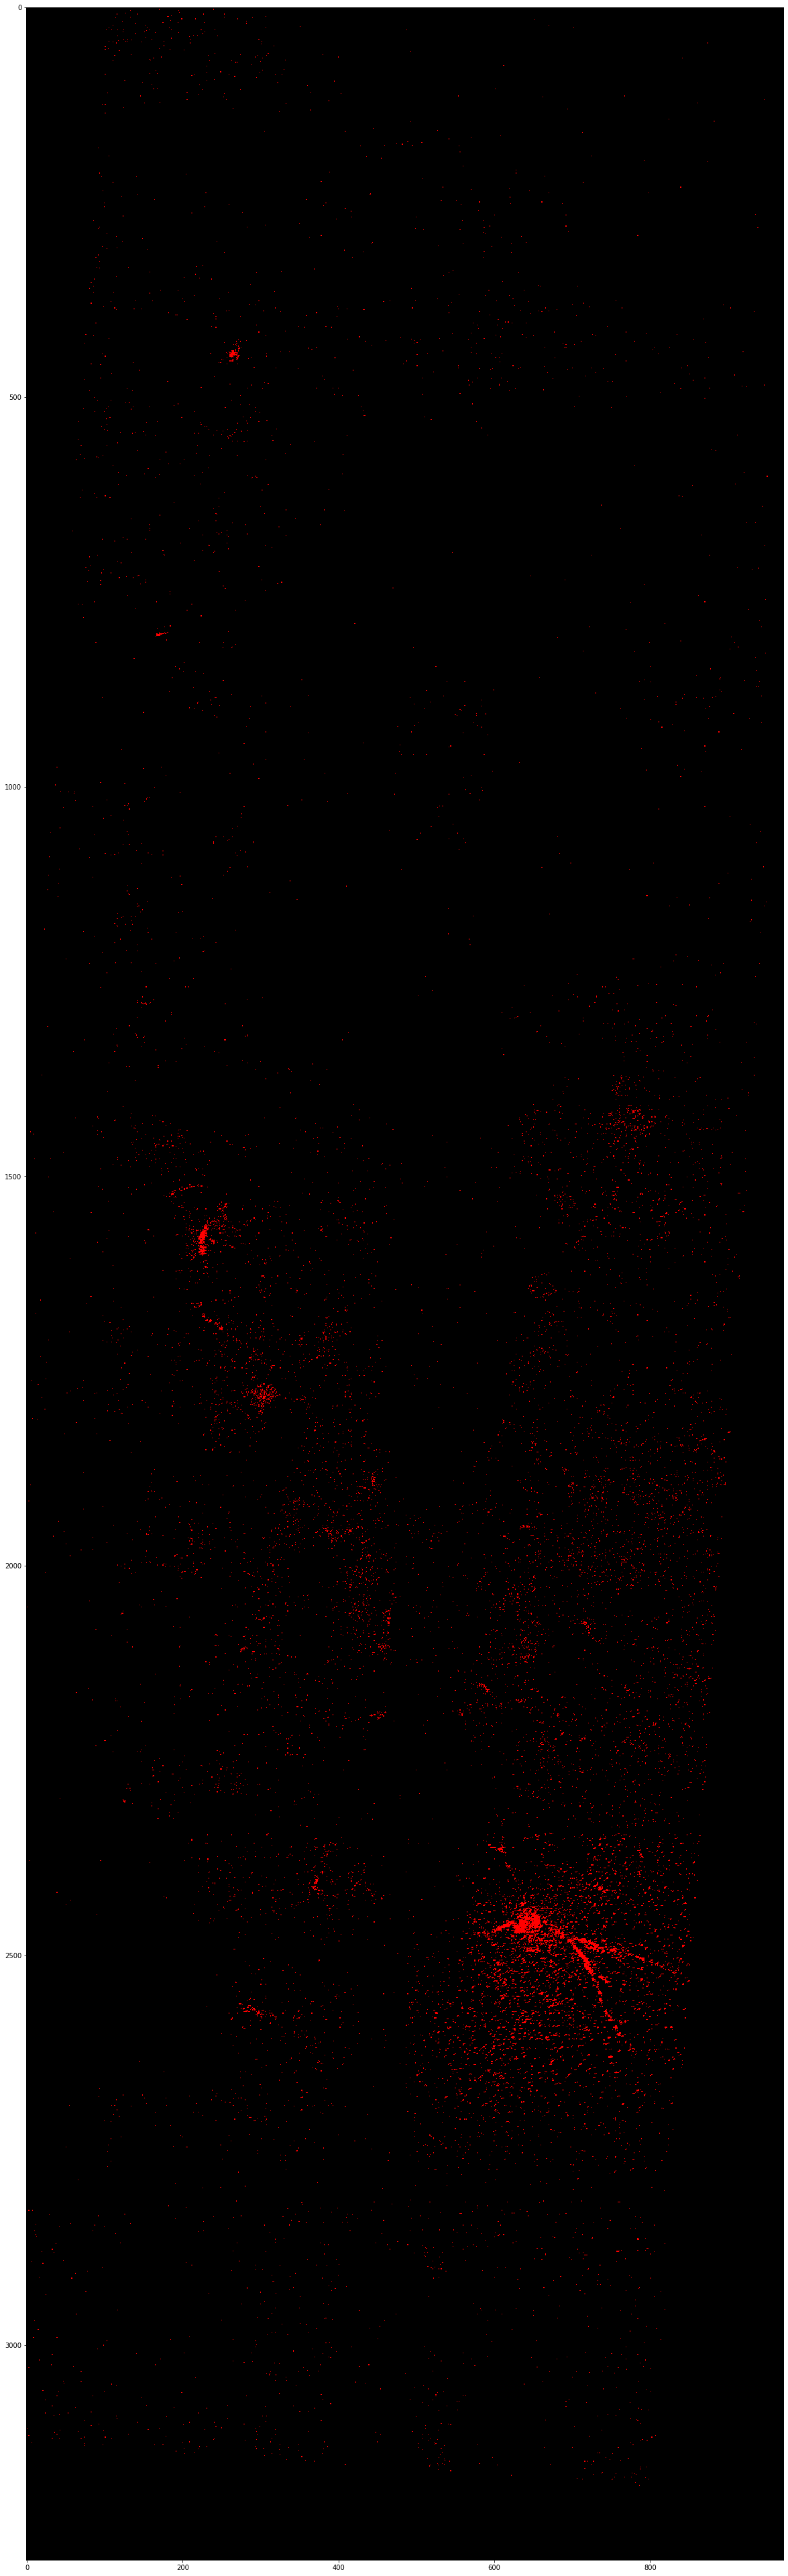

In [817]:
for idx in tqdm(final_idx):

    idx_colors = color.label2rgb(final_idx)

    labels2 = np.max(full_stitch_labels, 2)
    col_labels = color.label2rgb(labels2, bg_label = 0)
    match = np.max(full_stitch_labels == idx, 2)
    sub_labels = col_labels
    sub_labels[~match, :] = 0
    sub_labels[match, :] = idx_colors[np.where(final_idx == idx)[0][0]]
    plt.figure(figsize=(25,70))
    plt.imshow(sub_labels)
    plt.savefig('fullstitch/'+str(idx)+'_fullstitch_components.pdf')

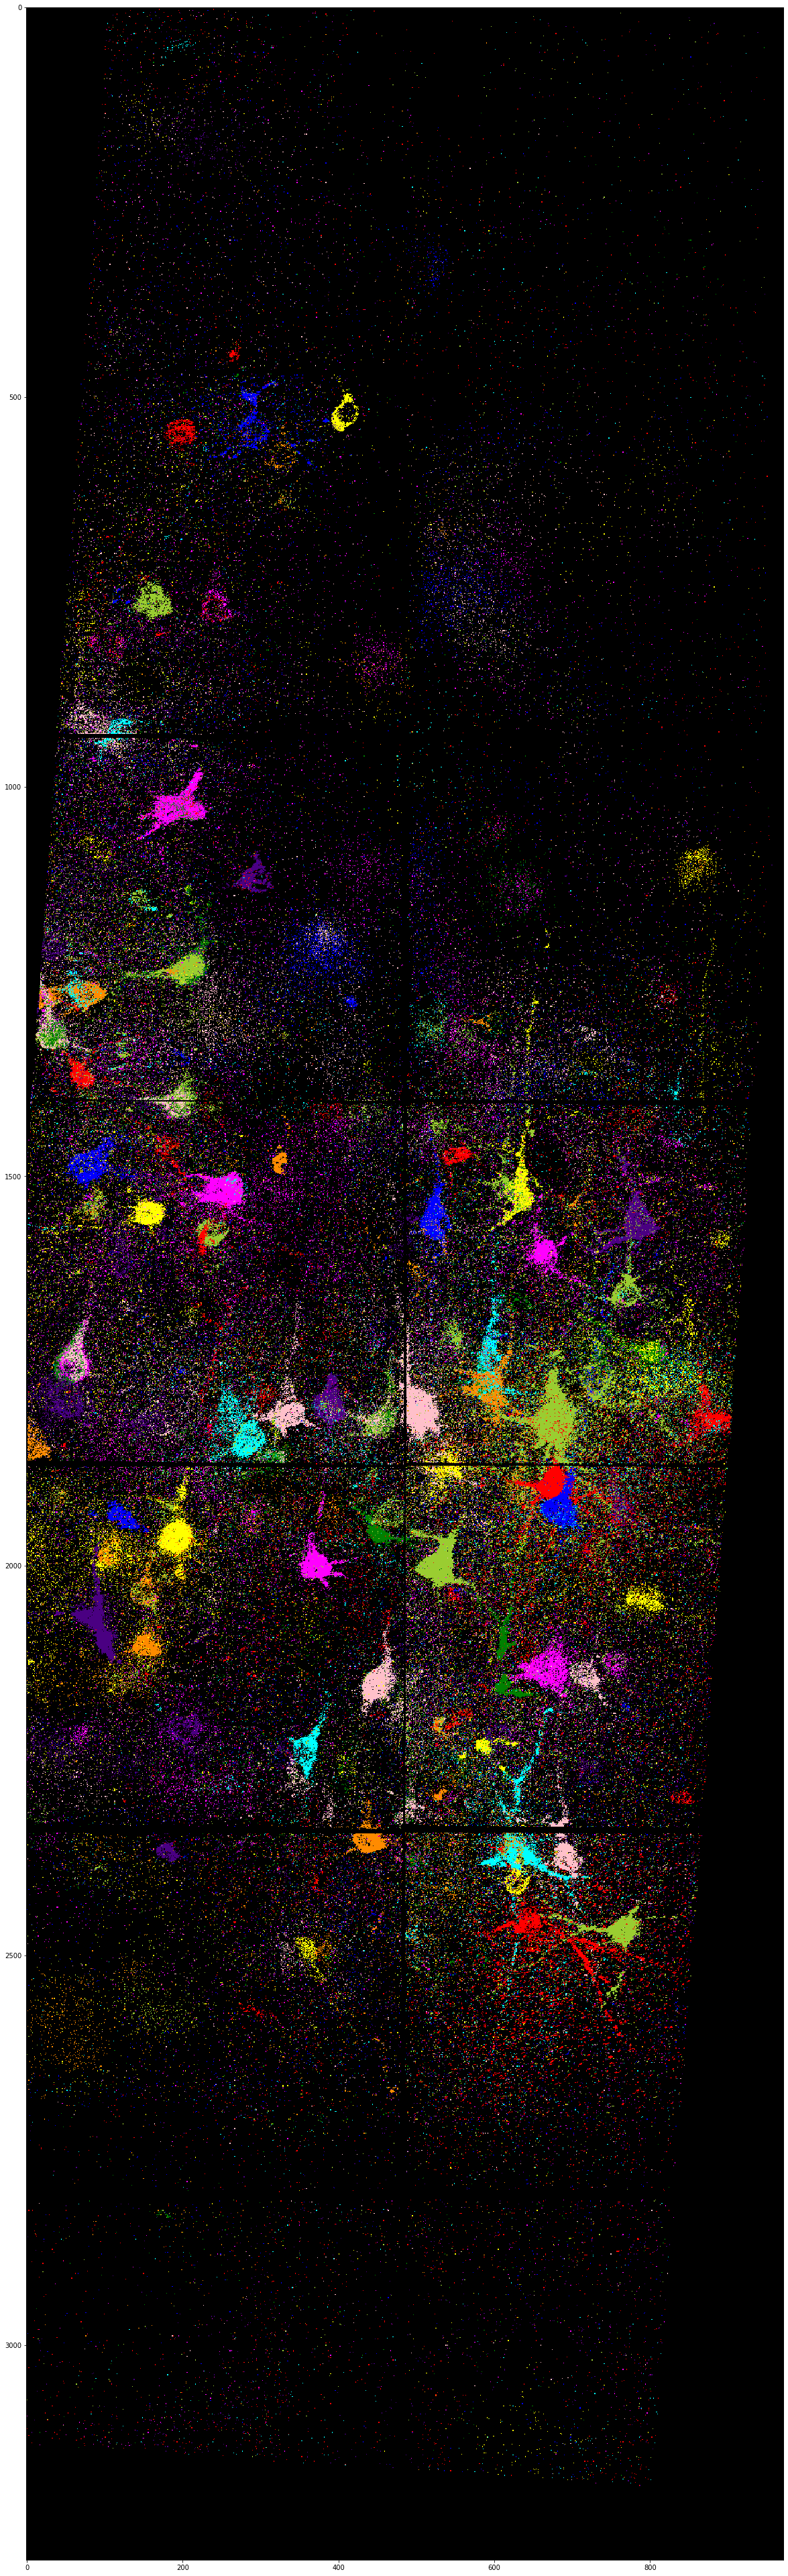

In [772]:
labels2 = np.max(full_stitch_labels, 2)
col_labels = color.label2rgb(labels2, bg_label = 0)
plt.figure(figsize=(25,70))
plt.imshow(col_labels)
plt.savefig('fullstitch_components.pdf')

### Matrix Optimization Basecalling

In [21]:
def basecalling_loss(weights, alpha = 1, beta = 4, gamma = 0.1):
    loss = 0
    for i in range(len(inputs)):
        inpA = inputs[i][0] 
        inpB = inputs[i][1] 
        inpC = inputs[i][2]
        bA = softmax_by_pixel(np.matmul(inpA, weights.T)) 
        bB = softmax_by_pixel(np.matmul(inpB, weights.T))
        bC = softmax_by_pixel(np.matmul(inpC, weights.T))
        #variance_loss = -np.mean(np.matmul(bA, bA.T)) 
        variance_loss = -np.mean(np.matmul(bA, bC.T)) 
        discrimination_loss = np.mean(np.matmul(bA, bB.T)) 
        
        loss += (alpha*variance_loss + beta*discrimination_loss)/len(inputs)
    
    loss += gamma * np.sum(weights ** 2)
    return loss

#### Random Image Discrimination Input

In [ ]:
#make input data for training
num_pixels = 500
inputs = []
selected_components = range(A.shape[-1])
for idx in tqdm(selected_components):
    input_vals = []
    mask = A[:,:,:, idx] > np.percentile(A[:,:,:, idx], 99.99)
    masked = Y[mask, :]
    
    input_vals.append(reshape_data_for_optimization(masked[np.random.randint(masked.shape[0], size=num_pixels), :]))
    
    pos_mask = np.sum(Y, -1) > 0
    pos_masked = Y[pos_mask, :]
    input_vals.append(reshape_data_for_optimization(pos_masked[np.random.randint(pos_masked.shape[0], size=num_pixels), :]))
    
    input_vals.append(reshape_data_for_optimization(C[[idx], :]))
    
    inputs.append(input_vals)

#### Cross-Component Discrimination Input

In [ ]:
#make input data for training
num_pixels = 500
inputs = []
cross_comp_vals = []
selected_components = range(A.shape[-1])
for idx in tqdm(selected_components):
    input_vals = []
    mask = A[:,:,:, idx] > np.percentile(A[:,:,:, idx], 99.99)
    masked = Y[mask, :]
    
    input_vals.append(reshape_data_for_optimization(masked[np.random.choice(masked.shape[0], size=num_pixels, replace = False), :]))    
    inputs.append(input_vals)
    
    cross_comp_vals.append(masked[np.random.choice(masked.shape[0], size=num_pixels, replace = False), :])


cross_comp_vals = np.concatenate(cross_comp_vals, 0)
    
for idx in tqdm(selected_components):
    inputs[idx].append(reshape_data_for_optimization(cross_comp_vals[np.random.choice(cross_comp_vals.shape[0], size=num_pixels, replace = False), :]))
    inputs[idx].append(reshape_data_for_optimization(C[[idx], :]))
    

#### Optimization over All Components

In [ ]:
weights = np.array([[1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0]]).astype('d')
matrix_gradient = grad(basecalling_loss)
learning_rates = [0.01, 0.001, 0.0001]
training_steps = [500, 500, 500]
print("Initial loss:", basecalling_loss(weights))
for train_idx in range(len(learning_rates)):
    for i in tqdm(range(training_steps[train_idx])):
        if i % 10 == 0:
            print("Current loss:", basecalling_loss(weights))
        weights -= matrix_gradient(weights) * learning_rates[train_idx]

print("Trained loss:", basecalling_loss(weights))

In [ ]:
rweights = np.reshape(weights, (4,3))

dy1, dy2, dy3, T = Y.shape
barcodeYs = np.reshape(Y, (dy1, dy2, dy3, 5, 3))
barcodeYs = np.matmul(barcodeYs, rweights.T)
barcodeYs = (barcodeYs / np.max(barcodeYs, -1, keepdims = True) == 1).astype('int')
barcodeYs = np.reshape(barcodeYs, (d1,d2,d3, -1))

d1, d2, d3, T = full_stitch.shape
barcodeY = np.reshape(flat_full_stitch, (d1, d2, d3, 5, 3))
barcodeY = np.matmul(barcodeY, rweights.T)
barcodeY = (barcodeY / np.max(barcodeY, -1, keepdims = True) == 1).astype('int')
barcodeY = np.reshape(barcodeY, (d1,d2,d3, -1))

b1, bT = C.shape
barcodeC = np.reshape(C, (b1, 5, 3))
barcodeC = np.matmul(barcodeC, rweights.T)
barcodeC = (barcodeC / np.max(barcodeC, -1, keepdims = True) == 1).astype('int')
barcodeC = np.reshape(barcodeC, (b1,-1))

### Component Visualization

In [670]:
len(filtered_idx)

53

<ipython-input-627-e073f87313be>:19: RuntimeWarning: invalid value encountered in true_divide
  corr = (n*np.sum(flatY*X, 1, keepdims = True) - sx*sy) / (n**2 * stx * sty)


1969


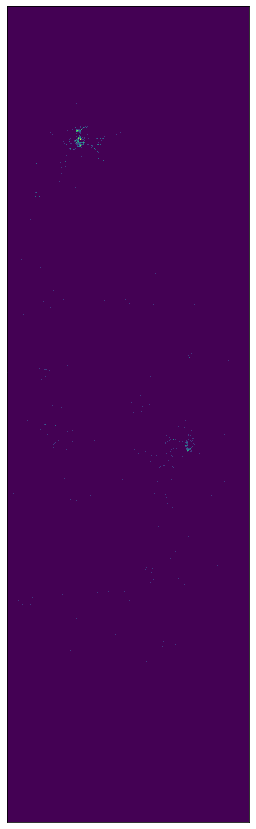

In [673]:
d1,d2,d3,T = ds_full_stitch.shape
idx = 40
bm = barcode_match(full_barcodeC[idx, :], barcodeYds, 5)
corr, sy, sty = barcode_correlation(fullC[idx,:], ds_flat_full_stitch, sy, sty)
corr = np.reshape(corr, (d1,d2,d3))
merged = np.logical_and(bm, corr > 0.75)
viewmask(merged)

print(np.sum(merged))

### Component Selection

In [ ]:
d1,d2,d3,T = Y.shape

vals = []
size = []
dilation_factor = []
distances = []
for idx in tqdm(range(A.shape[-1])):
    bm = barcode_match(barcodeC[idx, :], barcodeYs, 5)
    corr, sy, sty = barcode_correlation(C[idx,:], flatY, sy, sty)
    corr = np.reshape(corr, (d1,d2,d3))
    merged = np.logical_and(bm, corr > 0.75)
    sens = (np.sum(A[merged,idx]) / np.sum(A[:,:,:,idx]))
    spec = (np.sum(merged)/merged.size)
    vals.append(sens/spec)
    size.append(np.sum(merged))
    dilation_factor.append(np.sum(dilation(merged, ball(1))) / np.sum(merged))
    
    x,y,z = center_of_mass_norm(merged, 0.5)
    xpos, ypos, zpos = np.where(merged > 0)

    distance = []
    for idx in range(xpos.shape[-1]):
        dist= (xpos[idx]-x)**2 + (ypos[idx]-y)**2 + (zpos[idx]-z)**2
        distance.append(dist ** 0.5)
    distances.append(distance)

vals = np.array(vals)
size = np.array(size)
dilation_factor = np.array(dilation_factor)

median_distances = np.array([np.median(dist_arr) for dist_arr in distances])

size_filter = np.logical_and(size > 1000, size < 100000)
dilation_filter = dilation_factor < 5
enrichment_filter = vals > 50
distance_filter = median_distances < 100

filtered_idx = np.where(np.logical_and(np.logical_and(size_filter, dilation_filter), np.logical_and(enrichment_filter, distance_filter)))[0]

print(filtered_idx)

### Image Output

In [ ]:
d1,d2,d3, T = full_stitch.shape
dy1, dy2, dy3, T = Y.shape

fovx, fovy = 3, 1
inpatch_thresh = 0.4

labels = np.zeros((d1,d2,d3)).astype('uint16')

final_idx = []
good_cvec = []
good_barcode = []
good_mean_pixel = []
lab = 31001

for idx in tqdm(filtered_idx):
    bm = barcode_match(barcodeC[idx, :], barcodeY, 5)
    corr, sy, sty = barcode_correlation(C[idx,:], flat_full_stitch, sy, sty)
    corr = np.reshape(corr, (d1,d2,d3))
    merged = np.logical_and(bm, corr > 0.75)
    
    if np.sum(merged[dy1*fovx:dy1*(fovx+1), dy2*fovy:dy2*(fovy+1), :]/ np.sum(merged)) > inpatch_thresh:
        final_idx.append(idx)
        labels[merged] = lab + idx
    
        vec = np.mean(get_A_pixels(Y, A[:,:,:,idx], 50), 0)

        good_cvec.append(C[idx, :])
        good_barcode.append(barcodeC[idx,:])
        good_mean_pixel.append(vec)    
    
good_cvec = np.array(good_cvec)
good_barcode = np.array(good_barcode)
good_mean_pixel = np.array(good_mean_pixel)

In [ ]:
io.imsave('/mp/nas2/axue/3_1_components_fullstitch.tif', fov_labels)
np.savetxt('/mp/nas2/axue/3_1_barcode_fullstitch.csv', good_barcode, delimiter=",")
np.savetxt('/mp/nas2/axue/3_1_mp_fullstitch.csv', good_mean_pixel, delimiter=",")
np.savetxt('/mp/nas2/axue/3_1_cvec_fullstitch.csv', good_cvec, delimiter=",")

In [ ]:
np.savetxt('/mp/nas2/axue/3_1_barcode_fullstitch.csv', good_barcode, delimiter=",")
np.savetxt('/mp/nas2/axue/3_1_mp_fullstitch.csv', good_mean_pixel, delimiter=",")
np.savetxt('/mp/nas2/axue/3_1_cvec_fullstitch.csv', good_cvec, delimiter=",")

### Save Checkpoint

In [ ]:
fov_label = 'full'

pickle.dump(A, open(fov_label+"_A.p", "wb" ))
pickle.dump(C, open(fov_label+"_C.p", "wb" ))
pickle.dump(weights, open(fov_label+"_weights.p", "wb" ))

In [ ]:
A = pickle.load(open(fov_label+"_A.p", "rb" ))
C = pickle.load(open(fov_label+"_C.p", "rb" ))
weights = pickle.load(open(fov_label+"_weights.p", "rb" ))

### Deprecated Barcoding

In [ ]:
imagesc(np.sum(rawY, (2,3)))

In [ ]:
barcodes = matrix_basecall(C, thresh_c = 1.25, thresh_d = 1.25)
Y_basecall = np.reshape(matrix_basecall(flat_full_stitch,thresh_c = 1.25, thresh_d = 1.25), (d1,d2,d3, 20))

In [ ]:
barcodes = matrix_basecall(C, thresh_c = 1.25, thresh_d = 1.25)
Y_basecall = np.reshape(matrix_basecall(flatY,thresh_c = 1.25, thresh_d = 1.25), (d1,d2,d3, 20))

## Sanity Checking

In [32]:
full_stitch_labels = pickle.load(open("full_stitch_label.p", "rb" ))

unique_labels = np.unique(full_stitch_labels[full_stitch_labels > 0]).astype('int')

In [56]:
full_stitch_labels2 = pickle.load(open("full_stitch_label_reprocess.p", "rb" ))[:, :972, :]

unique_labels2 = np.unique(full_stitch_labels2[full_stitch_labels2 > 0]).astype('int')

In [49]:
unique_labels

array([ 35,  40,  44,  79,  91,  93,  99, 100, 101, 109, 118, 205, 206,
       215, 255, 270, 277, 282, 283, 287, 293, 294, 296, 324, 325, 328,
       335, 338, 341, 348, 375, 382, 388, 393, 401, 407, 411, 430, 435,
       464, 475, 476, 509, 512, 513, 533, 548, 583, 586, 589, 594])

In [63]:
full_stitch_labels.dtype

dtype('float64')

In [65]:
img1 = full_stitch_labels[1700:2000, 572:872, :].astype('uint16')
img2 = full_stitch_labels2[1700:2000, 572:872, :].astype('uint16')

img1 = np.swap

io.imsave('fs.tif', img1, check_contrast = False)
io.imsave('fsr.tif', img2, check_contrast = False)

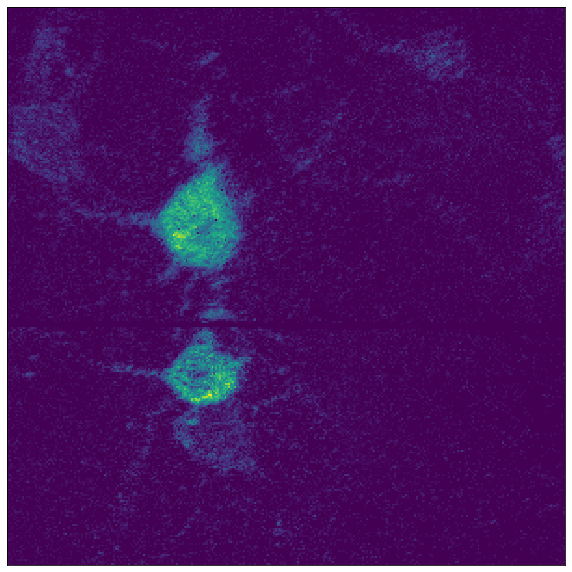

In [64]:
viewmask(full_stitch_labels[1700:2000, 572:872, :])

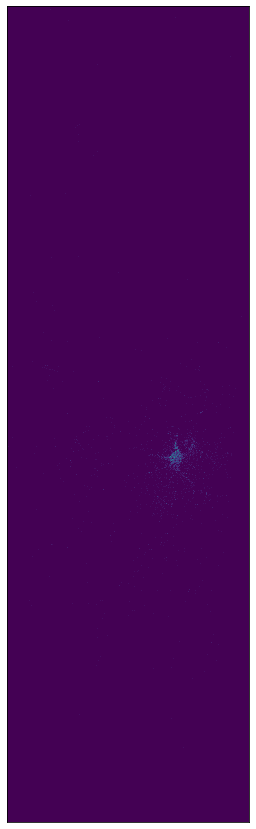

In [55]:
viewmask(np.logical_and(full_stitch_labels == 0, full_stitch_labels2[:,:972, :] == 301))

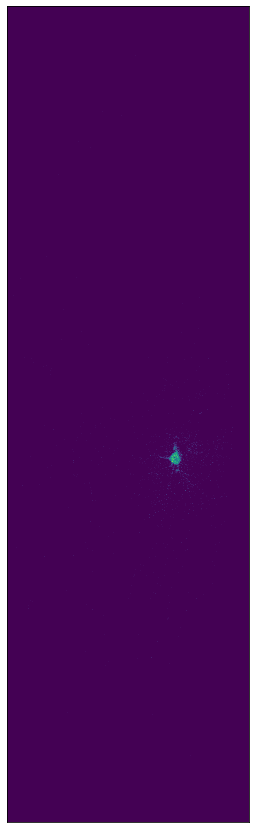

In [52]:
viewmask(full_stitch_labels == 348)

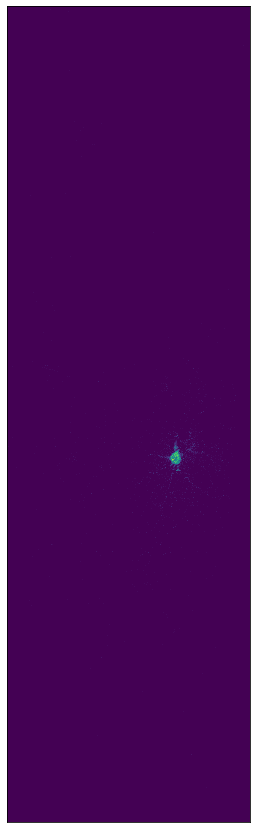

In [35]:
viewmask(full_stitch_labels2 == 301)

In [33]:
print(unique_labels)
print(unique_labels2)

[ 35  40  44  79  91  93  99 100 101 109 118 205 206 215 255 270 277 282
 283 287 293 294 296 324 325 328 335 338 341 348 375 382 388 393 401 407
 411 430 435 464 475 476 509 512 513 533 548 583 586 589 594]
[  4  14  21  23  44  57  59  67  68  69  84 164 165 172 202 207 217 220
 227 236 243 245 261 274 280 290 297 301 303 306 335 342 356 360 370 389
 404 415 421 424 425 441 451 455 460 486 524 526 527 532]


In [110]:
weights = pickle.load(open('full_weights.p', 'rb'))
rweights = np.reshape(weights, (4,3))

Cvec = fullC[unique_labels, :]

b1, bT = Cvec.shape
barcodes = np.reshape(Cvec, (b1, 5, 3))
barcodes = np.matmul(barcodes, rweights.T)
barcodes = (barcodes / np.max(barcodes, -1, keepdims = True) == 1).astype('int')
barcodes = np.reshape(barcodes, (b1,-1))

In [36]:
barcode_full_stitch = basecall_with_weights(full_stitch, rweights)
sy, sty = calc_sy(flat_full_stitch)

In [132]:
d1,d2,d3,T = full_stitch.shape
corr = barcode_correlation(Cvec[idx,:], flat_full_stitch, sy, sty)[0]
corr += 1
corr *= 255/2
corr = corr.astype('uint8')
corr = np.reshape(corr, (d1,d2,d3))

<ipython-input-17-e073f87313be>:19: RuntimeWarning: invalid value encountered in true_divide
  corr = (n*np.sum(flatY*X, 1, keepdims = True) - sx*sy) / (n**2 * stx * sty)


In [136]:
x,y,z = center_of_mass_norm(full_stitch_labels == u_idx, 0.5)

In [148]:
str(np.array([x,y,z]).astype('int'))

'[1792  391   30]'

In [146]:
str(np.argmax(np.reshape(barcodes[idx, :], (-1, 5, 4)), -1)+1)

'[[1 4 3 2 4]]'

In [192]:
blur_fp = []
for idx in tqdm(range(len(unique_labels))):
    u_idx = unique_labels[idx]
    
    lfp = '/mp/nas2/axue/blur/blurmap_comp' + str(u_idx)+'.tif'
    bl = (full_stitch_labels == u_idx)
    bl = gaussian_filter(bl, [1,1,1], mode = 'constant', output = 'double')
    bl *= 65536 / 100
    bl = bl.astype('uint16')
    
    bl = np.moveaxis(bl, -1, 0)
    io.imsave(lfp, bl, check_contrast = False)
    
    blur_fp.append(lfp)

In [232]:
vast_loc2

['(204,1243,47)',
 '(526,1759,60)',
 '(403,1842,33)',
 '(209,1026,44)',
 '(210,1237,47)',
 '(287,1544,55)',
 '(34,1581,34)',
 '(69,1428,30)',
 '(33,1322,50)',
 '(204,1578,53)',
 '(70,1373,56)',
 '(86,1489,53)',
 '(158,1548,41)',
 '(254,1523,53)',
 '(184,1737,29)',
 '(391,1792,30)',
 '(16,1851,32)',
 '(281,1842,39)',
 '(331,1802,41)',
 '(452,1819,51)',
 '(550,1472,56)',
 '(524,1545,52)',
 '(635,1523,46)',
 '(660,1595,49)',
 '(618,1727,47)',
 '(775,1568,51)',
 '(592,1772,42)',
 '(594,1725,48)',
 '(503,1800,43)',
 '(675,1815,44)',
 '(868,1812,54)',
 '(123,1938,40)',
 '(192,1969,39)',
 '(373,1996,38)',
 '(453,1960,49)',
 '(91,1808,32)',
 '(156,2100,27)',
 '(363,1820,29)',
 '(451,2149,37)',
 '(531,1994,44)',
 '(677,1899,33)',
 '(690,1928,59)',
 '(585,2230,52)',
 '(656,1702,45)',
 '(610,2104,59)',
 '(185,2329,26)',
 '(443,2354,34)',
 '(629,2380,37)',
 '(690,2312,32)',
 '(760,2464,34)',
 '(651,2463,39)']

In [233]:
loc2 = []
vast_loc2 = []

for i in range(len(loc)):
    x,y,z = loc[i].strip('[]').split()
    loc2.append('(' + y + ', ' + x + ', ' + z + ')')
    
    vx,vy,vz = vast_loc[i].strip('[]').split()
    vast_loc2.append("(" + vy + ', ' + vx + ', ' + vz + ')')

In [ ]:
loc = []
vast_loc = []
num_barcodes = []
corr_fp = []
barcode_fp = []
seg_fp = []
for idx in tqdm(range(len(unique_labels))):
    u_idx = unique_labels[idx]
    bm = np.squeeze(np.dot(barcode_full_stitch, barcodes[idx, :].T)).astype('uint8')
    
    corr = barcode_correlation(Cvec[idx,:], flat_full_stitch, sy, sty)[0]
    corr += 1
    corr *= 255/2
    corr = corr.astype('uint8')
    corr = np.reshape(corr, (d1,d2,d3))
    
    seg = (full_stitch_labels == u_idx).astype('uint8') * 255
    
    x,y,z = center_of_mass_norm(full_stitch_labels == u_idx, order = 0.5)
    
    loc.append(str(np.array([x,y,z]).astype('int')))
    vast_loc.append(str(np.array([4*x,4*y,4*z]).astype('int')))
    
    num_barcodes.append(str(np.argmax(np.reshape(barcodes[idx, :], (-1, 5, 4)), -1)+1))
    
    bfp = '/mp/nas2/axue/distancemap/hammingdist_map_comp' + str(u_idx)+'.tif'
    cfp = '/mp/nas2/axue/distancemap/correlation_map_comp' + str(u_idx)+'.tif'
    sfp = '/mp/nas2/axue/segments/segmentation_comp' + str(u_idx)+'.tif'
    
    corr_fp.append(cfp)
    barcode_fp.append(bfp)
    seg_fp.append(sfp)
        
    seg = np.moveaxis(seg, -1, 0)
    bm = np.moveaxis(bm, -1, 0)
    corr = np.moveaxis(corr, -1, 0)
    
    io.imsave(bfp, bm)
    io.imsave(cfp, corr)
    io.imsave(sfp, seg)

In [234]:
tracker = pd.DataFrame(
    {'Imported Segment Number': list(range(1, len(unique_labels)+1)),
     'Auto-Segment Number': list(unique_labels),
     'Barcode': num_barcodes,
     'VAST Segment Center': vast_loc2,
     '4x Downsample Center': loc2,
     'Correlation Map Filepath': corr_fp, 
     'Hamming Distance Filepath': barcode_fp,
     'Downsampled Label Mask Filepath': seg_fp,
     'Blurred Mask Filepath': blur_fp
    })

In [235]:
tracker.to_csv('Segmentation_Tracking.csv', index = False)

## Validation

### Normalization

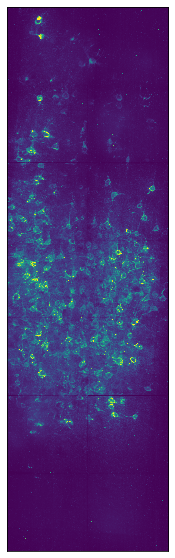

In [838]:
imagesc(np.sum(full_stitch, (2,3)))

In [ ]:
percentiles = list(range(80, 100))
vals = []
for pct in tqdm(percentiles):
    temp = []

    for idx in range(Yhp.shape[-1]):
        temp.append(np.percentile(Yhp[:,:,:,idx], pct))
    vals.append(temp)
    
vals = np.array(vals)
nvals = vals / np.max(vals, 1, keepdims = True)

In [ ]:
plt.plot(vals)

In [ ]:
labels = ["chan" + str(i) for i in range(15)]
for idx in range(2, 15, 3):
    plt.plot(nvals[:, idx], label=labels[idx])
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

In [ ]:
idx = 1
thresh = 99
timg = Yhp[:,:,:,idx] > np.percentile(Yhp[:,:,:,idx], thresh)
imagesc(np.sum(timg, 2))

In [ ]:
s_idx = 0
Yslice = Yhp[:,:,:,s_idx]
Yslice = Yslice[Yslice > np.percentile(Yslice, 99)]
counts, bins = np.histogram(Yslice, 1000)
plt.hist(bins[:-1], weights = counts, bins = bins)

### Barcoding

In [ ]:
idx = 65
normed = norm_by_round(C[idx, :])
normed = np.reshape(normed, (5, 3))
plt.plot(normed[:, 0], 'r-')
plt.plot(normed[:, 1], 'g-')
plt.plot(normed[:, 2], 'b-')

bc = barcodes[idx, :]
bc = np.reshape(bc, (5, -1))
imagesc(bc, 5, 3)

In [ ]:
for idx in filtered_idx:
    plt.figure(1,1)
    bm = barcode_match(barcodes[idx, :], Y_basecall, 5)
    corr = barcode_correlation(C[idx,:], flatY, sy, sty)[0]
    corr = np.reshape(corr, (d1,d2,d3))
    merged = np.logical_and(bm, corr > 0.75)
    imagesc(np.sum(merged,2))
    x,y,z = center_of_mass(merged)
    plt.plot(y,x, 'r.')

### Pixel Distribution

In [ ]:
x,y,z = center_of_mass(merged)

xpos, ypos, zpos = np.where(merged > 0)

distances = []
for idx in tqdm(range(xpos.shape[-1])):
    dist= (xpos[idx]-x)**2 + (ypos[idx]-y)**2 + (zpos[idx]-z)**2
    distances.append(dist ** 0.5)

In [ ]:
plt.hist(distances, 100)

In [ ]:
all_dist = []
for fidx in filtered_idx:
    all_dist = all_dist + distances[fidx]
    
counts, bins = np.histogram(all_dist, 30)

#put data into heatmap format
heatmap_data = []
for fidx in filtered_idx:
    heatmap_data.append(np.histogram(distances[fidx], bins)[0])
    
heatmap_data = np.array(heatmap_data).T[1:15, :]

clustergrid = seaborn.clustermap(heatmap_data, row_cluster = False, xticklabels = filtered_idx)
#clustergrid = clustergrid.fig.suptitle('Distance to Center of Mass of Segmentation') 

og_barcodes = barcodes[filtered_idx]
reord_barcodes = og_barcodes[clustergrid.dendrogram_col.reordered_ind]

for idx in tqdm(filtered_idx[clustergrid.dendrogram_col.reordered_ind]):
    bm = barcode_match(barcodes[idx, :], Y_basecall, 5)
    corr, sy, sty = barcode_correlation(C[idx,:], flatY, sy, sty)
    corr = np.reshape(corr, (d1,d2,d3))
    merged = np.logical_and(bm, corr > 0.75)
    print(np.sum(dilation(merged, ball(1))) / np.sum(merged))
    imagesc(np.sum(merged,2))
    x,y,z = center_of_mass(merged)
    plt.plot(y,x, 'r.')

## Figure Making

In [868]:
#fast distance calculation
for idx in final_idx:
    

(13090, 3892, 400)

In [875]:
coms = []
ps = []

for idx in tqdm(final_idx):
    x,y,z = center_of_mass_norm(full_stitch_labels == idx, 0.5)
    xpos, ypos, zpos = np.where(full_stitch_labels == idx)
    
    coms.append((x,y,z))
    ps.append((xpos, ypos, zpos))

In [877]:
x_distances[0]

[1162.5202502892653,
 952.5764118321438,
 938.6310332884458,
 923.5174023376663,
 918.618148928751,
 912.618811827057,
 911.5175242681107,
 909.539765819498,
 908.6192586227701,
 907.5175251682078,
 907.5793417515,
 904.6052168051485,
 901.6524581438013,
 899.5187611579987,
 890.5930007589857,
 888.654435061987,
 883.5282256846572,
 857.6100338650169,
 765.5749058748331,
 756.5300564337183,
 743.5447769629301,
 743.5368556147833,
 743.5368556147833,
 742.5385137571876,
 723.5306373361118,
 716.6873424698877,
 714.5393442559159,
 714.5478953844452,
 714.5191342819388,
 714.5191342819388,
 714.526440289191,
 714.5186717847297,
 714.5191342819388,
 714.5321925434911,
 714.5191342819388,
 714.5220875268147,
 714.526440289191,
 714.5175805719168,
 714.5186717847297,
 713.5393751220496,
 713.5186736791862,
 713.5264530711063,
 713.5220942084189,
 713.5264530711063,
 713.5322133869636,
 713.5174265549306,
 713.5479382341671,
 713.5174265549306,
 713.5253724091201,
 713.5213223024517,
 713.517

In [906]:
x_distances = []
y_distances = []

for i in tqdm(range(len(final_idx))):
    x,y,z = coms[i]
    xpos, ypos, zpos = ps[i]
    
    x_dist = []
    y_dist = []
    for j in range(len(xpos)):
        x_dist.append(((xpos[j] - x)**2 + (zpos[j] - z)**2)**0.5)
        y_dist.append(((ypos[j] - y)**2 + (zpos[j] - z)**2)**0.5)
    x_distances.append(x_dist)
    y_distances.append(y_dist)

Text(694.1249999999999, 0.5, 'Upper Bound of Histogram Bin')

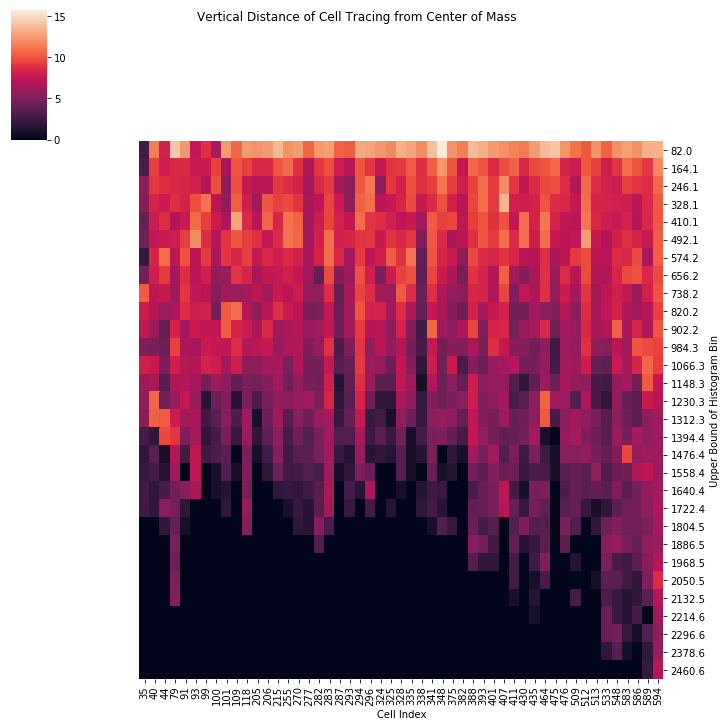

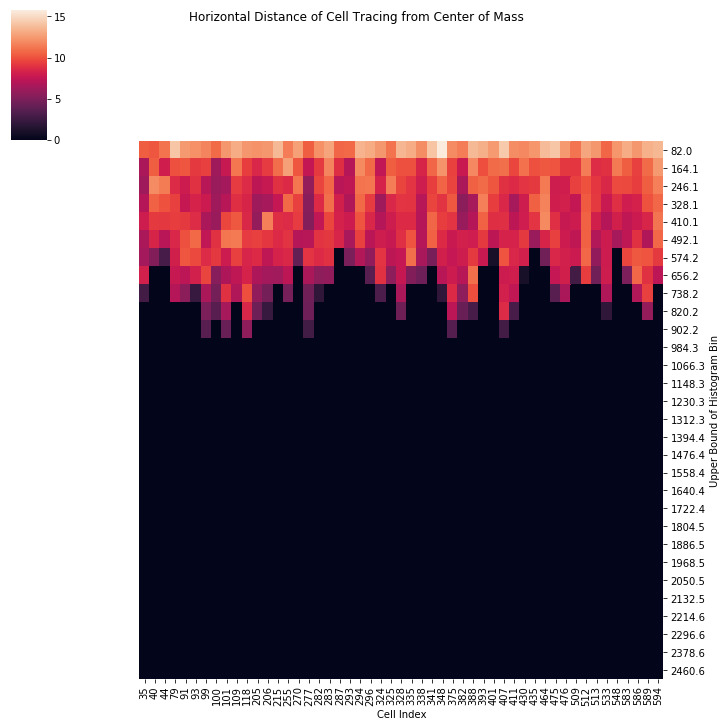

In [912]:
all_dist = []
for fidx in range(len(final_idx)):
    all_dist = all_dist + x_distances[fidx] + y_distances[fidx]
    
counts, bins = np.histogram(all_dist, 30)

#put data into heatmap format
heatmap_data_x = []
heatmap_data_y = []
for fidx in range(len(final_idx)):
    heatmap_data_x.append(np.histogram(x_distances[fidx], bins)[0])
    heatmap_data_y.append(np.histogram(y_distances[fidx], bins)[0])

heatmap_data_x = np.array(heatmap_data_x).T
heatmap_data_y = np.array(heatmap_data_y).T
heatmap_data_x[heatmap_data_x <= 0] = 1
heatmap_data_y[heatmap_data_y <= 0] = 1

heatmap_data_x = np.log2(heatmap_data_x)
heatmap_data_y = np.log2(heatmap_data_y)

clustergrid = seaborn.clustermap(heatmap_data_x, row_cluster = False, col_cluster = False, xticklabels = final_idx, yticklabels = np.round(bins[1:], 1))
ax = clustergrid.ax_heatmap
clustergrid = clustergrid.fig.suptitle('Vertical Distance of Cell Tracing from Center of Mass') 
ax.set_xlabel("Cell Index")
ax.set_ylabel("Upper Bound of Histogram Bin")

clustergrid = seaborn.clustermap(heatmap_data_y, row_cluster = False, col_cluster = False, xticklabels = final_idx, yticklabels = np.round(bins[1:], 1))
ax = clustergrid.ax_heatmap
clustergrid = clustergrid.fig.suptitle('Horizontal Distance of Cell Tracing from Center of Mass') 
ax.set_xlabel("Cell Index")
ax.set_ylabel("Upper Bound of Histogram Bin")


In [ ]:
imagesc(full_ar)

In [ ]:
imagesc(np.sum(full_stitch, (2,3)))

In [931]:
from matplotlib import colors
cmap = colors.ListedColormap(['r', 'g', 'b', 'y'])
bounds=[0.5, 1.5, 2.5, 3.5, 4.5]
norm = colors.BoundaryNorm(bounds, cmap.N)

In [932]:
barcodes = np.argmax(np.reshape(full_barcodeC[final_idx], (-1, 5, 4)), -1)+1

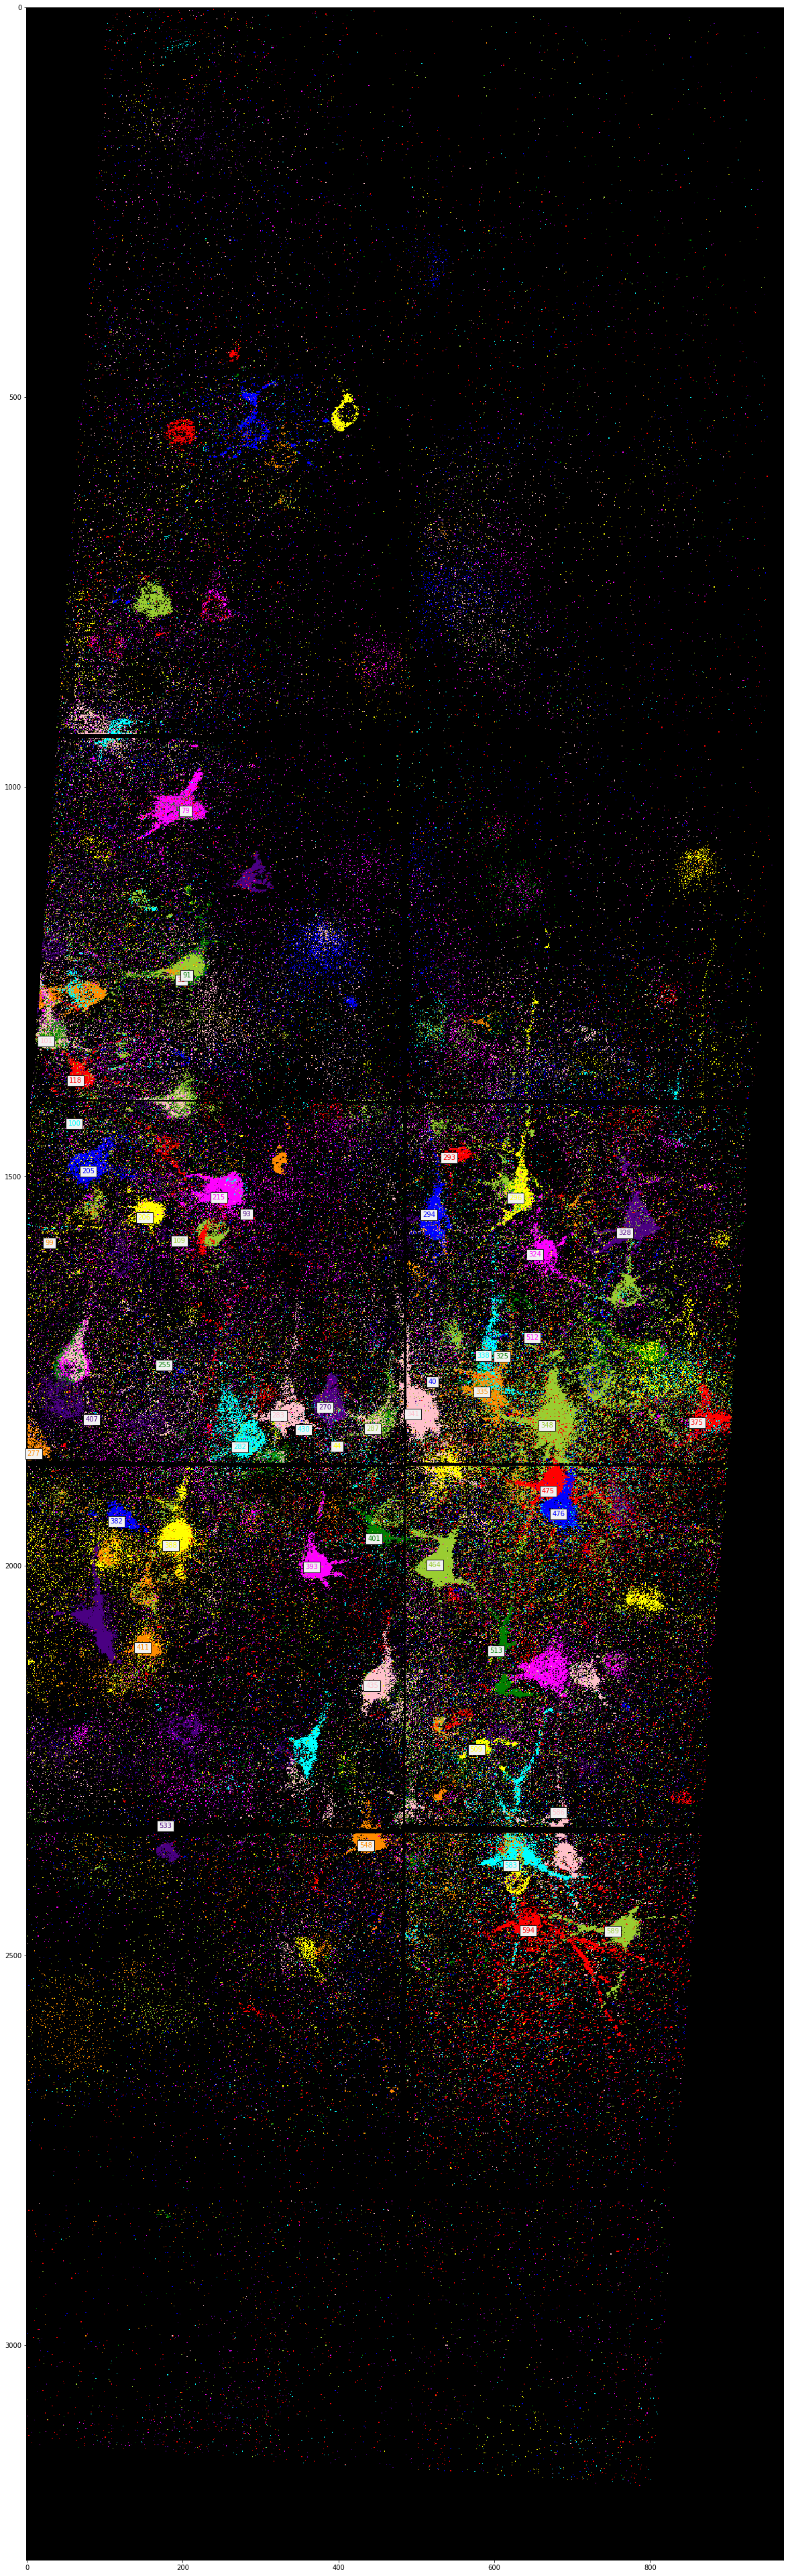

In [956]:
plt.figure(figsize = (25,70))
labels2 = np.max(full_stitch_labels, 2)
col_labels = color.label2rgb(labels2, bg_label = 0)
plt.imshow(col_labels)
colors = color.label2rgb(final_idx, bg_label = 0)
for idx in range(len(final_idx)):
    fidx = final_idx[idx]
    plt.text(coms[idx][1], coms[idx][0], str(fidx), color = colors[idx], ha="right", va="top",
             bbox=dict(boxstyle="square",
                       ec=(0.1, 0.1, 0.1),
                       fc=(0.95, 0.95, 0.95),
                       ))
plt.savefig('test_labels.pdf')

In [274]:
plt.figure(figsize = (10,10))
plt.imshow(num_barcodes.T, norm = norm, cmap = cmap)
plt.axis('off')

NameError: name 'norm' is not defined

<Figure size 720x720 with 0 Axes>

## Processing Full Stitch

In [ ]:
fovs = [Y10, Y20, Y21, Y30, Y40, Y41, Y50, Y51]
num_cells_fov = [5, 15, 15, 15, 15, 15, 15, 15]
fov_file_labels = ['1_0', '2_0', '2_1', '3_0', '4_0', '4_1', '5_0', '5_1']

In [ ]:
for fov_idx in range(len(fovs)):
    print('Running FOV ' + str(fov_idx) + '...')
    Y = fovs[fov_idx]
    num_cells = num_cells_fov[fov_idx]
    fov_file_label = fov_file_labels[fov_idx]

    d1,d2,d3,T = Y.shape
    dim = d1*d2*d3

    Y = high_pass(Y)
    Y = percentile_normalize(Y)
    flatY = np.reshape(Y, (dim, T))

    sigmas = [12,12,8]

    patches = create_3D_patches([d1,d2,d3], [150, 150, 100], [30, 30, 30])
    num_patches = patches.shape[-1]

    A = np.zeros([d1,d2,d3, num_cells*num_patches])
    C = np.zeros([num_cells*num_patches, T])
    patch_list = np.zeros([num_cells*num_patches])

    with warnings.catch_warnings():
        # ignore all caught warnings
        warnings.filterwarnings("ignore")

        for i in tqdm(range(num_patches)):
            idx = i*num_cells
            patch_coords = patches[:,:,i]
            x1,y1,z1,x2,y2,z2 = np.ravel(patch_coords)
            Ypatch = Y[x1:x2, y1:y2, z1:z2, :]
            pl = np.array([i]*num_cells)
            Apatch, Cpatch, pl = process_patch(Ypatch, num_cells, sigmas, pl)

            merged_num = Cpatch.shape[0]
            print('Reshaping patch results...')
            patch_list[idx:idx+merged_num] = pl
            C[idx:idx+merged_num] = Cpatch
            A[:,:,:,idx:idx+merged_num] = embed_patch_results(Apatch, [d1,d2,d3], [x1,y1,z1], [x2, y2, z2])

    A, C, patch_list = remove_empty_components(A, C, patch_list)
    A, C, patch_list = merge_components(A, C, patch_list)

    pickle.dump(A, open(fov_file_label+"_A.p", "wb" ))
    pickle.dump(C, open(fov_file_label+"_C.p", "wb" ))

## Sandbox

In [283]:
filepath = '/mp/nas2/DG/iarpa_virtual_tiles/1_0/4_registration/''richieseq_round001_ch00_affine.tif'
test = io.imread(filepath)

In [290]:
rs = zoom(ds, (4, 4, 4), order = 1)

In [288]:
ds = zoom(test, (0.25, 0.25, 0.25), order = 1)

In [301]:
diff = test[:, :1944, :].astype('float64') - rs[:1870,:, :].astype('float64')

In [307]:
plt.imshow(diff[:,:,400])

IndexError: index 400 is out of bounds for axis 2 with size 400

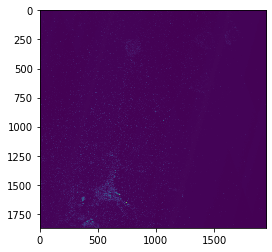

In [302]:
plt.imshow(np.max(diff, 2))

In [294]:
rs.shape

(1872, 1944, 400)

In [293]:
test.shape

(1870, 1946, 400)

In [285]:
test = np.moveaxis(test, 0, -1)

In [268]:
img_dim = 250
r = img_dim // 2

imgs = []
for ridx in tqdm(range(len(unique_labels))):
    idx = unique_labels[ridx]

    idx_colors = color.label2rgb(unique_labels)
    
    labels2 = np.max(full_stitch_labels, 2)
    col_labels = color.label2rgb(labels2, bg_label = 0)
    match = np.max(full_stitch_labels == idx, 2)
    sub_labels = col_labels
    sub_labels[~match, :] = 0
    sub_labels[match, :] = idx_colors[np.where(unique_labels == idx)[0][0]]
    
    x,y,z = loc_raw[ridx]
    
    x = max(r, min(x, d1-1-r))
    y = max(r, min(y, d2-1-r))
    
    imgs.append(sub_labels[x-r:x+r, y-r:y+r, :])

In [269]:
cell_imgs = np.concatenate(imgs, 0)

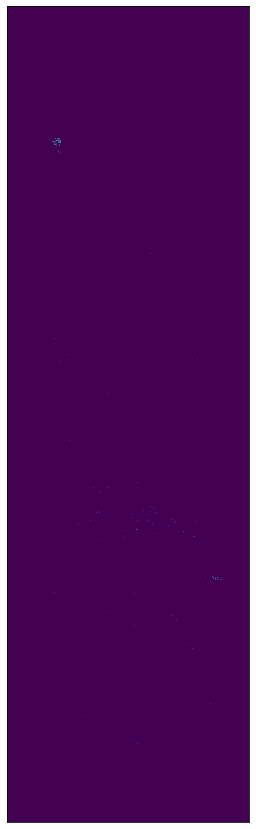

In [281]:
viewmask(full_stitch_labels == 35)

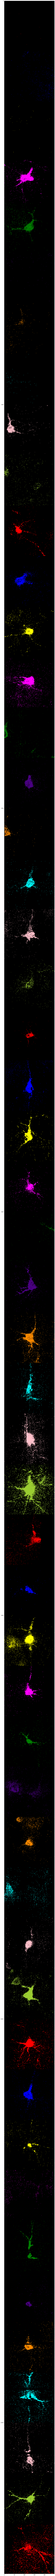

In [280]:
plt.figure(figsize = (10, 510))
plt.imshow(cell_imgs)
plt.savefig('draft_cellbodies.png')

In [254]:
loc_raw = []

for i in range(len(loc)):
    x,y,z = loc[i].strip('[]').split()
    loc_raw.append([int(x),int(y),int(z)])

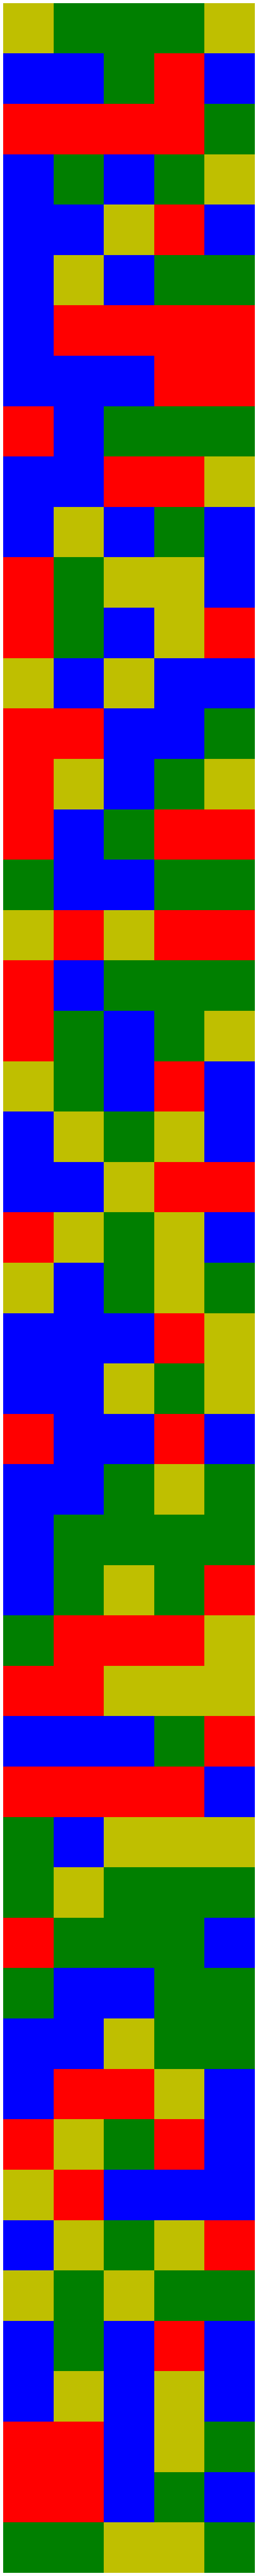

In [279]:
from matplotlib import colors
cmap = colors.ListedColormap(['r', 'g', 'b', 'y'])
bounds=[0.5, 1.5, 2.5, 3.5, 4.5]
norm = colors.BoundaryNorm(bounds, cmap.N)

plt.figure(figsize = (10,510))
plt.imshow(num_barcodes, norm = norm, cmap = cmap)
plt.axis('off')

plt.savefig('draft_barcodes.png')

In [237]:
num_barcodes

array([[4, 2, 2, 2, 4],
       [3, 3, 2, 1, 3],
       [1, 1, 1, 1, 2],
       [3, 2, 3, 2, 4],
       [3, 3, 4, 1, 3],
       [3, 4, 3, 2, 2],
       [3, 1, 1, 1, 1],
       [3, 3, 3, 1, 1],
       [1, 3, 2, 2, 2],
       [3, 3, 1, 1, 4],
       [3, 4, 3, 2, 3],
       [1, 2, 4, 4, 3],
       [1, 2, 3, 4, 1],
       [4, 3, 4, 3, 3],
       [1, 1, 3, 3, 2],
       [1, 4, 3, 2, 4],
       [1, 3, 2, 1, 1],
       [2, 3, 3, 2, 2],
       [4, 1, 4, 1, 1],
       [1, 3, 2, 2, 2],
       [1, 2, 3, 2, 4],
       [4, 2, 3, 1, 3],
       [3, 4, 2, 4, 3],
       [3, 3, 4, 1, 1],
       [1, 4, 2, 4, 3],
       [4, 3, 2, 4, 2],
       [3, 3, 3, 1, 4],
       [3, 3, 4, 2, 4],
       [1, 3, 3, 1, 3],
       [3, 3, 2, 4, 2],
       [3, 2, 2, 2, 2],
       [3, 2, 4, 2, 1],
       [2, 1, 1, 1, 4],
       [1, 1, 4, 4, 4],
       [3, 3, 3, 2, 1],
       [1, 1, 1, 1, 3],
       [2, 3, 4, 4, 4],
       [2, 4, 2, 2, 2],
       [1, 2, 2, 2, 3],
       [2, 3, 3, 2, 2],
       [3, 3, 4, 2, 2],
       [3, 1, 1,

In [236]:
num_barcodes = np.argmax(np.reshape(barcodes, (-1, 5, 4)), -1)+1

In [ ]:
view_components(A)

### Optimization Per Component

In [ ]:
full_stitch_small = zoom(full_stitch, (0.25, 0.25, 0.25, 1), order = 1)

In [ ]:
imagesc(np.sum(full_stitch_small, (2,3)))

In [759]:
labels2 = np.max(full_stitch_labels, 2)
col_labels = color.label2rgb(labels2, bg_label = 0)

In [ ]:
labels2 = np.max(fov_labels, 2)
col_labels = color.label2rgb(labels2, bg_label = 0)

In [ ]:
np.unique(fov_labels)

In [27]:
final_idx

NameError: name 'final_idx' is not defined

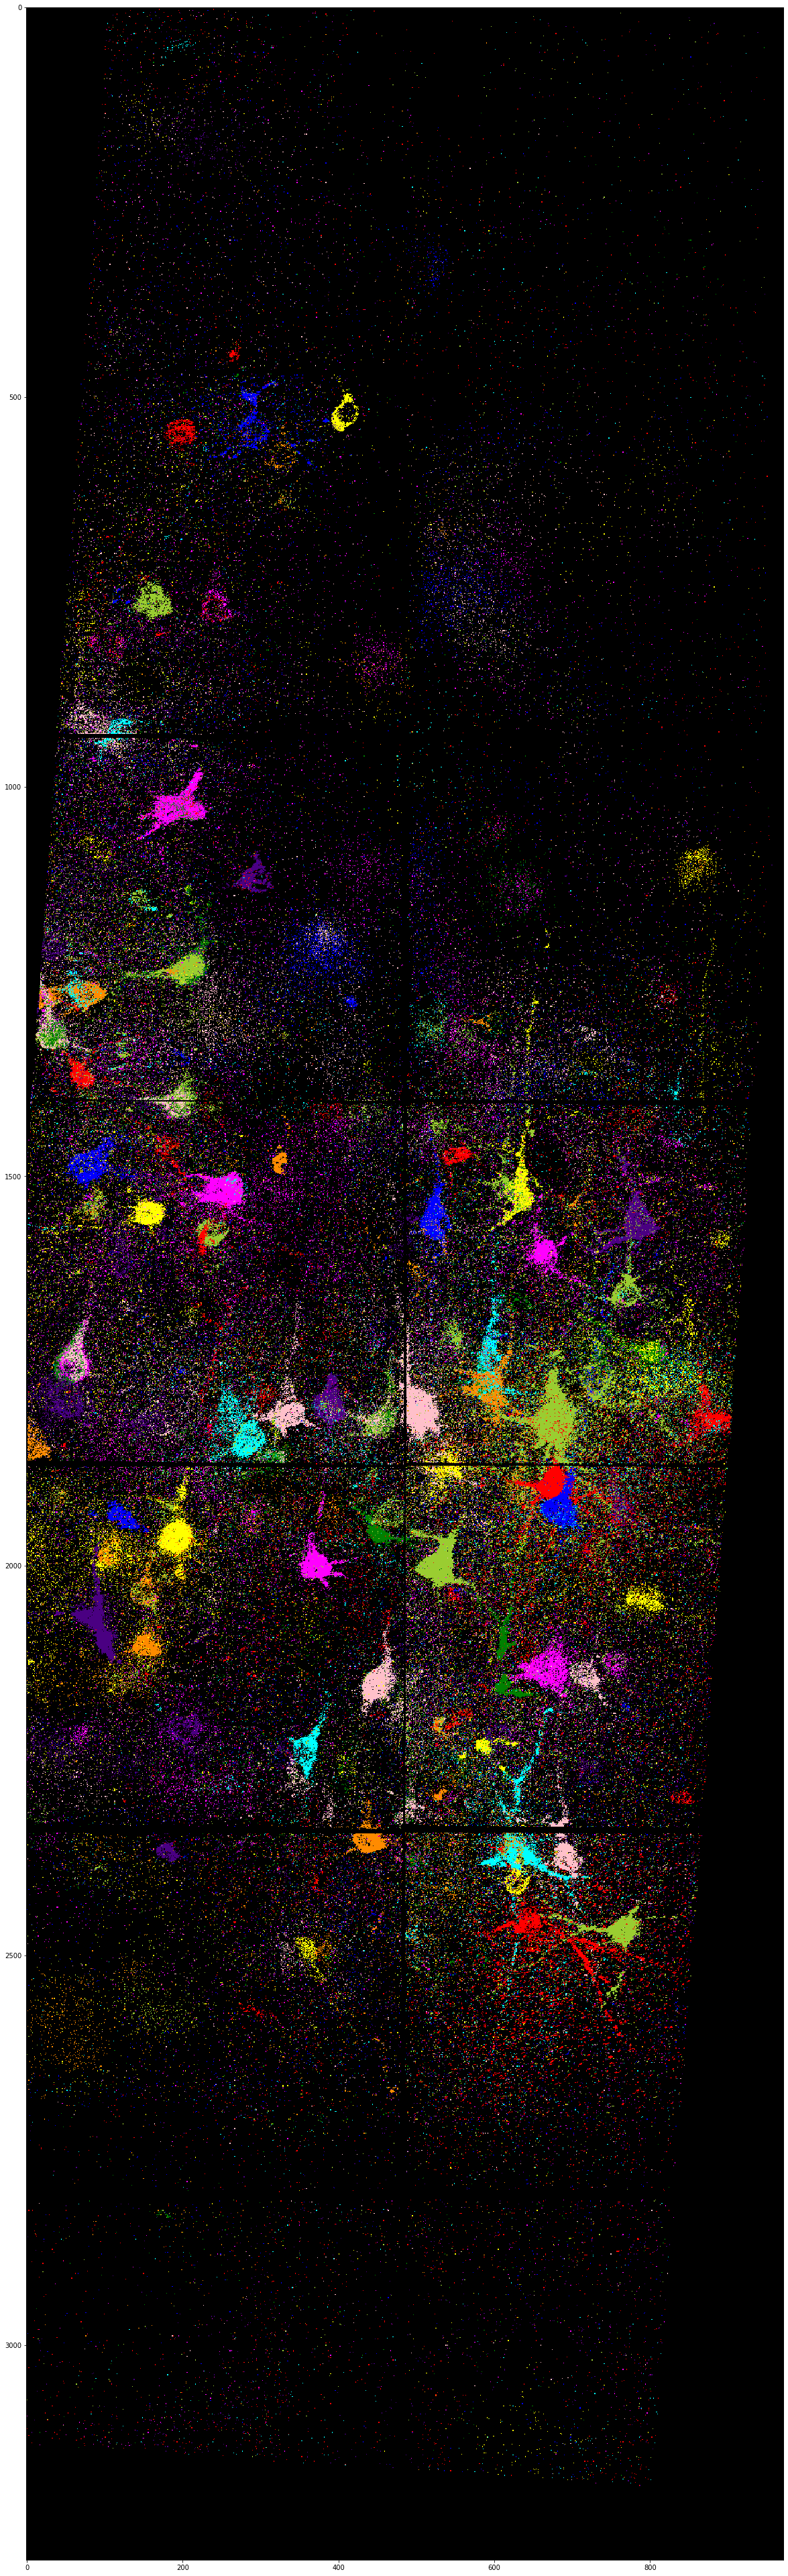

In [761]:
labels2 = np.max(fov_labels, 2)
col_labels = color.label2rgb(labels2, bg_label = 0)
plt.figure(figsize=(25,70))
plt.imshow(col_labels)
plt.savefig('full_stitch_components.pdf')

In [ ]:
full_inputs = [[input_] for input_ in inputs]
full_weights = []

for inputs in tqdm(full_inputs):
    weights = np.array([[1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0]]).astype('d')
    matrix_gradient = grad(basecalling_loss)
    learning_rates = [0.01, 0.001, 0.0001]
    training_steps = [500, 500, 500]
    print("Initial loss:", basecalling_loss(weights))
    for train_idx in range(len(learning_rates)):
        for i in range(training_steps[train_idx]):
            #if i % 10 == 0:
                #print("Current loss:", basecalling_loss(weights))
            weights -= matrix_gradient(weights) * learning_rates[train_idx]

    print("Trained loss:", basecalling_loss(weights))
    full_weights.append(weights)
    
vals = []
size = []
dilation_factor = []
distances = []
for idx in tqdm(range(A.shape[-1])):
    
    weights = full_weights[idx]
    rweights = np.reshape(weights, (4,3))

    d1, d2, d3, T = Y.shape
    barcodeYs = np.reshape(Y, (d1, d2, d3, 5, 3))
    barcodeYs = np.matmul(barcodeYs, rweights.T)
    barcodeYs = (barcodeYs / np.max(barcodeYs, -1, keepdims = True) == 1).astype('int')
    barcodeYs = np.reshape(barcodeYs, (d1,d2,d3, -1))

    b1, bT = C.shape
    barcodeC = np.reshape(C, (b1, 5, 3))
    barcodeC = np.matmul(barcodeC, rweights.T)
    barcodeC = (barcodeC / np.max(barcodeC, -1, keepdims = True) == 1).astype('int')
    barcodeC = np.reshape(barcodeC, (b1,-1))
    
    bm = barcode_match(barcodeC[idx, :], barcodeYs, 5)
    corr, sy, sty = barcode_correlation(C[idx,:], flatY, sy, sty)
    corr = np.reshape(corr, (d1,d2,d3))
    merged = np.logical_and(bm, corr > 0.75)
    sens = (np.sum(A[merged,idx]) / np.sum(A[:,:,:,idx]))
    spec = (np.sum(merged)/merged.size)
    vals.append(sens/spec)
    size.append(np.sum(merged))
    dilation_factor.append(np.sum(dilation(merged, ball(1))) / np.sum(merged))
    
    x,y,z = center_of_mass_norm(merged, 0.5)
    xpos, ypos, zpos = np.where(merged > 0)

    distance = []
    for idx in range(xpos.shape[-1]):
        dist= (xpos[idx]-x)**2 + (ypos[idx]-y)**2 + (zpos[idx]-z)**2
        distance.append(dist ** 0.5)
    distances.append(distance)

vals = np.array(vals)
size = np.array(size)
dilation_factor = np.array(dilation_factor)

In [ ]:
def fast_spatial_correlation(A, blur = False, sigma = [0.5,0.5,0.5]):
    n_cells = A.shape[-1]
    if blur:
        A = A.copy()
        for i in tqdm(range(n_cells)):
            A[:,:,:,i] = gaussian_filter(A[:,:,:,i], sigma, mode = 'constant', output = 'double')
    
    A = np.reshape(A, (-1, n_cells))

    cellsum = np.sum(A, 0, keepdims = True)
    A = A / cellsum 
    
    spatial_overlap = np.zeros((n_cells, n_cells))
    
    for i in tqdm(range(n_cells-1)):
        i_pos = A[:, i] > 0
        tempA = A[i_pos, :]
        subtract_vec = tempA[:, [i]]
        tempA = tempA[:, i+1:]
        tempA = tempA - subtract_vec
        tempA[tempA > 0] = 0
        overlap = np.sum(tempA, 0) + 1
        spatial_overlap[i, i+1:] = overlap
        spatial_overlap[i+1:, i] = overlap
            
    return spatial_overlap

In [ ]:
scf = fast_spatial_correlation(tA)

In [ ]:
tA = A[:,:,:, 0:20]
sc = create_spatial_correlation(tA)